In [0]:
#Necessary imports
import gym
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

## Defining the model- Let's call this body.

In [0]:
# Defining the Deep Q-Network
class Network(nn.Module):
    def __init__(self, input_shape, hidden1, hidden2, n_actions, rate=0.00001):

        super(Network,self).__init__()
        self.input_shape = input_shape
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.n_actions = n_actions
        self.rate = rate

        # Define the layers
        self.fc1 = nn.Linear(self.input_shape,self.hidden1)
        self.fc2 = nn.Linear(self.hidden1,self.hidden2)
        self.final = nn.Linear(self.hidden2,self.n_actions)

        # Choice of  loss and optimizer
        self.optimizer = optim.Adam(self.parameters(),lr=self.rate)
        self.loss = nn.MSELoss()

    def forward(self, observation):
        state = torch.Tensor(observation)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.final(x)

        return actions

## Defining the model- Let's call this the body.

In [0]:
class Agent(object):
    def __init__(self,gamma, eps, eps_decay, eps_min, batch_size, input_size, 
                 n_actions, rate,hidden1=100,hidden2=100, max_mem_size=100000, 
                 eps_end=0.01, eps_dec=0.9):
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_actions = n_actions
        self.network = Network(input_shape=input_size, hidden1=hidden1,
                               hidden2=hidden2, n_actions=self.n_actions, rate=rate)
        self.target = Network(input_shape=input_size, hidden1=hidden1,
                               hidden2=hidden2, n_actions=self.n_actions, rate=rate)
        self.gamma = gamma
        self.epsilon = eps
        self.epsilon_decay = eps_decay
        self.epsilon_min = eps_min
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.action_values = np.array(self.action_space, dtype=np.uint8)
        
        #Define Replay Memory objects
        self.mem_size = max_mem_size
        self.state_memory = np. zeros((self.mem_size,self.input_size))
        self.action_memory = np.zeros((self.mem_size,self.n_actions))
        self.new_state_memory = np.zeros((self.mem_size,self.input_size),dtype = np.uint8)
        self.cost_memory = np.zeros(self.mem_size)
        
        self.mem_counter=0

        #set agent to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def select_action(self, state):
      '''Function to select the action given a state'''
      rand = np.random.random()
      if rand < self.epsilon:      
        action = torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)
        #action = [random.uniform(-1,1),random.uniform(-1,1)]
      else:
        action = self.network.forward(state)
        #action = action.item()
        action = torch.argmax(action)
      return action.item()

    def push(self, state, action, new_state, reward):
      '''Function to store into replay memory.'''
      index =self.mem_counter % self.mem_size
      self.state_memory[index] = state 
      actions = np.zeros(self.n_actions)
      actions[action] = 1.0
      self.action_memory[index] = actions
      self.cost_memory [index]  = reward
      self.new_state_memory[index] = new_state
      self.mem_counter += 1
    
    def learn_from_replay(self):
      '''Learning and updating the network during each time step.'''
      if self.mem_counter<self.batch_size:
        return
      self.network.optimizer.zero_grad()
      batch = np.random.choice(min(self.mem_counter, self.mem_size),self.batch_size)

      state_batch = self.state_memory[batch]
      action_batch = self.action_memory[batch]
      new_state_batch=self.new_state_memory[batch]
      cost_batch = self.cost_memory[batch]
      new_state_batch = self.new_state_memory[batch]
      
      #
      action_values = np.array(self.action_space, dtype = np.uint8)
      action_indices = np.dot(action_batch,action_values)

      Q_Values= self.network.forward(state_batch)
      Q_Target= self.target.forward(state_batch)
      Q_Next = self.network.forward(new_state_batch)

      batch_index = np.arange(self.batch_size,dtype = np.int32)
      Q_Target[batch_index,action_indices] = torch.Tensor(cost_batch) + self.gamma*torch.min(Q_Next,dim = 1)[0]

      loss = self.network.loss(Q_Target, Q_Values)
      loss.backward()
      self.network.optimizer.step()
        
      self.epsilon   = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon_min


## Running the training loop

In [0]:
env = gym.make('MountainCar-v0')
Car=Agent(gamma=0.95, eps=0.5, eps_decay=0.99, eps_min=0.1, batch_size=128, n_actions = env.action_space.n,input_size = env.observation_space.shape[0], rate = 0.003)
succesful_episode_durations=[]
target_updation=50
env.seed(1)
np.random.seed(1)

In [0]:
no_episodes=100
episode_length=400
state=env.reset()
max_pos=state[0]
max_positions=[]
final_positions=[]

In [21]:
for i in tqdm(range(no_episodes)):
  #Take a random step and initalise the variables
  for t in range(episode_length):
    action=Car.select_action(state)
    new_state,reward,done,_ = env.step(action)
    if new_state[0]>max_pos:
      if new_state[0]>0.5:
        new_state[0]=0.5
      reward=new_state[0]+10
      max_positions.append(new_state[0])
      max_pos=new_state[0]
    elif new_state[0]>-0.1:
      reward=new_state[0]+7
    elif new_state[0]>-0.3:
      reward=new_state[0]+5
    elif new_state[0]>-0.4:
      reward=new_state[0]+3
    else:
      reward=new_state[0]+0.5
    Car.push(state,action,new_state,reward)
    state=new_state
    Car.learn_from_replay()
    if t==episode_length-1:
      final_positions.append(new_state[0])
      print("Current Max Position {:.2f}. Final Position{:.2f}".format(max_pos,new_state[0]))
      succesful_episode_durations.append(t+1)
      #plot_durations()
      break
  if i%target_updation==0:
    Car.target.load_state_dict(Car.network.state_dict())

  state=env.reset()
print('Complete')





  0%|          | 0/5000 [00:00<?, ?it/s]



  0%|          | 1/5000 [00:00<1:07:14,  1.24it/s]

Current Max Position -0.27. Final Position-0.58






  0%|          | 2/5000 [00:01<1:14:26,  1.12it/s]

Current Max Position -0.27. Final Position-0.64






  0%|          | 3/5000 [00:03<1:20:34,  1.03it/s]

Current Max Position -0.27. Final Position-0.56






  0%|          | 4/5000 [00:04<1:24:35,  1.02s/it]

Current Max Position -0.27. Final Position-0.52






  0%|          | 5/5000 [00:05<1:27:33,  1.05s/it]

Current Max Position -0.27. Final Position-0.49






  0%|          | 6/5000 [00:06<1:30:27,  1.09s/it]

Current Max Position -0.27. Final Position-0.47






  0%|          | 7/5000 [00:07<1:32:12,  1.11s/it]

Current Max Position -0.27. Final Position-0.69






  0%|          | 8/5000 [00:08<1:33:02,  1.12s/it]

Current Max Position -0.27. Final Position-0.39






  0%|          | 9/5000 [00:09<1:33:31,  1.12s/it]

Current Max Position -0.27. Final Position-0.60






  0%|          | 10/5000 [00:11<1:33:44,  1.13s/it]

Current Max Position -0.27. Final Position-0.47






  0%|          | 11/5000 [00:12<1:34:10,  1.13s/it]

Current Max Position -0.27. Final Position-0.45






  0%|          | 12/5000 [00:13<1:33:51,  1.13s/it]

Current Max Position -0.27. Final Position-0.49






  0%|          | 13/5000 [00:14<1:33:45,  1.13s/it]

Current Max Position -0.27. Final Position-0.50






  0%|          | 14/5000 [00:15<1:33:58,  1.13s/it]

Current Max Position -0.27. Final Position-0.50






  0%|          | 15/5000 [00:16<1:34:05,  1.13s/it]

Current Max Position -0.27. Final Position-0.40






  0%|          | 16/5000 [00:17<1:34:33,  1.14s/it]

Current Max Position -0.27. Final Position-0.49






  0%|          | 17/5000 [00:19<1:34:40,  1.14s/it]

Current Max Position -0.27. Final Position-0.44






  0%|          | 18/5000 [00:20<1:34:40,  1.14s/it]

Current Max Position -0.27. Final Position-0.64






  0%|          | 19/5000 [00:21<1:34:57,  1.14s/it]

Current Max Position -0.27. Final Position-0.40






  0%|          | 20/5000 [00:22<1:35:27,  1.15s/it]

Current Max Position -0.27. Final Position-0.60






  0%|          | 21/5000 [00:23<1:35:43,  1.15s/it]

Current Max Position -0.27. Final Position-0.56






  0%|          | 22/5000 [00:24<1:35:54,  1.16s/it]

Current Max Position -0.27. Final Position-0.43






  0%|          | 23/5000 [00:25<1:36:20,  1.16s/it]

Current Max Position -0.27. Final Position-0.50






  0%|          | 24/5000 [00:27<1:36:40,  1.17s/it]

Current Max Position -0.27. Final Position-0.44






  0%|          | 25/5000 [00:28<1:36:50,  1.17s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 26/5000 [00:29<1:37:28,  1.18s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 27/5000 [00:30<1:37:07,  1.17s/it]

Current Max Position -0.27. Final Position-0.53






  1%|          | 28/5000 [00:31<1:36:49,  1.17s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 29/5000 [00:32<1:36:46,  1.17s/it]

Current Max Position -0.27. Final Position-0.53






  1%|          | 30/5000 [00:34<1:36:34,  1.17s/it]

Current Max Position -0.27. Final Position-0.54






  1%|          | 31/5000 [00:35<1:36:52,  1.17s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 32/5000 [00:36<1:37:15,  1.17s/it]

Current Max Position -0.27. Final Position-0.45






  1%|          | 33/5000 [00:37<1:37:09,  1.17s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 34/5000 [00:38<1:37:50,  1.18s/it]

Current Max Position -0.27. Final Position-0.50






  1%|          | 35/5000 [00:40<1:37:51,  1.18s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 36/5000 [00:41<1:37:33,  1.18s/it]

Current Max Position -0.27. Final Position-0.52






  1%|          | 37/5000 [00:42<1:37:34,  1.18s/it]

Current Max Position -0.27. Final Position-0.46






  1%|          | 38/5000 [00:43<1:38:21,  1.19s/it]

Current Max Position -0.27. Final Position-0.46






  1%|          | 39/5000 [00:44<1:38:21,  1.19s/it]

Current Max Position -0.27. Final Position-0.45






  1%|          | 40/5000 [00:46<1:38:29,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 41/5000 [00:47<1:38:23,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 42/5000 [00:48<1:38:34,  1.19s/it]

Current Max Position -0.27. Final Position-0.46






  1%|          | 43/5000 [00:49<1:38:30,  1.19s/it]

Current Max Position -0.27. Final Position-0.48






  1%|          | 44/5000 [00:50<1:38:10,  1.19s/it]

Current Max Position -0.27. Final Position-0.45






  1%|          | 45/5000 [00:51<1:37:55,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 46/5000 [00:53<1:38:00,  1.19s/it]

Current Max Position -0.27. Final Position-0.42






  1%|          | 47/5000 [00:54<1:37:45,  1.18s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 48/5000 [00:55<1:37:41,  1.18s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 49/5000 [00:56<1:38:19,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 50/5000 [00:57<1:38:20,  1.19s/it]

Current Max Position -0.27. Final Position-0.49






  1%|          | 51/5000 [00:59<1:38:46,  1.20s/it]

Current Max Position -0.27. Final Position-0.44






  1%|          | 52/5000 [01:00<1:39:35,  1.21s/it]

Current Max Position -0.27. Final Position-0.48






  1%|          | 53/5000 [01:01<1:39:38,  1.21s/it]

Current Max Position -0.27. Final Position-0.50






  1%|          | 54/5000 [01:02<1:39:21,  1.21s/it]

Current Max Position -0.27. Final Position-0.47






  1%|          | 55/5000 [01:03<1:39:17,  1.20s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 56/5000 [01:05<1:39:58,  1.21s/it]

Current Max Position -0.27. Final Position-0.49






  1%|          | 57/5000 [01:06<1:39:24,  1.21s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 58/5000 [01:07<1:39:24,  1.21s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 59/5000 [01:08<1:38:59,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  1%|          | 60/5000 [01:09<1:38:33,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  1%|          | 61/5000 [01:11<1:38:51,  1.20s/it]

Current Max Position -0.27. Final Position-0.43






  1%|          | 62/5000 [01:12<1:38:29,  1.20s/it]

Current Max Position -0.27. Final Position-0.46






  1%|▏         | 63/5000 [01:13<1:38:13,  1.19s/it]

Current Max Position -0.27. Final Position-0.40






  1%|▏         | 64/5000 [01:14<1:38:36,  1.20s/it]

Current Max Position -0.27. Final Position-0.40






  1%|▏         | 65/5000 [01:15<1:38:27,  1.20s/it]

Current Max Position -0.27. Final Position-0.41






  1%|▏         | 66/5000 [01:17<1:38:16,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  1%|▏         | 67/5000 [01:18<1:38:03,  1.19s/it]

Current Max Position -0.27. Final Position-0.48






  1%|▏         | 68/5000 [01:19<1:38:23,  1.20s/it]

Current Max Position -0.27. Final Position-0.63






  1%|▏         | 69/5000 [01:20<1:38:30,  1.20s/it]

Current Max Position -0.27. Final Position-0.48






  1%|▏         | 70/5000 [01:21<1:38:21,  1.20s/it]

Current Max Position -0.27. Final Position-0.45






  1%|▏         | 71/5000 [01:23<1:38:23,  1.20s/it]

Current Max Position -0.27. Final Position-0.48






  1%|▏         | 72/5000 [01:24<1:38:12,  1.20s/it]

Current Max Position -0.27. Final Position-0.59






  1%|▏         | 73/5000 [01:25<1:37:56,  1.19s/it]

Current Max Position -0.27. Final Position-0.55






  1%|▏         | 74/5000 [01:26<1:37:45,  1.19s/it]

Current Max Position -0.27. Final Position-0.51






  2%|▏         | 75/5000 [01:27<1:38:21,  1.20s/it]

Current Max Position -0.27. Final Position-0.50






  2%|▏         | 76/5000 [01:29<1:38:18,  1.20s/it]

Current Max Position -0.27. Final Position-0.52






  2%|▏         | 77/5000 [01:30<1:38:48,  1.20s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 78/5000 [01:31<1:39:08,  1.21s/it]

Current Max Position -0.27. Final Position-0.40






  2%|▏         | 79/5000 [01:32<1:38:52,  1.21s/it]

Current Max Position -0.27. Final Position-0.46






  2%|▏         | 80/5000 [01:33<1:38:00,  1.20s/it]

Current Max Position -0.27. Final Position-0.47






  2%|▏         | 81/5000 [01:35<1:37:42,  1.19s/it]

Current Max Position -0.27. Final Position-0.52






  2%|▏         | 82/5000 [01:36<1:37:24,  1.19s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 83/5000 [01:37<1:37:04,  1.18s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 84/5000 [01:38<1:37:00,  1.18s/it]

Current Max Position -0.27. Final Position-0.44






  2%|▏         | 85/5000 [01:39<1:37:02,  1.18s/it]

Current Max Position -0.27. Final Position-0.48






  2%|▏         | 86/5000 [01:41<1:37:45,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  2%|▏         | 87/5000 [01:42<1:37:03,  1.19s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 88/5000 [01:43<1:37:21,  1.19s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 89/5000 [01:44<1:36:58,  1.18s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 90/5000 [01:45<1:37:13,  1.19s/it]

Current Max Position -0.27. Final Position-0.46






  2%|▏         | 91/5000 [01:46<1:37:11,  1.19s/it]

Current Max Position -0.27. Final Position-0.47






  2%|▏         | 92/5000 [01:48<1:37:15,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  2%|▏         | 93/5000 [01:49<1:37:42,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 94/5000 [01:50<1:38:08,  1.20s/it]

Current Max Position -0.27. Final Position-0.47






  2%|▏         | 95/5000 [01:51<1:37:44,  1.20s/it]

Current Max Position -0.27. Final Position-0.51






  2%|▏         | 96/5000 [01:52<1:37:21,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 97/5000 [01:54<1:36:51,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  2%|▏         | 98/5000 [01:55<1:36:38,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 99/5000 [01:56<1:36:57,  1.19s/it]

Current Max Position -0.27. Final Position-0.45






  2%|▏         | 100/5000 [01:57<1:36:32,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 101/5000 [01:58<1:37:21,  1.19s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 102/5000 [02:00<1:36:43,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 103/5000 [02:01<1:36:59,  1.19s/it]

Current Max Position -0.27. Final Position-0.48






  2%|▏         | 104/5000 [02:02<1:36:19,  1.18s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 105/5000 [02:03<1:35:54,  1.18s/it]

Current Max Position -0.27. Final Position-0.49






  2%|▏         | 106/5000 [02:04<1:36:07,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 107/5000 [02:05<1:36:25,  1.18s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 108/5000 [02:07<1:36:38,  1.19s/it]

Current Max Position -0.27. Final Position-0.47






  2%|▏         | 109/5000 [02:08<1:36:20,  1.18s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 110/5000 [02:09<1:36:20,  1.18s/it]

Current Max Position -0.27. Final Position-0.47






  2%|▏         | 111/5000 [02:10<1:36:19,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 112/5000 [02:11<1:36:27,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 113/5000 [02:13<1:36:00,  1.18s/it]

Current Max Position -0.27. Final Position-0.50






  2%|▏         | 114/5000 [02:14<1:36:34,  1.19s/it]

Current Max Position -0.27. Final Position-0.52






  2%|▏         | 115/5000 [02:15<1:36:15,  1.18s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 116/5000 [02:16<1:36:00,  1.18s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 117/5000 [02:17<1:35:48,  1.18s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 118/5000 [02:18<1:36:04,  1.18s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 119/5000 [02:20<1:36:19,  1.18s/it]

Current Max Position -0.27. Final Position-0.46






  2%|▏         | 120/5000 [02:21<1:36:53,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  2%|▏         | 121/5000 [02:22<1:37:22,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  2%|▏         | 122/5000 [02:23<1:37:50,  1.20s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▏         | 123/5000 [02:25<1:38:22,  1.21s/it]

Current Max Position -0.27. Final Position-0.45






  2%|▏         | 124/5000 [02:26<1:38:03,  1.21s/it]

Current Max Position -0.27. Final Position-0.41






  2%|▎         | 125/5000 [02:27<1:37:42,  1.20s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 126/5000 [02:28<1:37:53,  1.21s/it]

Current Max Position -0.27. Final Position-0.40






  3%|▎         | 127/5000 [02:29<1:38:01,  1.21s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 128/5000 [02:31<1:37:32,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  3%|▎         | 129/5000 [02:32<1:38:05,  1.21s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 130/5000 [02:33<1:37:15,  1.20s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 131/5000 [02:34<1:37:06,  1.20s/it]

Current Max Position -0.27. Final Position-0.40






  3%|▎         | 132/5000 [02:35<1:37:03,  1.20s/it]

Current Max Position -0.27. Final Position-0.45






  3%|▎         | 133/5000 [02:36<1:36:56,  1.20s/it]

Current Max Position -0.27. Final Position-0.40






  3%|▎         | 134/5000 [02:38<1:36:31,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  3%|▎         | 135/5000 [02:39<1:36:21,  1.19s/it]

Current Max Position -0.27. Final Position-0.46






  3%|▎         | 136/5000 [02:40<1:36:06,  1.19s/it]

Current Max Position -0.27. Final Position-0.46






  3%|▎         | 137/5000 [02:41<1:36:17,  1.19s/it]

Current Max Position -0.27. Final Position-0.46






  3%|▎         | 138/5000 [02:42<1:38:00,  1.21s/it]

Current Max Position -0.27. Final Position-0.60






  3%|▎         | 139/5000 [02:44<1:39:03,  1.22s/it]

Current Max Position -0.27. Final Position-0.42






  3%|▎         | 140/5000 [02:45<1:39:21,  1.23s/it]

Current Max Position -0.27. Final Position-0.46






  3%|▎         | 141/5000 [02:46<1:39:30,  1.23s/it]

Current Max Position -0.27. Final Position-0.41






  3%|▎         | 142/5000 [02:47<1:39:31,  1.23s/it]

Current Max Position -0.27. Final Position-0.43






  3%|▎         | 143/5000 [02:49<1:39:55,  1.23s/it]

Current Max Position -0.27. Final Position-0.47






  3%|▎         | 144/5000 [02:50<1:40:23,  1.24s/it]

Current Max Position -0.27. Final Position-0.41






  3%|▎         | 145/5000 [02:51<1:40:19,  1.24s/it]

Current Max Position -0.27. Final Position-0.59






  3%|▎         | 146/5000 [02:52<1:40:22,  1.24s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 147/5000 [02:54<1:38:47,  1.22s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 148/5000 [02:55<1:37:25,  1.20s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 149/5000 [02:56<1:37:16,  1.20s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 150/5000 [02:57<1:36:48,  1.20s/it]

Current Max Position -0.27. Final Position-0.46






  3%|▎         | 151/5000 [02:58<1:36:51,  1.20s/it]

Current Max Position -0.27. Final Position-0.45






  3%|▎         | 152/5000 [03:00<1:36:32,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  3%|▎         | 153/5000 [03:01<1:35:59,  1.19s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 154/5000 [03:02<1:36:57,  1.20s/it]

Current Max Position -0.27. Final Position-0.57






  3%|▎         | 155/5000 [03:03<1:36:29,  1.19s/it]

Current Max Position -0.27. Final Position-0.41






  3%|▎         | 156/5000 [03:04<1:36:36,  1.20s/it]

Current Max Position -0.27. Final Position-0.40






  3%|▎         | 157/5000 [03:06<1:36:17,  1.19s/it]

Current Max Position -0.27. Final Position-0.43






  3%|▎         | 158/5000 [03:07<1:36:15,  1.19s/it]

Current Max Position -0.27. Final Position-0.48






  3%|▎         | 159/5000 [03:08<1:36:43,  1.20s/it]

Current Max Position -0.27. Final Position-0.48






  3%|▎         | 160/5000 [03:09<1:36:42,  1.20s/it]

Current Max Position -0.27. Final Position-0.66






  3%|▎         | 161/5000 [03:10<1:36:24,  1.20s/it]

Current Max Position -0.27. Final Position-0.44






  3%|▎         | 162/5000 [03:11<1:36:30,  1.20s/it]

Current Max Position -0.27. Final Position-0.49






  3%|▎         | 163/5000 [03:13<1:36:24,  1.20s/it]

Current Max Position -0.27. Final Position-0.64






  3%|▎         | 164/5000 [03:14<1:36:16,  1.19s/it]

Current Max Position -0.27. Final Position-0.49






  3%|▎         | 165/5000 [03:15<1:36:28,  1.20s/it]

Current Max Position -0.27. Final Position-0.48






  3%|▎         | 166/5000 [03:16<1:36:21,  1.20s/it]

Current Max Position -0.27. Final Position-0.41






  3%|▎         | 167/5000 [03:17<1:36:34,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  3%|▎         | 168/5000 [03:19<1:37:11,  1.21s/it]

Current Max Position -0.27. Final Position-0.47






  3%|▎         | 169/5000 [03:20<1:36:57,  1.20s/it]

Current Max Position -0.27. Final Position-0.42






  3%|▎         | 170/5000 [03:21<1:36:43,  1.20s/it]

Current Max Position -0.27. Final Position-0.45






  3%|▎         | 171/5000 [03:22<1:37:18,  1.21s/it]

Current Max Position -0.27. Final Position-0.52






  3%|▎         | 172/5000 [03:24<1:37:40,  1.21s/it]

Current Max Position -0.27. Final Position-0.41






  3%|▎         | 173/5000 [03:25<1:37:44,  1.21s/it]

Current Max Position -0.27. Final Position-0.45






  3%|▎         | 174/5000 [03:26<1:38:15,  1.22s/it]

Current Max Position -0.27. Final Position-0.52






  4%|▎         | 175/5000 [03:27<1:38:10,  1.22s/it]

Current Max Position -0.27. Final Position-0.46






  4%|▎         | 176/5000 [03:28<1:38:08,  1.22s/it]

Current Max Position -0.27. Final Position-0.41






  4%|▎         | 177/5000 [03:30<1:38:23,  1.22s/it]

Current Max Position -0.27. Final Position-0.42






  4%|▎         | 178/5000 [03:31<1:38:11,  1.22s/it]

Current Max Position -0.27. Final Position-0.47






  4%|▎         | 179/5000 [03:32<1:38:55,  1.23s/it]

Current Max Position -0.27. Final Position-0.44






  4%|▎         | 180/5000 [03:33<1:38:55,  1.23s/it]

Current Max Position -0.27. Final Position-0.41






  4%|▎         | 181/5000 [03:35<1:39:03,  1.23s/it]

Current Max Position -0.27. Final Position-0.49






  4%|▎         | 182/5000 [03:36<1:39:01,  1.23s/it]

Current Max Position -0.27. Final Position-0.42






  4%|▎         | 183/5000 [03:37<1:39:06,  1.23s/it]

Current Max Position -0.27. Final Position-0.50






  4%|▎         | 184/5000 [03:38<1:39:39,  1.24s/it]

Current Max Position -0.27. Final Position-0.46






  4%|▎         | 185/5000 [03:40<1:39:49,  1.24s/it]

Current Max Position -0.27. Final Position-0.40






  4%|▎         | 186/5000 [03:41<1:39:41,  1.24s/it]

Current Max Position -0.27. Final Position-0.43






  4%|▎         | 187/5000 [03:42<1:39:56,  1.25s/it]

Current Max Position -0.27. Final Position-0.61






  4%|▍         | 188/5000 [03:43<1:40:12,  1.25s/it]

Current Max Position -0.27. Final Position-0.53






  4%|▍         | 189/5000 [03:45<1:40:39,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  4%|▍         | 190/5000 [03:46<1:41:07,  1.26s/it]

Current Max Position -0.27. Final Position-0.45






  4%|▍         | 191/5000 [03:47<1:41:01,  1.26s/it]

Current Max Position -0.27. Final Position-0.41






  4%|▍         | 192/5000 [03:48<1:41:08,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  4%|▍         | 193/5000 [03:50<1:41:13,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  4%|▍         | 194/5000 [03:51<1:40:41,  1.26s/it]

Current Max Position -0.27. Final Position-0.54






  4%|▍         | 195/5000 [03:52<1:40:03,  1.25s/it]

Current Max Position -0.27. Final Position-0.46






  4%|▍         | 196/5000 [03:53<1:40:01,  1.25s/it]

Current Max Position -0.27. Final Position-0.45






  4%|▍         | 197/5000 [03:55<1:40:01,  1.25s/it]

Current Max Position -0.27. Final Position-0.44






  4%|▍         | 198/5000 [03:56<1:40:32,  1.26s/it]

Current Max Position -0.27. Final Position-0.42






  4%|▍         | 199/5000 [03:57<1:40:10,  1.25s/it]

Current Max Position -0.27. Final Position-0.46






  4%|▍         | 200/5000 [03:58<1:39:34,  1.24s/it]

Current Max Position -0.27. Final Position-0.47






  4%|▍         | 201/5000 [04:00<1:39:36,  1.25s/it]

Current Max Position -0.27. Final Position-0.48






  4%|▍         | 202/5000 [04:01<1:40:14,  1.25s/it]

Current Max Position -0.27. Final Position-0.59






  4%|▍         | 203/5000 [04:02<1:40:52,  1.26s/it]

Current Max Position -0.27. Final Position-0.57






  4%|▍         | 204/5000 [04:03<1:40:29,  1.26s/it]

Current Max Position -0.27. Final Position-0.53






  4%|▍         | 205/5000 [04:05<1:40:17,  1.26s/it]

Current Max Position -0.27. Final Position-0.52






  4%|▍         | 206/5000 [04:06<1:41:04,  1.27s/it]

Current Max Position -0.27. Final Position-0.51






  4%|▍         | 207/5000 [04:07<1:41:07,  1.27s/it]

Current Max Position -0.27. Final Position-0.50






  4%|▍         | 208/5000 [04:09<1:40:47,  1.26s/it]

Current Max Position -0.27. Final Position-0.59






  4%|▍         | 209/5000 [04:10<1:41:06,  1.27s/it]

Current Max Position -0.27. Final Position-0.48






  4%|▍         | 210/5000 [04:11<1:40:39,  1.26s/it]

Current Max Position -0.27. Final Position-0.42






  4%|▍         | 211/5000 [04:12<1:40:29,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  4%|▍         | 212/5000 [04:14<1:40:37,  1.26s/it]

Current Max Position -0.27. Final Position-0.55






  4%|▍         | 213/5000 [04:15<1:40:55,  1.27s/it]

Current Max Position -0.27. Final Position-0.50






  4%|▍         | 214/5000 [04:16<1:41:19,  1.27s/it]

Current Max Position -0.27. Final Position-0.47






  4%|▍         | 215/5000 [04:17<1:40:46,  1.26s/it]

Current Max Position -0.27. Final Position-0.47






  4%|▍         | 216/5000 [04:19<1:40:45,  1.26s/it]

Current Max Position -0.27. Final Position-0.52






  4%|▍         | 217/5000 [04:20<1:40:08,  1.26s/it]

Current Max Position -0.27. Final Position-0.52






  4%|▍         | 218/5000 [04:21<1:39:41,  1.25s/it]

Current Max Position -0.27. Final Position-0.47






  4%|▍         | 219/5000 [04:22<1:39:30,  1.25s/it]

Current Max Position -0.27. Final Position-0.42






  4%|▍         | 220/5000 [04:24<1:40:07,  1.26s/it]

Current Max Position -0.27. Final Position-0.46






  4%|▍         | 221/5000 [04:25<1:39:36,  1.25s/it]

Current Max Position -0.27. Final Position-0.42






  4%|▍         | 222/5000 [04:26<1:39:09,  1.25s/it]

Current Max Position -0.27. Final Position-0.51






  4%|▍         | 223/5000 [04:27<1:39:18,  1.25s/it]

Current Max Position -0.27. Final Position-0.55






  4%|▍         | 224/5000 [04:29<1:39:26,  1.25s/it]

Current Max Position -0.27. Final Position-0.73






  4%|▍         | 225/5000 [04:30<1:39:38,  1.25s/it]

Current Max Position -0.27. Final Position-0.50






  5%|▍         | 226/5000 [04:31<1:39:24,  1.25s/it]

Current Max Position -0.27. Final Position-0.55






  5%|▍         | 227/5000 [04:32<1:39:42,  1.25s/it]

Current Max Position -0.27. Final Position-0.55






  5%|▍         | 228/5000 [04:34<1:39:04,  1.25s/it]

Current Max Position -0.27. Final Position-0.44






  5%|▍         | 229/5000 [04:35<1:39:20,  1.25s/it]

Current Max Position -0.27. Final Position-0.45






  5%|▍         | 230/5000 [04:36<1:39:32,  1.25s/it]

Current Max Position -0.27. Final Position-0.48






  5%|▍         | 231/5000 [04:37<1:39:58,  1.26s/it]

Current Max Position -0.27. Final Position-0.51






  5%|▍         | 232/5000 [04:39<1:40:13,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  5%|▍         | 233/5000 [04:40<1:39:43,  1.26s/it]

Current Max Position -0.27. Final Position-0.45






  5%|▍         | 234/5000 [04:41<1:40:41,  1.27s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▍         | 235/5000 [04:42<1:40:32,  1.27s/it]

Current Max Position -0.27. Final Position-0.43






  5%|▍         | 236/5000 [04:44<1:40:05,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  5%|▍         | 237/5000 [04:45<1:39:44,  1.26s/it]

Current Max Position -0.27. Final Position-0.51






  5%|▍         | 238/5000 [04:46<1:40:04,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  5%|▍         | 239/5000 [04:48<1:41:06,  1.27s/it]

Current Max Position -0.27. Final Position-0.48






  5%|▍         | 240/5000 [04:49<1:41:33,  1.28s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▍         | 241/5000 [04:50<1:41:48,  1.28s/it]

Current Max Position -0.27. Final Position-0.44






  5%|▍         | 242/5000 [04:51<1:41:34,  1.28s/it]

Current Max Position -0.27. Final Position-0.47






  5%|▍         | 243/5000 [04:53<1:41:07,  1.28s/it]

Current Max Position -0.27. Final Position-0.44






  5%|▍         | 244/5000 [04:54<1:40:31,  1.27s/it]

Current Max Position -0.27. Final Position-0.54






  5%|▍         | 245/5000 [04:55<1:40:03,  1.26s/it]

Current Max Position -0.27. Final Position-0.50






  5%|▍         | 246/5000 [04:56<1:39:24,  1.25s/it]

Current Max Position -0.27. Final Position-0.50






  5%|▍         | 247/5000 [04:58<1:39:44,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  5%|▍         | 248/5000 [04:59<1:39:46,  1.26s/it]

Current Max Position -0.27. Final Position-0.47






  5%|▍         | 249/5000 [05:00<1:39:44,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  5%|▌         | 250/5000 [05:01<1:39:59,  1.26s/it]

Current Max Position -0.27. Final Position-0.59






  5%|▌         | 251/5000 [05:03<1:40:47,  1.27s/it]

Current Max Position -0.27. Final Position-0.45






  5%|▌         | 252/5000 [05:04<1:40:44,  1.27s/it]

Current Max Position -0.27. Final Position-0.44






  5%|▌         | 253/5000 [05:05<1:40:44,  1.27s/it]

Current Max Position -0.27. Final Position-0.40






  5%|▌         | 254/5000 [05:07<1:41:04,  1.28s/it]

Current Max Position -0.27. Final Position-0.45






  5%|▌         | 255/5000 [05:08<1:40:55,  1.28s/it]

Current Max Position -0.27. Final Position-0.47






  5%|▌         | 256/5000 [05:09<1:41:10,  1.28s/it]

Current Max Position -0.27. Final Position-0.49






  5%|▌         | 257/5000 [05:10<1:40:29,  1.27s/it]

Current Max Position -0.27. Final Position-0.45






  5%|▌         | 258/5000 [05:12<1:39:49,  1.26s/it]

Current Max Position -0.27. Final Position-0.59






  5%|▌         | 259/5000 [05:13<1:39:53,  1.26s/it]

Current Max Position -0.27. Final Position-0.42






  5%|▌         | 260/5000 [05:14<1:39:26,  1.26s/it]

Current Max Position -0.27. Final Position-0.37






  5%|▌         | 261/5000 [05:15<1:39:28,  1.26s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▌         | 262/5000 [05:17<1:39:10,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  5%|▌         | 263/5000 [05:18<1:39:45,  1.26s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▌         | 264/5000 [05:19<1:39:09,  1.26s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▌         | 265/5000 [05:20<1:39:10,  1.26s/it]

Current Max Position -0.27. Final Position-0.55






  5%|▌         | 266/5000 [05:22<1:39:01,  1.26s/it]

Current Max Position -0.27. Final Position-0.38






  5%|▌         | 267/5000 [05:23<1:38:44,  1.25s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▌         | 268/5000 [05:24<1:38:43,  1.25s/it]

Current Max Position -0.27. Final Position-0.52






  5%|▌         | 269/5000 [05:25<1:39:12,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  5%|▌         | 270/5000 [05:27<1:39:14,  1.26s/it]

Current Max Position -0.27. Final Position-0.61






  5%|▌         | 271/5000 [05:28<1:39:20,  1.26s/it]

Current Max Position -0.27. Final Position-0.46






  5%|▌         | 272/5000 [05:29<1:39:14,  1.26s/it]

Current Max Position -0.27. Final Position-0.52






  5%|▌         | 273/5000 [05:30<1:38:45,  1.25s/it]

Current Max Position -0.27. Final Position-0.62






  5%|▌         | 274/5000 [05:32<1:38:15,  1.25s/it]

Current Max Position -0.27. Final Position-0.54






  6%|▌         | 275/5000 [05:33<1:39:14,  1.26s/it]

Current Max Position -0.27. Final Position-0.58






  6%|▌         | 276/5000 [05:34<1:38:42,  1.25s/it]

Current Max Position -0.27. Final Position-0.47






  6%|▌         | 277/5000 [05:35<1:38:38,  1.25s/it]

Current Max Position -0.27. Final Position-0.51






  6%|▌         | 278/5000 [05:37<1:38:25,  1.25s/it]

Current Max Position -0.27. Final Position-0.45






  6%|▌         | 279/5000 [05:38<1:39:23,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  6%|▌         | 280/5000 [05:39<1:39:25,  1.26s/it]

Current Max Position -0.27. Final Position-0.50






  6%|▌         | 281/5000 [05:41<1:39:29,  1.27s/it]

Current Max Position -0.27. Final Position-0.53






  6%|▌         | 282/5000 [05:42<1:39:10,  1.26s/it]

Current Max Position -0.27. Final Position-0.56






  6%|▌         | 283/5000 [05:43<1:39:58,  1.27s/it]

Current Max Position -0.27. Final Position-0.41






  6%|▌         | 284/5000 [05:44<1:39:57,  1.27s/it]

Current Max Position -0.27. Final Position-0.45






  6%|▌         | 285/5000 [05:46<1:39:25,  1.27s/it]

Current Max Position -0.27. Final Position-0.45






  6%|▌         | 286/5000 [05:47<1:39:56,  1.27s/it]

Current Max Position -0.27. Final Position-0.56






  6%|▌         | 287/5000 [05:48<1:40:07,  1.27s/it]

Current Max Position -0.27. Final Position-0.45






  6%|▌         | 288/5000 [05:49<1:39:17,  1.26s/it]

Current Max Position -0.27. Final Position-0.43






  6%|▌         | 289/5000 [05:51<1:38:53,  1.26s/it]

Current Max Position -0.27. Final Position-0.60






  6%|▌         | 290/5000 [05:52<1:38:27,  1.25s/it]

Current Max Position -0.27. Final Position-0.58






  6%|▌         | 291/5000 [05:53<1:38:06,  1.25s/it]

Current Max Position -0.27. Final Position-0.51






  6%|▌         | 292/5000 [05:54<1:38:27,  1.25s/it]

Current Max Position -0.27. Final Position-0.49






  6%|▌         | 293/5000 [05:56<1:38:14,  1.25s/it]

Current Max Position -0.27. Final Position-0.43






  6%|▌         | 294/5000 [05:57<1:37:44,  1.25s/it]

Current Max Position -0.27. Final Position-0.49






  6%|▌         | 295/5000 [05:58<1:38:07,  1.25s/it]

Current Max Position -0.27. Final Position-0.49






  6%|▌         | 296/5000 [05:59<1:38:25,  1.26s/it]

Current Max Position -0.27. Final Position-0.61






  6%|▌         | 297/5000 [06:01<1:38:08,  1.25s/it]

Current Max Position -0.27. Final Position-0.54






  6%|▌         | 298/5000 [06:02<1:38:04,  1.25s/it]

Current Max Position -0.27. Final Position-0.54






  6%|▌         | 299/5000 [06:03<1:38:39,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  6%|▌         | 300/5000 [06:04<1:38:23,  1.26s/it]

Current Max Position -0.27. Final Position-0.55






  6%|▌         | 301/5000 [06:06<1:38:26,  1.26s/it]

Current Max Position -0.27. Final Position-0.40






  6%|▌         | 302/5000 [06:07<1:38:14,  1.25s/it]

Current Max Position -0.27. Final Position-0.48






  6%|▌         | 303/5000 [06:08<1:38:37,  1.26s/it]

Current Max Position -0.27. Final Position-0.62






  6%|▌         | 304/5000 [06:09<1:38:48,  1.26s/it]

Current Max Position -0.27. Final Position-0.40






  6%|▌         | 305/5000 [06:11<1:38:52,  1.26s/it]

Current Max Position -0.27. Final Position-0.65






  6%|▌         | 306/5000 [06:12<1:38:51,  1.26s/it]

Current Max Position -0.27. Final Position-0.58






  6%|▌         | 307/5000 [06:13<1:38:39,  1.26s/it]

Current Max Position -0.27. Final Position-0.44






  6%|▌         | 308/5000 [06:15<1:38:22,  1.26s/it]

Current Max Position -0.27. Final Position-0.68






  6%|▌         | 309/5000 [06:16<1:38:17,  1.26s/it]

Current Max Position -0.27. Final Position-0.62






  6%|▌         | 310/5000 [06:17<1:38:12,  1.26s/it]

Current Max Position -0.27. Final Position-0.49






  6%|▌         | 311/5000 [06:18<1:37:42,  1.25s/it]

Current Max Position -0.27. Final Position-0.56






  6%|▌         | 312/5000 [06:20<1:37:22,  1.25s/it]

Current Max Position -0.27. Final Position-0.40






  6%|▋         | 313/5000 [06:21<1:37:42,  1.25s/it]

Current Max Position -0.27. Final Position-0.53






  6%|▋         | 314/5000 [06:22<1:38:20,  1.26s/it]

Current Max Position -0.27. Final Position-0.61






  6%|▋         | 315/5000 [06:23<1:38:44,  1.26s/it]

Current Max Position -0.27. Final Position-0.47






  6%|▋         | 316/5000 [06:25<1:38:55,  1.27s/it]

Current Max Position -0.27. Final Position-0.51






  6%|▋         | 317/5000 [06:26<1:39:08,  1.27s/it]

Current Max Position -0.27. Final Position-0.42






  6%|▋         | 318/5000 [06:27<1:39:25,  1.27s/it]

Current Max Position -0.27. Final Position-0.40






  6%|▋         | 319/5000 [06:28<1:39:35,  1.28s/it]

Current Max Position -0.27. Final Position-0.62






  6%|▋         | 320/5000 [06:30<1:39:01,  1.27s/it]

Current Max Position -0.27. Final Position-0.44






  6%|▋         | 321/5000 [06:31<1:38:28,  1.26s/it]

Current Max Position -0.27. Final Position-0.42






  6%|▋         | 322/5000 [06:32<1:38:17,  1.26s/it]

Current Max Position -0.27. Final Position-0.58






  6%|▋         | 323/5000 [06:33<1:38:35,  1.26s/it]

Current Max Position -0.27. Final Position-0.50






  6%|▋         | 324/5000 [06:35<1:38:26,  1.26s/it]

Current Max Position -0.27. Final Position-0.44






  6%|▋         | 325/5000 [06:36<1:38:08,  1.26s/it]

Current Max Position -0.27. Final Position-0.54






  7%|▋         | 326/5000 [06:37<1:38:10,  1.26s/it]

Current Max Position -0.27. Final Position-0.52






  7%|▋         | 327/5000 [06:38<1:37:41,  1.25s/it]

Current Max Position -0.27. Final Position-0.55






  7%|▋         | 328/5000 [06:40<1:37:57,  1.26s/it]

Current Max Position -0.27. Final Position-0.63






  7%|▋         | 329/5000 [06:41<1:38:07,  1.26s/it]

Current Max Position -0.27. Final Position-0.51






  7%|▋         | 330/5000 [06:42<1:38:05,  1.26s/it]

Current Max Position -0.27. Final Position-0.64






  7%|▋         | 331/5000 [06:44<1:38:13,  1.26s/it]

Current Max Position -0.27. Final Position-0.55






  7%|▋         | 332/5000 [06:45<1:38:12,  1.26s/it]

Current Max Position -0.27. Final Position-0.58






  7%|▋         | 333/5000 [06:46<1:38:28,  1.27s/it]

Current Max Position -0.27. Final Position-0.55






  7%|▋         | 334/5000 [06:47<1:38:36,  1.27s/it]

Current Max Position -0.27. Final Position-0.51






  7%|▋         | 335/5000 [06:49<1:38:36,  1.27s/it]

Current Max Position -0.27. Final Position-0.64






  7%|▋         | 336/5000 [06:50<1:38:20,  1.27s/it]

Current Max Position -0.27. Final Position-0.53






  7%|▋         | 337/5000 [06:51<1:38:09,  1.26s/it]

Current Max Position -0.27. Final Position-0.55






  7%|▋         | 338/5000 [06:52<1:38:09,  1.26s/it]

Current Max Position -0.27. Final Position-0.48






  7%|▋         | 339/5000 [06:54<1:37:32,  1.26s/it]

Current Max Position -0.27. Final Position-0.57






  7%|▋         | 340/5000 [06:55<1:37:39,  1.26s/it]

Current Max Position -0.27. Final Position-0.60






  7%|▋         | 341/5000 [06:56<1:37:51,  1.26s/it]

Current Max Position -0.27. Final Position-0.53






  7%|▋         | 342/5000 [06:57<1:37:41,  1.26s/it]

Current Max Position -0.27. Final Position-0.61






  7%|▋         | 343/5000 [06:59<1:37:51,  1.26s/it]

Current Max Position -0.27. Final Position-0.61






  7%|▋         | 344/5000 [07:00<1:37:27,  1.26s/it]

Current Max Position -0.27. Final Position-0.58






  7%|▋         | 345/5000 [07:01<1:37:19,  1.25s/it]

Current Max Position -0.27. Final Position-0.55






  7%|▋         | 346/5000 [07:02<1:37:28,  1.26s/it]

Current Max Position -0.27. Final Position-0.59






  7%|▋         | 347/5000 [07:04<1:37:42,  1.26s/it]

Current Max Position -0.27. Final Position-0.63






  7%|▋         | 348/5000 [07:05<1:37:28,  1.26s/it]

Current Max Position -0.27. Final Position-0.45






  7%|▋         | 349/5000 [07:06<1:37:07,  1.25s/it]

Current Max Position -0.27. Final Position-0.43






  7%|▋         | 350/5000 [07:07<1:36:56,  1.25s/it]

Current Max Position -0.27. Final Position-0.40






  7%|▋         | 351/5000 [07:09<1:36:40,  1.25s/it]

Current Max Position -0.27. Final Position-0.51






  7%|▋         | 352/5000 [07:10<1:36:05,  1.24s/it]

Current Max Position -0.27. Final Position-0.50






  7%|▋         | 353/5000 [07:11<1:36:11,  1.24s/it]

Current Max Position -0.27. Final Position-0.47






  7%|▋         | 354/5000 [07:12<1:36:11,  1.24s/it]

Current Max Position -0.27. Final Position-0.60






  7%|▋         | 355/5000 [07:14<1:36:55,  1.25s/it]

Current Max Position -0.27. Final Position-0.48






  7%|▋         | 356/5000 [07:15<1:36:40,  1.25s/it]

Current Max Position -0.27. Final Position-0.46






  7%|▋         | 357/5000 [07:16<1:36:59,  1.25s/it]

Current Max Position -0.27. Final Position-0.60






  7%|▋         | 358/5000 [07:17<1:36:31,  1.25s/it]

Current Max Position -0.27. Final Position-0.55






  7%|▋         | 359/5000 [07:19<1:36:34,  1.25s/it]

Current Max Position -0.27. Final Position-0.45






  7%|▋         | 360/5000 [07:20<1:36:35,  1.25s/it]

Current Max Position -0.27. Final Position-0.37






  7%|▋         | 361/5000 [07:21<1:36:16,  1.25s/it]

Current Max Position -0.27. Final Position-0.40






  7%|▋         | 362/5000 [07:22<1:36:07,  1.24s/it]

Current Max Position -0.27. Final Position-0.54






  7%|▋         | 363/5000 [07:24<1:36:01,  1.24s/it]

Current Max Position -0.27. Final Position-0.61






  7%|▋         | 364/5000 [07:25<1:35:38,  1.24s/it]

Current Max Position -0.27. Final Position-0.54






  7%|▋         | 365/5000 [07:26<1:36:08,  1.24s/it]

Current Max Position -0.27. Final Position-0.42






  7%|▋         | 366/5000 [07:27<1:35:53,  1.24s/it]

Current Max Position -0.27. Final Position-0.53






  7%|▋         | 367/5000 [07:29<1:35:51,  1.24s/it]

Current Max Position -0.27. Final Position-0.42






  7%|▋         | 368/5000 [07:30<1:35:37,  1.24s/it]

Current Max Position -0.27. Final Position-0.40






  7%|▋         | 369/5000 [07:31<1:35:24,  1.24s/it]

Current Max Position -0.27. Final Position-0.48






  7%|▋         | 370/5000 [07:32<1:35:22,  1.24s/it]

Current Max Position -0.27. Final Position-0.44






  7%|▋         | 371/5000 [07:34<1:35:41,  1.24s/it]

Current Max Position -0.27. Final Position-0.48






  7%|▋         | 372/5000 [07:35<1:35:09,  1.23s/it]

Current Max Position -0.27. Final Position-0.62






  7%|▋         | 373/5000 [07:36<1:34:59,  1.23s/it]

Current Max Position -0.27. Final Position-0.37






  7%|▋         | 374/5000 [07:37<1:35:05,  1.23s/it]

Current Max Position -0.27. Final Position-0.57






  8%|▊         | 375/5000 [07:39<1:36:12,  1.25s/it]

Current Max Position -0.27. Final Position-0.53






  8%|▊         | 376/5000 [07:40<1:36:56,  1.26s/it]

Current Max Position -0.27. Final Position-0.52






  8%|▊         | 377/5000 [07:41<1:38:29,  1.28s/it]

Current Max Position -0.27. Final Position-0.44






  8%|▊         | 378/5000 [07:42<1:38:51,  1.28s/it]

Current Max Position -0.27. Final Position-0.56






  8%|▊         | 379/5000 [07:44<1:39:19,  1.29s/it]

Current Max Position -0.27. Final Position-0.52






  8%|▊         | 380/5000 [07:45<1:39:29,  1.29s/it]

Current Max Position -0.27. Final Position-0.41






  8%|▊         | 381/5000 [07:46<1:39:33,  1.29s/it]

Current Max Position -0.27. Final Position-0.57






  8%|▊         | 382/5000 [07:48<1:39:46,  1.30s/it]

Current Max Position -0.27. Final Position-0.45






  8%|▊         | 383/5000 [07:49<1:39:51,  1.30s/it]

Current Max Position -0.27. Final Position-0.51






  8%|▊         | 384/5000 [07:50<1:39:54,  1.30s/it]

Current Max Position -0.27. Final Position-0.44






  8%|▊         | 385/5000 [07:52<1:40:08,  1.30s/it]

Current Max Position -0.27. Final Position-0.43






  8%|▊         | 386/5000 [07:53<1:41:41,  1.32s/it]

Current Max Position -0.27. Final Position-0.46






  8%|▊         | 387/5000 [07:54<1:42:29,  1.33s/it]

Current Max Position -0.27. Final Position-0.46






  8%|▊         | 388/5000 [07:56<1:41:47,  1.32s/it]

Current Max Position -0.27. Final Position-0.46






  8%|▊         | 389/5000 [07:57<1:41:11,  1.32s/it]

Current Max Position -0.27. Final Position-0.41






  8%|▊         | 390/5000 [07:58<1:41:40,  1.32s/it]

Current Max Position -0.27. Final Position-0.41






  8%|▊         | 391/5000 [08:00<1:41:24,  1.32s/it]

Current Max Position -0.27. Final Position-0.64






  8%|▊         | 392/5000 [08:01<1:40:46,  1.31s/it]

Current Max Position -0.27. Final Position-0.60






  8%|▊         | 393/5000 [08:02<1:40:57,  1.31s/it]

Current Max Position -0.27. Final Position-0.61






  8%|▊         | 394/5000 [08:03<1:40:04,  1.30s/it]

Current Max Position -0.27. Final Position-0.44






  8%|▊         | 395/5000 [08:05<1:39:21,  1.29s/it]

Current Max Position -0.27. Final Position-0.55






  8%|▊         | 396/5000 [08:06<1:38:58,  1.29s/it]

Current Max Position -0.27. Final Position-0.56






  8%|▊         | 397/5000 [08:07<1:41:31,  1.32s/it]

Current Max Position -0.27. Final Position-0.44






  8%|▊         | 398/5000 [08:09<1:42:09,  1.33s/it]

Current Max Position -0.27. Final Position-0.57






  8%|▊         | 399/5000 [08:10<1:42:24,  1.34s/it]

Current Max Position -0.27. Final Position-0.71






  8%|▊         | 400/5000 [08:11<1:42:01,  1.33s/it]

Current Max Position -0.27. Final Position-0.61






  8%|▊         | 401/5000 [08:13<1:41:01,  1.32s/it]

Current Max Position -0.27. Final Position-0.51






  8%|▊         | 402/5000 [08:14<1:41:56,  1.33s/it]

Current Max Position -0.27. Final Position-0.31






  8%|▊         | 403/5000 [08:15<1:42:42,  1.34s/it]

Current Max Position -0.27. Final Position-0.62






  8%|▊         | 404/5000 [08:17<1:42:55,  1.34s/it]

Current Max Position -0.25. Final Position-0.62






  8%|▊         | 405/5000 [08:18<1:42:39,  1.34s/it]

Current Max Position -0.25. Final Position-0.46






  8%|▊         | 406/5000 [08:19<1:43:02,  1.35s/it]

Current Max Position -0.25. Final Position-0.65






  8%|▊         | 407/5000 [08:21<1:41:41,  1.33s/it]

Current Max Position -0.25. Final Position-0.60






  8%|▊         | 408/5000 [08:22<1:40:36,  1.31s/it]

Current Max Position -0.25. Final Position-0.55






  8%|▊         | 409/5000 [08:23<1:39:16,  1.30s/it]

Current Max Position -0.25. Final Position-0.46






  8%|▊         | 410/5000 [08:25<1:39:19,  1.30s/it]

Current Max Position -0.25. Final Position-0.60






  8%|▊         | 411/5000 [08:26<1:40:59,  1.32s/it]

Current Max Position -0.25. Final Position-0.69






  8%|▊         | 412/5000 [08:27<1:41:21,  1.33s/it]

Current Max Position -0.25. Final Position-0.57






  8%|▊         | 413/5000 [08:29<1:42:00,  1.33s/it]

Current Max Position -0.25. Final Position-0.60






  8%|▊         | 414/5000 [08:30<1:41:03,  1.32s/it]

Current Max Position -0.25. Final Position-0.55






  8%|▊         | 415/5000 [08:31<1:40:36,  1.32s/it]

Current Max Position -0.25. Final Position-0.58






  8%|▊         | 416/5000 [08:33<1:40:59,  1.32s/it]

Current Max Position -0.25. Final Position-0.64






  8%|▊         | 417/5000 [08:34<1:42:31,  1.34s/it]

Current Max Position -0.25. Final Position-0.35






  8%|▊         | 418/5000 [08:35<1:42:48,  1.35s/it]

Current Max Position -0.25. Final Position-0.75






  8%|▊         | 419/5000 [08:37<1:43:18,  1.35s/it]

Current Max Position -0.25. Final Position-0.27






  8%|▊         | 420/5000 [08:38<1:43:00,  1.35s/it]

Current Max Position -0.25. Final Position-0.42






  8%|▊         | 421/5000 [08:39<1:42:50,  1.35s/it]

Current Max Position -0.25. Final Position-0.45






  8%|▊         | 422/5000 [08:41<1:43:08,  1.35s/it]

Current Max Position -0.25. Final Position-0.73






  8%|▊         | 423/5000 [08:42<1:42:38,  1.35s/it]

Current Max Position -0.25. Final Position-0.44






  8%|▊         | 424/5000 [08:43<1:42:31,  1.34s/it]

Current Max Position -0.25. Final Position-0.76






  8%|▊         | 425/5000 [08:45<1:42:09,  1.34s/it]

Current Max Position -0.25. Final Position-0.43






  9%|▊         | 426/5000 [08:46<1:42:43,  1.35s/it]

Current Max Position -0.25. Final Position-0.37






  9%|▊         | 427/5000 [08:47<1:42:50,  1.35s/it]

Current Max Position -0.25. Final Position-0.67






  9%|▊         | 428/5000 [08:49<1:43:28,  1.36s/it]

Current Max Position -0.25. Final Position-0.53






  9%|▊         | 429/5000 [08:50<1:42:56,  1.35s/it]

Current Max Position -0.25. Final Position-0.71






  9%|▊         | 430/5000 [08:51<1:42:29,  1.35s/it]

Current Max Position -0.25. Final Position-0.51






  9%|▊         | 431/5000 [08:53<1:43:21,  1.36s/it]

Current Max Position -0.25. Final Position-0.51






  9%|▊         | 432/5000 [08:54<1:42:35,  1.35s/it]

Current Max Position -0.25. Final Position-0.53






  9%|▊         | 433/5000 [08:56<1:42:06,  1.34s/it]

Current Max Position -0.25. Final Position-0.39






  9%|▊         | 434/5000 [08:57<1:42:00,  1.34s/it]

Current Max Position -0.25. Final Position-0.62






  9%|▊         | 435/5000 [08:58<1:41:43,  1.34s/it]

Current Max Position -0.25. Final Position-0.73






  9%|▊         | 436/5000 [09:00<1:41:33,  1.34s/it]

Current Max Position -0.25. Final Position-0.43






  9%|▊         | 437/5000 [09:01<1:41:19,  1.33s/it]

Current Max Position -0.25. Final Position-0.64






  9%|▉         | 438/5000 [09:02<1:41:53,  1.34s/it]

Current Max Position -0.25. Final Position-0.58






  9%|▉         | 439/5000 [09:04<1:42:19,  1.35s/it]

Current Max Position -0.25. Final Position-0.73






  9%|▉         | 440/5000 [09:05<1:42:37,  1.35s/it]

Current Max Position -0.25. Final Position-0.78






  9%|▉         | 441/5000 [09:06<1:43:07,  1.36s/it]

Current Max Position -0.25. Final Position-0.40






  9%|▉         | 442/5000 [09:08<1:42:41,  1.35s/it]

Current Max Position -0.25. Final Position-0.67






  9%|▉         | 443/5000 [09:09<1:41:20,  1.33s/it]

Current Max Position -0.25. Final Position-0.54






  9%|▉         | 444/5000 [09:10<1:40:49,  1.33s/it]

Current Max Position -0.25. Final Position-0.36






  9%|▉         | 445/5000 [09:12<1:39:57,  1.32s/it]

Current Max Position -0.25. Final Position-0.61






  9%|▉         | 446/5000 [09:13<1:39:02,  1.30s/it]

Current Max Position -0.25. Final Position-0.47






  9%|▉         | 447/5000 [09:14<1:39:03,  1.31s/it]

Current Max Position -0.25. Final Position-0.70






  9%|▉         | 448/5000 [09:15<1:38:53,  1.30s/it]

Current Max Position -0.25. Final Position-0.69






  9%|▉         | 449/5000 [09:17<1:38:22,  1.30s/it]

Current Max Position -0.25. Final Position-0.39






  9%|▉         | 450/5000 [09:18<1:38:43,  1.30s/it]

Current Max Position -0.25. Final Position-0.51






  9%|▉         | 451/5000 [09:19<1:38:02,  1.29s/it]

Current Max Position -0.25. Final Position-0.70






  9%|▉         | 452/5000 [09:21<1:38:22,  1.30s/it]

Current Max Position -0.25. Final Position-0.69






  9%|▉         | 453/5000 [09:22<1:38:13,  1.30s/it]

Current Max Position -0.25. Final Position-0.66






  9%|▉         | 454/5000 [09:23<1:37:53,  1.29s/it]

Current Max Position -0.25. Final Position-0.64






  9%|▉         | 455/5000 [09:24<1:37:47,  1.29s/it]

Current Max Position -0.25. Final Position-0.53






  9%|▉         | 456/5000 [09:26<1:38:36,  1.30s/it]

Current Max Position -0.25. Final Position-0.59






  9%|▉         | 457/5000 [09:27<1:38:17,  1.30s/it]

Current Max Position -0.19. Final Position-0.42






  9%|▉         | 458/5000 [09:28<1:37:59,  1.29s/it]

Current Max Position -0.19. Final Position-0.45






  9%|▉         | 459/5000 [09:30<1:38:07,  1.30s/it]

Current Max Position -0.19. Final Position-0.54






  9%|▉         | 460/5000 [09:31<1:38:02,  1.30s/it]

Current Max Position -0.19. Final Position-0.45






  9%|▉         | 461/5000 [09:32<1:37:39,  1.29s/it]

Current Max Position -0.19. Final Position-0.52






  9%|▉         | 462/5000 [09:34<1:37:47,  1.29s/it]

Current Max Position -0.19. Final Position-0.43






  9%|▉         | 463/5000 [09:35<1:37:49,  1.29s/it]

Current Max Position -0.19. Final Position-0.49






  9%|▉         | 464/5000 [09:36<1:38:02,  1.30s/it]

Current Max Position -0.19. Final Position-0.61






  9%|▉         | 465/5000 [09:37<1:37:51,  1.29s/it]

Current Max Position -0.19. Final Position-0.54






  9%|▉         | 466/5000 [09:39<1:37:33,  1.29s/it]

Current Max Position -0.19. Final Position-0.65






  9%|▉         | 467/5000 [09:40<1:37:30,  1.29s/it]

Current Max Position -0.19. Final Position-0.54






  9%|▉         | 468/5000 [09:41<1:37:46,  1.29s/it]

Current Max Position -0.19. Final Position-0.40






  9%|▉         | 469/5000 [09:43<1:37:31,  1.29s/it]

Current Max Position -0.19. Final Position-0.35






  9%|▉         | 470/5000 [09:44<1:37:40,  1.29s/it]

Current Max Position -0.19. Final Position-0.44






  9%|▉         | 471/5000 [09:45<1:37:25,  1.29s/it]

Current Max Position -0.19. Final Position-0.61






  9%|▉         | 472/5000 [09:46<1:37:28,  1.29s/it]

Current Max Position -0.19. Final Position-0.34






  9%|▉         | 473/5000 [09:48<1:37:55,  1.30s/it]

Current Max Position -0.19. Final Position-0.22






  9%|▉         | 474/5000 [09:49<1:37:48,  1.30s/it]

Current Max Position -0.19. Final Position-0.47






 10%|▉         | 475/5000 [09:50<1:37:21,  1.29s/it]

Current Max Position -0.19. Final Position-0.58






 10%|▉         | 476/5000 [09:52<1:38:33,  1.31s/it]

Current Max Position -0.19. Final Position-0.61






 10%|▉         | 477/5000 [09:53<1:39:16,  1.32s/it]

Current Max Position -0.19. Final Position-0.52






 10%|▉         | 478/5000 [09:54<1:39:25,  1.32s/it]

Current Max Position -0.19. Final Position-0.21






 10%|▉         | 479/5000 [09:56<1:39:43,  1.32s/it]

Current Max Position -0.01. Final Position-0.45






 10%|▉         | 480/5000 [09:57<1:39:26,  1.32s/it]

Current Max Position -0.01. Final Position-0.41






 10%|▉         | 481/5000 [09:58<1:38:44,  1.31s/it]

Current Max Position -0.01. Final Position-0.49






 10%|▉         | 482/5000 [10:00<1:38:14,  1.30s/it]

Current Max Position -0.01. Final Position-0.58






 10%|▉         | 483/5000 [10:01<1:37:42,  1.30s/it]

Current Max Position -0.01. Final Position-0.42






 10%|▉         | 484/5000 [10:02<1:37:32,  1.30s/it]

Current Max Position -0.01. Final Position-0.38






 10%|▉         | 485/5000 [10:03<1:37:32,  1.30s/it]

Current Max Position -0.01. Final Position-0.56






 10%|▉         | 486/5000 [10:05<1:37:59,  1.30s/it]

Current Max Position -0.01. Final Position-0.57






 10%|▉         | 487/5000 [10:06<1:38:36,  1.31s/it]

Current Max Position -0.01. Final Position-0.71






 10%|▉         | 488/5000 [10:07<1:38:45,  1.31s/it]

Current Max Position -0.01. Final Position-0.59






 10%|▉         | 489/5000 [10:09<1:38:05,  1.30s/it]

Current Max Position -0.01. Final Position-0.59






 10%|▉         | 490/5000 [10:10<1:37:44,  1.30s/it]

Current Max Position -0.01. Final Position-0.56






 10%|▉         | 491/5000 [10:11<1:37:26,  1.30s/it]

Current Max Position -0.01. Final Position-0.54






 10%|▉         | 492/5000 [10:13<1:37:12,  1.29s/it]

Current Max Position -0.01. Final Position-0.48






 10%|▉         | 493/5000 [10:14<1:36:46,  1.29s/it]

Current Max Position -0.01. Final Position-0.65






 10%|▉         | 494/5000 [10:15<1:36:27,  1.28s/it]

Current Max Position -0.01. Final Position-0.62






 10%|▉         | 495/5000 [10:16<1:36:37,  1.29s/it]

Current Max Position -0.01. Final Position-0.40






 10%|▉         | 496/5000 [10:18<1:36:46,  1.29s/it]

Current Max Position -0.01. Final Position-0.65






 10%|▉         | 497/5000 [10:19<1:36:24,  1.28s/it]

Current Max Position -0.01. Final Position-0.76






 10%|▉         | 498/5000 [10:20<1:36:43,  1.29s/it]

Current Max Position -0.01. Final Position-0.46






 10%|▉         | 499/5000 [10:22<1:36:23,  1.28s/it]

Current Max Position -0.01. Final Position-0.56






 10%|█         | 500/5000 [10:23<1:36:32,  1.29s/it]

Current Max Position -0.01. Final Position-0.55






 10%|█         | 501/5000 [10:24<1:36:39,  1.29s/it]

Current Max Position -0.01. Final Position-0.53






 10%|█         | 502/5000 [10:25<1:36:50,  1.29s/it]

Current Max Position -0.01. Final Position-0.79






 10%|█         | 503/5000 [10:27<1:37:01,  1.29s/it]

Current Max Position -0.01. Final Position-0.66






 10%|█         | 504/5000 [10:28<1:37:22,  1.30s/it]

Current Max Position -0.01. Final Position-0.83






 10%|█         | 505/5000 [10:29<1:37:20,  1.30s/it]

Current Max Position -0.01. Final Position-0.29






 10%|█         | 506/5000 [10:31<1:37:27,  1.30s/it]

Current Max Position -0.01. Final Position-0.34






 10%|█         | 507/5000 [10:32<1:37:45,  1.31s/it]

Current Max Position -0.01. Final Position-0.69






 10%|█         | 508/5000 [10:33<1:37:11,  1.30s/it]

Current Max Position -0.01. Final Position-0.77






 10%|█         | 509/5000 [10:35<1:36:55,  1.29s/it]

Current Max Position -0.01. Final Position-0.55






 10%|█         | 510/5000 [10:36<1:37:00,  1.30s/it]

Current Max Position -0.01. Final Position-0.69






 10%|█         | 511/5000 [10:37<1:36:37,  1.29s/it]

Current Max Position -0.01. Final Position-0.66






 10%|█         | 512/5000 [10:38<1:36:05,  1.28s/it]

Current Max Position -0.01. Final Position-0.44






 10%|█         | 513/5000 [10:40<1:36:00,  1.28s/it]

Current Max Position -0.01. Final Position-0.70






 10%|█         | 514/5000 [10:41<1:35:59,  1.28s/it]

Current Max Position -0.01. Final Position-0.41






 10%|█         | 515/5000 [10:42<1:35:55,  1.28s/it]

Current Max Position -0.01. Final Position-0.88






 10%|█         | 516/5000 [10:44<1:36:10,  1.29s/it]

Current Max Position -0.01. Final Position-0.50






 10%|█         | 517/5000 [10:45<1:35:45,  1.28s/it]

Current Max Position -0.01. Final Position-0.52






 10%|█         | 518/5000 [10:46<1:36:04,  1.29s/it]

Current Max Position -0.01. Final Position-0.60






 10%|█         | 519/5000 [10:47<1:35:42,  1.28s/it]

Current Max Position -0.01. Final Position-0.50






 10%|█         | 520/5000 [10:49<1:35:23,  1.28s/it]

Current Max Position -0.01. Final Position-0.42






 10%|█         | 521/5000 [10:50<1:35:18,  1.28s/it]

Current Max Position -0.01. Final Position-0.55






 10%|█         | 522/5000 [10:51<1:34:40,  1.27s/it]

Current Max Position -0.01. Final Position-0.80






 10%|█         | 523/5000 [10:52<1:34:41,  1.27s/it]

Current Max Position -0.01. Final Position-0.60






 10%|█         | 524/5000 [10:54<1:35:34,  1.28s/it]

Current Max Position -0.01. Final Position-0.65






 10%|█         | 525/5000 [10:55<1:35:16,  1.28s/it]

Current Max Position -0.01. Final Position-0.52






 11%|█         | 526/5000 [10:56<1:35:19,  1.28s/it]

Current Max Position -0.01. Final Position-0.47






 11%|█         | 527/5000 [10:58<1:35:34,  1.28s/it]

Current Max Position -0.01. Final Position-0.87






 11%|█         | 528/5000 [10:59<1:35:30,  1.28s/it]

Current Max Position -0.01. Final Position-0.61






 11%|█         | 529/5000 [11:00<1:35:33,  1.28s/it]

Current Max Position -0.01. Final Position-0.51






 11%|█         | 530/5000 [11:01<1:34:59,  1.28s/it]

Current Max Position -0.01. Final Position-0.73






 11%|█         | 531/5000 [11:03<1:35:09,  1.28s/it]

Current Max Position -0.01. Final Position-0.62






 11%|█         | 532/5000 [11:04<1:34:48,  1.27s/it]

Current Max Position -0.01. Final Position-0.61






 11%|█         | 533/5000 [11:05<1:34:58,  1.28s/it]

Current Max Position -0.01. Final Position-0.40






 11%|█         | 534/5000 [11:06<1:34:27,  1.27s/it]

Current Max Position -0.01. Final Position-0.72






 11%|█         | 535/5000 [11:08<1:34:52,  1.27s/it]

Current Max Position 0.00. Final Position-0.14






 11%|█         | 536/5000 [11:09<1:35:01,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 11%|█         | 537/5000 [11:10<1:34:48,  1.27s/it]

Current Max Position 0.00. Final Position-0.73






 11%|█         | 538/5000 [11:12<1:34:54,  1.28s/it]

Current Max Position 0.00. Final Position-0.59






 11%|█         | 539/5000 [11:13<1:34:46,  1.27s/it]

Current Max Position 0.00. Final Position-0.53






 11%|█         | 540/5000 [11:14<1:34:41,  1.27s/it]

Current Max Position 0.00. Final Position-0.44






 11%|█         | 541/5000 [11:15<1:34:08,  1.27s/it]

Current Max Position 0.00. Final Position-0.65






 11%|█         | 542/5000 [11:17<1:33:51,  1.26s/it]

Current Max Position 0.00. Final Position-0.64






 11%|█         | 543/5000 [11:18<1:33:52,  1.26s/it]

Current Max Position 0.00. Final Position-0.65






 11%|█         | 544/5000 [11:19<1:34:25,  1.27s/it]

Current Max Position 0.00. Final Position-0.75






 11%|█         | 545/5000 [11:20<1:34:09,  1.27s/it]

Current Max Position 0.00. Final Position-0.34






 11%|█         | 546/5000 [11:22<1:33:58,  1.27s/it]

Current Max Position 0.00. Final Position-0.65






 11%|█         | 547/5000 [11:23<1:34:03,  1.27s/it]

Current Max Position 0.00. Final Position-0.44






 11%|█         | 548/5000 [11:24<1:34:11,  1.27s/it]

Current Max Position 0.00. Final Position-0.42






 11%|█         | 549/5000 [11:26<1:34:22,  1.27s/it]

Current Max Position 0.00. Final Position-0.86






 11%|█         | 550/5000 [11:27<1:34:23,  1.27s/it]

Current Max Position 0.00. Final Position-0.95






 11%|█         | 551/5000 [11:28<1:33:58,  1.27s/it]

Current Max Position 0.00. Final Position-0.61






 11%|█         | 552/5000 [11:29<1:33:58,  1.27s/it]

Current Max Position 0.00. Final Position-0.70






 11%|█         | 553/5000 [11:31<1:34:40,  1.28s/it]

Current Max Position 0.00. Final Position-0.58






 11%|█         | 554/5000 [11:32<1:34:45,  1.28s/it]

Current Max Position 0.00. Final Position-0.54






 11%|█         | 555/5000 [11:33<1:34:50,  1.28s/it]

Current Max Position 0.00. Final Position-0.71






 11%|█         | 556/5000 [11:34<1:34:11,  1.27s/it]

Current Max Position 0.00. Final Position-0.62






 11%|█         | 557/5000 [11:36<1:35:06,  1.28s/it]

Current Max Position 0.00. Final Position-0.31






 11%|█         | 558/5000 [11:37<1:34:13,  1.27s/it]

Current Max Position 0.00. Final Position-0.63






 11%|█         | 559/5000 [11:38<1:34:38,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 11%|█         | 560/5000 [11:40<1:34:38,  1.28s/it]

Current Max Position 0.00. Final Position-0.53






 11%|█         | 561/5000 [11:41<1:34:49,  1.28s/it]

Current Max Position 0.00. Final Position-0.73






 11%|█         | 562/5000 [11:42<1:34:56,  1.28s/it]

Current Max Position 0.00. Final Position-0.60






 11%|█▏        | 563/5000 [11:43<1:35:13,  1.29s/it]

Current Max Position 0.00. Final Position-0.45






 11%|█▏        | 564/5000 [11:45<1:35:24,  1.29s/it]

Current Max Position 0.00. Final Position-0.64






 11%|█▏        | 565/5000 [11:46<1:35:56,  1.30s/it]

Current Max Position 0.00. Final Position-0.85






 11%|█▏        | 566/5000 [11:47<1:35:49,  1.30s/it]

Current Max Position 0.00. Final Position-0.79






 11%|█▏        | 567/5000 [11:49<1:35:44,  1.30s/it]

Current Max Position 0.00. Final Position-0.47






 11%|█▏        | 568/5000 [11:50<1:35:31,  1.29s/it]

Current Max Position 0.00. Final Position-0.58






 11%|█▏        | 569/5000 [11:51<1:35:27,  1.29s/it]

Current Max Position 0.00. Final Position-0.64






 11%|█▏        | 570/5000 [11:53<1:35:14,  1.29s/it]

Current Max Position 0.00. Final Position-0.58






 11%|█▏        | 571/5000 [11:54<1:34:46,  1.28s/it]

Current Max Position 0.00. Final Position-0.54






 11%|█▏        | 572/5000 [11:55<1:34:15,  1.28s/it]

Current Max Position 0.00. Final Position-0.64






 11%|█▏        | 573/5000 [11:56<1:34:09,  1.28s/it]

Current Max Position 0.00. Final Position-0.67






 11%|█▏        | 574/5000 [11:58<1:34:30,  1.28s/it]

Current Max Position 0.00. Final Position-0.64






 12%|█▏        | 575/5000 [11:59<1:34:02,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 12%|█▏        | 576/5000 [12:00<1:33:47,  1.27s/it]

Current Max Position 0.00. Final Position-0.66






 12%|█▏        | 577/5000 [12:01<1:34:12,  1.28s/it]

Current Max Position 0.00. Final Position-0.31






 12%|█▏        | 578/5000 [12:03<1:34:16,  1.28s/it]

Current Max Position 0.00. Final Position-0.42






 12%|█▏        | 579/5000 [12:04<1:33:43,  1.27s/it]

Current Max Position 0.00. Final Position-0.67






 12%|█▏        | 580/5000 [12:05<1:33:46,  1.27s/it]

Current Max Position 0.00. Final Position-0.70






 12%|█▏        | 581/5000 [12:07<1:33:27,  1.27s/it]

Current Max Position 0.00. Final Position-0.66






 12%|█▏        | 582/5000 [12:08<1:33:51,  1.27s/it]

Current Max Position 0.00. Final Position-0.80






 12%|█▏        | 583/5000 [12:09<1:34:08,  1.28s/it]

Current Max Position 0.00. Final Position-0.42






 12%|█▏        | 584/5000 [12:10<1:33:17,  1.27s/it]

Current Max Position 0.00. Final Position-0.40






 12%|█▏        | 585/5000 [12:12<1:33:01,  1.26s/it]

Current Max Position 0.00. Final Position-0.53






 12%|█▏        | 586/5000 [12:13<1:33:27,  1.27s/it]

Current Max Position 0.00. Final Position-0.27






 12%|█▏        | 587/5000 [12:14<1:33:30,  1.27s/it]

Current Max Position 0.00. Final Position-0.60






 12%|█▏        | 588/5000 [12:15<1:33:22,  1.27s/it]

Current Max Position 0.00. Final Position-0.58






 12%|█▏        | 589/5000 [12:17<1:33:27,  1.27s/it]

Current Max Position 0.00. Final Position-0.67






 12%|█▏        | 590/5000 [12:18<1:33:42,  1.28s/it]

Current Max Position 0.00. Final Position-0.52






 12%|█▏        | 591/5000 [12:19<1:33:27,  1.27s/it]

Current Max Position 0.00. Final Position-0.52






 12%|█▏        | 592/5000 [12:21<1:33:31,  1.27s/it]

Current Max Position 0.00. Final Position-0.45






 12%|█▏        | 593/5000 [12:22<1:33:25,  1.27s/it]

Current Max Position 0.00. Final Position-0.72






 12%|█▏        | 594/5000 [12:23<1:33:31,  1.27s/it]

Current Max Position 0.00. Final Position-0.74






 12%|█▏        | 595/5000 [12:24<1:33:27,  1.27s/it]

Current Max Position 0.00. Final Position-0.67






 12%|█▏        | 596/5000 [12:26<1:33:20,  1.27s/it]

Current Max Position 0.00. Final Position-0.62






 12%|█▏        | 597/5000 [12:27<1:33:00,  1.27s/it]

Current Max Position 0.00. Final Position-0.65






 12%|█▏        | 598/5000 [12:28<1:33:30,  1.27s/it]

Current Max Position 0.00. Final Position-0.32






 12%|█▏        | 599/5000 [12:29<1:33:26,  1.27s/it]

Current Max Position 0.00. Final Position-0.60






 12%|█▏        | 600/5000 [12:31<1:33:38,  1.28s/it]

Current Max Position 0.00. Final Position-0.49






 12%|█▏        | 601/5000 [12:32<1:33:35,  1.28s/it]

Current Max Position 0.00. Final Position-0.43






 12%|█▏        | 602/5000 [12:33<1:33:37,  1.28s/it]

Current Max Position 0.00. Final Position-0.59






 12%|█▏        | 603/5000 [12:35<1:33:52,  1.28s/it]

Current Max Position 0.00. Final Position-0.71






 12%|█▏        | 604/5000 [12:36<1:33:50,  1.28s/it]

Current Max Position 0.00. Final Position-0.46






 12%|█▏        | 605/5000 [12:37<1:33:31,  1.28s/it]

Current Max Position 0.00. Final Position-0.47






 12%|█▏        | 606/5000 [12:38<1:33:30,  1.28s/it]

Current Max Position 0.00. Final Position-0.46






 12%|█▏        | 607/5000 [12:40<1:33:21,  1.28s/it]

Current Max Position 0.00. Final Position-0.55






 12%|█▏        | 608/5000 [12:41<1:33:16,  1.27s/it]

Current Max Position 0.00. Final Position-0.24






 12%|█▏        | 609/5000 [12:42<1:33:25,  1.28s/it]

Current Max Position 0.00. Final Position-0.43






 12%|█▏        | 610/5000 [12:43<1:33:08,  1.27s/it]

Current Max Position 0.00. Final Position-0.54






 12%|█▏        | 611/5000 [12:45<1:33:16,  1.28s/it]

Current Max Position 0.00. Final Position-0.37






 12%|█▏        | 612/5000 [12:46<1:33:27,  1.28s/it]

Current Max Position 0.00. Final Position-0.45






 12%|█▏        | 613/5000 [12:47<1:33:44,  1.28s/it]

Current Max Position 0.00. Final Position-0.67






 12%|█▏        | 614/5000 [12:49<1:33:44,  1.28s/it]

Current Max Position 0.00. Final Position-0.40






 12%|█▏        | 615/5000 [12:50<1:33:04,  1.27s/it]

Current Max Position 0.00. Final Position-0.39






 12%|█▏        | 616/5000 [12:51<1:33:26,  1.28s/it]

Current Max Position 0.00. Final Position-0.35






 12%|█▏        | 617/5000 [12:52<1:33:23,  1.28s/it]

Current Max Position 0.00. Final Position-0.51






 12%|█▏        | 618/5000 [12:54<1:33:33,  1.28s/it]

Current Max Position 0.00. Final Position-0.54






 12%|█▏        | 619/5000 [12:55<1:33:13,  1.28s/it]

Current Max Position 0.00. Final Position-0.57






 12%|█▏        | 620/5000 [12:56<1:33:14,  1.28s/it]

Current Max Position 0.00. Final Position-0.66






 12%|█▏        | 621/5000 [12:58<1:33:19,  1.28s/it]

Current Max Position 0.00. Final Position-0.48






 12%|█▏        | 622/5000 [12:59<1:33:05,  1.28s/it]

Current Max Position 0.00. Final Position-0.60






 12%|█▏        | 623/5000 [13:00<1:33:08,  1.28s/it]

Current Max Position 0.00. Final Position-0.63






 12%|█▏        | 624/5000 [13:01<1:33:28,  1.28s/it]

Current Max Position 0.00. Final Position-0.47






 12%|█▎        | 625/5000 [13:03<1:34:38,  1.30s/it]

Current Max Position 0.00. Final Position-0.62






 13%|█▎        | 626/5000 [13:04<1:35:20,  1.31s/it]

Current Max Position 0.00. Final Position-0.49






 13%|█▎        | 627/5000 [13:05<1:36:33,  1.32s/it]

Current Max Position 0.00. Final Position-0.41






 13%|█▎        | 628/5000 [13:07<1:36:40,  1.33s/it]

Current Max Position 0.00. Final Position-0.61






 13%|█▎        | 629/5000 [13:08<1:36:54,  1.33s/it]

Current Max Position 0.00. Final Position-0.71






 13%|█▎        | 630/5000 [13:09<1:36:55,  1.33s/it]

Current Max Position 0.00. Final Position-0.47






 13%|█▎        | 631/5000 [13:11<1:37:05,  1.33s/it]

Current Max Position 0.00. Final Position-0.43






 13%|█▎        | 632/5000 [13:12<1:36:18,  1.32s/it]

Current Max Position 0.00. Final Position-0.51






 13%|█▎        | 633/5000 [13:13<1:35:42,  1.31s/it]

Current Max Position 0.00. Final Position-0.56






 13%|█▎        | 634/5000 [13:15<1:34:56,  1.30s/it]

Current Max Position 0.00. Final Position-0.64






 13%|█▎        | 635/5000 [13:16<1:34:11,  1.29s/it]

Current Max Position 0.00. Final Position-0.74






 13%|█▎        | 636/5000 [13:17<1:33:36,  1.29s/it]

Current Max Position 0.00. Final Position-0.39






 13%|█▎        | 637/5000 [13:18<1:33:23,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 13%|█▎        | 638/5000 [13:20<1:33:11,  1.28s/it]

Current Max Position 0.00. Final Position-0.58






 13%|█▎        | 639/5000 [13:21<1:33:22,  1.28s/it]

Current Max Position 0.00. Final Position-0.48






 13%|█▎        | 640/5000 [13:22<1:33:17,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 13%|█▎        | 641/5000 [13:24<1:33:14,  1.28s/it]

Current Max Position 0.00. Final Position-0.69






 13%|█▎        | 642/5000 [13:25<1:33:14,  1.28s/it]

Current Max Position 0.00. Final Position-0.58






 13%|█▎        | 643/5000 [13:26<1:33:00,  1.28s/it]

Current Max Position 0.00. Final Position-0.52






 13%|█▎        | 644/5000 [13:27<1:32:50,  1.28s/it]

Current Max Position 0.00. Final Position-0.55






 13%|█▎        | 645/5000 [13:29<1:32:48,  1.28s/it]

Current Max Position 0.00. Final Position-0.52






 13%|█▎        | 646/5000 [13:30<1:32:46,  1.28s/it]

Current Max Position 0.00. Final Position-0.44






 13%|█▎        | 647/5000 [13:31<1:32:30,  1.28s/it]

Current Max Position 0.00. Final Position-0.45






 13%|█▎        | 648/5000 [13:33<1:32:36,  1.28s/it]

Current Max Position 0.00. Final Position-0.40






 13%|█▎        | 649/5000 [13:34<1:33:03,  1.28s/it]

Current Max Position 0.00. Final Position-0.48






 13%|█▎        | 650/5000 [13:35<1:33:09,  1.28s/it]

Current Max Position 0.00. Final Position-0.47






 13%|█▎        | 651/5000 [13:36<1:33:47,  1.29s/it]

Current Max Position 0.00. Final Position-0.46






 13%|█▎        | 652/5000 [13:38<1:33:19,  1.29s/it]

Current Max Position 0.00. Final Position-0.43






 13%|█▎        | 653/5000 [13:39<1:33:11,  1.29s/it]

Current Max Position 0.00. Final Position-0.37






 13%|█▎        | 654/5000 [13:40<1:32:47,  1.28s/it]

Current Max Position 0.00. Final Position-0.47






 13%|█▎        | 655/5000 [13:42<1:32:42,  1.28s/it]

Current Max Position 0.00. Final Position-0.47






 13%|█▎        | 656/5000 [13:43<1:32:39,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 13%|█▎        | 657/5000 [13:44<1:32:46,  1.28s/it]

Current Max Position 0.00. Final Position-0.57






 13%|█▎        | 658/5000 [13:45<1:32:30,  1.28s/it]

Current Max Position 0.00. Final Position-0.48






 13%|█▎        | 659/5000 [13:47<1:32:26,  1.28s/it]

Current Max Position 0.00. Final Position-0.55






 13%|█▎        | 660/5000 [13:48<1:32:36,  1.28s/it]

Current Max Position 0.00. Final Position-0.54






 13%|█▎        | 661/5000 [13:49<1:32:25,  1.28s/it]

Current Max Position 0.00. Final Position-0.33






 13%|█▎        | 662/5000 [13:50<1:32:33,  1.28s/it]

Current Max Position 0.00. Final Position-0.72






 13%|█▎        | 663/5000 [13:52<1:32:36,  1.28s/it]

Current Max Position 0.00. Final Position-0.49






 13%|█▎        | 664/5000 [13:53<1:32:49,  1.28s/it]

Current Max Position 0.00. Final Position-0.41






 13%|█▎        | 665/5000 [13:54<1:32:47,  1.28s/it]

Current Max Position 0.00. Final Position-0.36






 13%|█▎        | 666/5000 [13:56<1:32:34,  1.28s/it]

Current Max Position 0.00. Final Position-0.55






 13%|█▎        | 667/5000 [13:57<1:32:22,  1.28s/it]

Current Max Position 0.00. Final Position-0.53






 13%|█▎        | 668/5000 [13:58<1:32:46,  1.28s/it]

Current Max Position 0.00. Final Position-0.42






 13%|█▎        | 669/5000 [13:59<1:32:52,  1.29s/it]

Current Max Position 0.00. Final Position-0.61






 13%|█▎        | 670/5000 [14:01<1:32:23,  1.28s/it]

Current Max Position 0.00. Final Position-0.40






 13%|█▎        | 671/5000 [14:02<1:32:09,  1.28s/it]

Current Max Position 0.00. Final Position-0.63






 13%|█▎        | 672/5000 [14:03<1:32:43,  1.29s/it]

Current Max Position 0.00. Final Position-0.41






 13%|█▎        | 673/5000 [14:05<1:32:19,  1.28s/it]

Current Max Position 0.00. Final Position-0.63






 13%|█▎        | 674/5000 [14:06<1:32:46,  1.29s/it]

Current Max Position 0.00. Final Position-0.52






 14%|█▎        | 675/5000 [14:07<1:32:42,  1.29s/it]

Current Max Position 0.00. Final Position-0.74






 14%|█▎        | 676/5000 [14:08<1:32:59,  1.29s/it]

Current Max Position 0.00. Final Position-0.45






 14%|█▎        | 677/5000 [14:10<1:32:45,  1.29s/it]

Current Max Position 0.00. Final Position-0.66






 14%|█▎        | 678/5000 [14:11<1:32:39,  1.29s/it]

Current Max Position 0.00. Final Position-0.35






 14%|█▎        | 679/5000 [14:12<1:32:31,  1.28s/it]

Current Max Position 0.00. Final Position-0.76






 14%|█▎        | 680/5000 [14:14<1:32:26,  1.28s/it]

Current Max Position 0.00. Final Position-0.42






 14%|█▎        | 681/5000 [14:15<1:32:16,  1.28s/it]

Current Max Position 0.00. Final Position-0.44






 14%|█▎        | 682/5000 [14:16<1:31:46,  1.28s/it]

Current Max Position 0.00. Final Position-0.40






 14%|█▎        | 683/5000 [14:17<1:31:36,  1.27s/it]

Current Max Position 0.00. Final Position-0.66






 14%|█▎        | 684/5000 [14:19<1:32:09,  1.28s/it]

Current Max Position 0.00. Final Position-0.18






 14%|█▎        | 685/5000 [14:20<1:32:04,  1.28s/it]

Current Max Position 0.00. Final Position-0.36






 14%|█▎        | 686/5000 [14:21<1:31:55,  1.28s/it]

Current Max Position 0.00. Final Position-0.40






 14%|█▎        | 687/5000 [14:23<1:31:54,  1.28s/it]

Current Max Position 0.00. Final Position-0.51






 14%|█▍        | 688/5000 [14:24<1:32:21,  1.29s/it]

Current Max Position 0.00. Final Position-0.42






 14%|█▍        | 689/5000 [14:25<1:32:20,  1.29s/it]

Current Max Position 0.00. Final Position-0.55






 14%|█▍        | 690/5000 [14:26<1:32:31,  1.29s/it]

Current Max Position 0.00. Final Position-0.38






 14%|█▍        | 691/5000 [14:28<1:32:52,  1.29s/it]

Current Max Position 0.00. Final Position-0.43






 14%|█▍        | 692/5000 [14:29<1:33:06,  1.30s/it]

Current Max Position 0.00. Final Position-0.47






 14%|█▍        | 693/5000 [14:30<1:32:51,  1.29s/it]

Current Max Position 0.00. Final Position-0.62






 14%|█▍        | 694/5000 [14:32<1:32:52,  1.29s/it]

Current Max Position 0.00. Final Position-0.64






 14%|█▍        | 695/5000 [14:33<1:32:39,  1.29s/it]

Current Max Position 0.00. Final Position-0.59






 14%|█▍        | 696/5000 [14:34<1:32:23,  1.29s/it]

Current Max Position 0.00. Final Position-0.60






 14%|█▍        | 697/5000 [14:35<1:32:48,  1.29s/it]

Current Max Position 0.00. Final Position-0.49






 14%|█▍        | 698/5000 [14:37<1:32:51,  1.30s/it]

Current Max Position 0.00. Final Position-0.58






 14%|█▍        | 699/5000 [14:38<1:32:45,  1.29s/it]

Current Max Position 0.00. Final Position-0.42






 14%|█▍        | 700/5000 [14:39<1:32:28,  1.29s/it]

Current Max Position 0.00. Final Position-0.50






 14%|█▍        | 701/5000 [14:41<1:32:32,  1.29s/it]

Current Max Position 0.00. Final Position-0.40






 14%|█▍        | 702/5000 [14:42<1:32:06,  1.29s/it]

Current Max Position 0.00. Final Position-0.53






 14%|█▍        | 703/5000 [14:43<1:32:06,  1.29s/it]

Current Max Position 0.00. Final Position-0.64






 14%|█▍        | 704/5000 [14:44<1:31:55,  1.28s/it]

Current Max Position 0.00. Final Position-0.88






 14%|█▍        | 705/5000 [14:46<1:32:23,  1.29s/it]

Current Max Position 0.00. Final Position-0.58






 14%|█▍        | 706/5000 [14:47<1:32:12,  1.29s/it]

Current Max Position 0.00. Final Position-0.61






 14%|█▍        | 707/5000 [14:48<1:31:54,  1.28s/it]

Current Max Position 0.00. Final Position-0.48






 14%|█▍        | 708/5000 [14:50<1:31:24,  1.28s/it]

Current Max Position 0.00. Final Position-0.53






 14%|█▍        | 709/5000 [14:51<1:31:25,  1.28s/it]

Current Max Position 0.00. Final Position-0.40






 14%|█▍        | 710/5000 [14:52<1:31:42,  1.28s/it]

Current Max Position 0.00. Final Position-0.64






 14%|█▍        | 711/5000 [14:53<1:31:37,  1.28s/it]

Current Max Position 0.00. Final Position-0.38






 14%|█▍        | 712/5000 [14:55<1:31:36,  1.28s/it]

Current Max Position 0.00. Final Position-0.52






 14%|█▍        | 713/5000 [14:56<1:31:27,  1.28s/it]

Current Max Position 0.00. Final Position-0.69






 14%|█▍        | 714/5000 [14:57<1:32:25,  1.29s/it]

Current Max Position 0.00. Final Position-0.45






 14%|█▍        | 715/5000 [14:59<1:32:41,  1.30s/it]

Current Max Position 0.00. Final Position-0.65






 14%|█▍        | 716/5000 [15:00<1:33:21,  1.31s/it]

Current Max Position 0.00. Final Position-0.40






 14%|█▍        | 717/5000 [15:01<1:33:32,  1.31s/it]

Current Max Position 0.00. Final Position-0.53






 14%|█▍        | 718/5000 [15:03<1:33:07,  1.30s/it]

Current Max Position 0.00. Final Position-0.52






 14%|█▍        | 719/5000 [15:04<1:32:27,  1.30s/it]

Current Max Position 0.00. Final Position-0.52






 14%|█▍        | 720/5000 [15:05<1:32:37,  1.30s/it]

Current Max Position 0.00. Final Position-0.43






 14%|█▍        | 721/5000 [15:06<1:32:29,  1.30s/it]

Current Max Position 0.00. Final Position-0.41






 14%|█▍        | 722/5000 [15:08<1:31:52,  1.29s/it]

Current Max Position 0.00. Final Position-0.52






 14%|█▍        | 723/5000 [15:09<1:31:59,  1.29s/it]

Current Max Position 0.00. Final Position-0.72






 14%|█▍        | 724/5000 [15:10<1:31:54,  1.29s/it]

Current Max Position 0.00. Final Position-0.48






 14%|█▍        | 725/5000 [15:12<1:32:02,  1.29s/it]

Current Max Position 0.00. Final Position-0.63






 15%|█▍        | 726/5000 [15:13<1:31:24,  1.28s/it]

Current Max Position 0.00. Final Position-0.46






 15%|█▍        | 727/5000 [15:14<1:31:02,  1.28s/it]

Current Max Position 0.00. Final Position-0.47






 15%|█▍        | 728/5000 [15:15<1:31:26,  1.28s/it]

Current Max Position 0.00. Final Position-0.61






 15%|█▍        | 729/5000 [15:17<1:30:51,  1.28s/it]

Current Max Position 0.00. Final Position-0.54






 15%|█▍        | 730/5000 [15:18<1:30:49,  1.28s/it]

Current Max Position 0.00. Final Position-0.53






 15%|█▍        | 731/5000 [15:19<1:30:56,  1.28s/it]

Current Max Position 0.00. Final Position-0.57






 15%|█▍        | 732/5000 [15:21<1:30:48,  1.28s/it]

Current Max Position 0.00. Final Position-0.53






 15%|█▍        | 733/5000 [15:22<1:30:31,  1.27s/it]

Current Max Position 0.00. Final Position-0.52






 15%|█▍        | 734/5000 [15:23<1:30:38,  1.27s/it]

Current Max Position 0.00. Final Position-0.40






 15%|█▍        | 735/5000 [15:24<1:30:15,  1.27s/it]

Current Max Position 0.00. Final Position-0.42






 15%|█▍        | 736/5000 [15:26<1:30:30,  1.27s/it]

Current Max Position 0.00. Final Position-0.46






 15%|█▍        | 737/5000 [15:27<1:30:48,  1.28s/it]

Current Max Position 0.00. Final Position-0.59






 15%|█▍        | 738/5000 [15:28<1:30:28,  1.27s/it]

Current Max Position 0.00. Final Position-0.58






 15%|█▍        | 739/5000 [15:29<1:30:29,  1.27s/it]

Current Max Position 0.00. Final Position-0.50






 15%|█▍        | 740/5000 [15:31<1:30:20,  1.27s/it]

Current Max Position 0.00. Final Position-0.50






 15%|█▍        | 741/5000 [15:32<1:30:10,  1.27s/it]

Current Max Position 0.00. Final Position-0.45






 15%|█▍        | 742/5000 [15:33<1:30:13,  1.27s/it]

Current Max Position 0.00. Final Position-0.65






 15%|█▍        | 743/5000 [15:35<1:29:51,  1.27s/it]

Current Max Position 0.00. Final Position-0.51






 15%|█▍        | 744/5000 [15:36<1:29:59,  1.27s/it]

Current Max Position 0.00. Final Position-0.64






 15%|█▍        | 745/5000 [15:37<1:30:31,  1.28s/it]

Current Max Position 0.00. Final Position-0.45






 15%|█▍        | 746/5000 [15:38<1:30:38,  1.28s/it]

Current Max Position 0.00. Final Position-0.42






 15%|█▍        | 747/5000 [15:40<1:30:38,  1.28s/it]

Current Max Position 0.00. Final Position-0.22






 15%|█▍        | 748/5000 [15:41<1:30:47,  1.28s/it]

Current Max Position 0.00. Final Position-0.46






 15%|█▍        | 749/5000 [15:42<1:31:00,  1.28s/it]

Current Max Position 0.00. Final Position-0.41






 15%|█▌        | 750/5000 [15:43<1:31:04,  1.29s/it]

Current Max Position 0.00. Final Position-0.70






 15%|█▌        | 751/5000 [15:45<1:31:34,  1.29s/it]

Current Max Position 0.00. Final Position-0.48






 15%|█▌        | 752/5000 [15:46<1:31:36,  1.29s/it]

Current Max Position 0.00. Final Position-0.20






 15%|█▌        | 753/5000 [15:47<1:32:03,  1.30s/it]

Current Max Position 0.00. Final Position-0.71






 15%|█▌        | 754/5000 [15:49<1:32:22,  1.31s/it]

Current Max Position 0.00. Final Position-0.48






 15%|█▌        | 755/5000 [15:50<1:32:16,  1.30s/it]

Current Max Position 0.00. Final Position-0.78






 15%|█▌        | 756/5000 [15:51<1:31:55,  1.30s/it]

Current Max Position 0.00. Final Position-0.37






 15%|█▌        | 757/5000 [15:53<1:31:58,  1.30s/it]

Current Max Position 0.00. Final Position-0.21






 15%|█▌        | 758/5000 [15:54<1:31:24,  1.29s/it]

Current Max Position 0.00. Final Position-0.45






 15%|█▌        | 759/5000 [15:55<1:30:46,  1.28s/it]

Current Max Position 0.00. Final Position-0.65






 15%|█▌        | 760/5000 [15:56<1:30:37,  1.28s/it]

Current Max Position 0.00. Final Position-0.46






 15%|█▌        | 761/5000 [15:58<1:30:35,  1.28s/it]

Current Max Position 0.00. Final Position-0.27






 15%|█▌        | 762/5000 [15:59<1:30:30,  1.28s/it]

Current Max Position 0.00. Final Position-0.60






 15%|█▌        | 763/5000 [16:00<1:30:26,  1.28s/it]

Current Max Position 0.00. Final Position-1.17






 15%|█▌        | 764/5000 [16:02<1:30:06,  1.28s/it]

Current Max Position 0.00. Final Position-0.63






 15%|█▌        | 765/5000 [16:03<1:29:46,  1.27s/it]

Current Max Position 0.00. Final Position-0.55






 15%|█▌        | 766/5000 [16:04<1:29:44,  1.27s/it]

Current Max Position 0.00. Final Position-0.30






 15%|█▌        | 767/5000 [16:05<1:29:32,  1.27s/it]

Current Max Position 0.00. Final Position-1.01






 15%|█▌        | 768/5000 [16:07<1:29:30,  1.27s/it]

Current Max Position 0.00. Final Position-0.91






 15%|█▌        | 769/5000 [16:08<1:29:51,  1.27s/it]

Current Max Position 0.00. Final Position-0.50






 15%|█▌        | 770/5000 [16:09<1:30:20,  1.28s/it]

Current Max Position 0.00. Final Position-0.80






 15%|█▌        | 771/5000 [16:11<1:30:46,  1.29s/it]

Current Max Position 0.00. Final Position-0.60






 15%|█▌        | 772/5000 [16:12<1:30:16,  1.28s/it]

Current Max Position 0.00. Final Position-0.91






 15%|█▌        | 773/5000 [16:13<1:30:12,  1.28s/it]

Current Max Position 0.00. Final Position-0.51






 15%|█▌        | 774/5000 [16:14<1:30:18,  1.28s/it]

Current Max Position 0.01. Final Position-1.01






 16%|█▌        | 775/5000 [16:16<1:30:25,  1.28s/it]

Current Max Position 0.01. Final Position-0.57






 16%|█▌        | 776/5000 [16:17<1:30:08,  1.28s/it]

Current Max Position 0.01. Final Position-0.52






 16%|█▌        | 777/5000 [16:18<1:30:01,  1.28s/it]

Current Max Position 0.01. Final Position-0.71






 16%|█▌        | 778/5000 [16:19<1:29:49,  1.28s/it]

Current Max Position 0.01. Final Position-0.75






 16%|█▌        | 779/5000 [16:21<1:30:21,  1.28s/it]

Current Max Position 0.01. Final Position-0.62






 16%|█▌        | 780/5000 [16:22<1:30:10,  1.28s/it]

Current Max Position 0.01. Final Position-0.63






 16%|█▌        | 781/5000 [16:23<1:30:18,  1.28s/it]

Current Max Position 0.01. Final Position-0.53






 16%|█▌        | 782/5000 [16:25<1:29:50,  1.28s/it]

Current Max Position 0.01. Final Position-0.56






 16%|█▌        | 783/5000 [16:26<1:29:47,  1.28s/it]

Current Max Position 0.01. Final Position-0.62






 16%|█▌        | 784/5000 [16:27<1:30:02,  1.28s/it]

Current Max Position 0.01. Final Position-0.75






 16%|█▌        | 785/5000 [16:28<1:29:51,  1.28s/it]

Current Max Position 0.01. Final Position-0.73






 16%|█▌        | 786/5000 [16:30<1:29:38,  1.28s/it]

Current Max Position 0.01. Final Position-0.53






 16%|█▌        | 787/5000 [16:31<1:29:49,  1.28s/it]

Current Max Position 0.01. Final Position-0.45






 16%|█▌        | 788/5000 [16:32<1:29:20,  1.27s/it]

Current Max Position 0.01. Final Position-0.53






 16%|█▌        | 789/5000 [16:33<1:29:12,  1.27s/it]

Current Max Position 0.01. Final Position-0.64






 16%|█▌        | 790/5000 [16:35<1:29:01,  1.27s/it]

Current Max Position 0.01. Final Position-0.97






 16%|█▌        | 791/5000 [16:36<1:28:57,  1.27s/it]

Current Max Position 0.01. Final Position-0.39






 16%|█▌        | 792/5000 [16:37<1:29:51,  1.28s/it]

Current Max Position 0.01. Final Position-0.73






 16%|█▌        | 793/5000 [16:39<1:29:48,  1.28s/it]

Current Max Position 0.01. Final Position-0.60






 16%|█▌        | 794/5000 [16:40<1:29:18,  1.27s/it]

Current Max Position 0.01. Final Position-1.00






 16%|█▌        | 795/5000 [16:41<1:30:06,  1.29s/it]

Current Max Position 0.01. Final Position-0.71






 16%|█▌        | 796/5000 [16:42<1:29:26,  1.28s/it]

Current Max Position 0.01. Final Position-0.61






 16%|█▌        | 797/5000 [16:44<1:29:24,  1.28s/it]

Current Max Position 0.01. Final Position-0.73






 16%|█▌        | 798/5000 [16:45<1:29:14,  1.27s/it]

Current Max Position 0.01. Final Position-0.55






 16%|█▌        | 799/5000 [16:46<1:29:44,  1.28s/it]

Current Max Position 0.01. Final Position-0.53






 16%|█▌        | 800/5000 [16:48<1:29:24,  1.28s/it]

Current Max Position 0.01. Final Position-0.51






 16%|█▌        | 801/5000 [16:49<1:29:34,  1.28s/it]

Current Max Position 0.01. Final Position-0.67






 16%|█▌        | 802/5000 [16:50<1:29:15,  1.28s/it]

Current Max Position 0.01. Final Position-0.57






 16%|█▌        | 803/5000 [16:51<1:29:55,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 16%|█▌        | 804/5000 [16:53<1:29:52,  1.29s/it]

Current Max Position 0.01. Final Position-0.67






 16%|█▌        | 805/5000 [16:54<1:30:06,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 16%|█▌        | 806/5000 [16:55<1:30:21,  1.29s/it]

Current Max Position 0.01. Final Position-0.36






 16%|█▌        | 807/5000 [16:57<1:30:21,  1.29s/it]

Current Max Position 0.01. Final Position-0.49






 16%|█▌        | 808/5000 [16:58<1:29:53,  1.29s/it]

Current Max Position 0.01. Final Position-0.63






 16%|█▌        | 809/5000 [16:59<1:29:51,  1.29s/it]

Current Max Position 0.01. Final Position-0.96






 16%|█▌        | 810/5000 [17:00<1:29:39,  1.28s/it]

Current Max Position 0.01. Final Position-0.43






 16%|█▌        | 811/5000 [17:02<1:30:06,  1.29s/it]

Current Max Position 0.01. Final Position-0.67






 16%|█▌        | 812/5000 [17:03<1:30:09,  1.29s/it]

Current Max Position 0.01. Final Position-0.51






 16%|█▋        | 813/5000 [17:04<1:30:21,  1.29s/it]

Current Max Position 0.01. Final Position-0.89






 16%|█▋        | 814/5000 [17:06<1:30:32,  1.30s/it]

Current Max Position 0.01. Final Position-0.41






 16%|█▋        | 815/5000 [17:07<1:30:58,  1.30s/it]

Current Max Position 0.01. Final Position-0.60






 16%|█▋        | 816/5000 [17:08<1:31:07,  1.31s/it]

Current Max Position 0.01. Final Position-0.48






 16%|█▋        | 817/5000 [17:10<1:30:54,  1.30s/it]

Current Max Position 0.01. Final Position-0.74






 16%|█▋        | 818/5000 [17:11<1:31:05,  1.31s/it]

Current Max Position 0.01. Final Position-0.57






 16%|█▋        | 819/5000 [17:12<1:31:44,  1.32s/it]

Current Max Position 0.01. Final Position-0.76






 16%|█▋        | 820/5000 [17:14<1:31:29,  1.31s/it]

Current Max Position 0.01. Final Position-0.44






 16%|█▋        | 821/5000 [17:15<1:30:59,  1.31s/it]

Current Max Position 0.01. Final Position-0.67






 16%|█▋        | 822/5000 [17:16<1:30:45,  1.30s/it]

Current Max Position 0.01. Final Position-0.40






 16%|█▋        | 823/5000 [17:17<1:30:12,  1.30s/it]

Current Max Position 0.01. Final Position-0.38






 16%|█▋        | 824/5000 [17:19<1:30:12,  1.30s/it]

Current Max Position 0.01. Final Position-0.46






 16%|█▋        | 825/5000 [17:20<1:29:46,  1.29s/it]

Current Max Position 0.01. Final Position-0.37






 17%|█▋        | 826/5000 [17:21<1:29:47,  1.29s/it]

Current Max Position 0.01. Final Position-0.48






 17%|█▋        | 827/5000 [17:23<1:30:00,  1.29s/it]

Current Max Position 0.01. Final Position-0.57






 17%|█▋        | 828/5000 [17:24<1:29:35,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 17%|█▋        | 829/5000 [17:25<1:29:11,  1.28s/it]

Current Max Position 0.01. Final Position-0.49






 17%|█▋        | 830/5000 [17:26<1:29:25,  1.29s/it]

Current Max Position 0.01. Final Position-0.62






 17%|█▋        | 831/5000 [17:28<1:29:07,  1.28s/it]

Current Max Position 0.01. Final Position-0.40






 17%|█▋        | 832/5000 [17:29<1:29:12,  1.28s/it]

Current Max Position 0.01. Final Position-0.53






 17%|█▋        | 833/5000 [17:30<1:29:27,  1.29s/it]

Current Max Position 0.01. Final Position-0.59






 17%|█▋        | 834/5000 [17:32<1:29:21,  1.29s/it]

Current Max Position 0.01. Final Position-0.77






 17%|█▋        | 835/5000 [17:33<1:29:02,  1.28s/it]

Current Max Position 0.01. Final Position-0.60






 17%|█▋        | 836/5000 [17:34<1:29:03,  1.28s/it]

Current Max Position 0.01. Final Position-0.68






 17%|█▋        | 837/5000 [17:35<1:29:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.61






 17%|█▋        | 838/5000 [17:37<1:29:13,  1.29s/it]

Current Max Position 0.01. Final Position-0.72






 17%|█▋        | 839/5000 [17:38<1:29:45,  1.29s/it]

Current Max Position 0.01. Final Position-0.60






 17%|█▋        | 840/5000 [17:39<1:29:20,  1.29s/it]

Current Max Position 0.01. Final Position-0.44






 17%|█▋        | 841/5000 [17:41<1:29:24,  1.29s/it]

Current Max Position 0.01. Final Position-0.52






 17%|█▋        | 842/5000 [17:42<1:29:06,  1.29s/it]

Current Max Position 0.01. Final Position-0.56






 17%|█▋        | 843/5000 [17:43<1:29:02,  1.29s/it]

Current Max Position 0.01. Final Position-0.65






 17%|█▋        | 844/5000 [17:44<1:29:25,  1.29s/it]

Current Max Position 0.01. Final Position-0.45






 17%|█▋        | 845/5000 [17:46<1:29:28,  1.29s/it]

Current Max Position 0.01. Final Position-0.51






 17%|█▋        | 846/5000 [17:47<1:29:40,  1.30s/it]

Current Max Position 0.01. Final Position-0.63






 17%|█▋        | 847/5000 [17:48<1:29:49,  1.30s/it]

Current Max Position 0.01. Final Position-0.65






 17%|█▋        | 848/5000 [17:50<1:30:01,  1.30s/it]

Current Max Position 0.01. Final Position-0.28






 17%|█▋        | 849/5000 [17:51<1:29:46,  1.30s/it]

Current Max Position 0.01. Final Position-0.63






 17%|█▋        | 850/5000 [17:52<1:29:45,  1.30s/it]

Current Max Position 0.01. Final Position-0.34






 17%|█▋        | 851/5000 [17:54<1:29:22,  1.29s/it]

Current Max Position 0.01. Final Position-0.48






 17%|█▋        | 852/5000 [17:55<1:29:21,  1.29s/it]

Current Max Position 0.01. Final Position-0.42






 17%|█▋        | 853/5000 [17:56<1:29:13,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 17%|█▋        | 854/5000 [17:57<1:29:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.68






 17%|█▋        | 855/5000 [17:59<1:29:05,  1.29s/it]

Current Max Position 0.01. Final Position-0.35






 17%|█▋        | 856/5000 [18:00<1:29:03,  1.29s/it]

Current Max Position 0.01. Final Position-0.65






 17%|█▋        | 857/5000 [18:01<1:29:03,  1.29s/it]

Current Max Position 0.01. Final Position-0.58






 17%|█▋        | 858/5000 [18:03<1:29:10,  1.29s/it]

Current Max Position 0.01. Final Position-0.46






 17%|█▋        | 859/5000 [18:04<1:29:24,  1.30s/it]

Current Max Position 0.01. Final Position-0.88






 17%|█▋        | 860/5000 [18:05<1:28:59,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 17%|█▋        | 861/5000 [18:06<1:28:49,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 17%|█▋        | 862/5000 [18:08<1:29:37,  1.30s/it]

Current Max Position 0.01. Final Position-0.71






 17%|█▋        | 863/5000 [18:09<1:29:37,  1.30s/it]

Current Max Position 0.01. Final Position-0.54






 17%|█▋        | 864/5000 [18:10<1:29:38,  1.30s/it]

Current Max Position 0.01. Final Position-0.55






 17%|█▋        | 865/5000 [18:12<1:29:16,  1.30s/it]

Current Max Position 0.01. Final Position-0.55






 17%|█▋        | 866/5000 [18:13<1:29:21,  1.30s/it]

Current Max Position 0.01. Final Position-0.43






 17%|█▋        | 867/5000 [18:14<1:31:01,  1.32s/it]

Current Max Position 0.01. Final Position-0.58






 17%|█▋        | 868/5000 [18:16<1:31:22,  1.33s/it]

Current Max Position 0.01. Final Position-0.41






 17%|█▋        | 869/5000 [18:17<1:32:24,  1.34s/it]

Current Max Position 0.01. Final Position-0.67






 17%|█▋        | 870/5000 [18:18<1:32:06,  1.34s/it]

Current Max Position 0.01. Final Position-0.63






 17%|█▋        | 871/5000 [18:20<1:32:02,  1.34s/it]

Current Max Position 0.01. Final Position-0.65






 17%|█▋        | 872/5000 [18:21<1:32:40,  1.35s/it]

Current Max Position 0.01. Final Position-0.59






 17%|█▋        | 873/5000 [18:22<1:32:44,  1.35s/it]

Current Max Position 0.01. Final Position-0.59






 17%|█▋        | 874/5000 [18:24<1:32:03,  1.34s/it]

Current Max Position 0.01. Final Position-0.39






 18%|█▊        | 875/5000 [18:25<1:31:12,  1.33s/it]

Current Max Position 0.01. Final Position-0.80






 18%|█▊        | 876/5000 [18:26<1:30:37,  1.32s/it]

Current Max Position 0.01. Final Position-0.59






 18%|█▊        | 877/5000 [18:28<1:29:49,  1.31s/it]

Current Max Position 0.01. Final Position-0.50






 18%|█▊        | 878/5000 [18:29<1:29:33,  1.30s/it]

Current Max Position 0.01. Final Position-0.64






 18%|█▊        | 879/5000 [18:30<1:29:17,  1.30s/it]

Current Max Position 0.01. Final Position-0.46






 18%|█▊        | 880/5000 [18:31<1:29:15,  1.30s/it]

Current Max Position 0.01. Final Position-0.49






 18%|█▊        | 881/5000 [18:33<1:29:20,  1.30s/it]

Current Max Position 0.01. Final Position-0.80






 18%|█▊        | 882/5000 [18:34<1:29:01,  1.30s/it]

Current Max Position 0.01. Final Position-0.66






 18%|█▊        | 883/5000 [18:35<1:28:56,  1.30s/it]

Current Max Position 0.01. Final Position-0.65






 18%|█▊        | 884/5000 [18:37<1:28:42,  1.29s/it]

Current Max Position 0.01. Final Position-0.28






 18%|█▊        | 885/5000 [18:38<1:28:32,  1.29s/it]

Current Max Position 0.01. Final Position-0.72






 18%|█▊        | 886/5000 [18:39<1:28:34,  1.29s/it]

Current Max Position 0.01. Final Position-0.59






 18%|█▊        | 887/5000 [18:40<1:28:05,  1.28s/it]

Current Max Position 0.01. Final Position-0.68






 18%|█▊        | 888/5000 [18:42<1:28:11,  1.29s/it]

Current Max Position 0.01. Final Position-0.89






 18%|█▊        | 889/5000 [18:43<1:28:05,  1.29s/it]

Current Max Position 0.01. Final Position-0.66






 18%|█▊        | 890/5000 [18:44<1:27:56,  1.28s/it]

Current Max Position 0.01. Final Position-0.65






 18%|█▊        | 891/5000 [18:46<1:28:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 18%|█▊        | 892/5000 [18:47<1:28:33,  1.29s/it]

Current Max Position 0.01. Final Position-0.71






 18%|█▊        | 893/5000 [18:48<1:28:18,  1.29s/it]

Current Max Position 0.01. Final Position-0.62






 18%|█▊        | 894/5000 [18:50<1:28:32,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 18%|█▊        | 895/5000 [18:51<1:28:42,  1.30s/it]

Current Max Position 0.01. Final Position-0.54






 18%|█▊        | 896/5000 [18:52<1:28:38,  1.30s/it]

Current Max Position 0.01. Final Position-0.57






 18%|█▊        | 897/5000 [18:53<1:28:53,  1.30s/it]

Current Max Position 0.01. Final Position-0.64






 18%|█▊        | 898/5000 [18:55<1:28:24,  1.29s/it]

Current Max Position 0.01. Final Position-0.68






 18%|█▊        | 899/5000 [18:56<1:28:25,  1.29s/it]

Current Max Position 0.01. Final Position-0.57






 18%|█▊        | 900/5000 [18:57<1:28:15,  1.29s/it]

Current Max Position 0.01. Final Position-0.61






 18%|█▊        | 901/5000 [18:59<1:28:15,  1.29s/it]

Current Max Position 0.01. Final Position-0.40






 18%|█▊        | 902/5000 [19:00<1:27:54,  1.29s/it]

Current Max Position 0.01. Final Position-0.60






 18%|█▊        | 903/5000 [19:01<1:27:43,  1.28s/it]

Current Max Position 0.01. Final Position-0.50






 18%|█▊        | 904/5000 [19:02<1:27:38,  1.28s/it]

Current Max Position 0.01. Final Position-0.69






 18%|█▊        | 905/5000 [19:04<1:27:24,  1.28s/it]

Current Max Position 0.01. Final Position-0.37






 18%|█▊        | 906/5000 [19:05<1:27:35,  1.28s/it]

Current Max Position 0.01. Final Position-0.42






 18%|█▊        | 907/5000 [19:06<1:27:39,  1.28s/it]

Current Max Position 0.01. Final Position-0.44






 18%|█▊        | 908/5000 [19:08<1:27:47,  1.29s/it]

Current Max Position 0.01. Final Position-0.47






 18%|█▊        | 909/5000 [19:09<1:27:46,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 18%|█▊        | 910/5000 [19:10<1:27:22,  1.28s/it]

Current Max Position 0.01. Final Position-0.51






 18%|█▊        | 911/5000 [19:11<1:27:07,  1.28s/it]

Current Max Position 0.01. Final Position-0.46






 18%|█▊        | 912/5000 [19:13<1:27:24,  1.28s/it]

Current Max Position 0.01. Final Position-0.60






 18%|█▊        | 913/5000 [19:14<1:27:11,  1.28s/it]

Current Max Position 0.01. Final Position-0.70






 18%|█▊        | 914/5000 [19:15<1:27:22,  1.28s/it]

Current Max Position 0.01. Final Position-0.45






 18%|█▊        | 915/5000 [19:17<1:27:00,  1.28s/it]

Current Max Position 0.01. Final Position-0.57






 18%|█▊        | 916/5000 [19:18<1:27:26,  1.28s/it]

Current Max Position 0.01. Final Position-0.46






 18%|█▊        | 917/5000 [19:19<1:27:24,  1.28s/it]

Current Max Position 0.01. Final Position-0.61






 18%|█▊        | 918/5000 [19:20<1:26:46,  1.28s/it]

Current Max Position 0.01. Final Position-0.46






 18%|█▊        | 919/5000 [19:22<1:26:58,  1.28s/it]

Current Max Position 0.01. Final Position-0.51






 18%|█▊        | 920/5000 [19:23<1:27:06,  1.28s/it]

Current Max Position 0.01. Final Position-0.39






 18%|█▊        | 921/5000 [19:24<1:26:49,  1.28s/it]

Current Max Position 0.01. Final Position-0.51






 18%|█▊        | 922/5000 [19:25<1:26:58,  1.28s/it]

Current Max Position 0.01. Final Position-0.60






 18%|█▊        | 923/5000 [19:27<1:26:38,  1.28s/it]

Current Max Position 0.01. Final Position-0.53






 18%|█▊        | 924/5000 [19:28<1:26:47,  1.28s/it]

Current Max Position 0.01. Final Position-0.25






 18%|█▊        | 925/5000 [19:29<1:26:32,  1.27s/it]

Current Max Position 0.01. Final Position-0.47






 19%|█▊        | 926/5000 [19:31<1:26:34,  1.27s/it]

Current Max Position 0.01. Final Position-0.48






 19%|█▊        | 927/5000 [19:32<1:26:38,  1.28s/it]

Current Max Position 0.01. Final Position-0.46






 19%|█▊        | 928/5000 [19:33<1:27:18,  1.29s/it]

Current Max Position 0.01. Final Position-0.32






 19%|█▊        | 929/5000 [19:34<1:26:53,  1.28s/it]

Current Max Position 0.01. Final Position-0.48






 19%|█▊        | 930/5000 [19:36<1:26:49,  1.28s/it]

Current Max Position 0.01. Final Position-0.39






 19%|█▊        | 931/5000 [19:37<1:26:38,  1.28s/it]

Current Max Position 0.01. Final Position-0.60






 19%|█▊        | 932/5000 [19:38<1:27:17,  1.29s/it]

Current Max Position 0.01. Final Position-0.56






 19%|█▊        | 933/5000 [19:40<1:26:55,  1.28s/it]

Current Max Position 0.01. Final Position-0.39






 19%|█▊        | 934/5000 [19:41<1:27:01,  1.28s/it]

Current Max Position 0.01. Final Position-0.58






 19%|█▊        | 935/5000 [19:42<1:26:57,  1.28s/it]

Current Max Position 0.01. Final Position-0.68






 19%|█▊        | 936/5000 [19:43<1:26:48,  1.28s/it]

Current Max Position 0.01. Final Position-0.62






 19%|█▊        | 937/5000 [19:45<1:27:16,  1.29s/it]

Current Max Position 0.01. Final Position-0.55






 19%|█▉        | 938/5000 [19:46<1:27:27,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 19%|█▉        | 939/5000 [19:47<1:28:03,  1.30s/it]

Current Max Position 0.01. Final Position-0.56






 19%|█▉        | 940/5000 [19:49<1:28:21,  1.31s/it]

Current Max Position 0.01. Final Position-0.47






 19%|█▉        | 941/5000 [19:50<1:28:10,  1.30s/it]

Current Max Position 0.01. Final Position-0.66






 19%|█▉        | 942/5000 [19:51<1:28:13,  1.30s/it]

Current Max Position 0.01. Final Position-0.49






 19%|█▉        | 943/5000 [19:53<1:28:16,  1.31s/it]

Current Max Position 0.01. Final Position-0.53






 19%|█▉        | 944/5000 [19:54<1:28:20,  1.31s/it]

Current Max Position 0.01. Final Position-0.54






 19%|█▉        | 945/5000 [19:55<1:27:40,  1.30s/it]

Current Max Position 0.01. Final Position-0.42






 19%|█▉        | 946/5000 [19:56<1:27:24,  1.29s/it]

Current Max Position 0.01. Final Position-0.43






 19%|█▉        | 947/5000 [19:58<1:27:07,  1.29s/it]

Current Max Position 0.01. Final Position-0.41






 19%|█▉        | 948/5000 [19:59<1:26:58,  1.29s/it]

Current Max Position 0.01. Final Position-0.50






 19%|█▉        | 949/5000 [20:00<1:26:55,  1.29s/it]

Current Max Position 0.01. Final Position-0.65






 19%|█▉        | 950/5000 [20:02<1:26:41,  1.28s/it]

Current Max Position 0.01. Final Position-0.45






 19%|█▉        | 951/5000 [20:03<1:27:30,  1.30s/it]

Current Max Position 0.01. Final Position-0.66






 19%|█▉        | 952/5000 [20:04<1:28:33,  1.31s/it]

Current Max Position 0.01. Final Position-0.57






 19%|█▉        | 953/5000 [20:06<1:28:46,  1.32s/it]

Current Max Position 0.01. Final Position-0.54






 19%|█▉        | 954/5000 [20:07<1:28:44,  1.32s/it]

Current Max Position 0.01. Final Position-0.62






 19%|█▉        | 955/5000 [20:08<1:28:46,  1.32s/it]

Current Max Position 0.01. Final Position-0.71






 19%|█▉        | 956/5000 [20:09<1:28:02,  1.31s/it]

Current Max Position 0.01. Final Position-0.42






 19%|█▉        | 957/5000 [20:11<1:27:51,  1.30s/it]

Current Max Position 0.01. Final Position-0.36






 19%|█▉        | 958/5000 [20:12<1:27:21,  1.30s/it]

Current Max Position 0.01. Final Position-0.51






 19%|█▉        | 959/5000 [20:13<1:27:10,  1.29s/it]

Current Max Position 0.01. Final Position-0.48






 19%|█▉        | 960/5000 [20:15<1:27:20,  1.30s/it]

Current Max Position 0.01. Final Position-0.61






 19%|█▉        | 961/5000 [20:16<1:26:48,  1.29s/it]

Current Max Position 0.01. Final Position-0.66






 19%|█▉        | 962/5000 [20:17<1:26:36,  1.29s/it]

Current Max Position 0.01. Final Position-0.65






 19%|█▉        | 963/5000 [20:19<1:26:38,  1.29s/it]

Current Max Position 0.01. Final Position-0.29






 19%|█▉        | 964/5000 [20:20<1:26:16,  1.28s/it]

Current Max Position 0.01. Final Position-0.60






 19%|█▉        | 965/5000 [20:21<1:26:30,  1.29s/it]

Current Max Position 0.01. Final Position-0.66






 19%|█▉        | 966/5000 [20:22<1:26:32,  1.29s/it]

Current Max Position 0.01. Final Position-0.45






 19%|█▉        | 967/5000 [20:24<1:27:12,  1.30s/it]

Current Max Position 0.01. Final Position-0.42






 19%|█▉        | 968/5000 [20:25<1:26:44,  1.29s/it]

Current Max Position 0.01. Final Position-0.59






 19%|█▉        | 969/5000 [20:26<1:26:26,  1.29s/it]

Current Max Position 0.01. Final Position-0.46






 19%|█▉        | 970/5000 [20:28<1:26:22,  1.29s/it]

Current Max Position 0.01. Final Position-0.38






 19%|█▉        | 971/5000 [20:29<1:26:19,  1.29s/it]

Current Max Position 0.01. Final Position-0.47






 19%|█▉        | 972/5000 [20:30<1:25:54,  1.28s/it]

Current Max Position 0.01. Final Position-0.50






 19%|█▉        | 973/5000 [20:31<1:25:58,  1.28s/it]

Current Max Position 0.01. Final Position-0.64






 19%|█▉        | 974/5000 [20:33<1:25:39,  1.28s/it]

Current Max Position 0.01. Final Position-0.53






 20%|█▉        | 975/5000 [20:34<1:25:55,  1.28s/it]

Current Max Position 0.01. Final Position-0.69






 20%|█▉        | 976/5000 [20:35<1:26:16,  1.29s/it]

Current Max Position 0.01. Final Position-0.37






 20%|█▉        | 977/5000 [20:36<1:26:00,  1.28s/it]

Current Max Position 0.01. Final Position-0.49






 20%|█▉        | 978/5000 [20:38<1:26:07,  1.28s/it]

Current Max Position 0.01. Final Position-0.49






 20%|█▉        | 979/5000 [20:39<1:26:35,  1.29s/it]

Current Max Position 0.01. Final Position-0.68






 20%|█▉        | 980/5000 [20:40<1:26:25,  1.29s/it]

Current Max Position 0.01. Final Position-0.42






 20%|█▉        | 981/5000 [20:42<1:26:23,  1.29s/it]

Current Max Position 0.01. Final Position-0.43






 20%|█▉        | 982/5000 [20:43<1:25:59,  1.28s/it]

Current Max Position 0.01. Final Position-0.45






 20%|█▉        | 983/5000 [20:44<1:25:57,  1.28s/it]

Current Max Position 0.01. Final Position-0.55






 20%|█▉        | 984/5000 [20:46<1:26:39,  1.29s/it]

Current Max Position 0.01. Final Position-0.78






 20%|█▉        | 985/5000 [20:47<1:26:16,  1.29s/it]

Current Max Position 0.01. Final Position-0.40






 20%|█▉        | 986/5000 [20:48<1:26:05,  1.29s/it]

Current Max Position 0.01. Final Position-0.46






 20%|█▉        | 987/5000 [20:49<1:26:06,  1.29s/it]

Current Max Position 0.01. Final Position-0.48






 20%|█▉        | 988/5000 [20:51<1:26:10,  1.29s/it]

Current Max Position 0.01. Final Position-0.51






 20%|█▉        | 989/5000 [20:52<1:25:59,  1.29s/it]

Current Max Position 0.01. Final Position-0.33






 20%|█▉        | 990/5000 [20:53<1:26:13,  1.29s/it]

Current Max Position 0.01. Final Position-0.39






 20%|█▉        | 991/5000 [20:55<1:26:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.39






 20%|█▉        | 992/5000 [20:56<1:26:23,  1.29s/it]

Current Max Position 0.01. Final Position-0.46






 20%|█▉        | 993/5000 [20:57<1:26:04,  1.29s/it]

Current Max Position 0.01. Final Position-0.50






 20%|█▉        | 994/5000 [20:58<1:26:18,  1.29s/it]

Current Max Position 0.01. Final Position-0.56






 20%|█▉        | 995/5000 [21:00<1:26:05,  1.29s/it]

Current Max Position 0.01. Final Position-0.49






 20%|█▉        | 996/5000 [21:01<1:26:18,  1.29s/it]

Current Max Position 0.01. Final Position-0.42






 20%|█▉        | 997/5000 [21:02<1:26:36,  1.30s/it]

Current Max Position 0.01. Final Position-0.55






 20%|█▉        | 998/5000 [21:04<1:26:31,  1.30s/it]

Current Max Position 0.01. Final Position-0.47






 20%|█▉        | 999/5000 [21:05<1:26:53,  1.30s/it]

Current Max Position 0.01. Final Position-0.32






 20%|██        | 1000/5000 [21:06<1:27:04,  1.31s/it]

Current Max Position 0.01. Final Position-0.62






 20%|██        | 1001/5000 [21:08<1:27:06,  1.31s/it]

Current Max Position 0.01. Final Position-0.30






 20%|██        | 1002/5000 [21:09<1:27:28,  1.31s/it]

Current Max Position 0.01. Final Position-0.68






 20%|██        | 1003/5000 [21:10<1:27:21,  1.31s/it]

Current Max Position 0.01. Final Position-0.41






 20%|██        | 1004/5000 [21:11<1:27:20,  1.31s/it]

Current Max Position 0.01. Final Position-0.47






 20%|██        | 1005/5000 [21:13<1:27:24,  1.31s/it]

Current Max Position 0.01. Final Position-0.34






 20%|██        | 1006/5000 [21:14<1:27:02,  1.31s/it]

Current Max Position 0.01. Final Position-0.43






 20%|██        | 1007/5000 [21:15<1:26:31,  1.30s/it]

Current Max Position 0.01. Final Position-0.52






 20%|██        | 1008/5000 [21:17<1:26:24,  1.30s/it]

Current Max Position 0.01. Final Position-0.50






 20%|██        | 1009/5000 [21:18<1:26:24,  1.30s/it]

Current Max Position 0.01. Final Position-0.62






 20%|██        | 1010/5000 [21:19<1:26:09,  1.30s/it]

Current Max Position 0.01. Final Position-0.63






 20%|██        | 1011/5000 [21:21<1:26:08,  1.30s/it]

Current Max Position 0.01. Final Position-0.72






 20%|██        | 1012/5000 [21:22<1:25:46,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 20%|██        | 1013/5000 [21:23<1:25:41,  1.29s/it]

Current Max Position 0.01. Final Position-0.45






 20%|██        | 1014/5000 [21:24<1:25:29,  1.29s/it]

Current Max Position 0.01. Final Position-0.71






 20%|██        | 1015/5000 [21:26<1:25:13,  1.28s/it]

Current Max Position 0.01. Final Position-0.20






 20%|██        | 1016/5000 [21:27<1:25:03,  1.28s/it]

Current Max Position 0.01. Final Position-0.56






 20%|██        | 1017/5000 [21:28<1:25:05,  1.28s/it]

Current Max Position 0.01. Final Position-0.57






 20%|██        | 1018/5000 [21:30<1:24:55,  1.28s/it]

Current Max Position 0.01. Final Position-0.55






 20%|██        | 1019/5000 [21:31<1:25:30,  1.29s/it]

Current Max Position 0.01. Final Position-0.59






 20%|██        | 1020/5000 [21:32<1:25:04,  1.28s/it]

Current Max Position 0.01. Final Position-0.24






 20%|██        | 1021/5000 [21:33<1:25:12,  1.28s/it]

Current Max Position 0.01. Final Position-0.36






 20%|██        | 1022/5000 [21:35<1:25:10,  1.28s/it]

Current Max Position 0.01. Final Position-0.58






 20%|██        | 1023/5000 [21:36<1:25:16,  1.29s/it]

Current Max Position 0.01. Final Position-0.41






 20%|██        | 1024/5000 [21:37<1:25:15,  1.29s/it]

Current Max Position 0.01. Final Position-0.68






 20%|██        | 1025/5000 [21:39<1:25:17,  1.29s/it]

Current Max Position 0.01. Final Position-0.37






 21%|██        | 1026/5000 [21:40<1:25:03,  1.28s/it]

Current Max Position 0.01. Final Position-0.68






 21%|██        | 1027/5000 [21:41<1:25:15,  1.29s/it]

Current Max Position 0.01. Final Position-0.70






 21%|██        | 1028/5000 [21:42<1:25:12,  1.29s/it]

Current Max Position 0.01. Final Position-0.75






 21%|██        | 1029/5000 [21:44<1:25:05,  1.29s/it]

Current Max Position 0.01. Final Position-0.38






 21%|██        | 1030/5000 [21:45<1:25:10,  1.29s/it]

Current Max Position 0.01. Final Position-0.32






 21%|██        | 1031/5000 [21:46<1:25:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.48






 21%|██        | 1032/5000 [21:48<1:25:15,  1.29s/it]

Current Max Position 0.01. Final Position-0.47






 21%|██        | 1033/5000 [21:49<1:24:55,  1.28s/it]

Current Max Position 0.01. Final Position-0.42






 21%|██        | 1034/5000 [21:50<1:24:52,  1.28s/it]

Current Max Position 0.01. Final Position-0.38






 21%|██        | 1035/5000 [21:51<1:25:05,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 21%|██        | 1036/5000 [21:53<1:25:00,  1.29s/it]

Current Max Position 0.01. Final Position-0.45






 21%|██        | 1037/5000 [21:54<1:24:54,  1.29s/it]

Current Max Position 0.01. Final Position-0.58






 21%|██        | 1038/5000 [21:55<1:25:02,  1.29s/it]

Current Max Position 0.01. Final Position-0.59






 21%|██        | 1039/5000 [21:57<1:25:24,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 21%|██        | 1040/5000 [21:58<1:25:42,  1.30s/it]

Current Max Position 0.01. Final Position-0.74






 21%|██        | 1041/5000 [21:59<1:25:29,  1.30s/it]

Current Max Position 0.01. Final Position-0.55






 21%|██        | 1042/5000 [22:00<1:25:25,  1.29s/it]

Current Max Position 0.01. Final Position-0.44






 21%|██        | 1043/5000 [22:02<1:25:40,  1.30s/it]

Current Max Position 0.01. Final Position-0.35






 21%|██        | 1044/5000 [22:03<1:25:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 21%|██        | 1045/5000 [22:04<1:25:12,  1.29s/it]

Current Max Position 0.01. Final Position-0.51






 21%|██        | 1046/5000 [22:06<1:25:11,  1.29s/it]

Current Max Position 0.01. Final Position-0.60






 21%|██        | 1047/5000 [22:07<1:24:59,  1.29s/it]

Current Max Position 0.01. Final Position-0.47






 21%|██        | 1048/5000 [22:08<1:24:57,  1.29s/it]

Current Max Position 0.01. Final Position-0.49






 21%|██        | 1049/5000 [22:10<1:25:07,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 21%|██        | 1050/5000 [22:11<1:24:50,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 21%|██        | 1051/5000 [22:12<1:25:10,  1.29s/it]

Current Max Position 0.01. Final Position-0.46






 21%|██        | 1052/5000 [22:13<1:25:00,  1.29s/it]

Current Max Position 0.01. Final Position-0.62






 21%|██        | 1053/5000 [22:15<1:24:47,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 21%|██        | 1054/5000 [22:16<1:24:55,  1.29s/it]

Current Max Position 0.01. Final Position-0.74






 21%|██        | 1055/5000 [22:17<1:24:52,  1.29s/it]

Current Max Position 0.01. Final Position-0.66






 21%|██        | 1056/5000 [22:19<1:25:23,  1.30s/it]

Current Max Position 0.01. Final Position-0.47






 21%|██        | 1057/5000 [22:20<1:24:48,  1.29s/it]

Current Max Position 0.01. Final Position-0.46






 21%|██        | 1058/5000 [22:21<1:24:40,  1.29s/it]

Current Max Position 0.01. Final Position-0.56






 21%|██        | 1059/5000 [22:22<1:25:18,  1.30s/it]

Current Max Position 0.01. Final Position-0.28






 21%|██        | 1060/5000 [22:24<1:25:00,  1.29s/it]

Current Max Position 0.01. Final Position-0.52






 21%|██        | 1061/5000 [22:25<1:24:55,  1.29s/it]

Current Max Position 0.01. Final Position-0.43






 21%|██        | 1062/5000 [22:26<1:24:49,  1.29s/it]

Current Max Position 0.01. Final Position-0.39






 21%|██▏       | 1063/5000 [22:28<1:24:48,  1.29s/it]

Current Max Position 0.01. Final Position-0.37






 21%|██▏       | 1064/5000 [22:29<1:25:03,  1.30s/it]

Current Max Position 0.01. Final Position-0.95






 21%|██▏       | 1065/5000 [22:30<1:25:20,  1.30s/it]

Current Max Position 0.01. Final Position-0.43






 21%|██▏       | 1066/5000 [22:32<1:25:43,  1.31s/it]

Current Max Position 0.01. Final Position-0.84






 21%|██▏       | 1067/5000 [22:33<1:25:37,  1.31s/it]

Current Max Position 0.01. Final Position-0.73






 21%|██▏       | 1068/5000 [22:34<1:25:22,  1.30s/it]

Current Max Position 0.01. Final Position-0.44






 21%|██▏       | 1069/5000 [22:35<1:24:56,  1.30s/it]

Current Max Position 0.01. Final Position-0.52






 21%|██▏       | 1070/5000 [22:37<1:24:53,  1.30s/it]

Current Max Position 0.01. Final Position-0.65






 21%|██▏       | 1071/5000 [22:38<1:25:00,  1.30s/it]

Current Max Position 0.01. Final Position-0.51






 21%|██▏       | 1072/5000 [22:39<1:24:35,  1.29s/it]

Current Max Position 0.01. Final Position-0.55






 21%|██▏       | 1073/5000 [22:41<1:24:23,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 21%|██▏       | 1074/5000 [22:42<1:24:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 22%|██▏       | 1075/5000 [22:43<1:24:04,  1.29s/it]

Current Max Position 0.01. Final Position-0.68






 22%|██▏       | 1076/5000 [22:44<1:23:52,  1.28s/it]

Current Max Position 0.01. Final Position-0.64






 22%|██▏       | 1077/5000 [22:46<1:24:09,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 22%|██▏       | 1078/5000 [22:47<1:24:21,  1.29s/it]

Current Max Position 0.01. Final Position-0.89






 22%|██▏       | 1079/5000 [22:48<1:24:35,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 22%|██▏       | 1080/5000 [22:50<1:24:22,  1.29s/it]

Current Max Position 0.01. Final Position-0.72






 22%|██▏       | 1081/5000 [22:51<1:24:19,  1.29s/it]

Current Max Position 0.01. Final Position-0.53






 22%|██▏       | 1082/5000 [22:52<1:24:27,  1.29s/it]

Current Max Position 0.01. Final Position-0.34






 22%|██▏       | 1083/5000 [22:53<1:24:15,  1.29s/it]

Current Max Position 0.01. Final Position-0.45






 22%|██▏       | 1084/5000 [22:55<1:24:03,  1.29s/it]

Current Max Position 0.01. Final Position-0.69






 22%|██▏       | 1085/5000 [22:56<1:23:47,  1.28s/it]

Current Max Position 0.01. Final Position-0.83






 22%|██▏       | 1086/5000 [22:57<1:24:07,  1.29s/it]

Current Max Position 0.01. Final Position-0.58






 22%|██▏       | 1087/5000 [22:59<1:23:41,  1.28s/it]

Current Max Position 0.01. Final Position-0.38






 22%|██▏       | 1088/5000 [23:00<1:24:01,  1.29s/it]

Current Max Position 0.01. Final Position-0.19






 22%|██▏       | 1089/5000 [23:01<1:24:10,  1.29s/it]

Current Max Position 0.01. Final Position-0.32






 22%|██▏       | 1090/5000 [23:02<1:24:07,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 22%|██▏       | 1091/5000 [23:04<1:24:11,  1.29s/it]

Current Max Position 0.01. Final Position-0.72






 22%|██▏       | 1092/5000 [23:05<1:24:38,  1.30s/it]

Current Max Position 0.01. Final Position-0.45






 22%|██▏       | 1093/5000 [23:06<1:24:30,  1.30s/it]

Current Max Position 0.01. Final Position-0.60






 22%|██▏       | 1094/5000 [23:08<1:24:18,  1.30s/it]

Current Max Position 0.01. Final Position-0.47






 22%|██▏       | 1095/5000 [23:09<1:24:45,  1.30s/it]

Current Max Position 0.01. Final Position-0.66






 22%|██▏       | 1096/5000 [23:10<1:24:14,  1.29s/it]

Current Max Position 0.01. Final Position-0.50






 22%|██▏       | 1097/5000 [23:12<1:23:45,  1.29s/it]

Current Max Position 0.01. Final Position-0.95






 22%|██▏       | 1098/5000 [23:13<1:23:48,  1.29s/it]

Current Max Position 0.01. Final Position-0.54






 22%|██▏       | 1099/5000 [23:14<1:23:38,  1.29s/it]

Current Max Position 0.01. Final Position-0.58






 22%|██▏       | 1100/5000 [23:15<1:23:49,  1.29s/it]

Current Max Position 0.01. Final Position-0.64






 22%|██▏       | 1101/5000 [23:17<1:23:37,  1.29s/it]

Current Max Position 0.01. Final Position-0.59






 22%|██▏       | 1102/5000 [23:18<1:23:46,  1.29s/it]

Current Max Position 0.01. Final Position-0.61






 22%|██▏       | 1103/5000 [23:19<1:23:53,  1.29s/it]

Current Max Position 0.01. Final Position-0.71






 22%|██▏       | 1104/5000 [23:21<1:24:12,  1.30s/it]

Current Max Position 0.01. Final Position-0.43






 22%|██▏       | 1105/5000 [23:22<1:24:03,  1.29s/it]

Current Max Position 0.01. Final Position-0.58






 22%|██▏       | 1106/5000 [23:23<1:23:59,  1.29s/it]

Current Max Position 0.01. Final Position-0.74






 22%|██▏       | 1107/5000 [23:25<1:25:29,  1.32s/it]

Current Max Position 0.01. Final Position-0.45






 22%|██▏       | 1108/5000 [23:26<1:25:52,  1.32s/it]

Current Max Position 0.01. Final Position-0.69






 22%|██▏       | 1109/5000 [23:27<1:26:06,  1.33s/it]

Current Max Position 0.01. Final Position-0.68






 22%|██▏       | 1110/5000 [23:29<1:26:19,  1.33s/it]

Current Max Position 0.01. Final Position-0.31






 22%|██▏       | 1111/5000 [23:30<1:26:21,  1.33s/it]

Current Max Position 0.01. Final Position-1.00






 22%|██▏       | 1112/5000 [23:31<1:26:27,  1.33s/it]

Current Max Position 0.01. Final Position-0.53






 22%|██▏       | 1113/5000 [23:33<1:26:57,  1.34s/it]

Current Max Position 0.01. Final Position-0.48






 22%|██▏       | 1114/5000 [23:34<1:27:15,  1.35s/it]

Current Max Position 0.01. Final Position-0.34






 22%|██▏       | 1115/5000 [23:35<1:26:40,  1.34s/it]

Current Max Position 0.17. Final Position-0.12






 22%|██▏       | 1116/5000 [23:37<1:26:15,  1.33s/it]

Current Max Position 0.17. Final Position-0.48






 22%|██▏       | 1117/5000 [23:38<1:25:26,  1.32s/it]

Current Max Position 0.17. Final Position-0.83






 22%|██▏       | 1118/5000 [23:39<1:24:54,  1.31s/it]

Current Max Position 0.17. Final Position-0.94






 22%|██▏       | 1119/5000 [23:41<1:24:47,  1.31s/it]

Current Max Position 0.17. Final Position-0.59






 22%|██▏       | 1120/5000 [23:42<1:24:14,  1.30s/it]

Current Max Position 0.17. Final Position-0.32






 22%|██▏       | 1121/5000 [23:43<1:24:00,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 22%|██▏       | 1122/5000 [23:44<1:23:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.42






 22%|██▏       | 1123/5000 [23:46<1:23:56,  1.30s/it]

Current Max Position 0.17. Final Position-0.63






 22%|██▏       | 1124/5000 [23:47<1:24:08,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 22%|██▎       | 1125/5000 [23:48<1:24:14,  1.30s/it]

Current Max Position 0.17. Final Position-0.88






 23%|██▎       | 1126/5000 [23:50<1:24:23,  1.31s/it]

Current Max Position 0.17. Final Position-0.49






 23%|██▎       | 1127/5000 [23:51<1:24:08,  1.30s/it]

Current Max Position 0.17. Final Position-0.39






 23%|██▎       | 1128/5000 [23:52<1:24:06,  1.30s/it]

Current Max Position 0.17. Final Position-0.65






 23%|██▎       | 1129/5000 [23:54<1:24:12,  1.31s/it]

Current Max Position 0.17. Final Position-0.55






 23%|██▎       | 1130/5000 [23:55<1:24:20,  1.31s/it]

Current Max Position 0.17. Final Position-0.83






 23%|██▎       | 1131/5000 [23:56<1:24:35,  1.31s/it]

Current Max Position 0.17. Final Position-0.72






 23%|██▎       | 1132/5000 [23:57<1:24:11,  1.31s/it]

Current Max Position 0.17. Final Position-0.56






 23%|██▎       | 1133/5000 [23:59<1:24:00,  1.30s/it]

Current Max Position 0.17. Final Position-0.75






 23%|██▎       | 1134/5000 [24:00<1:23:44,  1.30s/it]

Current Max Position 0.17. Final Position-0.68






 23%|██▎       | 1135/5000 [24:01<1:23:18,  1.29s/it]

Current Max Position 0.17. Final Position-1.11






 23%|██▎       | 1136/5000 [24:03<1:22:59,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 23%|██▎       | 1137/5000 [24:04<1:22:50,  1.29s/it]

Current Max Position 0.17. Final Position-0.90






 23%|██▎       | 1138/5000 [24:05<1:22:53,  1.29s/it]

Current Max Position 0.17. Final Position-0.95






 23%|██▎       | 1139/5000 [24:06<1:23:15,  1.29s/it]

Current Max Position 0.17. Final Position-0.61






 23%|██▎       | 1140/5000 [24:08<1:23:19,  1.30s/it]

Current Max Position 0.17. Final Position-0.24






 23%|██▎       | 1141/5000 [24:09<1:23:23,  1.30s/it]

Current Max Position 0.17. Final Position-0.93






 23%|██▎       | 1142/5000 [24:10<1:23:44,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 23%|██▎       | 1143/5000 [24:12<1:23:25,  1.30s/it]

Current Max Position 0.17. Final Position-0.72






 23%|██▎       | 1144/5000 [24:13<1:23:07,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 23%|██▎       | 1145/5000 [24:14<1:23:12,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 23%|██▎       | 1146/5000 [24:16<1:22:55,  1.29s/it]

Current Max Position 0.17. Final Position-0.74






 23%|██▎       | 1147/5000 [24:17<1:22:53,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 23%|██▎       | 1148/5000 [24:18<1:22:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 23%|██▎       | 1149/5000 [24:19<1:23:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.70






 23%|██▎       | 1150/5000 [24:21<1:22:53,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 23%|██▎       | 1151/5000 [24:22<1:22:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.76






 23%|██▎       | 1152/5000 [24:23<1:22:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.42






 23%|██▎       | 1153/5000 [24:25<1:22:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 23%|██▎       | 1154/5000 [24:26<1:22:39,  1.29s/it]

Current Max Position 0.17. Final Position-0.52






 23%|██▎       | 1155/5000 [24:27<1:22:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 23%|██▎       | 1156/5000 [24:28<1:22:41,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 23%|██▎       | 1157/5000 [24:30<1:22:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.61






 23%|██▎       | 1158/5000 [24:31<1:22:00,  1.28s/it]

Current Max Position 0.17. Final Position-0.28






 23%|██▎       | 1159/5000 [24:32<1:22:24,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 23%|██▎       | 1160/5000 [24:34<1:22:30,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 23%|██▎       | 1161/5000 [24:35<1:22:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 23%|██▎       | 1162/5000 [24:36<1:22:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 23%|██▎       | 1163/5000 [24:37<1:22:42,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 23%|██▎       | 1164/5000 [24:39<1:22:36,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 23%|██▎       | 1165/5000 [24:40<1:22:59,  1.30s/it]

Current Max Position 0.17. Final Position-0.45






 23%|██▎       | 1166/5000 [24:41<1:22:52,  1.30s/it]

Current Max Position 0.17. Final Position-0.66






 23%|██▎       | 1167/5000 [24:43<1:22:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.28






 23%|██▎       | 1168/5000 [24:44<1:22:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 23%|██▎       | 1169/5000 [24:45<1:22:23,  1.29s/it]

Current Max Position 0.17. Final Position-0.80






 23%|██▎       | 1170/5000 [24:47<1:22:26,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 23%|██▎       | 1171/5000 [24:48<1:22:56,  1.30s/it]

Current Max Position 0.17. Final Position-0.61






 23%|██▎       | 1172/5000 [24:49<1:22:33,  1.29s/it]

Current Max Position 0.17. Final Position-0.69






 23%|██▎       | 1173/5000 [24:50<1:22:09,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 23%|██▎       | 1174/5000 [24:52<1:22:11,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 24%|██▎       | 1175/5000 [24:53<1:22:09,  1.29s/it]

Current Max Position 0.17. Final Position-0.38






 24%|██▎       | 1176/5000 [24:54<1:22:08,  1.29s/it]

Current Max Position 0.17. Final Position-0.36






 24%|██▎       | 1177/5000 [24:56<1:22:13,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 24%|██▎       | 1178/5000 [24:57<1:22:15,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 24%|██▎       | 1179/5000 [24:58<1:22:21,  1.29s/it]

Current Max Position 0.17. Final Position-0.10






 24%|██▎       | 1180/5000 [24:59<1:22:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 24%|██▎       | 1181/5000 [25:01<1:22:22,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 24%|██▎       | 1182/5000 [25:02<1:21:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 24%|██▎       | 1183/5000 [25:03<1:21:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.22






 24%|██▎       | 1184/5000 [25:05<1:21:47,  1.29s/it]

Current Max Position 0.17. Final Position-0.52






 24%|██▎       | 1185/5000 [25:06<1:21:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 24%|██▎       | 1186/5000 [25:07<1:22:37,  1.30s/it]

Current Max Position 0.17. Final Position-0.41






 24%|██▎       | 1187/5000 [25:09<1:23:24,  1.31s/it]

Current Max Position 0.17. Final Position-0.26






 24%|██▍       | 1188/5000 [25:10<1:23:59,  1.32s/it]

Current Max Position 0.17. Final Position-0.56






 24%|██▍       | 1189/5000 [25:11<1:24:23,  1.33s/it]

Current Max Position 0.17. Final Position-0.68






 24%|██▍       | 1190/5000 [25:13<1:24:12,  1.33s/it]

Current Max Position 0.17. Final Position-1.03






 24%|██▍       | 1191/5000 [25:14<1:23:38,  1.32s/it]

Current Max Position 0.17. Final Position-0.58






 24%|██▍       | 1192/5000 [25:15<1:23:36,  1.32s/it]

Current Max Position 0.17. Final Position-0.41






 24%|██▍       | 1193/5000 [25:16<1:23:10,  1.31s/it]

Current Max Position 0.17. Final Position-0.65






 24%|██▍       | 1194/5000 [25:18<1:22:55,  1.31s/it]

Current Max Position 0.17. Final Position-0.57






 24%|██▍       | 1195/5000 [25:19<1:22:39,  1.30s/it]

Current Max Position 0.17. Final Position-0.62






 24%|██▍       | 1196/5000 [25:20<1:22:18,  1.30s/it]

Current Max Position 0.17. Final Position-0.81






 24%|██▍       | 1197/5000 [25:22<1:21:56,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 24%|██▍       | 1198/5000 [25:23<1:21:37,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 24%|██▍       | 1199/5000 [25:24<1:21:21,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 24%|██▍       | 1200/5000 [25:25<1:21:26,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 24%|██▍       | 1201/5000 [25:27<1:21:12,  1.28s/it]

Current Max Position 0.17. Final Position-0.90






 24%|██▍       | 1202/5000 [25:28<1:21:20,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 24%|██▍       | 1203/5000 [25:29<1:20:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.32






 24%|██▍       | 1204/5000 [25:31<1:20:49,  1.28s/it]

Current Max Position 0.17. Final Position-0.64






 24%|██▍       | 1205/5000 [25:32<1:21:05,  1.28s/it]

Current Max Position 0.17. Final Position-0.61






 24%|██▍       | 1206/5000 [25:33<1:21:11,  1.28s/it]

Current Max Position 0.17. Final Position-0.32






 24%|██▍       | 1207/5000 [25:34<1:21:03,  1.28s/it]

Current Max Position 0.17. Final Position-0.79






 24%|██▍       | 1208/5000 [25:36<1:21:10,  1.28s/it]

Current Max Position 0.17. Final Position-0.63






 24%|██▍       | 1209/5000 [25:37<1:21:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.64






 24%|██▍       | 1210/5000 [25:38<1:21:37,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 24%|██▍       | 1211/5000 [25:40<1:21:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.67






 24%|██▍       | 1212/5000 [25:41<1:21:45,  1.29s/it]

Current Max Position 0.17. Final Position-0.38






 24%|██▍       | 1213/5000 [25:42<1:21:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 24%|██▍       | 1214/5000 [25:43<1:21:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 24%|██▍       | 1215/5000 [25:45<1:21:14,  1.29s/it]

Current Max Position 0.17. Final Position-0.61






 24%|██▍       | 1216/5000 [25:46<1:21:18,  1.29s/it]

Current Max Position 0.17. Final Position-0.37






 24%|██▍       | 1217/5000 [25:47<1:21:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 24%|██▍       | 1218/5000 [25:49<1:21:28,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 24%|██▍       | 1219/5000 [25:50<1:21:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 24%|██▍       | 1220/5000 [25:51<1:21:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.64






 24%|██▍       | 1221/5000 [25:52<1:20:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.84






 24%|██▍       | 1222/5000 [25:54<1:21:06,  1.29s/it]

Current Max Position 0.17. Final Position-0.33






 24%|██▍       | 1223/5000 [25:55<1:20:55,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 24%|██▍       | 1224/5000 [25:56<1:21:23,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 24%|██▍       | 1225/5000 [25:58<1:21:04,  1.29s/it]

Current Max Position 0.17. Final Position-0.34






 25%|██▍       | 1226/5000 [25:59<1:21:01,  1.29s/it]

Current Max Position 0.17. Final Position-0.24






 25%|██▍       | 1227/5000 [26:00<1:20:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 25%|██▍       | 1228/5000 [26:02<1:21:03,  1.29s/it]

Current Max Position 0.17. Final Position-0.68






 25%|██▍       | 1229/5000 [26:03<1:20:44,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 25%|██▍       | 1230/5000 [26:04<1:20:47,  1.29s/it]

Current Max Position 0.17. Final Position-0.78






 25%|██▍       | 1231/5000 [26:05<1:20:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.39






 25%|██▍       | 1232/5000 [26:07<1:20:50,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 25%|██▍       | 1233/5000 [26:08<1:20:38,  1.28s/it]

Current Max Position 0.17. Final Position-0.79






 25%|██▍       | 1234/5000 [26:09<1:21:14,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 25%|██▍       | 1235/5000 [26:11<1:21:10,  1.29s/it]

Current Max Position 0.17. Final Position-0.82






 25%|██▍       | 1236/5000 [26:12<1:21:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 25%|██▍       | 1237/5000 [26:13<1:21:10,  1.29s/it]

Current Max Position 0.17. Final Position-0.73






 25%|██▍       | 1238/5000 [26:14<1:20:50,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 25%|██▍       | 1239/5000 [26:16<1:20:26,  1.28s/it]

Current Max Position 0.17. Final Position-0.92






 25%|██▍       | 1240/5000 [26:17<1:20:32,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 25%|██▍       | 1241/5000 [26:18<1:20:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 25%|██▍       | 1242/5000 [26:20<1:20:19,  1.28s/it]

Current Max Position 0.17. Final Position-0.87






 25%|██▍       | 1243/5000 [26:21<1:20:11,  1.28s/it]

Current Max Position 0.17. Final Position-0.42






 25%|██▍       | 1244/5000 [26:22<1:20:18,  1.28s/it]

Current Max Position 0.17. Final Position-0.88






 25%|██▍       | 1245/5000 [26:23<1:20:10,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 25%|██▍       | 1246/5000 [26:25<1:20:02,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 25%|██▍       | 1247/5000 [26:26<1:20:09,  1.28s/it]

Current Max Position 0.17. Final Position-0.39






 25%|██▍       | 1248/5000 [26:27<1:20:14,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 25%|██▍       | 1249/5000 [26:29<1:20:36,  1.29s/it]

Current Max Position 0.17. Final Position-0.61






 25%|██▌       | 1250/5000 [26:30<1:20:42,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 25%|██▌       | 1251/5000 [26:31<1:20:43,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 25%|██▌       | 1252/5000 [26:32<1:21:09,  1.30s/it]

Current Max Position 0.17. Final Position-0.65






 25%|██▌       | 1253/5000 [26:34<1:20:46,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 25%|██▌       | 1254/5000 [26:35<1:20:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.58






 25%|██▌       | 1255/5000 [26:36<1:20:39,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 25%|██▌       | 1256/5000 [26:38<1:20:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 25%|██▌       | 1257/5000 [26:39<1:20:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 25%|██▌       | 1258/5000 [26:40<1:20:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.34






 25%|██▌       | 1259/5000 [26:41<1:20:46,  1.30s/it]

Current Max Position 0.17. Final Position-0.51






 25%|██▌       | 1260/5000 [26:43<1:20:51,  1.30s/it]

Current Max Position 0.17. Final Position-0.36






 25%|██▌       | 1261/5000 [26:44<1:20:33,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 25%|██▌       | 1262/5000 [26:45<1:20:58,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 25%|██▌       | 1263/5000 [26:47<1:20:36,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 25%|██▌       | 1264/5000 [26:48<1:20:24,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 25%|██▌       | 1265/5000 [26:49<1:20:23,  1.29s/it]

Current Max Position 0.17. Final Position-0.61






 25%|██▌       | 1266/5000 [26:51<1:20:06,  1.29s/it]

Current Max Position 0.17. Final Position-0.32






 25%|██▌       | 1267/5000 [26:52<1:20:07,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 25%|██▌       | 1268/5000 [26:53<1:19:53,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 25%|██▌       | 1269/5000 [26:54<1:19:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 25%|██▌       | 1270/5000 [26:56<1:20:21,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 25%|██▌       | 1271/5000 [26:57<1:19:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 25%|██▌       | 1272/5000 [26:58<1:20:02,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 25%|██▌       | 1273/5000 [27:00<1:20:01,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 25%|██▌       | 1274/5000 [27:01<1:20:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 26%|██▌       | 1275/5000 [27:02<1:19:46,  1.28s/it]

Current Max Position 0.17. Final Position-0.48






 26%|██▌       | 1276/5000 [27:03<1:19:37,  1.28s/it]

Current Max Position 0.17. Final Position-0.29






 26%|██▌       | 1277/5000 [27:05<1:19:30,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 26%|██▌       | 1278/5000 [27:06<1:19:29,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 26%|██▌       | 1279/5000 [27:07<1:19:14,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▌       | 1280/5000 [27:08<1:19:35,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▌       | 1281/5000 [27:10<1:19:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 26%|██▌       | 1282/5000 [27:11<1:19:30,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 26%|██▌       | 1283/5000 [27:12<1:19:17,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 26%|██▌       | 1284/5000 [27:14<1:19:32,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 26%|██▌       | 1285/5000 [27:15<1:19:25,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▌       | 1286/5000 [27:16<1:19:19,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 26%|██▌       | 1287/5000 [27:17<1:19:18,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 26%|██▌       | 1288/5000 [27:19<1:19:37,  1.29s/it]

Current Max Position 0.17. Final Position-0.29






 26%|██▌       | 1289/5000 [27:20<1:19:34,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 26%|██▌       | 1290/5000 [27:21<1:19:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▌       | 1291/5000 [27:23<1:19:36,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 26%|██▌       | 1292/5000 [27:24<1:19:09,  1.28s/it]

Current Max Position 0.17. Final Position-0.56






 26%|██▌       | 1293/5000 [27:25<1:19:01,  1.28s/it]

Current Max Position 0.17. Final Position-0.21






 26%|██▌       | 1294/5000 [27:26<1:19:05,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▌       | 1295/5000 [27:28<1:19:17,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▌       | 1296/5000 [27:29<1:19:00,  1.28s/it]

Current Max Position 0.17. Final Position-0.61






 26%|██▌       | 1297/5000 [27:30<1:18:40,  1.27s/it]

Current Max Position 0.17. Final Position-0.63






 26%|██▌       | 1298/5000 [27:32<1:18:29,  1.27s/it]

Current Max Position 0.17. Final Position-0.48






 26%|██▌       | 1299/5000 [27:33<1:18:34,  1.27s/it]

Current Max Position 0.17. Final Position-0.69






 26%|██▌       | 1300/5000 [27:34<1:18:31,  1.27s/it]

Current Max Position 0.17. Final Position-0.39






 26%|██▌       | 1301/5000 [27:35<1:18:50,  1.28s/it]

Current Max Position 0.17. Final Position-0.63






 26%|██▌       | 1302/5000 [27:37<1:18:45,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 26%|██▌       | 1303/5000 [27:38<1:18:59,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 26%|██▌       | 1304/5000 [27:39<1:18:53,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 26%|██▌       | 1305/5000 [27:40<1:18:34,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 26%|██▌       | 1306/5000 [27:42<1:18:44,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 26%|██▌       | 1307/5000 [27:43<1:19:01,  1.28s/it]

Current Max Position 0.17. Final Position-0.36






 26%|██▌       | 1308/5000 [27:44<1:19:07,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 26%|██▌       | 1309/5000 [27:46<1:19:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 26%|██▌       | 1310/5000 [27:47<1:19:42,  1.30s/it]

Current Max Position 0.17. Final Position-0.64






 26%|██▌       | 1311/5000 [27:48<1:20:03,  1.30s/it]

Current Max Position 0.17. Final Position-0.59






 26%|██▌       | 1312/5000 [27:50<1:20:27,  1.31s/it]

Current Max Position 0.17. Final Position-0.49






 26%|██▋       | 1313/5000 [27:51<1:20:13,  1.31s/it]

Current Max Position 0.17. Final Position-0.50






 26%|██▋       | 1314/5000 [27:52<1:20:18,  1.31s/it]

Current Max Position 0.17. Final Position-0.51






 26%|██▋       | 1315/5000 [27:54<1:20:23,  1.31s/it]

Current Max Position 0.17. Final Position-0.59






 26%|██▋       | 1316/5000 [27:55<1:20:10,  1.31s/it]

Current Max Position 0.17. Final Position-0.61






 26%|██▋       | 1317/5000 [27:56<1:19:58,  1.30s/it]

Current Max Position 0.17. Final Position-0.73






 26%|██▋       | 1318/5000 [27:57<1:19:56,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 26%|██▋       | 1319/5000 [27:59<1:19:30,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 26%|██▋       | 1320/5000 [28:00<1:19:10,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 26%|██▋       | 1321/5000 [28:01<1:19:26,  1.30s/it]

Current Max Position 0.17. Final Position-0.57






 26%|██▋       | 1322/5000 [28:03<1:19:22,  1.29s/it]

Current Max Position 0.17. Final Position-0.64






 26%|██▋       | 1323/5000 [28:04<1:19:01,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 26%|██▋       | 1324/5000 [28:05<1:18:45,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 26%|██▋       | 1325/5000 [28:06<1:19:06,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 27%|██▋       | 1326/5000 [28:08<1:18:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 27%|██▋       | 1327/5000 [28:09<1:18:34,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 27%|██▋       | 1328/5000 [28:10<1:18:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 27%|██▋       | 1329/5000 [28:12<1:18:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.42






 27%|██▋       | 1330/5000 [28:13<1:18:22,  1.28s/it]

Current Max Position 0.17. Final Position-0.59






 27%|██▋       | 1331/5000 [28:14<1:18:20,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 27%|██▋       | 1332/5000 [28:15<1:18:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 27%|██▋       | 1333/5000 [28:17<1:18:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 27%|██▋       | 1334/5000 [28:18<1:18:55,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 27%|██▋       | 1335/5000 [28:19<1:18:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 27%|██▋       | 1336/5000 [28:21<1:18:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 27%|██▋       | 1337/5000 [28:22<1:18:14,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 27%|██▋       | 1338/5000 [28:23<1:18:34,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 27%|██▋       | 1339/5000 [28:24<1:18:20,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 27%|██▋       | 1340/5000 [28:26<1:18:11,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 27%|██▋       | 1341/5000 [28:27<1:18:08,  1.28s/it]

Current Max Position 0.17. Final Position-0.71






 27%|██▋       | 1342/5000 [28:28<1:18:09,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 27%|██▋       | 1343/5000 [28:30<1:18:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.73






 27%|██▋       | 1344/5000 [28:31<1:17:45,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 27%|██▋       | 1345/5000 [28:32<1:17:42,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 27%|██▋       | 1346/5000 [28:33<1:17:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.42






 27%|██▋       | 1347/5000 [28:35<1:18:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 27%|██▋       | 1348/5000 [28:36<1:19:41,  1.31s/it]

Current Max Position 0.17. Final Position-0.62






 27%|██▋       | 1349/5000 [28:37<1:19:52,  1.31s/it]

Current Max Position 0.17. Final Position-0.57






 27%|██▋       | 1350/5000 [28:39<1:20:03,  1.32s/it]

Current Max Position 0.17. Final Position-0.55






 27%|██▋       | 1351/5000 [28:40<1:20:21,  1.32s/it]

Current Max Position 0.17. Final Position-0.43






 27%|██▋       | 1352/5000 [28:41<1:20:26,  1.32s/it]

Current Max Position 0.17. Final Position-0.42






 27%|██▋       | 1353/5000 [28:43<1:21:07,  1.33s/it]

Current Max Position 0.17. Final Position-0.56






 27%|██▋       | 1354/5000 [28:44<1:20:58,  1.33s/it]

Current Max Position 0.17. Final Position-0.56






 27%|██▋       | 1355/5000 [28:45<1:20:33,  1.33s/it]

Current Max Position 0.17. Final Position-0.46






 27%|██▋       | 1356/5000 [28:47<1:19:56,  1.32s/it]

Current Max Position 0.17. Final Position-0.58






 27%|██▋       | 1357/5000 [28:48<1:19:50,  1.32s/it]

Current Max Position 0.17. Final Position-0.49






 27%|██▋       | 1358/5000 [28:49<1:19:01,  1.30s/it]

Current Max Position 0.17. Final Position-0.49






 27%|██▋       | 1359/5000 [28:51<1:18:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 27%|██▋       | 1360/5000 [28:52<1:18:28,  1.29s/it]

Current Max Position 0.17. Final Position-0.69






 27%|██▋       | 1361/5000 [28:53<1:18:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 27%|██▋       | 1362/5000 [28:54<1:17:43,  1.28s/it]

Current Max Position 0.17. Final Position-0.53






 27%|██▋       | 1363/5000 [28:56<1:17:12,  1.27s/it]

Current Max Position 0.17. Final Position-0.52






 27%|██▋       | 1364/5000 [28:57<1:17:03,  1.27s/it]

Current Max Position 0.17. Final Position-0.59






 27%|██▋       | 1365/5000 [28:58<1:17:28,  1.28s/it]

Current Max Position 0.17. Final Position-0.65






 27%|██▋       | 1366/5000 [28:59<1:17:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.53






 27%|██▋       | 1367/5000 [29:01<1:17:17,  1.28s/it]

Current Max Position 0.17. Final Position-0.41






 27%|██▋       | 1368/5000 [29:02<1:16:55,  1.27s/it]

Current Max Position 0.17. Final Position-0.41






 27%|██▋       | 1369/5000 [29:03<1:16:31,  1.26s/it]

Current Max Position 0.17. Final Position-0.54






 27%|██▋       | 1370/5000 [29:05<1:16:36,  1.27s/it]

Current Max Position 0.17. Final Position-0.37






 27%|██▋       | 1371/5000 [29:06<1:16:28,  1.26s/it]

Current Max Position 0.17. Final Position-0.56






 27%|██▋       | 1372/5000 [29:07<1:16:36,  1.27s/it]

Current Max Position 0.17. Final Position-0.58






 27%|██▋       | 1373/5000 [29:08<1:17:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.38






 27%|██▋       | 1374/5000 [29:10<1:18:51,  1.30s/it]

Current Max Position 0.17. Final Position-0.56






 28%|██▊       | 1375/5000 [29:11<1:18:54,  1.31s/it]

Current Max Position 0.17. Final Position-0.59






 28%|██▊       | 1376/5000 [29:12<1:19:39,  1.32s/it]

Current Max Position 0.17. Final Position-0.46






 28%|██▊       | 1377/5000 [29:14<1:19:21,  1.31s/it]

Current Max Position 0.17. Final Position-0.42






 28%|██▊       | 1378/5000 [29:15<1:19:16,  1.31s/it]

Current Max Position 0.17. Final Position-0.43






 28%|██▊       | 1379/5000 [29:16<1:19:23,  1.32s/it]

Current Max Position 0.17. Final Position-0.65






 28%|██▊       | 1380/5000 [29:18<1:18:35,  1.30s/it]

Current Max Position 0.17. Final Position-0.57






 28%|██▊       | 1381/5000 [29:19<1:18:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 28%|██▊       | 1382/5000 [29:20<1:17:05,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 28%|██▊       | 1383/5000 [29:21<1:16:29,  1.27s/it]

Current Max Position 0.17. Final Position-0.55






 28%|██▊       | 1384/5000 [29:23<1:16:23,  1.27s/it]

Current Max Position 0.17. Final Position-0.40






 28%|██▊       | 1385/5000 [29:24<1:16:25,  1.27s/it]

Current Max Position 0.17. Final Position-0.34






 28%|██▊       | 1386/5000 [29:25<1:16:39,  1.27s/it]

Current Max Position 0.17. Final Position-0.78






 28%|██▊       | 1387/5000 [29:26<1:16:10,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 28%|██▊       | 1388/5000 [29:28<1:15:42,  1.26s/it]

Current Max Position 0.17. Final Position-0.51






 28%|██▊       | 1389/5000 [29:29<1:15:21,  1.25s/it]

Current Max Position 0.17. Final Position-0.59






 28%|██▊       | 1390/5000 [29:30<1:15:47,  1.26s/it]

Current Max Position 0.17. Final Position-0.72






 28%|██▊       | 1391/5000 [29:31<1:15:35,  1.26s/it]

Current Max Position 0.17. Final Position-0.59






 28%|██▊       | 1392/5000 [29:33<1:15:38,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 28%|██▊       | 1393/5000 [29:34<1:15:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.49






 28%|██▊       | 1394/5000 [29:35<1:15:23,  1.25s/it]

Current Max Position 0.17. Final Position-0.52






 28%|██▊       | 1395/5000 [29:36<1:15:32,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 28%|██▊       | 1396/5000 [29:38<1:15:36,  1.26s/it]

Current Max Position 0.17. Final Position-0.74






 28%|██▊       | 1397/5000 [29:39<1:15:28,  1.26s/it]

Current Max Position 0.17. Final Position-0.61






 28%|██▊       | 1398/5000 [29:40<1:15:24,  1.26s/it]

Current Max Position 0.17. Final Position-0.65






 28%|██▊       | 1399/5000 [29:41<1:15:30,  1.26s/it]

Current Max Position 0.17. Final Position-0.32






 28%|██▊       | 1400/5000 [29:43<1:15:26,  1.26s/it]

Current Max Position 0.17. Final Position-0.70






 28%|██▊       | 1401/5000 [29:44<1:15:22,  1.26s/it]

Current Max Position 0.17. Final Position-0.34






 28%|██▊       | 1402/5000 [29:45<1:15:14,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 28%|██▊       | 1403/5000 [29:47<1:15:29,  1.26s/it]

Current Max Position 0.17. Final Position-0.51






 28%|██▊       | 1404/5000 [29:48<1:16:32,  1.28s/it]

Current Max Position 0.17. Final Position-0.94






 28%|██▊       | 1405/5000 [29:49<1:17:22,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 28%|██▊       | 1406/5000 [29:51<1:20:28,  1.34s/it]

Current Max Position 0.17. Final Position-0.66






 28%|██▊       | 1407/5000 [29:52<1:20:09,  1.34s/it]

Current Max Position 0.17. Final Position-0.54






 28%|██▊       | 1408/5000 [29:53<1:19:50,  1.33s/it]

Current Max Position 0.17. Final Position-0.64






 28%|██▊       | 1409/5000 [29:55<1:19:14,  1.32s/it]

Current Max Position 0.17. Final Position-0.60






 28%|██▊       | 1410/5000 [29:56<1:19:47,  1.33s/it]

Current Max Position 0.17. Final Position-0.62






 28%|██▊       | 1411/5000 [29:57<1:20:19,  1.34s/it]

Current Max Position 0.17. Final Position-0.27






 28%|██▊       | 1412/5000 [29:59<1:20:51,  1.35s/it]

Current Max Position 0.17. Final Position-0.44






 28%|██▊       | 1413/5000 [30:00<1:21:20,  1.36s/it]

Current Max Position 0.17. Final Position-0.50






 28%|██▊       | 1414/5000 [30:01<1:20:38,  1.35s/it]

Current Max Position 0.17. Final Position-0.49






 28%|██▊       | 1415/5000 [30:03<1:19:37,  1.33s/it]

Current Max Position 0.17. Final Position-0.67






 28%|██▊       | 1416/5000 [30:04<1:18:57,  1.32s/it]

Current Max Position 0.17. Final Position-0.77






 28%|██▊       | 1417/5000 [30:05<1:18:29,  1.31s/it]

Current Max Position 0.17. Final Position-0.39






 28%|██▊       | 1418/5000 [30:07<1:18:57,  1.32s/it]

Current Max Position 0.17. Final Position-0.60






 28%|██▊       | 1419/5000 [30:08<1:19:13,  1.33s/it]

Current Max Position 0.17. Final Position-0.58






 28%|██▊       | 1420/5000 [30:09<1:20:01,  1.34s/it]

Current Max Position 0.17. Final Position-0.45






 28%|██▊       | 1421/5000 [30:11<1:19:29,  1.33s/it]

Current Max Position 0.17. Final Position-0.53






 28%|██▊       | 1422/5000 [30:12<1:18:50,  1.32s/it]

Current Max Position 0.17. Final Position-0.59






 28%|██▊       | 1423/5000 [30:13<1:19:37,  1.34s/it]

Current Max Position 0.17. Final Position-0.58






 28%|██▊       | 1424/5000 [30:15<1:20:32,  1.35s/it]

Current Max Position 0.17. Final Position-0.37






 28%|██▊       | 1425/5000 [30:16<1:20:59,  1.36s/it]

Current Max Position 0.17. Final Position-0.39






 29%|██▊       | 1426/5000 [30:17<1:21:02,  1.36s/it]

Current Max Position 0.17. Final Position-0.76






 29%|██▊       | 1427/5000 [30:19<1:21:02,  1.36s/it]

Current Max Position 0.17. Final Position-0.42






 29%|██▊       | 1428/5000 [30:20<1:20:08,  1.35s/it]

Current Max Position 0.17. Final Position-0.66






 29%|██▊       | 1429/5000 [30:21<1:19:44,  1.34s/it]

Current Max Position 0.17. Final Position-0.60






 29%|██▊       | 1430/5000 [30:23<1:19:53,  1.34s/it]

Current Max Position 0.17. Final Position-0.63






 29%|██▊       | 1431/5000 [30:24<1:19:22,  1.33s/it]

Current Max Position 0.17. Final Position-0.48






 29%|██▊       | 1432/5000 [30:25<1:19:39,  1.34s/it]

Current Max Position 0.17. Final Position-0.26






 29%|██▊       | 1433/5000 [30:27<1:19:38,  1.34s/it]

Current Max Position 0.17. Final Position-0.46






 29%|██▊       | 1434/5000 [30:28<1:19:59,  1.35s/it]

Current Max Position 0.17. Final Position-0.46






 29%|██▊       | 1435/5000 [30:29<1:19:45,  1.34s/it]

Current Max Position 0.17. Final Position-0.60






 29%|██▊       | 1436/5000 [30:31<1:19:19,  1.34s/it]

Current Max Position 0.17. Final Position-0.64






 29%|██▊       | 1437/5000 [30:32<1:19:40,  1.34s/it]

Current Max Position 0.17. Final Position-0.36






 29%|██▉       | 1438/5000 [30:33<1:19:43,  1.34s/it]

Current Max Position 0.17. Final Position-0.63






 29%|██▉       | 1439/5000 [30:35<1:19:30,  1.34s/it]

Current Max Position 0.17. Final Position-0.53






 29%|██▉       | 1440/5000 [30:36<1:19:29,  1.34s/it]

Current Max Position 0.17. Final Position-0.80






 29%|██▉       | 1441/5000 [30:38<1:19:34,  1.34s/it]

Current Max Position 0.17. Final Position-0.60






 29%|██▉       | 1442/5000 [30:39<1:19:12,  1.34s/it]

Current Max Position 0.17. Final Position-0.52






 29%|██▉       | 1443/5000 [30:40<1:19:04,  1.33s/it]

Current Max Position 0.17. Final Position-0.50






 29%|██▉       | 1444/5000 [30:42<1:19:16,  1.34s/it]

Current Max Position 0.17. Final Position-0.50






 29%|██▉       | 1445/5000 [30:43<1:19:09,  1.34s/it]

Current Max Position 0.17. Final Position-0.56






 29%|██▉       | 1446/5000 [30:44<1:19:02,  1.33s/it]

Current Max Position 0.17. Final Position-0.33






 29%|██▉       | 1447/5000 [30:46<1:19:01,  1.33s/it]

Current Max Position 0.17. Final Position-0.91






 29%|██▉       | 1448/5000 [30:47<1:18:55,  1.33s/it]

Current Max Position 0.17. Final Position-0.36






 29%|██▉       | 1449/5000 [30:48<1:18:28,  1.33s/it]

Current Max Position 0.17. Final Position-0.49






 29%|██▉       | 1450/5000 [30:49<1:17:39,  1.31s/it]

Current Max Position 0.17. Final Position-0.60






 29%|██▉       | 1451/5000 [30:51<1:17:41,  1.31s/it]

Current Max Position 0.17. Final Position-0.67






 29%|██▉       | 1452/5000 [30:52<1:17:30,  1.31s/it]

Current Max Position 0.17. Final Position-0.37






 29%|██▉       | 1453/5000 [30:53<1:17:15,  1.31s/it]

Current Max Position 0.17. Final Position-0.56






 29%|██▉       | 1454/5000 [30:55<1:17:18,  1.31s/it]

Current Max Position 0.17. Final Position-0.49






 29%|██▉       | 1455/5000 [30:56<1:17:01,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 29%|██▉       | 1456/5000 [30:57<1:16:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.45






 29%|██▉       | 1457/5000 [30:59<1:17:02,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 29%|██▉       | 1458/5000 [31:00<1:17:12,  1.31s/it]

Current Max Position 0.17. Final Position-0.57






 29%|██▉       | 1459/5000 [31:01<1:17:14,  1.31s/it]

Current Max Position 0.17. Final Position-0.36






 29%|██▉       | 1460/5000 [31:03<1:17:41,  1.32s/it]

Current Max Position 0.17. Final Position-0.39






 29%|██▉       | 1461/5000 [31:04<1:18:06,  1.32s/it]

Current Max Position 0.17. Final Position-0.47






 29%|██▉       | 1462/5000 [31:05<1:18:58,  1.34s/it]

Current Max Position 0.17. Final Position-0.54






 29%|██▉       | 1463/5000 [31:07<1:19:15,  1.34s/it]

Current Max Position 0.17. Final Position-0.52






 29%|██▉       | 1464/5000 [31:08<1:19:04,  1.34s/it]

Current Max Position 0.17. Final Position-0.40






 29%|██▉       | 1465/5000 [31:09<1:19:13,  1.34s/it]

Current Max Position 0.17. Final Position-0.55






 29%|██▉       | 1466/5000 [31:11<1:18:32,  1.33s/it]

Current Max Position 0.17. Final Position-0.55






 29%|██▉       | 1467/5000 [31:12<1:17:53,  1.32s/it]

Current Max Position 0.17. Final Position-0.39






 29%|██▉       | 1468/5000 [31:13<1:17:39,  1.32s/it]

Current Max Position 0.17. Final Position-0.51






 29%|██▉       | 1469/5000 [31:14<1:17:01,  1.31s/it]

Current Max Position 0.17. Final Position-0.50






 29%|██▉       | 1470/5000 [31:16<1:16:36,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 29%|██▉       | 1471/5000 [31:17<1:16:41,  1.30s/it]

Current Max Position 0.17. Final Position-0.56






 29%|██▉       | 1472/5000 [31:18<1:16:35,  1.30s/it]

Current Max Position 0.17. Final Position-0.58






 29%|██▉       | 1473/5000 [31:20<1:16:40,  1.30s/it]

Current Max Position 0.17. Final Position-0.54






 29%|██▉       | 1474/5000 [31:21<1:16:47,  1.31s/it]

Current Max Position 0.17. Final Position-0.40






 30%|██▉       | 1475/5000 [31:22<1:16:35,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 30%|██▉       | 1476/5000 [31:24<1:16:22,  1.30s/it]

Current Max Position 0.17. Final Position-0.49






 30%|██▉       | 1477/5000 [31:25<1:16:26,  1.30s/it]

Current Max Position 0.17. Final Position-0.34






 30%|██▉       | 1478/5000 [31:26<1:16:32,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 30%|██▉       | 1479/5000 [31:27<1:16:12,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 30%|██▉       | 1480/5000 [31:29<1:16:25,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 30%|██▉       | 1481/5000 [31:30<1:16:22,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 30%|██▉       | 1482/5000 [31:31<1:15:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 30%|██▉       | 1483/5000 [31:33<1:15:47,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 30%|██▉       | 1484/5000 [31:34<1:16:05,  1.30s/it]

Current Max Position 0.17. Final Position-0.39






 30%|██▉       | 1485/5000 [31:35<1:16:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.47






 30%|██▉       | 1486/5000 [31:37<1:16:24,  1.30s/it]

Current Max Position 0.17. Final Position-0.41






 30%|██▉       | 1487/5000 [31:38<1:16:18,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 30%|██▉       | 1488/5000 [31:39<1:16:35,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 30%|██▉       | 1489/5000 [31:40<1:16:14,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 30%|██▉       | 1490/5000 [31:42<1:16:14,  1.30s/it]

Current Max Position 0.17. Final Position-0.45






 30%|██▉       | 1491/5000 [31:43<1:16:23,  1.31s/it]

Current Max Position 0.17. Final Position-0.40






 30%|██▉       | 1492/5000 [31:44<1:16:18,  1.31s/it]

Current Max Position 0.17. Final Position-0.65






 30%|██▉       | 1493/5000 [31:46<1:16:15,  1.30s/it]

Current Max Position 0.17. Final Position-0.42






 30%|██▉       | 1494/5000 [31:47<1:15:53,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 30%|██▉       | 1495/5000 [31:48<1:15:53,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 30%|██▉       | 1496/5000 [31:50<1:16:28,  1.31s/it]

Current Max Position 0.17. Final Position-0.60






 30%|██▉       | 1497/5000 [31:51<1:16:29,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 30%|██▉       | 1498/5000 [31:52<1:17:02,  1.32s/it]

Current Max Position 0.17. Final Position-0.46






 30%|██▉       | 1499/5000 [31:54<1:17:13,  1.32s/it]

Current Max Position 0.17. Final Position-0.50






 30%|███       | 1500/5000 [31:55<1:17:14,  1.32s/it]

Current Max Position 0.17. Final Position-0.47






 30%|███       | 1501/5000 [31:56<1:17:07,  1.32s/it]

Current Max Position 0.17. Final Position-0.58






 30%|███       | 1502/5000 [31:58<1:16:53,  1.32s/it]

Current Max Position 0.17. Final Position-0.46






 30%|███       | 1503/5000 [31:59<1:16:44,  1.32s/it]

Current Max Position 0.17. Final Position-0.59






 30%|███       | 1504/5000 [32:00<1:16:18,  1.31s/it]

Current Max Position 0.17. Final Position-0.64






 30%|███       | 1505/5000 [32:01<1:15:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.62






 30%|███       | 1506/5000 [32:03<1:16:11,  1.31s/it]

Current Max Position 0.17. Final Position-0.50






 30%|███       | 1507/5000 [32:04<1:15:56,  1.30s/it]

Current Max Position 0.17. Final Position-0.68






 30%|███       | 1508/5000 [32:05<1:15:37,  1.30s/it]

Current Max Position 0.17. Final Position-0.43






 30%|███       | 1509/5000 [32:07<1:15:51,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 30%|███       | 1510/5000 [32:08<1:15:57,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 30%|███       | 1511/5000 [32:09<1:15:48,  1.30s/it]

Current Max Position 0.17. Final Position-0.79






 30%|███       | 1512/5000 [32:11<1:15:38,  1.30s/it]

Current Max Position 0.17. Final Position-0.56






 30%|███       | 1513/5000 [32:12<1:15:29,  1.30s/it]

Current Max Position 0.17. Final Position-0.42






 30%|███       | 1514/5000 [32:13<1:15:38,  1.30s/it]

Current Max Position 0.17. Final Position-0.60






 30%|███       | 1515/5000 [32:14<1:15:09,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 30%|███       | 1516/5000 [32:16<1:15:11,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 30%|███       | 1517/5000 [32:17<1:14:57,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 30%|███       | 1518/5000 [32:18<1:15:09,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 30%|███       | 1519/5000 [32:20<1:15:08,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 30%|███       | 1520/5000 [32:21<1:15:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.66






 30%|███       | 1521/5000 [32:22<1:14:59,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 30%|███       | 1522/5000 [32:24<1:15:05,  1.30s/it]

Current Max Position 0.17. Final Position-0.67






 30%|███       | 1523/5000 [32:25<1:15:06,  1.30s/it]

Current Max Position 0.17. Final Position-0.63






 30%|███       | 1524/5000 [32:26<1:15:03,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 30%|███       | 1525/5000 [32:27<1:15:29,  1.30s/it]

Current Max Position 0.17. Final Position-0.77






 31%|███       | 1526/5000 [32:29<1:15:33,  1.30s/it]

Current Max Position 0.17. Final Position-0.71






 31%|███       | 1527/5000 [32:30<1:15:24,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 31%|███       | 1528/5000 [32:31<1:15:24,  1.30s/it]

Current Max Position 0.17. Final Position-0.72






 31%|███       | 1529/5000 [32:33<1:15:44,  1.31s/it]

Current Max Position 0.17. Final Position-0.43






 31%|███       | 1530/5000 [32:34<1:15:38,  1.31s/it]

Current Max Position 0.17. Final Position-0.53






 31%|███       | 1531/5000 [32:35<1:15:07,  1.30s/it]

Current Max Position 0.17. Final Position-0.51






 31%|███       | 1532/5000 [32:37<1:15:04,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 31%|███       | 1533/5000 [32:38<1:14:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 31%|███       | 1534/5000 [32:39<1:14:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 31%|███       | 1535/5000 [32:40<1:14:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 31%|███       | 1536/5000 [32:42<1:14:32,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 31%|███       | 1537/5000 [32:43<1:14:36,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 31%|███       | 1538/5000 [32:44<1:14:48,  1.30s/it]

Current Max Position 0.17. Final Position-0.57






 31%|███       | 1539/5000 [32:46<1:14:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 31%|███       | 1540/5000 [32:47<1:14:47,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 31%|███       | 1541/5000 [32:48<1:15:17,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 31%|███       | 1542/5000 [32:50<1:15:09,  1.30s/it]

Current Max Position 0.17. Final Position-0.25






 31%|███       | 1543/5000 [32:51<1:15:03,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 31%|███       | 1544/5000 [32:52<1:14:58,  1.30s/it]

Current Max Position 0.17. Final Position-0.38






 31%|███       | 1545/5000 [32:53<1:14:59,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 31%|███       | 1546/5000 [32:55<1:15:15,  1.31s/it]

Current Max Position 0.17. Final Position-0.73






 31%|███       | 1547/5000 [32:56<1:14:50,  1.30s/it]

Current Max Position 0.17. Final Position-0.70






 31%|███       | 1548/5000 [32:57<1:14:33,  1.30s/it]

Current Max Position 0.17. Final Position-0.62






 31%|███       | 1549/5000 [32:59<1:15:00,  1.30s/it]

Current Max Position 0.17. Final Position-0.47






 31%|███       | 1550/5000 [33:00<1:14:50,  1.30s/it]

Current Max Position 0.17. Final Position-0.54






 31%|███       | 1551/5000 [33:01<1:14:33,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 31%|███       | 1552/5000 [33:03<1:14:26,  1.30s/it]

Current Max Position 0.17. Final Position-0.58






 31%|███       | 1553/5000 [33:04<1:14:26,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 31%|███       | 1554/5000 [33:05<1:13:55,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 31%|███       | 1555/5000 [33:06<1:13:47,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 31%|███       | 1556/5000 [33:08<1:13:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 31%|███       | 1557/5000 [33:09<1:14:28,  1.30s/it]

Current Max Position 0.17. Final Position-0.56






 31%|███       | 1558/5000 [33:10<1:14:48,  1.30s/it]

Current Max Position 0.17. Final Position-0.61






 31%|███       | 1559/5000 [33:12<1:14:55,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 31%|███       | 1560/5000 [33:13<1:15:08,  1.31s/it]

Current Max Position 0.17. Final Position-0.59






 31%|███       | 1561/5000 [33:14<1:16:15,  1.33s/it]

Current Max Position 0.17. Final Position-0.58






 31%|███       | 1562/5000 [33:16<1:17:10,  1.35s/it]

Current Max Position 0.17. Final Position-0.46






 31%|███▏      | 1563/5000 [33:17<1:16:58,  1.34s/it]

Current Max Position 0.17. Final Position-0.63






 31%|███▏      | 1564/5000 [33:18<1:16:39,  1.34s/it]

Current Max Position 0.17. Final Position-0.59






 31%|███▏      | 1565/5000 [33:20<1:16:05,  1.33s/it]

Current Max Position 0.17. Final Position-0.43






 31%|███▏      | 1566/5000 [33:21<1:15:47,  1.32s/it]

Current Max Position 0.17. Final Position-0.70






 31%|███▏      | 1567/5000 [33:22<1:15:25,  1.32s/it]

Current Max Position 0.17. Final Position-0.54






 31%|███▏      | 1568/5000 [33:24<1:15:37,  1.32s/it]

Current Max Position 0.17. Final Position-0.47






 31%|███▏      | 1569/5000 [33:25<1:15:37,  1.32s/it]

Current Max Position 0.17. Final Position-0.54






 31%|███▏      | 1570/5000 [33:26<1:15:25,  1.32s/it]

Current Max Position 0.17. Final Position-0.57






 31%|███▏      | 1571/5000 [33:28<1:15:45,  1.33s/it]

Current Max Position 0.17. Final Position-0.55






 31%|███▏      | 1572/5000 [33:29<1:15:12,  1.32s/it]

Current Max Position 0.17. Final Position-0.49






 31%|███▏      | 1573/5000 [33:30<1:14:51,  1.31s/it]

Current Max Position 0.17. Final Position-0.56






 31%|███▏      | 1574/5000 [33:32<1:14:57,  1.31s/it]

Current Max Position 0.17. Final Position-0.56






 32%|███▏      | 1575/5000 [33:33<1:14:57,  1.31s/it]

Current Max Position 0.17. Final Position-0.54






 32%|███▏      | 1576/5000 [33:34<1:15:01,  1.31s/it]

Current Max Position 0.17. Final Position-0.60






 32%|███▏      | 1577/5000 [33:35<1:15:07,  1.32s/it]

Current Max Position 0.17. Final Position-0.57






 32%|███▏      | 1578/5000 [33:37<1:15:10,  1.32s/it]

Current Max Position 0.17. Final Position-0.52






 32%|███▏      | 1579/5000 [33:38<1:15:20,  1.32s/it]

Current Max Position 0.17. Final Position-0.43






 32%|███▏      | 1580/5000 [33:39<1:15:22,  1.32s/it]

Current Max Position 0.17. Final Position-0.43






 32%|███▏      | 1581/5000 [33:41<1:15:25,  1.32s/it]

Current Max Position 0.17. Final Position-0.68






 32%|███▏      | 1582/5000 [33:42<1:15:38,  1.33s/it]

Current Max Position 0.17. Final Position-0.67






 32%|███▏      | 1583/5000 [33:43<1:15:44,  1.33s/it]

Current Max Position 0.17. Final Position-0.55






 32%|███▏      | 1584/5000 [33:45<1:15:34,  1.33s/it]

Current Max Position 0.17. Final Position-0.52






 32%|███▏      | 1585/5000 [33:46<1:16:58,  1.35s/it]

Current Max Position 0.17. Final Position-0.61






 32%|███▏      | 1586/5000 [33:48<1:17:57,  1.37s/it]

Current Max Position 0.17. Final Position-0.44






 32%|███▏      | 1587/5000 [33:49<1:18:02,  1.37s/it]

Current Max Position 0.17. Final Position-0.57






 32%|███▏      | 1588/5000 [33:50<1:18:26,  1.38s/it]

Current Max Position 0.17. Final Position-0.59






 32%|███▏      | 1589/5000 [33:52<1:18:14,  1.38s/it]

Current Max Position 0.17. Final Position-0.62






 32%|███▏      | 1590/5000 [33:53<1:18:21,  1.38s/it]

Current Max Position 0.17. Final Position-0.49






 32%|███▏      | 1591/5000 [33:54<1:18:26,  1.38s/it]

Current Max Position 0.17. Final Position-0.51






 32%|███▏      | 1592/5000 [33:56<1:17:56,  1.37s/it]

Current Max Position 0.17. Final Position-0.53






 32%|███▏      | 1593/5000 [33:57<1:17:07,  1.36s/it]

Current Max Position 0.17. Final Position-0.52






 32%|███▏      | 1594/5000 [33:59<1:16:48,  1.35s/it]

Current Max Position 0.17. Final Position-0.42






 32%|███▏      | 1595/5000 [34:00<1:16:24,  1.35s/it]

Current Max Position 0.17. Final Position-0.59






 32%|███▏      | 1596/5000 [34:01<1:16:11,  1.34s/it]

Current Max Position 0.17. Final Position-0.55






 32%|███▏      | 1597/5000 [34:03<1:16:07,  1.34s/it]

Current Max Position 0.17. Final Position-0.63






 32%|███▏      | 1598/5000 [34:04<1:16:02,  1.34s/it]

Current Max Position 0.17. Final Position-0.54






 32%|███▏      | 1599/5000 [34:05<1:15:21,  1.33s/it]

Current Max Position 0.17. Final Position-0.52






 32%|███▏      | 1600/5000 [34:06<1:15:02,  1.32s/it]

Current Max Position 0.17. Final Position-0.60






 32%|███▏      | 1601/5000 [34:08<1:14:30,  1.32s/it]

Current Max Position 0.17. Final Position-0.47






 32%|███▏      | 1602/5000 [34:09<1:13:56,  1.31s/it]

Current Max Position 0.17. Final Position-0.61






 32%|███▏      | 1603/5000 [34:10<1:13:38,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 32%|███▏      | 1604/5000 [34:12<1:13:34,  1.30s/it]

Current Max Position 0.17. Final Position-0.45






 32%|███▏      | 1605/5000 [34:13<1:13:17,  1.30s/it]

Current Max Position 0.17. Final Position-0.63






 32%|███▏      | 1606/5000 [34:14<1:13:19,  1.30s/it]

Current Max Position 0.17. Final Position-0.54






 32%|███▏      | 1607/5000 [34:15<1:12:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.49






 32%|███▏      | 1608/5000 [34:17<1:12:36,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 32%|███▏      | 1609/5000 [34:18<1:12:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.42






 32%|███▏      | 1610/5000 [34:19<1:12:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 32%|███▏      | 1611/5000 [34:21<1:12:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 32%|███▏      | 1612/5000 [34:22<1:12:39,  1.29s/it]

Current Max Position 0.17. Final Position-0.37






 32%|███▏      | 1613/5000 [34:23<1:12:46,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 32%|███▏      | 1614/5000 [34:24<1:12:29,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 32%|███▏      | 1615/5000 [34:26<1:12:28,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 32%|███▏      | 1616/5000 [34:27<1:12:20,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 32%|███▏      | 1617/5000 [34:28<1:12:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 32%|███▏      | 1618/5000 [34:30<1:12:46,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 32%|███▏      | 1619/5000 [34:31<1:12:48,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 32%|███▏      | 1620/5000 [34:32<1:13:02,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 32%|███▏      | 1621/5000 [34:34<1:13:19,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 32%|███▏      | 1622/5000 [34:35<1:13:35,  1.31s/it]

Current Max Position 0.17. Final Position-0.38






 32%|███▏      | 1623/5000 [34:36<1:13:38,  1.31s/it]

Current Max Position 0.17. Final Position-0.47






 32%|███▏      | 1624/5000 [34:38<1:14:00,  1.32s/it]

Current Max Position 0.17. Final Position-0.56






 32%|███▎      | 1625/5000 [34:39<1:14:06,  1.32s/it]

Current Max Position 0.17. Final Position-0.47






 33%|███▎      | 1626/5000 [34:40<1:13:36,  1.31s/it]

Current Max Position 0.17. Final Position-0.49






 33%|███▎      | 1627/5000 [34:41<1:13:25,  1.31s/it]

Current Max Position 0.17. Final Position-0.61






 33%|███▎      | 1628/5000 [34:43<1:12:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.37






 33%|███▎      | 1629/5000 [34:44<1:13:08,  1.30s/it]

Current Max Position 0.17. Final Position-0.63






 33%|███▎      | 1630/5000 [34:45<1:12:55,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 33%|███▎      | 1631/5000 [34:47<1:12:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.67






 33%|███▎      | 1632/5000 [34:48<1:13:01,  1.30s/it]

Current Max Position 0.17. Final Position-0.59






 33%|███▎      | 1633/5000 [34:49<1:12:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.32






 33%|███▎      | 1634/5000 [34:51<1:12:42,  1.30s/it]

Current Max Position 0.17. Final Position-0.38






 33%|███▎      | 1635/5000 [34:52<1:12:31,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 33%|███▎      | 1636/5000 [34:53<1:12:28,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 33%|███▎      | 1637/5000 [34:54<1:12:12,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 33%|███▎      | 1638/5000 [34:56<1:12:14,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 33%|███▎      | 1639/5000 [34:57<1:11:57,  1.28s/it]

Current Max Position 0.17. Final Position-0.67






 33%|███▎      | 1640/5000 [34:58<1:11:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 33%|███▎      | 1641/5000 [35:00<1:12:01,  1.29s/it]

Current Max Position 0.17. Final Position-0.49






 33%|███▎      | 1642/5000 [35:01<1:12:00,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 33%|███▎      | 1643/5000 [35:02<1:11:49,  1.28s/it]

Current Max Position 0.17. Final Position-0.48






 33%|███▎      | 1644/5000 [35:03<1:12:04,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 33%|███▎      | 1645/5000 [35:05<1:12:02,  1.29s/it]

Current Max Position 0.17. Final Position-0.37






 33%|███▎      | 1646/5000 [35:06<1:11:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 33%|███▎      | 1647/5000 [35:07<1:12:27,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 33%|███▎      | 1648/5000 [35:09<1:12:20,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 33%|███▎      | 1649/5000 [35:10<1:11:49,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 33%|███▎      | 1650/5000 [35:11<1:11:47,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 33%|███▎      | 1651/5000 [35:12<1:11:33,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 33%|███▎      | 1652/5000 [35:14<1:11:19,  1.28s/it]

Current Max Position 0.17. Final Position-0.48






 33%|███▎      | 1653/5000 [35:15<1:11:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 33%|███▎      | 1654/5000 [35:16<1:11:28,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 33%|███▎      | 1655/5000 [35:18<1:12:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 33%|███▎      | 1656/5000 [35:19<1:12:52,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 33%|███▎      | 1657/5000 [35:20<1:13:01,  1.31s/it]

Current Max Position 0.17. Final Position-0.44






 33%|███▎      | 1658/5000 [35:22<1:13:33,  1.32s/it]

Current Max Position 0.17. Final Position-0.40






 33%|███▎      | 1659/5000 [35:23<1:13:27,  1.32s/it]

Current Max Position 0.17. Final Position-0.49






 33%|███▎      | 1660/5000 [35:24<1:12:55,  1.31s/it]

Current Max Position 0.17. Final Position-0.46






 33%|███▎      | 1661/5000 [35:25<1:12:29,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 33%|███▎      | 1662/5000 [35:27<1:12:06,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 33%|███▎      | 1663/5000 [35:28<1:11:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 33%|███▎      | 1664/5000 [35:29<1:11:41,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 33%|███▎      | 1665/5000 [35:31<1:11:53,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 33%|███▎      | 1666/5000 [35:32<1:11:28,  1.29s/it]

Current Max Position 0.17. Final Position-0.52






 33%|███▎      | 1667/5000 [35:33<1:11:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 33%|███▎      | 1668/5000 [35:34<1:11:19,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 33%|███▎      | 1669/5000 [35:36<1:11:21,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 33%|███▎      | 1670/5000 [35:37<1:11:22,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 33%|███▎      | 1671/5000 [35:38<1:11:48,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 33%|███▎      | 1672/5000 [35:40<1:11:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.33






 33%|███▎      | 1673/5000 [35:41<1:11:25,  1.29s/it]

Current Max Position 0.17. Final Position-0.49






 33%|███▎      | 1674/5000 [35:42<1:11:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 34%|███▎      | 1675/5000 [35:43<1:11:37,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 34%|███▎      | 1676/5000 [35:45<1:11:53,  1.30s/it]

Current Max Position 0.17. Final Position-0.60






 34%|███▎      | 1677/5000 [35:46<1:11:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 34%|███▎      | 1678/5000 [35:47<1:11:15,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 34%|███▎      | 1679/5000 [35:49<1:11:17,  1.29s/it]

Current Max Position 0.17. Final Position-0.73






 34%|███▎      | 1680/5000 [35:50<1:11:27,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 34%|███▎      | 1681/5000 [35:51<1:11:24,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 34%|███▎      | 1682/5000 [35:53<1:11:32,  1.29s/it]

Current Max Position 0.17. Final Position-0.52






 34%|███▎      | 1683/5000 [35:54<1:11:41,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 34%|███▎      | 1684/5000 [35:55<1:12:09,  1.31s/it]

Current Max Position 0.17. Final Position-0.49






 34%|███▎      | 1685/5000 [35:56<1:12:06,  1.31s/it]

Current Max Position 0.17. Final Position-0.17






 34%|███▎      | 1686/5000 [35:58<1:11:53,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 34%|███▎      | 1687/5000 [35:59<1:12:04,  1.31s/it]

Current Max Position 0.17. Final Position-0.51






 34%|███▍      | 1688/5000 [36:00<1:11:36,  1.30s/it]

Current Max Position 0.17. Final Position-0.60






 34%|███▍      | 1689/5000 [36:02<1:11:02,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 34%|███▍      | 1690/5000 [36:03<1:10:59,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 34%|███▍      | 1691/5000 [36:04<1:10:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 34%|███▍      | 1692/5000 [36:05<1:11:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.28






 34%|███▍      | 1693/5000 [36:07<1:10:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 34%|███▍      | 1694/5000 [36:08<1:10:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 34%|███▍      | 1695/5000 [36:09<1:11:14,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 34%|███▍      | 1696/5000 [36:11<1:11:04,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 34%|███▍      | 1697/5000 [36:12<1:10:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 34%|███▍      | 1698/5000 [36:13<1:10:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 34%|███▍      | 1699/5000 [36:14<1:11:00,  1.29s/it]

Current Max Position 0.17. Final Position-0.38






 34%|███▍      | 1700/5000 [36:16<1:11:20,  1.30s/it]

Current Max Position 0.17. Final Position-0.47






 34%|███▍      | 1701/5000 [36:17<1:10:49,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 34%|███▍      | 1702/5000 [36:18<1:10:46,  1.29s/it]

Current Max Position 0.17. Final Position-0.69






 34%|███▍      | 1703/5000 [36:20<1:11:01,  1.29s/it]

Current Max Position 0.17. Final Position-0.67






 34%|███▍      | 1704/5000 [36:21<1:10:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.37






 34%|███▍      | 1705/5000 [36:22<1:10:33,  1.28s/it]

Current Max Position 0.17. Final Position-0.56






 34%|███▍      | 1706/5000 [36:24<1:10:43,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 34%|███▍      | 1707/5000 [36:25<1:10:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 34%|███▍      | 1708/5000 [36:26<1:10:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 34%|███▍      | 1709/5000 [36:27<1:10:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.74






 34%|███▍      | 1710/5000 [36:29<1:10:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.59






 34%|███▍      | 1711/5000 [36:30<1:10:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.35






 34%|███▍      | 1712/5000 [36:31<1:10:29,  1.29s/it]

Current Max Position 0.17. Final Position-0.75






 34%|███▍      | 1713/5000 [36:32<1:10:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.49






 34%|███▍      | 1714/5000 [36:34<1:10:24,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 34%|███▍      | 1715/5000 [36:35<1:10:09,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 34%|███▍      | 1716/5000 [36:36<1:10:13,  1.28s/it]

Current Max Position 0.17. Final Position-0.50






 34%|███▍      | 1717/5000 [36:38<1:10:50,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 34%|███▍      | 1718/5000 [36:39<1:10:34,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 34%|███▍      | 1719/5000 [36:40<1:10:36,  1.29s/it]

Current Max Position 0.17. Final Position-0.96






 34%|███▍      | 1720/5000 [36:42<1:10:45,  1.29s/it]

Current Max Position 0.17. Final Position-0.13






 34%|███▍      | 1721/5000 [36:43<1:10:33,  1.29s/it]

Current Max Position 0.17. Final Position-0.61






 34%|███▍      | 1722/5000 [36:44<1:10:46,  1.30s/it]

Current Max Position 0.17. Final Position-0.45






 34%|███▍      | 1723/5000 [36:45<1:10:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.32






 34%|███▍      | 1724/5000 [36:47<1:10:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.64






 34%|███▍      | 1725/5000 [36:48<1:10:56,  1.30s/it]

Current Max Position 0.17. Final Position-0.21






 35%|███▍      | 1726/5000 [36:49<1:10:40,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 35%|███▍      | 1727/5000 [36:51<1:10:31,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 35%|███▍      | 1728/5000 [36:52<1:10:46,  1.30s/it]

Current Max Position 0.17. Final Position-0.74






 35%|███▍      | 1729/5000 [36:53<1:10:25,  1.29s/it]

Current Max Position 0.17. Final Position-0.68






 35%|███▍      | 1730/5000 [36:54<1:10:14,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 35%|███▍      | 1731/5000 [36:56<1:10:52,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 35%|███▍      | 1732/5000 [36:57<1:10:39,  1.30s/it]

Current Max Position 0.17. Final Position-0.75






 35%|███▍      | 1733/5000 [36:58<1:10:30,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 35%|███▍      | 1734/5000 [37:00<1:10:22,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 35%|███▍      | 1735/5000 [37:01<1:10:24,  1.29s/it]

Current Max Position 0.17. Final Position-0.61






 35%|███▍      | 1736/5000 [37:02<1:10:25,  1.29s/it]

Current Max Position 0.17. Final Position-0.82






 35%|███▍      | 1737/5000 [37:04<1:10:28,  1.30s/it]

Current Max Position 0.17. Final Position-0.64






 35%|███▍      | 1738/5000 [37:05<1:09:54,  1.29s/it]

Current Max Position 0.17. Final Position-0.82






 35%|███▍      | 1739/5000 [37:06<1:10:08,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 35%|███▍      | 1740/5000 [37:07<1:10:31,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 35%|███▍      | 1741/5000 [37:09<1:10:36,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 35%|███▍      | 1742/5000 [37:10<1:10:28,  1.30s/it]

Current Max Position 0.17. Final Position-0.63






 35%|███▍      | 1743/5000 [37:11<1:11:15,  1.31s/it]

Current Max Position 0.17. Final Position-0.42






 35%|███▍      | 1744/5000 [37:13<1:11:20,  1.31s/it]

Current Max Position 0.17. Final Position-0.56






 35%|███▍      | 1745/5000 [37:14<1:11:11,  1.31s/it]

Current Max Position 0.17. Final Position-0.65






 35%|███▍      | 1746/5000 [37:15<1:11:10,  1.31s/it]

Current Max Position 0.17. Final Position-0.63






 35%|███▍      | 1747/5000 [37:17<1:11:08,  1.31s/it]

Current Max Position 0.17. Final Position-0.71






 35%|███▍      | 1748/5000 [37:18<1:10:55,  1.31s/it]

Current Max Position 0.17. Final Position-0.61






 35%|███▍      | 1749/5000 [37:19<1:10:37,  1.30s/it]

Current Max Position 0.17. Final Position-0.76






 35%|███▌      | 1750/5000 [37:21<1:10:36,  1.30s/it]

Current Max Position 0.17. Final Position-0.62






 35%|███▌      | 1751/5000 [37:22<1:10:09,  1.30s/it]

Current Max Position 0.17. Final Position-0.39






 35%|███▌      | 1752/5000 [37:23<1:10:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.34






 35%|███▌      | 1753/5000 [37:24<1:10:08,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 35%|███▌      | 1754/5000 [37:26<1:10:06,  1.30s/it]

Current Max Position 0.17. Final Position-0.88






 35%|███▌      | 1755/5000 [37:27<1:10:13,  1.30s/it]

Current Max Position 0.17. Final Position-0.51






 35%|███▌      | 1756/5000 [37:28<1:10:14,  1.30s/it]

Current Max Position 0.17. Final Position-0.53






 35%|███▌      | 1757/5000 [37:30<1:10:20,  1.30s/it]

Current Max Position 0.17. Final Position-0.60






 35%|███▌      | 1758/5000 [37:31<1:10:02,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 35%|███▌      | 1759/5000 [37:32<1:10:03,  1.30s/it]

Current Max Position 0.17. Final Position-0.49






 35%|███▌      | 1760/5000 [37:33<1:09:56,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 35%|███▌      | 1761/5000 [37:35<1:09:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.39






 35%|███▌      | 1762/5000 [37:36<1:09:35,  1.29s/it]

Current Max Position 0.17. Final Position-0.77






 35%|███▌      | 1763/5000 [37:37<1:09:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 35%|███▌      | 1764/5000 [37:39<1:09:33,  1.29s/it]

Current Max Position 0.17. Final Position-0.73






 35%|███▌      | 1765/5000 [37:40<1:09:24,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 35%|███▌      | 1766/5000 [37:41<1:09:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.96






 35%|███▌      | 1767/5000 [37:43<1:09:38,  1.29s/it]

Current Max Position 0.17. Final Position-0.76






 35%|███▌      | 1768/5000 [37:44<1:09:29,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 35%|███▌      | 1769/5000 [37:45<1:09:22,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 35%|███▌      | 1770/5000 [37:46<1:09:20,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 35%|███▌      | 1771/5000 [37:48<1:09:30,  1.29s/it]

Current Max Position 0.17. Final Position-0.87






 35%|███▌      | 1772/5000 [37:49<1:09:30,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 35%|███▌      | 1773/5000 [37:50<1:09:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.53






 35%|███▌      | 1774/5000 [37:52<1:09:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 36%|███▌      | 1775/5000 [37:53<1:09:27,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 36%|███▌      | 1776/5000 [37:54<1:09:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.29






 36%|███▌      | 1777/5000 [37:55<1:09:07,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 36%|███▌      | 1778/5000 [37:57<1:09:21,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 36%|███▌      | 1779/5000 [37:58<1:09:17,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 36%|███▌      | 1780/5000 [37:59<1:09:18,  1.29s/it]

Current Max Position 0.17. Final Position-0.97






 36%|███▌      | 1781/5000 [38:01<1:09:26,  1.29s/it]

Current Max Position 0.17. Final Position-0.55






 36%|███▌      | 1782/5000 [38:02<1:09:23,  1.29s/it]

Current Max Position 0.17. Final Position-0.42






 36%|███▌      | 1783/5000 [38:03<1:08:57,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 36%|███▌      | 1784/5000 [38:04<1:09:13,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 36%|███▌      | 1785/5000 [38:06<1:09:14,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 36%|███▌      | 1786/5000 [38:07<1:09:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 36%|███▌      | 1787/5000 [38:08<1:09:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 36%|███▌      | 1788/5000 [38:10<1:09:12,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 36%|███▌      | 1789/5000 [38:11<1:09:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 36%|███▌      | 1790/5000 [38:12<1:09:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 36%|███▌      | 1791/5000 [38:14<1:09:20,  1.30s/it]

Current Max Position 0.17. Final Position-0.77






 36%|███▌      | 1792/5000 [38:15<1:09:11,  1.29s/it]

Current Max Position 0.17. Final Position-0.40






 36%|███▌      | 1793/5000 [38:16<1:09:49,  1.31s/it]

Current Max Position 0.17. Final Position-0.72






 36%|███▌      | 1794/5000 [38:17<1:09:44,  1.31s/it]

Current Max Position 0.17. Final Position-0.61






 36%|███▌      | 1795/5000 [38:19<1:09:55,  1.31s/it]

Current Max Position 0.17. Final Position-0.39






 36%|███▌      | 1796/5000 [38:20<1:09:50,  1.31s/it]

Current Max Position 0.17. Final Position-0.64






 36%|███▌      | 1797/5000 [38:21<1:09:59,  1.31s/it]

Current Max Position 0.17. Final Position-0.49






 36%|███▌      | 1798/5000 [38:23<1:09:59,  1.31s/it]

Current Max Position 0.17. Final Position-0.71






 36%|███▌      | 1799/5000 [38:24<1:10:02,  1.31s/it]

Current Max Position 0.17. Final Position-0.32






 36%|███▌      | 1800/5000 [38:25<1:10:04,  1.31s/it]

Current Max Position 0.17. Final Position-0.76






 36%|███▌      | 1801/5000 [38:27<1:10:16,  1.32s/it]

Current Max Position 0.17. Final Position-0.82






 36%|███▌      | 1802/5000 [38:28<1:10:11,  1.32s/it]

Current Max Position 0.17. Final Position-0.35






 36%|███▌      | 1803/5000 [38:29<1:10:09,  1.32s/it]

Current Max Position 0.17. Final Position-0.70






 36%|███▌      | 1804/5000 [38:31<1:10:11,  1.32s/it]

Current Max Position 0.17. Final Position-0.50






 36%|███▌      | 1805/5000 [38:32<1:10:21,  1.32s/it]

Current Max Position 0.17. Final Position-0.33






 36%|███▌      | 1806/5000 [38:33<1:10:48,  1.33s/it]

Current Max Position 0.17. Final Position-0.50






 36%|███▌      | 1807/5000 [38:35<1:10:34,  1.33s/it]

Current Max Position 0.17. Final Position-0.35






 36%|███▌      | 1808/5000 [38:36<1:10:42,  1.33s/it]

Current Max Position 0.17. Final Position-0.55






 36%|███▌      | 1809/5000 [38:37<1:10:39,  1.33s/it]

Current Max Position 0.17. Final Position-0.72






 36%|███▌      | 1810/5000 [38:39<1:10:41,  1.33s/it]

Current Max Position 0.17. Final Position-0.34






 36%|███▌      | 1811/5000 [38:40<1:10:40,  1.33s/it]

Current Max Position 0.17. Final Position-0.46






 36%|███▌      | 1812/5000 [38:41<1:10:24,  1.33s/it]

Current Max Position 0.17. Final Position-0.54






 36%|███▋      | 1813/5000 [38:43<1:10:04,  1.32s/it]

Current Max Position 0.17. Final Position-0.52






 36%|███▋      | 1814/5000 [38:44<1:09:54,  1.32s/it]

Current Max Position 0.17. Final Position-0.71






 36%|███▋      | 1815/5000 [38:45<1:09:58,  1.32s/it]

Current Max Position 0.17. Final Position-0.62






 36%|███▋      | 1816/5000 [38:47<1:10:06,  1.32s/it]

Current Max Position 0.17. Final Position-0.49






 36%|███▋      | 1817/5000 [38:48<1:10:24,  1.33s/it]

Current Max Position 0.17. Final Position-0.37






 36%|███▋      | 1818/5000 [38:49<1:10:15,  1.32s/it]

Current Max Position 0.17. Final Position-0.51






 36%|███▋      | 1819/5000 [38:50<1:10:12,  1.32s/it]

Current Max Position 0.17. Final Position-0.53






 36%|███▋      | 1820/5000 [38:52<1:09:52,  1.32s/it]

Current Max Position 0.17. Final Position-0.55






 36%|███▋      | 1821/5000 [38:53<1:09:52,  1.32s/it]

Current Max Position 0.17. Final Position-0.48






 36%|███▋      | 1822/5000 [38:54<1:10:00,  1.32s/it]

Current Max Position 0.17. Final Position-0.42






 36%|███▋      | 1823/5000 [38:56<1:10:11,  1.33s/it]

Current Max Position 0.17. Final Position-0.43






 36%|███▋      | 1824/5000 [38:57<1:10:46,  1.34s/it]

Current Max Position 0.17. Final Position-0.48






 36%|███▋      | 1825/5000 [38:59<1:11:17,  1.35s/it]

Current Max Position 0.17. Final Position-0.58






 37%|███▋      | 1826/5000 [39:00<1:11:21,  1.35s/it]

Current Max Position 0.17. Final Position-0.37






 37%|███▋      | 1827/5000 [39:01<1:11:20,  1.35s/it]

Current Max Position 0.17. Final Position-0.58






 37%|███▋      | 1828/5000 [39:03<1:11:36,  1.35s/it]

Current Max Position 0.17. Final Position-0.60






 37%|███▋      | 1829/5000 [39:04<1:11:28,  1.35s/it]

Current Max Position 0.17. Final Position-0.56






 37%|███▋      | 1830/5000 [39:05<1:11:24,  1.35s/it]

Current Max Position 0.17. Final Position-0.37






 37%|███▋      | 1831/5000 [39:07<1:11:17,  1.35s/it]

Current Max Position 0.17. Final Position-0.51






 37%|███▋      | 1832/5000 [39:08<1:10:32,  1.34s/it]

Current Max Position 0.17. Final Position-0.63






 37%|███▋      | 1833/5000 [39:09<1:09:58,  1.33s/it]

Current Max Position 0.17. Final Position-0.61






 37%|███▋      | 1834/5000 [39:11<1:09:35,  1.32s/it]

Current Max Position 0.17. Final Position-0.36






 37%|███▋      | 1835/5000 [39:12<1:09:40,  1.32s/it]

Current Max Position 0.17. Final Position-0.37






 37%|███▋      | 1836/5000 [39:13<1:09:20,  1.32s/it]

Current Max Position 0.17. Final Position-0.42






 37%|███▋      | 1837/5000 [39:14<1:09:14,  1.31s/it]

Current Max Position 0.17. Final Position-0.63






 37%|███▋      | 1838/5000 [39:16<1:09:10,  1.31s/it]

Current Max Position 0.17. Final Position-0.59






 37%|███▋      | 1839/5000 [39:17<1:09:03,  1.31s/it]

Current Max Position 0.17. Final Position-0.44






 37%|███▋      | 1840/5000 [39:18<1:09:13,  1.31s/it]

Current Max Position 0.17. Final Position-0.53






 37%|███▋      | 1841/5000 [39:20<1:09:05,  1.31s/it]

Current Max Position 0.17. Final Position-0.43






 37%|███▋      | 1842/5000 [39:21<1:08:55,  1.31s/it]

Current Max Position 0.17. Final Position-0.38






 37%|███▋      | 1843/5000 [39:22<1:09:00,  1.31s/it]

Current Max Position 0.17. Final Position-0.55






 37%|███▋      | 1844/5000 [39:24<1:08:45,  1.31s/it]

Current Max Position 0.17. Final Position-0.43






 37%|███▋      | 1845/5000 [39:25<1:08:31,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 37%|███▋      | 1846/5000 [39:26<1:08:51,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 37%|███▋      | 1847/5000 [39:28<1:08:41,  1.31s/it]

Current Max Position 0.17. Final Position-0.56






 37%|███▋      | 1848/5000 [39:29<1:08:30,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 37%|███▋      | 1849/5000 [39:30<1:08:31,  1.30s/it]

Current Max Position 0.17. Final Position-0.77






 37%|███▋      | 1850/5000 [39:31<1:08:19,  1.30s/it]

Current Max Position 0.17. Final Position-0.42






 37%|███▋      | 1851/5000 [39:33<1:08:13,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 37%|███▋      | 1852/5000 [39:34<1:08:28,  1.31s/it]

Current Max Position 0.17. Final Position-0.43






 37%|███▋      | 1853/5000 [39:35<1:08:12,  1.30s/it]

Current Max Position 0.17. Final Position-0.79






 37%|███▋      | 1854/5000 [39:37<1:08:22,  1.30s/it]

Current Max Position 0.17. Final Position-0.39






 37%|███▋      | 1855/5000 [39:38<1:08:12,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 37%|███▋      | 1856/5000 [39:39<1:08:18,  1.30s/it]

Current Max Position 0.17. Final Position-0.63






 37%|███▋      | 1857/5000 [39:41<1:08:35,  1.31s/it]

Current Max Position 0.17. Final Position-0.52






 37%|███▋      | 1858/5000 [39:42<1:08:35,  1.31s/it]

Current Max Position 0.17. Final Position-0.48






 37%|███▋      | 1859/5000 [39:43<1:08:35,  1.31s/it]

Current Max Position 0.17. Final Position-0.63






 37%|███▋      | 1860/5000 [39:45<1:08:25,  1.31s/it]

Current Max Position 0.17. Final Position-0.75






 37%|███▋      | 1861/5000 [39:46<1:08:33,  1.31s/it]

Current Max Position 0.17. Final Position-0.48






 37%|███▋      | 1862/5000 [39:47<1:08:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.47






 37%|███▋      | 1863/5000 [39:48<1:08:17,  1.31s/it]

Current Max Position 0.17. Final Position-0.45






 37%|███▋      | 1864/5000 [39:50<1:08:16,  1.31s/it]

Current Max Position 0.17. Final Position-0.44






 37%|███▋      | 1865/5000 [39:51<1:08:30,  1.31s/it]

Current Max Position 0.17. Final Position-0.40






 37%|███▋      | 1866/5000 [39:52<1:08:43,  1.32s/it]

Current Max Position 0.17. Final Position-0.39






 37%|███▋      | 1867/5000 [39:54<1:08:42,  1.32s/it]

Current Max Position 0.17. Final Position-0.37






 37%|███▋      | 1868/5000 [39:55<1:08:25,  1.31s/it]

Current Max Position 0.17. Final Position-0.63






 37%|███▋      | 1869/5000 [39:56<1:08:42,  1.32s/it]

Current Max Position 0.17. Final Position-0.54






 37%|███▋      | 1870/5000 [39:58<1:08:29,  1.31s/it]

Current Max Position 0.17. Final Position-0.46






 37%|███▋      | 1871/5000 [39:59<1:08:24,  1.31s/it]

Current Max Position 0.17. Final Position-0.69






 37%|███▋      | 1872/5000 [40:00<1:08:50,  1.32s/it]

Current Max Position 0.17. Final Position-0.46






 37%|███▋      | 1873/5000 [40:02<1:08:27,  1.31s/it]

Current Max Position 0.17. Final Position-0.40






 37%|███▋      | 1874/5000 [40:03<1:08:16,  1.31s/it]

Current Max Position 0.17. Final Position-0.41






 38%|███▊      | 1875/5000 [40:04<1:08:07,  1.31s/it]

Current Max Position 0.17. Final Position-0.37






 38%|███▊      | 1876/5000 [40:06<1:08:17,  1.31s/it]

Current Max Position 0.17. Final Position-0.43






 38%|███▊      | 1877/5000 [40:07<1:08:01,  1.31s/it]

Current Max Position 0.17. Final Position-0.54






 38%|███▊      | 1878/5000 [40:08<1:07:36,  1.30s/it]

Current Max Position 0.17. Final Position-0.58






 38%|███▊      | 1879/5000 [40:09<1:07:33,  1.30s/it]

Current Max Position 0.17. Final Position-0.38






 38%|███▊      | 1880/5000 [40:11<1:07:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 38%|███▊      | 1881/5000 [40:12<1:07:25,  1.30s/it]

Current Max Position 0.17. Final Position-0.56






 38%|███▊      | 1882/5000 [40:13<1:07:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.37






 38%|███▊      | 1883/5000 [40:15<1:07:19,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 38%|███▊      | 1884/5000 [40:16<1:07:23,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 38%|███▊      | 1885/5000 [40:17<1:07:04,  1.29s/it]

Current Max Position 0.17. Final Position-0.31






 38%|███▊      | 1886/5000 [40:18<1:07:06,  1.29s/it]

Current Max Position 0.17. Final Position-0.50






 38%|███▊      | 1887/5000 [40:20<1:07:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.41






 38%|███▊      | 1888/5000 [40:21<1:07:21,  1.30s/it]

Current Max Position 0.17. Final Position-0.37






 38%|███▊      | 1889/5000 [40:22<1:07:20,  1.30s/it]

Current Max Position 0.17. Final Position-0.55






 38%|███▊      | 1890/5000 [40:24<1:08:09,  1.31s/it]

Current Max Position 0.17. Final Position-0.57






 38%|███▊      | 1891/5000 [40:25<1:08:36,  1.32s/it]

Current Max Position 0.17. Final Position-0.57






 38%|███▊      | 1892/5000 [40:26<1:08:54,  1.33s/it]

Current Max Position 0.17. Final Position-0.73






 38%|███▊      | 1893/5000 [40:28<1:08:43,  1.33s/it]

Current Max Position 0.17. Final Position-0.74






 38%|███▊      | 1894/5000 [40:29<1:08:20,  1.32s/it]

Current Max Position 0.17. Final Position-0.33






 38%|███▊      | 1895/5000 [40:30<1:08:21,  1.32s/it]

Current Max Position 0.17. Final Position-0.35






 38%|███▊      | 1896/5000 [40:32<1:07:48,  1.31s/it]

Current Max Position 0.17. Final Position-0.60






 38%|███▊      | 1897/5000 [40:33<1:07:26,  1.30s/it]

Current Max Position 0.17. Final Position-0.46






 38%|███▊      | 1898/5000 [40:34<1:07:07,  1.30s/it]

Current Max Position 0.17. Final Position-0.20






 38%|███▊      | 1899/5000 [40:35<1:06:59,  1.30s/it]

Current Max Position 0.17. Final Position-0.62






 38%|███▊      | 1900/5000 [40:37<1:06:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.44






 38%|███▊      | 1901/5000 [40:38<1:06:59,  1.30s/it]

Current Max Position 0.17. Final Position-0.38






 38%|███▊      | 1902/5000 [40:39<1:07:07,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 38%|███▊      | 1903/5000 [40:41<1:07:10,  1.30s/it]

Current Max Position 0.17. Final Position-0.42






 38%|███▊      | 1904/5000 [40:42<1:06:57,  1.30s/it]

Current Max Position 0.17. Final Position-0.56






 38%|███▊      | 1905/5000 [40:43<1:06:32,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 38%|███▊      | 1906/5000 [40:45<1:06:26,  1.29s/it]

Current Max Position 0.17. Final Position-0.67






 38%|███▊      | 1907/5000 [40:46<1:06:43,  1.29s/it]

Current Max Position 0.17. Final Position-0.52






 38%|███▊      | 1908/5000 [40:47<1:07:07,  1.30s/it]

Current Max Position 0.17. Final Position-0.75






 38%|███▊      | 1909/5000 [40:48<1:06:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.30






 38%|███▊      | 1910/5000 [40:50<1:06:48,  1.30s/it]

Current Max Position 0.17. Final Position-0.38






 38%|███▊      | 1911/5000 [40:51<1:07:07,  1.30s/it]

Current Max Position 0.17. Final Position-0.59






 38%|███▊      | 1912/5000 [40:52<1:06:39,  1.30s/it]

Current Max Position 0.17. Final Position-0.47






 38%|███▊      | 1913/5000 [40:54<1:06:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.36






 38%|███▊      | 1914/5000 [40:55<1:06:38,  1.30s/it]

Current Max Position 0.17. Final Position-0.45






 38%|███▊      | 1915/5000 [40:56<1:06:36,  1.30s/it]

Current Max Position 0.17. Final Position-0.92






 38%|███▊      | 1916/5000 [40:58<1:06:35,  1.30s/it]

Current Max Position 0.17. Final Position-0.44






 38%|███▊      | 1917/5000 [40:59<1:06:16,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 38%|███▊      | 1918/5000 [41:00<1:06:31,  1.30s/it]

Current Max Position 0.17. Final Position-0.67






 38%|███▊      | 1919/5000 [41:01<1:06:42,  1.30s/it]

Current Max Position 0.17. Final Position-0.64






 38%|███▊      | 1920/5000 [41:03<1:06:00,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 38%|███▊      | 1921/5000 [41:04<1:05:55,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 38%|███▊      | 1922/5000 [41:05<1:05:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.35






 38%|███▊      | 1923/5000 [41:07<1:05:43,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 38%|███▊      | 1924/5000 [41:08<1:05:56,  1.29s/it]

Current Max Position 0.17. Final Position-0.36






 38%|███▊      | 1925/5000 [41:09<1:05:44,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 39%|███▊      | 1926/5000 [41:10<1:05:30,  1.28s/it]

Current Max Position 0.17. Final Position-0.65






 39%|███▊      | 1927/5000 [41:12<1:05:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.79






 39%|███▊      | 1928/5000 [41:13<1:05:43,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 39%|███▊      | 1929/5000 [41:14<1:05:49,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 39%|███▊      | 1930/5000 [41:16<1:05:59,  1.29s/it]

Current Max Position 0.17. Final Position-0.66






 39%|███▊      | 1931/5000 [41:17<1:05:45,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 39%|███▊      | 1932/5000 [41:18<1:05:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 39%|███▊      | 1933/5000 [41:19<1:05:49,  1.29s/it]

Current Max Position 0.17. Final Position-0.60






 39%|███▊      | 1934/5000 [41:21<1:06:06,  1.29s/it]

Current Max Position 0.17. Final Position-0.69






 39%|███▊      | 1935/5000 [41:22<1:06:38,  1.30s/it]

Current Max Position 0.17. Final Position-0.38






 39%|███▊      | 1936/5000 [41:23<1:06:17,  1.30s/it]

Current Max Position 0.17. Final Position-0.41






 39%|███▊      | 1937/5000 [41:25<1:06:00,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 39%|███▉      | 1938/5000 [41:26<1:05:52,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 39%|███▉      | 1939/5000 [41:27<1:05:39,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 39%|███▉      | 1940/5000 [41:28<1:05:26,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 39%|███▉      | 1941/5000 [41:30<1:05:40,  1.29s/it]

Current Max Position 0.17. Final Position-0.59






 39%|███▉      | 1942/5000 [41:31<1:05:19,  1.28s/it]

Current Max Position 0.17. Final Position-0.49






 39%|███▉      | 1943/5000 [41:32<1:05:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.49






 39%|███▉      | 1944/5000 [41:34<1:05:07,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 39%|███▉      | 1945/5000 [41:35<1:05:18,  1.28s/it]

Current Max Position 0.17. Final Position-0.61






 39%|███▉      | 1946/5000 [41:36<1:05:09,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 39%|███▉      | 1947/5000 [41:37<1:05:14,  1.28s/it]

Current Max Position 0.17. Final Position-0.62






 39%|███▉      | 1948/5000 [41:39<1:05:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.74






 39%|███▉      | 1949/5000 [41:40<1:05:08,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 39%|███▉      | 1950/5000 [41:41<1:04:53,  1.28s/it]

Current Max Position 0.17. Final Position-0.53






 39%|███▉      | 1951/5000 [41:43<1:05:20,  1.29s/it]

Current Max Position 0.17. Final Position-0.78






 39%|███▉      | 1952/5000 [41:44<1:05:10,  1.28s/it]

Current Max Position 0.17. Final Position-0.24






 39%|███▉      | 1953/5000 [41:45<1:05:02,  1.28s/it]

Current Max Position 0.17. Final Position-0.48






 39%|███▉      | 1954/5000 [41:46<1:04:59,  1.28s/it]

Current Max Position 0.17. Final Position-0.67






 39%|███▉      | 1955/5000 [41:48<1:05:18,  1.29s/it]

Current Max Position 0.17. Final Position-0.68






 39%|███▉      | 1956/5000 [41:49<1:05:09,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 39%|███▉      | 1957/5000 [41:50<1:04:52,  1.28s/it]

Current Max Position 0.17. Final Position-0.64






 39%|███▉      | 1958/5000 [41:51<1:04:22,  1.27s/it]

Current Max Position 0.17. Final Position-0.47






 39%|███▉      | 1959/5000 [41:53<1:05:17,  1.29s/it]

Current Max Position 0.17. Final Position-0.58






 39%|███▉      | 1960/5000 [41:54<1:05:15,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 39%|███▉      | 1961/5000 [41:55<1:05:09,  1.29s/it]

Current Max Position 0.17. Final Position-0.56






 39%|███▉      | 1962/5000 [41:57<1:04:52,  1.28s/it]

Current Max Position 0.17. Final Position-0.51






 39%|███▉      | 1963/5000 [41:58<1:04:42,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 39%|███▉      | 1964/5000 [41:59<1:04:53,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 39%|███▉      | 1965/5000 [42:00<1:04:59,  1.28s/it]

Current Max Position 0.17. Final Position-0.51






 39%|███▉      | 1966/5000 [42:02<1:04:47,  1.28s/it]

Current Max Position 0.17. Final Position-1.01






 39%|███▉      | 1967/5000 [42:03<1:05:05,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 39%|███▉      | 1968/5000 [42:04<1:04:50,  1.28s/it]

Current Max Position 0.17. Final Position-0.50






 39%|███▉      | 1969/5000 [42:06<1:04:31,  1.28s/it]

Current Max Position 0.17. Final Position-0.59






 39%|███▉      | 1970/5000 [42:07<1:04:28,  1.28s/it]

Current Max Position 0.17. Final Position-0.56






 39%|███▉      | 1971/5000 [42:08<1:04:36,  1.28s/it]

Current Max Position 0.17. Final Position-0.82






 39%|███▉      | 1972/5000 [42:09<1:04:17,  1.27s/it]

Current Max Position 0.17. Final Position-0.41






 39%|███▉      | 1973/5000 [42:11<1:04:06,  1.27s/it]

Current Max Position 0.17. Final Position-0.33






 39%|███▉      | 1974/5000 [42:12<1:04:00,  1.27s/it]

Current Max Position 0.17. Final Position-0.38






 40%|███▉      | 1975/5000 [42:13<1:03:58,  1.27s/it]

Current Max Position 0.17. Final Position-0.01






 40%|███▉      | 1976/5000 [42:15<1:04:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.69






 40%|███▉      | 1977/5000 [42:16<1:04:12,  1.27s/it]

Current Max Position 0.17. Final Position-0.57






 40%|███▉      | 1978/5000 [42:17<1:04:16,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 40%|███▉      | 1979/5000 [42:18<1:04:14,  1.28s/it]

Current Max Position 0.17. Final Position-0.67






 40%|███▉      | 1980/5000 [42:20<1:04:09,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 40%|███▉      | 1981/5000 [42:21<1:04:07,  1.27s/it]

Current Max Position 0.17. Final Position-0.54






 40%|███▉      | 1982/5000 [42:22<1:03:49,  1.27s/it]

Current Max Position 0.17. Final Position-0.57






 40%|███▉      | 1983/5000 [42:23<1:03:57,  1.27s/it]

Current Max Position 0.17. Final Position-0.41






 40%|███▉      | 1984/5000 [42:25<1:04:11,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 40%|███▉      | 1985/5000 [42:26<1:04:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 40%|███▉      | 1986/5000 [42:27<1:04:17,  1.28s/it]

Current Max Position 0.17. Final Position-0.75






 40%|███▉      | 1987/5000 [42:29<1:04:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.41






 40%|███▉      | 1988/5000 [42:30<1:04:05,  1.28s/it]

Current Max Position 0.17. Final Position-0.36






 40%|███▉      | 1989/5000 [42:31<1:04:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 40%|███▉      | 1990/5000 [42:32<1:04:20,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 40%|███▉      | 1991/5000 [42:34<1:04:39,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 40%|███▉      | 1992/5000 [42:35<1:04:45,  1.29s/it]

Current Max Position 0.17. Final Position-0.51






 40%|███▉      | 1993/5000 [42:36<1:04:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.62






 40%|███▉      | 1994/5000 [42:38<1:04:51,  1.29s/it]

Current Max Position 0.17. Final Position-0.65






 40%|███▉      | 1995/5000 [42:39<1:04:42,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 40%|███▉      | 1996/5000 [42:40<1:05:02,  1.30s/it]

Current Max Position 0.17. Final Position-0.62






 40%|███▉      | 1997/5000 [42:41<1:04:47,  1.29s/it]

Current Max Position 0.17. Final Position-0.47






 40%|███▉      | 1998/5000 [42:43<1:04:29,  1.29s/it]

Current Max Position 0.17. Final Position-0.63






 40%|███▉      | 1999/5000 [42:44<1:03:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.70






 40%|████      | 2000/5000 [42:45<1:03:44,  1.27s/it]

Current Max Position 0.17. Final Position-0.53






 40%|████      | 2001/5000 [42:47<1:04:02,  1.28s/it]

Current Max Position 0.17. Final Position-0.62






 40%|████      | 2002/5000 [42:48<1:04:23,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 40%|████      | 2003/5000 [42:49<1:04:00,  1.28s/it]

Current Max Position 0.17. Final Position-0.70






 40%|████      | 2004/5000 [42:50<1:03:55,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 40%|████      | 2005/5000 [42:52<1:03:41,  1.28s/it]

Current Max Position 0.17. Final Position-0.59






 40%|████      | 2006/5000 [42:53<1:03:51,  1.28s/it]

Current Max Position 0.17. Final Position-0.37






 40%|████      | 2007/5000 [42:54<1:03:51,  1.28s/it]

Current Max Position 0.17. Final Position-0.48






 40%|████      | 2008/5000 [42:56<1:03:45,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 40%|████      | 2009/5000 [42:57<1:04:01,  1.28s/it]

Current Max Position 0.17. Final Position-0.61






 40%|████      | 2010/5000 [42:58<1:04:02,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 40%|████      | 2011/5000 [42:59<1:03:46,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 40%|████      | 2012/5000 [43:01<1:03:41,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 40%|████      | 2013/5000 [43:02<1:04:03,  1.29s/it]

Current Max Position 0.17. Final Position-0.65






 40%|████      | 2014/5000 [43:03<1:03:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 40%|████      | 2015/5000 [43:05<1:03:35,  1.28s/it]

Current Max Position 0.17. Final Position-0.34






 40%|████      | 2016/5000 [43:06<1:03:50,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 40%|████      | 2017/5000 [43:07<1:03:52,  1.28s/it]

Current Max Position 0.17. Final Position-0.49






 40%|████      | 2018/5000 [43:08<1:03:55,  1.29s/it]

Current Max Position 0.17. Final Position-0.64






 40%|████      | 2019/5000 [43:10<1:03:46,  1.28s/it]

Current Max Position 0.17. Final Position-0.64






 40%|████      | 2020/5000 [43:11<1:03:20,  1.28s/it]

Current Max Position 0.17. Final Position-0.56






 40%|████      | 2021/5000 [43:12<1:03:36,  1.28s/it]

Current Max Position 0.17. Final Position-0.74






 40%|████      | 2022/5000 [43:13<1:03:29,  1.28s/it]

Current Max Position 0.17. Final Position-0.42






 40%|████      | 2023/5000 [43:15<1:03:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.65






 40%|████      | 2024/5000 [43:16<1:03:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.74






 40%|████      | 2025/5000 [43:17<1:03:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.68






 41%|████      | 2026/5000 [43:19<1:03:44,  1.29s/it]

Current Max Position 0.17. Final Position-0.46






 41%|████      | 2027/5000 [43:20<1:03:27,  1.28s/it]

Current Max Position 0.17. Final Position-0.39






 41%|████      | 2028/5000 [43:21<1:03:07,  1.27s/it]

Current Max Position 0.17. Final Position-0.55






 41%|████      | 2029/5000 [43:22<1:03:08,  1.28s/it]

Current Max Position 0.17. Final Position-0.70






 41%|████      | 2030/5000 [43:24<1:03:04,  1.27s/it]

Current Max Position 0.17. Final Position-0.56






 41%|████      | 2031/5000 [43:25<1:03:10,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 41%|████      | 2032/5000 [43:26<1:03:07,  1.28s/it]

Current Max Position 0.17. Final Position-0.67






 41%|████      | 2033/5000 [43:28<1:03:22,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 41%|████      | 2034/5000 [43:29<1:03:32,  1.29s/it]

Current Max Position 0.17. Final Position-0.79






 41%|████      | 2035/5000 [43:30<1:03:20,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 41%|████      | 2036/5000 [43:31<1:03:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.56






 41%|████      | 2037/5000 [43:33<1:03:18,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 41%|████      | 2038/5000 [43:34<1:03:26,  1.29s/it]

Current Max Position 0.17. Final Position-0.48






 41%|████      | 2039/5000 [43:35<1:03:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 41%|████      | 2040/5000 [43:37<1:03:15,  1.28s/it]

Current Max Position 0.17. Final Position-0.50






 41%|████      | 2041/5000 [43:38<1:03:18,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 41%|████      | 2042/5000 [43:39<1:03:13,  1.28s/it]

Current Max Position 0.17. Final Position-0.44






 41%|████      | 2043/5000 [43:40<1:03:01,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 41%|████      | 2044/5000 [43:42<1:02:49,  1.28s/it]

Current Max Position 0.17. Final Position-0.74






 41%|████      | 2045/5000 [43:43<1:02:34,  1.27s/it]

Current Max Position 0.17. Final Position-0.39






 41%|████      | 2046/5000 [43:44<1:02:35,  1.27s/it]

Current Max Position 0.17. Final Position-0.59






 41%|████      | 2047/5000 [43:45<1:02:20,  1.27s/it]

Current Max Position 0.17. Final Position-0.77






 41%|████      | 2048/5000 [43:47<1:02:49,  1.28s/it]

Current Max Position 0.17. Final Position-0.60






 41%|████      | 2049/5000 [43:48<1:02:53,  1.28s/it]

Current Max Position 0.17. Final Position-0.64






 41%|████      | 2050/5000 [43:49<1:02:48,  1.28s/it]

Current Max Position 0.17. Final Position-0.62






 41%|████      | 2051/5000 [43:51<1:02:33,  1.27s/it]

Current Max Position 0.17. Final Position-0.73






 41%|████      | 2052/5000 [43:52<1:02:43,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 41%|████      | 2053/5000 [43:53<1:02:55,  1.28s/it]

Current Max Position 0.17. Final Position-0.70






 41%|████      | 2054/5000 [43:54<1:03:08,  1.29s/it]

Current Max Position 0.17. Final Position-0.69






 41%|████      | 2055/5000 [43:56<1:03:19,  1.29s/it]

Current Max Position 0.17. Final Position-0.80






 41%|████      | 2056/5000 [43:57<1:03:23,  1.29s/it]

Current Max Position 0.17. Final Position-0.71






 41%|████      | 2057/5000 [43:58<1:03:42,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 41%|████      | 2058/5000 [44:00<1:03:42,  1.30s/it]

Current Max Position 0.17. Final Position-0.70






 41%|████      | 2059/5000 [44:01<1:03:49,  1.30s/it]

Current Max Position 0.17. Final Position-0.57






 41%|████      | 2060/5000 [44:02<1:03:35,  1.30s/it]

Current Max Position 0.17. Final Position-0.52






 41%|████      | 2061/5000 [44:04<1:03:09,  1.29s/it]

Current Max Position 0.17. Final Position-0.77






 41%|████      | 2062/5000 [44:05<1:02:58,  1.29s/it]

Current Max Position 0.17. Final Position-0.57






 41%|████▏     | 2063/5000 [44:06<1:03:23,  1.30s/it]

Current Max Position 0.17. Final Position-0.57






 41%|████▏     | 2064/5000 [44:08<1:04:49,  1.32s/it]

Current Max Position 0.17. Final Position-0.53






 41%|████▏     | 2065/5000 [44:09<1:05:05,  1.33s/it]

Current Max Position 0.17. Final Position-0.68






 41%|████▏     | 2066/5000 [44:10<1:05:03,  1.33s/it]

Current Max Position 0.17. Final Position-0.51






 41%|████▏     | 2067/5000 [44:11<1:04:33,  1.32s/it]

Current Max Position 0.17. Final Position-0.39






 41%|████▏     | 2068/5000 [44:13<1:04:31,  1.32s/it]

Current Max Position 0.17. Final Position-0.53






 41%|████▏     | 2069/5000 [44:14<1:04:25,  1.32s/it]

Current Max Position 0.17. Final Position-0.66






 41%|████▏     | 2070/5000 [44:15<1:04:04,  1.31s/it]

Current Max Position 0.17. Final Position-0.40






 41%|████▏     | 2071/5000 [44:17<1:03:53,  1.31s/it]

Current Max Position 0.17. Final Position-0.58






 41%|████▏     | 2072/5000 [44:18<1:03:28,  1.30s/it]

Current Max Position 0.17. Final Position-0.60






 41%|████▏     | 2073/5000 [44:19<1:03:13,  1.30s/it]

Current Max Position 0.17. Final Position-0.81






 41%|████▏     | 2074/5000 [44:21<1:02:53,  1.29s/it]

Current Max Position 0.17. Final Position-0.72






 42%|████▏     | 2075/5000 [44:22<1:02:17,  1.28s/it]

Current Max Position 0.17. Final Position-0.55






 42%|████▏     | 2076/5000 [44:23<1:01:57,  1.27s/it]

Current Max Position 0.17. Final Position-0.71






 42%|████▏     | 2077/5000 [44:24<1:02:13,  1.28s/it]

Current Max Position 0.17. Final Position-0.56






 42%|████▏     | 2078/5000 [44:26<1:02:13,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 42%|████▏     | 2079/5000 [44:27<1:02:06,  1.28s/it]

Current Max Position 0.17. Final Position-0.35






 42%|████▏     | 2080/5000 [44:28<1:01:58,  1.27s/it]

Current Max Position 0.17. Final Position-0.54






 42%|████▏     | 2081/5000 [44:29<1:02:07,  1.28s/it]

Current Max Position 0.17. Final Position-0.49






 42%|████▏     | 2082/5000 [44:31<1:02:01,  1.28s/it]

Current Max Position 0.17. Final Position-0.52






 42%|████▏     | 2083/5000 [44:32<1:02:03,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 42%|████▏     | 2084/5000 [44:33<1:02:02,  1.28s/it]

Current Max Position 0.17. Final Position-0.65






 42%|████▏     | 2085/5000 [44:35<1:02:12,  1.28s/it]

Current Max Position 0.17. Final Position-0.51






 42%|████▏     | 2086/5000 [44:36<1:01:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.63






 42%|████▏     | 2087/5000 [44:37<1:01:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 42%|████▏     | 2088/5000 [44:38<1:02:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 42%|████▏     | 2089/5000 [44:40<1:01:45,  1.27s/it]

Current Max Position 0.17. Final Position-0.68






 42%|████▏     | 2090/5000 [44:41<1:01:58,  1.28s/it]

Current Max Position 0.17. Final Position-0.58






 42%|████▏     | 2091/5000 [44:42<1:01:39,  1.27s/it]

Current Max Position 0.17. Final Position-0.38






 42%|████▏     | 2092/5000 [44:43<1:01:22,  1.27s/it]

Current Max Position 0.17. Final Position-0.40






 42%|████▏     | 2093/5000 [44:45<1:01:19,  1.27s/it]

Current Max Position 0.17. Final Position-0.67






 42%|████▏     | 2094/5000 [44:46<1:01:23,  1.27s/it]

Current Max Position 0.17. Final Position-0.49






 42%|████▏     | 2095/5000 [44:47<1:01:14,  1.26s/it]

Current Max Position 0.17. Final Position-0.65






 42%|████▏     | 2096/5000 [44:49<1:01:30,  1.27s/it]

Current Max Position 0.17. Final Position-0.64






 42%|████▏     | 2097/5000 [44:50<1:01:28,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 42%|████▏     | 2098/5000 [44:51<1:01:26,  1.27s/it]

Current Max Position 0.17. Final Position-0.54






 42%|████▏     | 2099/5000 [44:52<1:01:14,  1.27s/it]

Current Max Position 0.17. Final Position-0.40






 42%|████▏     | 2100/5000 [44:54<1:01:15,  1.27s/it]

Current Max Position 0.17. Final Position-0.63






 42%|████▏     | 2101/5000 [44:55<1:01:03,  1.26s/it]

Current Max Position 0.17. Final Position-0.51






 42%|████▏     | 2102/5000 [44:56<1:01:06,  1.27s/it]

Current Max Position 0.17. Final Position-0.54






 42%|████▏     | 2103/5000 [44:57<1:01:03,  1.26s/it]

Current Max Position 0.17. Final Position-0.49






 42%|████▏     | 2104/5000 [44:59<1:01:22,  1.27s/it]

Current Max Position 0.17. Final Position-0.46






 42%|████▏     | 2105/5000 [45:00<1:01:08,  1.27s/it]

Current Max Position 0.17. Final Position-0.61






 42%|████▏     | 2106/5000 [45:01<1:01:05,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 42%|████▏     | 2107/5000 [45:02<1:01:10,  1.27s/it]

Current Max Position 0.17. Final Position-0.57






 42%|████▏     | 2108/5000 [45:04<1:01:05,  1.27s/it]

Current Max Position 0.17. Final Position-0.51






 42%|████▏     | 2109/5000 [45:05<1:01:00,  1.27s/it]

Current Max Position 0.17. Final Position-0.63






 42%|████▏     | 2110/5000 [45:06<1:01:04,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 42%|████▏     | 2111/5000 [45:08<1:00:53,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 42%|████▏     | 2112/5000 [45:09<1:00:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.49






 42%|████▏     | 2113/5000 [45:10<1:00:34,  1.26s/it]

Current Max Position 0.17. Final Position-0.56






 42%|████▏     | 2114/5000 [45:11<1:00:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.36






 42%|████▏     | 2115/5000 [45:13<1:00:35,  1.26s/it]

Current Max Position 0.17. Final Position-0.59






 42%|████▏     | 2116/5000 [45:14<1:00:52,  1.27s/it]

Current Max Position 0.17. Final Position-0.63






 42%|████▏     | 2117/5000 [45:15<1:01:11,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 42%|████▏     | 2118/5000 [45:16<1:00:58,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 42%|████▏     | 2119/5000 [45:18<1:00:59,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 42%|████▏     | 2120/5000 [45:19<1:01:22,  1.28s/it]

Current Max Position 0.17. Final Position-0.65






 42%|████▏     | 2121/5000 [45:20<1:01:18,  1.28s/it]

Current Max Position 0.17. Final Position-0.53






 42%|████▏     | 2122/5000 [45:22<1:01:33,  1.28s/it]

Current Max Position 0.17. Final Position-0.47






 42%|████▏     | 2123/5000 [45:23<1:01:00,  1.27s/it]

Current Max Position 0.17. Final Position-0.61






 42%|████▏     | 2124/5000 [45:24<1:00:44,  1.27s/it]

Current Max Position 0.17. Final Position-0.51






 42%|████▎     | 2125/5000 [45:25<1:00:24,  1.26s/it]

Current Max Position 0.17. Final Position-0.56






 43%|████▎     | 2126/5000 [45:27<1:00:17,  1.26s/it]

Current Max Position 0.17. Final Position-0.48






 43%|████▎     | 2127/5000 [45:28<1:00:15,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 43%|████▎     | 2128/5000 [45:29<1:01:24,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 43%|████▎     | 2129/5000 [45:30<1:01:31,  1.29s/it]

Current Max Position 0.17. Final Position-0.54






 43%|████▎     | 2130/5000 [45:32<1:02:08,  1.30s/it]

Current Max Position 0.17. Final Position-0.61






 43%|████▎     | 2131/5000 [45:33<1:02:00,  1.30s/it]

Current Max Position 0.17. Final Position-0.50






 43%|████▎     | 2132/5000 [45:34<1:01:53,  1.29s/it]

Current Max Position 0.17. Final Position-0.33






 43%|████▎     | 2133/5000 [45:36<1:01:10,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 43%|████▎     | 2134/5000 [45:37<1:00:52,  1.27s/it]

Current Max Position 0.17. Final Position-0.61






 43%|████▎     | 2135/5000 [45:38<1:01:02,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 43%|████▎     | 2136/5000 [45:39<1:00:50,  1.27s/it]

Current Max Position 0.17. Final Position-0.49






 43%|████▎     | 2137/5000 [45:41<1:00:59,  1.28s/it]

Current Max Position 0.17. Final Position-0.48






 43%|████▎     | 2138/5000 [45:42<1:01:06,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 43%|████▎     | 2139/5000 [45:43<1:00:54,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 43%|████▎     | 2140/5000 [45:44<1:00:38,  1.27s/it]

Current Max Position 0.17. Final Position-0.51






 43%|████▎     | 2141/5000 [45:46<1:00:40,  1.27s/it]

Current Max Position 0.17. Final Position-0.48






 43%|████▎     | 2142/5000 [45:47<1:00:31,  1.27s/it]

Current Max Position 0.17. Final Position-0.57






 43%|████▎     | 2143/5000 [45:48<1:00:20,  1.27s/it]

Current Max Position 0.17. Final Position-0.48






 43%|████▎     | 2144/5000 [45:50<1:00:27,  1.27s/it]

Current Max Position 0.17. Final Position-0.57






 43%|████▎     | 2145/5000 [45:51<1:00:24,  1.27s/it]

Current Max Position 0.17. Final Position-0.60






 43%|████▎     | 2146/5000 [45:52<1:00:32,  1.27s/it]

Current Max Position 0.17. Final Position-0.52






 43%|████▎     | 2147/5000 [45:53<1:00:30,  1.27s/it]

Current Max Position 0.17. Final Position-0.53






 43%|████▎     | 2148/5000 [45:55<1:00:15,  1.27s/it]

Current Max Position 0.17. Final Position-0.51






 43%|████▎     | 2149/5000 [45:56<1:00:06,  1.26s/it]

Current Max Position 0.17. Final Position-0.63






 43%|████▎     | 2150/5000 [45:57<1:00:09,  1.27s/it]

Current Max Position 0.17. Final Position-0.46






 43%|████▎     | 2151/5000 [45:58<1:00:02,  1.26s/it]

Current Max Position 0.17. Final Position-0.31






 43%|████▎     | 2152/5000 [46:00<59:59,  1.26s/it]  

Current Max Position 0.17. Final Position-0.56






 43%|████▎     | 2153/5000 [46:01<59:52,  1.26s/it]

Current Max Position 0.17. Final Position-0.55






 43%|████▎     | 2154/5000 [46:02<59:41,  1.26s/it]

Current Max Position 0.17. Final Position-0.60






 43%|████▎     | 2155/5000 [46:03<59:32,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 43%|████▎     | 2156/5000 [46:05<59:53,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 43%|████▎     | 2157/5000 [46:06<59:57,  1.27s/it]

Current Max Position 0.17. Final Position-0.42






 43%|████▎     | 2158/5000 [46:07<1:00:29,  1.28s/it]

Current Max Position 0.17. Final Position-0.53






 43%|████▎     | 2159/5000 [46:09<1:00:31,  1.28s/it]

Current Max Position 0.17. Final Position-0.59






 43%|████▎     | 2160/5000 [46:10<1:00:23,  1.28s/it]

Current Max Position 0.17. Final Position-0.66






 43%|████▎     | 2161/5000 [46:11<1:00:17,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 43%|████▎     | 2162/5000 [46:12<1:00:25,  1.28s/it]

Current Max Position 0.17. Final Position-0.49






 43%|████▎     | 2163/5000 [46:14<59:57,  1.27s/it]  

Current Max Position 0.17. Final Position-0.58






 43%|████▎     | 2164/5000 [46:15<59:45,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 43%|████▎     | 2165/5000 [46:16<59:20,  1.26s/it]

Current Max Position 0.17. Final Position-0.57






 43%|████▎     | 2166/5000 [46:17<58:59,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 43%|████▎     | 2167/5000 [46:19<59:10,  1.25s/it]

Current Max Position 0.17. Final Position-0.37






 43%|████▎     | 2168/5000 [46:20<59:06,  1.25s/it]

Current Max Position 0.17. Final Position-0.57






 43%|████▎     | 2169/5000 [46:21<58:58,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 43%|████▎     | 2170/5000 [46:22<59:04,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 43%|████▎     | 2171/5000 [46:24<58:58,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 43%|████▎     | 2172/5000 [46:25<58:58,  1.25s/it]

Current Max Position 0.17. Final Position-0.51






 43%|████▎     | 2173/5000 [46:26<59:09,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 43%|████▎     | 2174/5000 [46:27<58:55,  1.25s/it]

Current Max Position 0.17. Final Position-0.50






 44%|████▎     | 2175/5000 [46:29<58:47,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 44%|████▎     | 2176/5000 [46:30<59:04,  1.26s/it]

Current Max Position 0.17. Final Position-0.56






 44%|████▎     | 2177/5000 [46:31<58:51,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 44%|████▎     | 2178/5000 [46:32<58:35,  1.25s/it]

Current Max Position 0.17. Final Position-0.45






 44%|████▎     | 2179/5000 [46:34<59:03,  1.26s/it]

Current Max Position 0.17. Final Position-0.47






 44%|████▎     | 2180/5000 [46:35<59:09,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 44%|████▎     | 2181/5000 [46:36<59:30,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 44%|████▎     | 2182/5000 [46:38<59:49,  1.27s/it]

Current Max Position 0.17. Final Position-0.61






 44%|████▎     | 2183/5000 [46:39<1:00:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.54






 44%|████▎     | 2184/5000 [46:40<59:53,  1.28s/it]  

Current Max Position 0.17. Final Position-0.54






 44%|████▎     | 2185/5000 [46:41<1:00:03,  1.28s/it]

Current Max Position 0.17. Final Position-0.53






 44%|████▎     | 2186/5000 [46:43<59:55,  1.28s/it]  

Current Max Position 0.17. Final Position-0.53






 44%|████▎     | 2187/5000 [46:44<59:51,  1.28s/it]

Current Max Position 0.17. Final Position-0.51






 44%|████▍     | 2188/5000 [46:45<59:20,  1.27s/it]

Current Max Position 0.17. Final Position-0.52






 44%|████▍     | 2189/5000 [46:46<59:23,  1.27s/it]

Current Max Position 0.17. Final Position-0.47






 44%|████▍     | 2190/5000 [46:48<59:09,  1.26s/it]

Current Max Position 0.17. Final Position-0.55






 44%|████▍     | 2191/5000 [46:49<59:03,  1.26s/it]

Current Max Position 0.17. Final Position-0.51






 44%|████▍     | 2192/5000 [46:50<58:49,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 44%|████▍     | 2193/5000 [46:51<58:46,  1.26s/it]

Current Max Position 0.17. Final Position-0.49






 44%|████▍     | 2194/5000 [46:53<58:32,  1.25s/it]

Current Max Position 0.17. Final Position-0.47






 44%|████▍     | 2195/5000 [46:54<58:34,  1.25s/it]

Current Max Position 0.17. Final Position-0.50






 44%|████▍     | 2196/5000 [46:55<58:16,  1.25s/it]

Current Max Position 0.17. Final Position-0.54






 44%|████▍     | 2197/5000 [46:56<58:15,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 44%|████▍     | 2198/5000 [46:58<57:59,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 44%|████▍     | 2199/5000 [46:59<58:08,  1.25s/it]

Current Max Position 0.17. Final Position-0.52






 44%|████▍     | 2200/5000 [47:00<58:05,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 44%|████▍     | 2201/5000 [47:01<58:13,  1.25s/it]

Current Max Position 0.17. Final Position-0.45






 44%|████▍     | 2202/5000 [47:03<58:12,  1.25s/it]

Current Max Position 0.17. Final Position-0.49






 44%|████▍     | 2203/5000 [47:04<58:05,  1.25s/it]

Current Max Position 0.17. Final Position-0.44






 44%|████▍     | 2204/5000 [47:05<58:01,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 44%|████▍     | 2205/5000 [47:06<58:03,  1.25s/it]

Current Max Position 0.17. Final Position-0.53






 44%|████▍     | 2206/5000 [47:08<58:03,  1.25s/it]

Current Max Position 0.17. Final Position-0.66






 44%|████▍     | 2207/5000 [47:09<57:51,  1.24s/it]

Current Max Position 0.17. Final Position-0.57






 44%|████▍     | 2208/5000 [47:10<58:10,  1.25s/it]

Current Max Position 0.17. Final Position-0.36






 44%|████▍     | 2209/5000 [47:11<58:03,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 44%|████▍     | 2210/5000 [47:13<57:56,  1.25s/it]

Current Max Position 0.17. Final Position-0.64






 44%|████▍     | 2211/5000 [47:14<57:58,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 44%|████▍     | 2212/5000 [47:15<57:46,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 44%|████▍     | 2213/5000 [47:16<57:57,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 44%|████▍     | 2214/5000 [47:18<58:13,  1.25s/it]

Current Max Position 0.17. Final Position-0.60






 44%|████▍     | 2215/5000 [47:19<58:23,  1.26s/it]

Current Max Position 0.17. Final Position-0.64






 44%|████▍     | 2216/5000 [47:20<58:34,  1.26s/it]

Current Max Position 0.17. Final Position-0.48






 44%|████▍     | 2217/5000 [47:21<58:14,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 44%|████▍     | 2218/5000 [47:23<57:58,  1.25s/it]

Current Max Position 0.17. Final Position-0.39






 44%|████▍     | 2219/5000 [47:24<57:55,  1.25s/it]

Current Max Position 0.17. Final Position-0.44






 44%|████▍     | 2220/5000 [47:25<57:49,  1.25s/it]

Current Max Position 0.17. Final Position-0.54






 44%|████▍     | 2221/5000 [47:26<57:48,  1.25s/it]

Current Max Position 0.17. Final Position-0.61






 44%|████▍     | 2222/5000 [47:28<57:53,  1.25s/it]

Current Max Position 0.17. Final Position-0.64






 44%|████▍     | 2223/5000 [47:29<57:55,  1.25s/it]

Current Max Position 0.17. Final Position-0.49






 44%|████▍     | 2224/5000 [47:30<58:05,  1.26s/it]

Current Max Position 0.17. Final Position-0.60






 44%|████▍     | 2225/5000 [47:31<58:11,  1.26s/it]

Current Max Position 0.17. Final Position-0.71






 45%|████▍     | 2226/5000 [47:33<58:24,  1.26s/it]

Current Max Position 0.17. Final Position-0.53






 45%|████▍     | 2227/5000 [47:34<58:31,  1.27s/it]

Current Max Position 0.17. Final Position-0.37






 45%|████▍     | 2228/5000 [47:35<58:23,  1.26s/it]

Current Max Position 0.17. Final Position-0.57






 45%|████▍     | 2229/5000 [47:36<58:03,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 45%|████▍     | 2230/5000 [47:38<58:23,  1.26s/it]

Current Max Position 0.17. Final Position-0.57






 45%|████▍     | 2231/5000 [47:39<58:47,  1.27s/it]

Current Max Position 0.17. Final Position-0.63






 45%|████▍     | 2232/5000 [47:40<58:37,  1.27s/it]

Current Max Position 0.17. Final Position-0.45






 45%|████▍     | 2233/5000 [47:42<58:21,  1.27s/it]

Current Max Position 0.17. Final Position-0.55






 45%|████▍     | 2234/5000 [47:43<58:09,  1.26s/it]

Current Max Position 0.17. Final Position-0.39






 45%|████▍     | 2235/5000 [47:44<58:16,  1.26s/it]

Current Max Position 0.17. Final Position-0.49






 45%|████▍     | 2236/5000 [47:45<58:02,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 45%|████▍     | 2237/5000 [47:47<58:07,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▍     | 2238/5000 [47:48<58:29,  1.27s/it]

Current Max Position 0.17. Final Position-0.39






 45%|████▍     | 2239/5000 [47:49<58:23,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▍     | 2240/5000 [47:50<58:40,  1.28s/it]

Current Max Position 0.17. Final Position-0.57






 45%|████▍     | 2241/5000 [47:52<58:17,  1.27s/it]

Current Max Position 0.17. Final Position-0.56






 45%|████▍     | 2242/5000 [47:53<58:11,  1.27s/it]

Current Max Position 0.17. Final Position-0.61






 45%|████▍     | 2243/5000 [47:54<58:24,  1.27s/it]

Current Max Position 0.17. Final Position-0.58






 45%|████▍     | 2244/5000 [47:56<58:19,  1.27s/it]

Current Max Position 0.17. Final Position-0.53






 45%|████▍     | 2245/5000 [47:57<58:14,  1.27s/it]

Current Max Position 0.17. Final Position-0.55






 45%|████▍     | 2246/5000 [47:58<58:39,  1.28s/it]

Current Max Position 0.17. Final Position-0.77






 45%|████▍     | 2247/5000 [47:59<58:32,  1.28s/it]

Current Max Position 0.17. Final Position-0.50






 45%|████▍     | 2248/5000 [48:01<58:18,  1.27s/it]

Current Max Position 0.17. Final Position-0.38






 45%|████▍     | 2249/5000 [48:02<58:18,  1.27s/it]

Current Max Position 0.17. Final Position-0.45






 45%|████▌     | 2250/5000 [48:03<58:10,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 45%|████▌     | 2251/5000 [48:04<58:03,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 45%|████▌     | 2252/5000 [48:06<57:56,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▌     | 2253/5000 [48:07<57:48,  1.26s/it]

Current Max Position 0.17. Final Position-0.57






 45%|████▌     | 2254/5000 [48:08<57:42,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 45%|████▌     | 2255/5000 [48:09<57:43,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▌     | 2256/5000 [48:11<57:27,  1.26s/it]

Current Max Position 0.17. Final Position-0.51






 45%|████▌     | 2257/5000 [48:12<57:28,  1.26s/it]

Current Max Position 0.17. Final Position-0.50






 45%|████▌     | 2258/5000 [48:13<57:20,  1.25s/it]

Current Max Position 0.17. Final Position-0.52






 45%|████▌     | 2259/5000 [48:14<57:46,  1.26s/it]

Current Max Position 0.17. Final Position-0.48






 45%|████▌     | 2260/5000 [48:16<57:46,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▌     | 2261/5000 [48:17<57:33,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 45%|████▌     | 2262/5000 [48:18<57:35,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 45%|████▌     | 2263/5000 [48:20<57:43,  1.27s/it]

Current Max Position 0.17. Final Position-0.48






 45%|████▌     | 2264/5000 [48:21<57:22,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▌     | 2265/5000 [48:22<56:56,  1.25s/it]

Current Max Position 0.17. Final Position-0.49






 45%|████▌     | 2266/5000 [48:23<56:43,  1.24s/it]

Current Max Position 0.17. Final Position-0.52






 45%|████▌     | 2267/5000 [48:25<56:57,  1.25s/it]

Current Max Position 0.17. Final Position-0.55






 45%|████▌     | 2268/5000 [48:26<57:07,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 45%|████▌     | 2269/5000 [48:27<56:56,  1.25s/it]

Current Max Position 0.17. Final Position-0.50






 45%|████▌     | 2270/5000 [48:28<56:54,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 45%|████▌     | 2271/5000 [48:30<57:06,  1.26s/it]

Current Max Position 0.17. Final Position-0.58






 45%|████▌     | 2272/5000 [48:31<56:57,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 45%|████▌     | 2273/5000 [48:32<56:59,  1.25s/it]

Current Max Position 0.17. Final Position-0.44






 45%|████▌     | 2274/5000 [48:33<56:54,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 46%|████▌     | 2275/5000 [48:35<56:51,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 46%|████▌     | 2276/5000 [48:36<57:04,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 46%|████▌     | 2277/5000 [48:37<56:53,  1.25s/it]

Current Max Position 0.17. Final Position-0.51






 46%|████▌     | 2278/5000 [48:38<56:45,  1.25s/it]

Current Max Position 0.17. Final Position-0.44






 46%|████▌     | 2279/5000 [48:40<56:55,  1.26s/it]

Current Max Position 0.17. Final Position-0.51






 46%|████▌     | 2280/5000 [48:41<56:44,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 46%|████▌     | 2281/5000 [48:42<56:58,  1.26s/it]

Current Max Position 0.17. Final Position-0.50






 46%|████▌     | 2282/5000 [48:43<56:43,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 46%|████▌     | 2283/5000 [48:45<56:38,  1.25s/it]

Current Max Position 0.17. Final Position-0.49






 46%|████▌     | 2284/5000 [48:46<56:52,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 46%|████▌     | 2285/5000 [48:47<57:04,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 46%|████▌     | 2286/5000 [48:48<56:56,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 46%|████▌     | 2287/5000 [48:50<57:01,  1.26s/it]

Current Max Position 0.17. Final Position-0.38






 46%|████▌     | 2288/5000 [48:51<56:41,  1.25s/it]

Current Max Position 0.17. Final Position-0.50






 46%|████▌     | 2289/5000 [48:52<56:35,  1.25s/it]

Current Max Position 0.17. Final Position-0.39






 46%|████▌     | 2290/5000 [48:53<56:21,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 46%|████▌     | 2291/5000 [48:55<56:22,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 46%|████▌     | 2292/5000 [48:56<56:26,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 46%|████▌     | 2293/5000 [48:57<56:20,  1.25s/it]

Current Max Position 0.17. Final Position-0.32






 46%|████▌     | 2294/5000 [48:58<56:24,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 46%|████▌     | 2295/5000 [49:00<56:54,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 46%|████▌     | 2296/5000 [49:01<56:28,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 46%|████▌     | 2297/5000 [49:02<56:19,  1.25s/it]

Current Max Position 0.17. Final Position-0.50






 46%|████▌     | 2298/5000 [49:03<56:13,  1.25s/it]

Current Max Position 0.17. Final Position-0.44






 46%|████▌     | 2299/5000 [49:05<56:31,  1.26s/it]

Current Max Position 0.17. Final Position-0.49






 46%|████▌     | 2300/5000 [49:06<56:24,  1.25s/it]

Current Max Position 0.17. Final Position-0.58






 46%|████▌     | 2301/5000 [49:07<56:15,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 46%|████▌     | 2302/5000 [49:08<56:38,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 46%|████▌     | 2303/5000 [49:10<56:36,  1.26s/it]

Current Max Position 0.17. Final Position-0.53






 46%|████▌     | 2304/5000 [49:11<56:31,  1.26s/it]

Current Max Position 0.17. Final Position-0.48






 46%|████▌     | 2305/5000 [49:12<56:11,  1.25s/it]

Current Max Position 0.17. Final Position-0.36






 46%|████▌     | 2306/5000 [49:13<56:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 46%|████▌     | 2307/5000 [49:15<56:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.47






 46%|████▌     | 2308/5000 [49:16<56:52,  1.27s/it]

Current Max Position 0.17. Final Position-0.49






 46%|████▌     | 2309/5000 [49:17<58:14,  1.30s/it]

Current Max Position 0.17. Final Position-0.48






 46%|████▌     | 2310/5000 [49:19<58:36,  1.31s/it]

Current Max Position 0.17. Final Position-0.50






 46%|████▌     | 2311/5000 [49:20<58:46,  1.31s/it]

Current Max Position 0.17. Final Position-0.48






 46%|████▌     | 2312/5000 [49:21<58:56,  1.32s/it]

Current Max Position 0.17. Final Position-0.44






 46%|████▋     | 2313/5000 [49:23<58:49,  1.31s/it]

Current Max Position 0.17. Final Position-0.48






 46%|████▋     | 2314/5000 [49:24<58:54,  1.32s/it]

Current Max Position 0.17. Final Position-0.39






 46%|████▋     | 2315/5000 [49:25<59:01,  1.32s/it]

Current Max Position 0.17. Final Position-0.51






 46%|████▋     | 2316/5000 [49:27<58:50,  1.32s/it]

Current Max Position 0.17. Final Position-0.40






 46%|████▋     | 2317/5000 [49:28<58:11,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 46%|████▋     | 2318/5000 [49:29<57:28,  1.29s/it]

Current Max Position 0.17. Final Position-0.45






 46%|████▋     | 2319/5000 [49:30<56:57,  1.27s/it]

Current Max Position 0.17. Final Position-0.46






 46%|████▋     | 2320/5000 [49:32<56:32,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 46%|████▋     | 2321/5000 [49:33<56:23,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 46%|████▋     | 2322/5000 [49:34<56:25,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 46%|████▋     | 2323/5000 [49:35<55:55,  1.25s/it]

Current Max Position 0.17. Final Position-0.51






 46%|████▋     | 2324/5000 [49:37<55:49,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 46%|████▋     | 2325/5000 [49:38<55:40,  1.25s/it]

Current Max Position 0.17. Final Position-0.53






 47%|████▋     | 2326/5000 [49:39<55:41,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2327/5000 [49:40<55:22,  1.24s/it]

Current Max Position 0.17. Final Position-0.45






 47%|████▋     | 2328/5000 [49:42<55:33,  1.25s/it]

Current Max Position 0.17. Final Position-0.49






 47%|████▋     | 2329/5000 [49:43<55:27,  1.25s/it]

Current Max Position 0.17. Final Position-0.51






 47%|████▋     | 2330/5000 [49:44<55:21,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 47%|████▋     | 2331/5000 [49:45<55:16,  1.24s/it]

Current Max Position 0.17. Final Position-0.37






 47%|████▋     | 2332/5000 [49:47<55:18,  1.24s/it]

Current Max Position 0.17. Final Position-0.51






 47%|████▋     | 2333/5000 [49:48<55:34,  1.25s/it]

Current Max Position 0.17. Final Position-0.39






 47%|████▋     | 2334/5000 [49:49<55:32,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 47%|████▋     | 2335/5000 [49:50<55:52,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 47%|████▋     | 2336/5000 [49:52<55:47,  1.26s/it]

Current Max Position 0.17. Final Position-0.48






 47%|████▋     | 2337/5000 [49:53<55:53,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 47%|████▋     | 2338/5000 [49:54<56:01,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 47%|████▋     | 2339/5000 [49:55<56:07,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 47%|████▋     | 2340/5000 [49:57<55:53,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 47%|████▋     | 2341/5000 [49:58<56:00,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2342/5000 [49:59<56:13,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 47%|████▋     | 2343/5000 [50:00<56:13,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 47%|████▋     | 2344/5000 [50:02<56:12,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 47%|████▋     | 2345/5000 [50:03<56:12,  1.27s/it]

Current Max Position 0.17. Final Position-0.47






 47%|████▋     | 2346/5000 [50:04<55:52,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 47%|████▋     | 2347/5000 [50:06<55:54,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2348/5000 [50:07<55:43,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 47%|████▋     | 2349/5000 [50:08<55:46,  1.26s/it]

Current Max Position 0.17. Final Position-0.39






 47%|████▋     | 2350/5000 [50:09<55:52,  1.27s/it]

Current Max Position 0.17. Final Position-0.52






 47%|████▋     | 2351/5000 [50:11<55:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 47%|████▋     | 2352/5000 [50:12<55:25,  1.26s/it]

Current Max Position 0.17. Final Position-0.39






 47%|████▋     | 2353/5000 [50:13<55:15,  1.25s/it]

Current Max Position 0.17. Final Position-0.47






 47%|████▋     | 2354/5000 [50:14<55:16,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 47%|████▋     | 2355/5000 [50:16<55:08,  1.25s/it]

Current Max Position 0.17. Final Position-0.49






 47%|████▋     | 2356/5000 [50:17<54:59,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2357/5000 [50:18<54:43,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 47%|████▋     | 2358/5000 [50:19<54:42,  1.24s/it]

Current Max Position 0.17. Final Position-0.49






 47%|████▋     | 2359/5000 [50:21<54:46,  1.24s/it]

Current Max Position 0.17. Final Position-0.47






 47%|████▋     | 2360/5000 [50:22<54:34,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2361/5000 [50:23<54:28,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 47%|████▋     | 2362/5000 [50:24<54:35,  1.24s/it]

Current Max Position 0.17. Final Position-0.46






 47%|████▋     | 2363/5000 [50:25<54:35,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 47%|████▋     | 2364/5000 [50:27<54:20,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 47%|████▋     | 2365/5000 [50:28<54:08,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2366/5000 [50:29<54:02,  1.23s/it]

Current Max Position 0.17. Final Position-0.42






 47%|████▋     | 2367/5000 [50:30<54:17,  1.24s/it]

Current Max Position 0.17. Final Position-0.39






 47%|████▋     | 2368/5000 [50:32<54:13,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 47%|████▋     | 2369/5000 [50:33<54:16,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 47%|████▋     | 2370/5000 [50:34<55:02,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 47%|████▋     | 2371/5000 [50:35<55:36,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 47%|████▋     | 2372/5000 [50:37<55:44,  1.27s/it]

Current Max Position 0.17. Final Position-0.45






 47%|████▋     | 2373/5000 [50:38<55:56,  1.28s/it]

Current Max Position 0.17. Final Position-0.42






 47%|████▋     | 2374/5000 [50:39<56:14,  1.28s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2375/5000 [50:41<56:04,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 48%|████▊     | 2376/5000 [50:42<56:06,  1.28s/it]

Current Max Position 0.17. Final Position-0.46






 48%|████▊     | 2377/5000 [50:43<55:55,  1.28s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2378/5000 [50:44<55:45,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2379/5000 [50:46<55:34,  1.27s/it]

Current Max Position 0.17. Final Position-0.42






 48%|████▊     | 2380/5000 [50:47<55:17,  1.27s/it]

Current Max Position 0.17. Final Position-0.45






 48%|████▊     | 2381/5000 [50:48<54:55,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2382/5000 [50:49<54:45,  1.25s/it]

Current Max Position 0.17. Final Position-0.57






 48%|████▊     | 2383/5000 [50:51<55:16,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2384/5000 [50:52<55:11,  1.27s/it]

Current Max Position 0.17. Final Position-0.40






 48%|████▊     | 2385/5000 [50:53<55:05,  1.26s/it]

Current Max Position 0.17. Final Position-0.47






 48%|████▊     | 2386/5000 [50:55<54:56,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2387/5000 [50:56<55:13,  1.27s/it]

Current Max Position 0.17. Final Position-0.50






 48%|████▊     | 2388/5000 [50:57<54:51,  1.26s/it]

Current Max Position 0.17. Final Position-0.50






 48%|████▊     | 2389/5000 [50:58<54:41,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2390/5000 [51:00<54:40,  1.26s/it]

Current Max Position 0.17. Final Position-0.47






 48%|████▊     | 2391/5000 [51:01<54:33,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2392/5000 [51:02<54:35,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2393/5000 [51:03<54:18,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 48%|████▊     | 2394/5000 [51:05<54:09,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2395/5000 [51:06<53:58,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 48%|████▊     | 2396/5000 [51:07<53:59,  1.24s/it]

Current Max Position 0.17. Final Position-0.61






 48%|████▊     | 2397/5000 [51:08<54:27,  1.26s/it]

Current Max Position 0.17. Final Position-0.52






 48%|████▊     | 2398/5000 [51:10<54:15,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 48%|████▊     | 2399/5000 [51:11<54:03,  1.25s/it]

Current Max Position 0.17. Final Position-0.39






 48%|████▊     | 2400/5000 [51:12<54:05,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 48%|████▊     | 2401/5000 [51:13<54:03,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 48%|████▊     | 2402/5000 [51:15<53:54,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 48%|████▊     | 2403/5000 [51:16<53:54,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2404/5000 [51:17<53:56,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2405/5000 [51:18<54:12,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2406/5000 [51:20<53:51,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 48%|████▊     | 2407/5000 [51:21<53:47,  1.24s/it]

Current Max Position 0.17. Final Position-0.51






 48%|████▊     | 2408/5000 [51:22<53:47,  1.25s/it]

Current Max Position 0.17. Final Position-0.39






 48%|████▊     | 2409/5000 [51:23<53:38,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 48%|████▊     | 2410/5000 [51:24<53:36,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2411/5000 [51:26<53:51,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 48%|████▊     | 2412/5000 [51:27<53:36,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2413/5000 [51:28<53:51,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 48%|████▊     | 2414/5000 [51:29<53:40,  1.25s/it]

Current Max Position 0.17. Final Position-0.50






 48%|████▊     | 2415/5000 [51:31<53:32,  1.24s/it]

Current Max Position 0.17. Final Position-0.48






 48%|████▊     | 2416/5000 [51:32<53:28,  1.24s/it]

Current Max Position 0.17. Final Position-0.45






 48%|████▊     | 2417/5000 [51:33<53:35,  1.25s/it]

Current Max Position 0.17. Final Position-0.47






 48%|████▊     | 2418/5000 [51:34<53:33,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2419/5000 [51:36<53:36,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 48%|████▊     | 2420/5000 [51:37<53:57,  1.25s/it]

Current Max Position 0.17. Final Position-0.47






 48%|████▊     | 2421/5000 [51:38<54:00,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2422/5000 [51:40<54:09,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 48%|████▊     | 2423/5000 [51:41<54:06,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 48%|████▊     | 2424/5000 [51:42<53:53,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 48%|████▊     | 2425/5000 [51:43<54:15,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 49%|████▊     | 2426/5000 [51:45<54:06,  1.26s/it]

Current Max Position 0.17. Final Position-0.47






 49%|████▊     | 2427/5000 [51:46<53:53,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 49%|████▊     | 2428/5000 [51:47<53:36,  1.25s/it]

Current Max Position 0.17. Final Position-0.47






 49%|████▊     | 2429/5000 [51:48<53:37,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▊     | 2430/5000 [51:50<53:34,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 49%|████▊     | 2431/5000 [51:51<53:24,  1.25s/it]

Current Max Position 0.17. Final Position-0.39






 49%|████▊     | 2432/5000 [51:52<53:21,  1.25s/it]

Current Max Position 0.17. Final Position-0.47






 49%|████▊     | 2433/5000 [51:53<53:27,  1.25s/it]

Current Max Position 0.17. Final Position-0.37






 49%|████▊     | 2434/5000 [51:55<53:44,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 49%|████▊     | 2435/5000 [51:56<53:56,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 49%|████▊     | 2436/5000 [51:57<53:51,  1.26s/it]

Current Max Position 0.17. Final Position-0.50






 49%|████▊     | 2437/5000 [51:58<54:21,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 49%|████▉     | 2438/5000 [52:00<54:32,  1.28s/it]

Current Max Position 0.17. Final Position-0.40






 49%|████▉     | 2439/5000 [52:01<54:15,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 49%|████▉     | 2440/5000 [52:02<54:11,  1.27s/it]

Current Max Position 0.17. Final Position-0.39






 49%|████▉     | 2441/5000 [52:03<54:01,  1.27s/it]

Current Max Position 0.17. Final Position-0.49






 49%|████▉     | 2442/5000 [52:05<53:52,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 49%|████▉     | 2443/5000 [52:06<53:47,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 49%|████▉     | 2444/5000 [52:07<53:25,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 49%|████▉     | 2445/5000 [52:08<53:34,  1.26s/it]

Current Max Position 0.17. Final Position-0.45






 49%|████▉     | 2446/5000 [52:10<53:28,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 49%|████▉     | 2447/5000 [52:11<53:09,  1.25s/it]

Current Max Position 0.17. Final Position-0.45






 49%|████▉     | 2448/5000 [52:12<53:07,  1.25s/it]

Current Max Position 0.17. Final Position-0.55






 49%|████▉     | 2449/5000 [52:13<52:53,  1.24s/it]

Current Max Position 0.17. Final Position-0.45






 49%|████▉     | 2450/5000 [52:15<52:53,  1.24s/it]

Current Max Position 0.17. Final Position-0.48






 49%|████▉     | 2451/5000 [52:16<52:49,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 49%|████▉     | 2452/5000 [52:17<52:49,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 49%|████▉     | 2453/5000 [52:18<52:39,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▉     | 2454/5000 [52:20<52:45,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▉     | 2455/5000 [52:21<52:53,  1.25s/it]

Current Max Position 0.17. Final Position-0.44






 49%|████▉     | 2456/5000 [52:22<52:48,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▉     | 2457/5000 [52:23<52:53,  1.25s/it]

Current Max Position 0.17. Final Position-0.48






 49%|████▉     | 2458/5000 [52:25<52:38,  1.24s/it]

Current Max Position 0.17. Final Position-0.59






 49%|████▉     | 2459/5000 [52:26<52:40,  1.24s/it]

Current Max Position 0.17. Final Position-0.46






 49%|████▉     | 2460/5000 [52:27<52:40,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 49%|████▉     | 2461/5000 [52:28<52:43,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 49%|████▉     | 2462/5000 [52:30<52:58,  1.25s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▉     | 2463/5000 [52:31<53:06,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 49%|████▉     | 2464/5000 [52:32<52:55,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 49%|████▉     | 2465/5000 [52:33<52:37,  1.25s/it]

Current Max Position 0.17. Final Position-0.46






 49%|████▉     | 2466/5000 [52:35<52:28,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 49%|████▉     | 2467/5000 [52:36<52:31,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 49%|████▉     | 2468/5000 [52:37<52:30,  1.24s/it]

Current Max Position 0.17. Final Position-0.48






 49%|████▉     | 2469/5000 [52:38<52:32,  1.25s/it]

Current Max Position 0.17. Final Position-0.45






 49%|████▉     | 2470/5000 [52:40<52:26,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▉     | 2471/5000 [52:41<52:18,  1.24s/it]

Current Max Position 0.17. Final Position-0.46






 49%|████▉     | 2472/5000 [52:42<52:14,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 49%|████▉     | 2473/5000 [52:43<52:12,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 49%|████▉     | 2474/5000 [52:45<52:08,  1.24s/it]

Current Max Position 0.17. Final Position-0.56






 50%|████▉     | 2475/5000 [52:46<51:59,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 50%|████▉     | 2476/5000 [52:47<52:08,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 50%|████▉     | 2477/5000 [52:48<52:30,  1.25s/it]

Current Max Position 0.17. Final Position-0.51






 50%|████▉     | 2478/5000 [52:50<52:23,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 50%|████▉     | 2479/5000 [52:51<52:18,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 50%|████▉     | 2480/5000 [52:52<51:55,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2481/5000 [52:53<51:45,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2482/5000 [52:54<51:53,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2483/5000 [52:56<51:58,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2484/5000 [52:57<52:06,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2485/5000 [52:58<52:15,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2486/5000 [52:59<52:42,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 50%|████▉     | 2487/5000 [53:01<52:40,  1.26s/it]

Current Max Position 0.17. Final Position-0.44






 50%|████▉     | 2488/5000 [53:02<52:35,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 50%|████▉     | 2489/5000 [53:03<52:11,  1.25s/it]

Current Max Position 0.17. Final Position-0.43






 50%|████▉     | 2490/5000 [53:04<51:59,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 50%|████▉     | 2491/5000 [53:06<52:08,  1.25s/it]

Current Max Position 0.17. Final Position-0.45






 50%|████▉     | 2492/5000 [53:07<51:58,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 50%|████▉     | 2493/5000 [53:08<51:57,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 50%|████▉     | 2494/5000 [53:09<51:59,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 50%|████▉     | 2495/5000 [53:11<51:51,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 50%|████▉     | 2496/5000 [53:12<52:09,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 50%|████▉     | 2497/5000 [53:13<52:01,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 50%|████▉     | 2498/5000 [53:14<51:57,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 50%|████▉     | 2499/5000 [53:16<52:22,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 50%|█████     | 2500/5000 [53:17<52:38,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 50%|█████     | 2501/5000 [53:18<52:44,  1.27s/it]

Current Max Position 0.17. Final Position-0.42






 50%|█████     | 2502/5000 [53:20<52:36,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 50%|█████     | 2503/5000 [53:21<52:45,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 50%|█████     | 2504/5000 [53:22<52:54,  1.27s/it]

Current Max Position 0.17. Final Position-0.39






 50%|█████     | 2505/5000 [53:23<52:33,  1.26s/it]

Current Max Position 0.17. Final Position-0.39






 50%|█████     | 2506/5000 [53:25<52:11,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 50%|█████     | 2507/5000 [53:26<52:00,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 50%|█████     | 2508/5000 [53:27<51:37,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 50%|█████     | 2509/5000 [53:28<51:39,  1.24s/it]

Current Max Position 0.17. Final Position-0.46






 50%|█████     | 2510/5000 [53:30<51:30,  1.24s/it]

Current Max Position 0.17. Final Position-0.37






 50%|█████     | 2511/5000 [53:31<51:06,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 50%|█████     | 2512/5000 [53:32<51:10,  1.23s/it]

Current Max Position 0.17. Final Position-0.44






 50%|█████     | 2513/5000 [53:33<51:03,  1.23s/it]

Current Max Position 0.17. Final Position-0.49






 50%|█████     | 2514/5000 [53:34<50:58,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 50%|█████     | 2515/5000 [53:36<50:51,  1.23s/it]

Current Max Position 0.17. Final Position-0.46






 50%|█████     | 2516/5000 [53:37<50:41,  1.22s/it]

Current Max Position 0.17. Final Position-0.38






 50%|█████     | 2517/5000 [53:38<50:58,  1.23s/it]

Current Max Position 0.17. Final Position-0.49






 50%|█████     | 2518/5000 [53:39<50:59,  1.23s/it]

Current Max Position 0.17. Final Position-0.43






 50%|█████     | 2519/5000 [53:41<51:02,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 50%|█████     | 2520/5000 [53:42<50:59,  1.23s/it]

Current Max Position 0.17. Final Position-0.45






 50%|█████     | 2521/5000 [53:43<50:57,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 50%|█████     | 2522/5000 [53:44<50:54,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 50%|█████     | 2523/5000 [53:46<50:59,  1.24s/it]

Current Max Position 0.17. Final Position-0.39






 50%|█████     | 2524/5000 [53:47<51:10,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 50%|█████     | 2525/5000 [53:48<51:18,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 51%|█████     | 2526/5000 [53:49<51:10,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████     | 2527/5000 [53:50<51:11,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2528/5000 [53:52<51:02,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2529/5000 [53:53<50:49,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2530/5000 [53:54<50:54,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████     | 2531/5000 [53:55<50:42,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2532/5000 [53:57<50:38,  1.23s/it]

Current Max Position 0.17. Final Position-0.45






 51%|█████     | 2533/5000 [53:58<50:49,  1.24s/it]

Current Max Position 0.17. Final Position-0.39






 51%|█████     | 2534/5000 [53:59<51:01,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████     | 2535/5000 [54:00<51:01,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2536/5000 [54:02<51:00,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████     | 2537/5000 [54:03<50:49,  1.24s/it]

Current Max Position 0.17. Final Position-0.45






 51%|█████     | 2538/5000 [54:04<50:36,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2539/5000 [54:05<50:54,  1.24s/it]

Current Max Position 0.17. Final Position-0.45






 51%|█████     | 2540/5000 [54:07<50:43,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2541/5000 [54:08<50:37,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████     | 2542/5000 [54:09<50:42,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████     | 2543/5000 [54:10<50:47,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2544/5000 [54:12<50:27,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2545/5000 [54:13<50:02,  1.22s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████     | 2546/5000 [54:14<50:02,  1.22s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2547/5000 [54:15<50:07,  1.23s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████     | 2548/5000 [54:16<49:50,  1.22s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2549/5000 [54:18<50:08,  1.23s/it]

Current Max Position 0.17. Final Position-0.39






 51%|█████     | 2550/5000 [54:19<50:07,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2551/5000 [54:20<50:17,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2552/5000 [54:21<50:06,  1.23s/it]

Current Max Position 0.17. Final Position-0.52






 51%|█████     | 2553/5000 [54:23<50:27,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████     | 2554/5000 [54:24<50:31,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2555/5000 [54:25<50:24,  1.24s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████     | 2556/5000 [54:26<50:28,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2557/5000 [54:28<51:06,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████     | 2558/5000 [54:29<51:22,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████     | 2559/5000 [54:30<51:29,  1.27s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████     | 2560/5000 [54:31<52:03,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████     | 2561/5000 [54:33<52:03,  1.28s/it]

Current Max Position 0.17. Final Position-0.45






 51%|█████     | 2562/5000 [54:34<52:07,  1.28s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████▏    | 2563/5000 [54:35<52:26,  1.29s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████▏    | 2564/5000 [54:37<52:39,  1.30s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████▏    | 2565/5000 [54:38<52:48,  1.30s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████▏    | 2566/5000 [54:39<52:13,  1.29s/it]

Current Max Position 0.17. Final Position-0.41






 51%|█████▏    | 2567/5000 [54:40<52:02,  1.28s/it]

Current Max Position 0.17. Final Position-0.43






 51%|█████▏    | 2568/5000 [54:42<51:26,  1.27s/it]

Current Max Position 0.17. Final Position-0.39






 51%|█████▏    | 2569/5000 [54:43<51:23,  1.27s/it]

Current Max Position 0.17. Final Position-0.52






 51%|█████▏    | 2570/5000 [54:44<51:10,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 51%|█████▏    | 2571/5000 [54:46<51:25,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 51%|█████▏    | 2572/5000 [54:47<50:56,  1.26s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████▏    | 2573/5000 [54:48<50:45,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 51%|█████▏    | 2574/5000 [54:49<50:29,  1.25s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2575/5000 [54:50<50:17,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 52%|█████▏    | 2576/5000 [54:52<50:14,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 52%|█████▏    | 2577/5000 [54:53<49:56,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2578/5000 [54:54<49:41,  1.23s/it]

Current Max Position 0.17. Final Position-0.42






 52%|█████▏    | 2579/5000 [54:55<49:37,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2580/5000 [54:57<49:24,  1.22s/it]

Current Max Position 0.17. Final Position-0.75






 52%|█████▏    | 2581/5000 [54:58<49:44,  1.23s/it]

Current Max Position 0.17. Final Position-0.39






 52%|█████▏    | 2582/5000 [54:59<49:51,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 52%|█████▏    | 2583/5000 [55:00<49:45,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2584/5000 [55:02<49:41,  1.23s/it]

Current Max Position 0.17. Final Position-0.48






 52%|█████▏    | 2585/5000 [55:03<49:51,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2586/5000 [55:04<50:01,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2587/5000 [55:05<49:58,  1.24s/it]

Current Max Position 0.17. Final Position-0.45






 52%|█████▏    | 2588/5000 [55:07<49:48,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 52%|█████▏    | 2589/5000 [55:08<49:50,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2590/5000 [55:09<49:38,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2591/5000 [55:10<49:37,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2592/5000 [55:11<49:30,  1.23s/it]

Current Max Position 0.17. Final Position-0.52






 52%|█████▏    | 2593/5000 [55:13<49:17,  1.23s/it]

Current Max Position 0.17. Final Position-0.46






 52%|█████▏    | 2594/5000 [55:14<49:17,  1.23s/it]

Current Max Position 0.17. Final Position-0.55






 52%|█████▏    | 2595/5000 [55:15<49:25,  1.23s/it]

Current Max Position 0.17. Final Position-0.43






 52%|█████▏    | 2596/5000 [55:16<49:31,  1.24s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2597/5000 [55:18<49:25,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2598/5000 [55:19<49:23,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2599/5000 [55:20<49:23,  1.23s/it]

Current Max Position 0.17. Final Position-0.42






 52%|█████▏    | 2600/5000 [55:21<49:11,  1.23s/it]

Current Max Position 0.17. Final Position-0.47






 52%|█████▏    | 2601/5000 [55:23<49:17,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2602/5000 [55:24<49:07,  1.23s/it]

Current Max Position 0.17. Final Position-0.25






 52%|█████▏    | 2603/5000 [55:25<48:49,  1.22s/it]

Current Max Position 0.17. Final Position-0.27






 52%|█████▏    | 2604/5000 [55:26<48:49,  1.22s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2605/5000 [55:27<48:46,  1.22s/it]

Current Max Position 0.17. Final Position-0.37






 52%|█████▏    | 2606/5000 [55:29<48:51,  1.22s/it]

Current Max Position 0.17. Final Position-0.44






 52%|█████▏    | 2607/5000 [55:30<48:52,  1.23s/it]

Current Max Position 0.17. Final Position-0.45






 52%|█████▏    | 2608/5000 [55:31<48:35,  1.22s/it]

Current Max Position 0.17. Final Position-0.46






 52%|█████▏    | 2609/5000 [55:32<48:27,  1.22s/it]

Current Max Position 0.17. Final Position-0.44






 52%|█████▏    | 2610/5000 [55:33<48:28,  1.22s/it]

Current Max Position 0.17. Final Position-0.54






 52%|█████▏    | 2611/5000 [55:35<48:30,  1.22s/it]

Current Max Position 0.17. Final Position-0.43






 52%|█████▏    | 2612/5000 [55:36<48:34,  1.22s/it]

Current Max Position 0.17. Final Position-0.39






 52%|█████▏    | 2613/5000 [55:37<48:40,  1.22s/it]

Current Max Position 0.17. Final Position-0.48






 52%|█████▏    | 2614/5000 [55:38<48:58,  1.23s/it]

Current Max Position 0.17. Final Position-0.39






 52%|█████▏    | 2615/5000 [55:40<49:54,  1.26s/it]

Current Max Position 0.17. Final Position-0.43






 52%|█████▏    | 2616/5000 [55:41<50:04,  1.26s/it]

Current Max Position 0.17. Final Position-0.47






 52%|█████▏    | 2617/5000 [55:42<50:18,  1.27s/it]

Current Max Position 0.17. Final Position-0.42






 52%|█████▏    | 2618/5000 [55:44<50:39,  1.28s/it]

Current Max Position 0.17. Final Position-0.41






 52%|█████▏    | 2619/5000 [55:45<50:24,  1.27s/it]

Current Max Position 0.17. Final Position-0.51






 52%|█████▏    | 2620/5000 [55:46<49:45,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2621/5000 [55:47<49:49,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 52%|█████▏    | 2622/5000 [55:49<49:24,  1.25s/it]

Current Max Position 0.17. Final Position-0.40






 52%|█████▏    | 2623/5000 [55:50<49:11,  1.24s/it]

Current Max Position 0.17. Final Position-0.71






 52%|█████▏    | 2624/5000 [55:51<48:55,  1.24s/it]

Current Max Position 0.17. Final Position-0.48






 52%|█████▎    | 2625/5000 [55:52<48:43,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 53%|█████▎    | 2626/5000 [55:53<49:03,  1.24s/it]

Current Max Position 0.17. Final Position-0.41






 53%|█████▎    | 2627/5000 [55:55<48:42,  1.23s/it]

Current Max Position 0.17. Final Position-0.40






 53%|█████▎    | 2628/5000 [55:56<48:37,  1.23s/it]

Current Max Position 0.17. Final Position-0.42






 53%|█████▎    | 2629/5000 [55:57<48:54,  1.24s/it]

Current Max Position 0.17. Final Position-0.46






 53%|█████▎    | 2630/5000 [55:58<49:20,  1.25s/it]

Current Max Position 0.17. Final Position-0.87






 53%|█████▎    | 2631/5000 [56:00<49:37,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 53%|█████▎    | 2632/5000 [56:01<50:01,  1.27s/it]

Current Max Position 0.17. Final Position-0.33






 53%|█████▎    | 2633/5000 [56:02<49:48,  1.26s/it]

Current Max Position 0.17. Final Position-0.46






 53%|█████▎    | 2634/5000 [56:04<49:39,  1.26s/it]

Current Max Position 0.17. Final Position-0.65






 53%|█████▎    | 2635/5000 [56:05<49:44,  1.26s/it]

Current Max Position 0.17. Final Position-0.42






 53%|█████▎    | 2636/5000 [56:06<50:04,  1.27s/it]

Current Max Position 0.17. Final Position-0.44






 53%|█████▎    | 2637/5000 [56:07<49:44,  1.26s/it]

Current Max Position 0.17. Final Position-0.41






 53%|█████▎    | 2638/5000 [56:09<50:01,  1.27s/it]

Current Max Position 0.17. Final Position-0.70






 53%|█████▎    | 2639/5000 [56:10<49:37,  1.26s/it]

Current Max Position 0.17. Final Position-0.55






 53%|█████▎    | 2640/5000 [56:11<49:56,  1.27s/it]

Current Max Position 0.17. Final Position-0.36






 53%|█████▎    | 2641/5000 [56:12<49:17,  1.25s/it]

Current Max Position 0.17. Final Position-0.69






 53%|█████▎    | 2642/5000 [56:14<48:52,  1.24s/it]

Current Max Position 0.17. Final Position-0.49






 53%|█████▎    | 2643/5000 [56:15<48:44,  1.24s/it]

Current Max Position 0.17. Final Position-0.44






 53%|█████▎    | 2644/5000 [56:16<48:34,  1.24s/it]

Current Max Position 0.17. Final Position-0.56






 53%|█████▎    | 2645/5000 [56:17<48:46,  1.24s/it]

Current Max Position 0.17. Final Position-0.42






 53%|█████▎    | 2646/5000 [56:19<48:49,  1.24s/it]

Current Max Position 0.17. Final Position-0.63






 53%|█████▎    | 2647/5000 [56:20<48:43,  1.24s/it]

Current Max Position 0.17. Final Position-0.50






 53%|█████▎    | 2648/5000 [56:21<48:36,  1.24s/it]

Current Max Position 0.17. Final Position-0.69






 53%|█████▎    | 2649/5000 [56:22<48:45,  1.24s/it]

Current Max Position 0.17. Final Position-0.38






 53%|█████▎    | 2650/5000 [56:24<48:37,  1.24s/it]

Current Max Position 0.17. Final Position-0.27






 53%|█████▎    | 2651/5000 [56:25<48:16,  1.23s/it]

Current Max Position 0.17. Final Position-0.41






 53%|█████▎    | 2652/5000 [56:26<47:59,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 53%|█████▎    | 2653/5000 [56:27<47:38,  1.22s/it]

Current Max Position 0.35. Final Position0.18






 53%|█████▎    | 2654/5000 [56:28<47:30,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 53%|█████▎    | 2655/5000 [56:30<47:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.83






 53%|█████▎    | 2656/5000 [56:31<47:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.77






 53%|█████▎    | 2657/5000 [56:32<47:30,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 53%|█████▎    | 2658/5000 [56:33<47:24,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 53%|█████▎    | 2659/5000 [56:34<47:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 53%|█████▎    | 2660/5000 [56:36<48:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 53%|█████▎    | 2661/5000 [56:37<47:59,  1.23s/it]

Current Max Position 0.35. Final Position-0.38






 53%|█████▎    | 2662/5000 [56:38<48:16,  1.24s/it]

Current Max Position 0.35. Final Position-0.22






 53%|█████▎    | 2663/5000 [56:39<48:16,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 53%|█████▎    | 2664/5000 [56:41<48:14,  1.24s/it]

Current Max Position 0.35. Final Position-0.67






 53%|█████▎    | 2665/5000 [56:42<48:22,  1.24s/it]

Current Max Position 0.35. Final Position-0.36






 53%|█████▎    | 2666/5000 [56:43<48:04,  1.24s/it]

Current Max Position 0.35. Final Position-0.73






 53%|█████▎    | 2667/5000 [56:44<48:03,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 53%|█████▎    | 2668/5000 [56:46<48:06,  1.24s/it]

Current Max Position 0.35. Final Position-0.69






 53%|█████▎    | 2669/5000 [56:47<47:58,  1.23s/it]

Current Max Position 0.35. Final Position-0.81






 53%|█████▎    | 2670/5000 [56:48<48:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.84






 53%|█████▎    | 2671/5000 [56:49<47:59,  1.24s/it]

Current Max Position 0.35. Final Position-0.84






 53%|█████▎    | 2672/5000 [56:51<48:08,  1.24s/it]

Current Max Position 0.35. Final Position-0.29






 53%|█████▎    | 2673/5000 [56:52<48:03,  1.24s/it]

Current Max Position 0.35. Final Position-0.41






 53%|█████▎    | 2674/5000 [56:53<47:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.77






 54%|█████▎    | 2675/5000 [56:54<48:00,  1.24s/it]

Current Max Position 0.35. Final Position-0.29






 54%|█████▎    | 2676/5000 [56:56<48:04,  1.24s/it]

Current Max Position 0.35. Final Position-0.19






 54%|█████▎    | 2677/5000 [56:57<47:54,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 54%|█████▎    | 2678/5000 [56:58<47:48,  1.24s/it]

Current Max Position 0.35. Final Position-0.58






 54%|█████▎    | 2679/5000 [56:59<47:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.69






 54%|█████▎    | 2680/5000 [57:00<47:45,  1.24s/it]

Current Max Position 0.35. Final Position-0.38






 54%|█████▎    | 2681/5000 [57:02<47:27,  1.23s/it]

Current Max Position 0.35. Final Position-0.72






 54%|█████▎    | 2682/5000 [57:03<47:30,  1.23s/it]

Current Max Position 0.35. Final Position-0.34






 54%|█████▎    | 2683/5000 [57:04<47:50,  1.24s/it]

Current Max Position 0.35. Final Position-0.26






 54%|█████▎    | 2684/5000 [57:05<47:44,  1.24s/it]

Current Max Position 0.35. Final Position-0.38






 54%|█████▎    | 2685/5000 [57:07<47:45,  1.24s/it]

Current Max Position 0.35. Final Position-0.30






 54%|█████▎    | 2686/5000 [57:08<47:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.86






 54%|█████▎    | 2687/5000 [57:09<47:38,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 54%|█████▍    | 2688/5000 [57:10<47:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 54%|█████▍    | 2689/5000 [57:12<47:19,  1.23s/it]

Current Max Position 0.35. Final Position-0.52






 54%|█████▍    | 2690/5000 [57:13<47:15,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 54%|█████▍    | 2691/5000 [57:14<47:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.70






 54%|█████▍    | 2692/5000 [57:15<47:12,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 54%|█████▍    | 2693/5000 [57:16<46:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 54%|█████▍    | 2694/5000 [57:18<47:05,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 54%|█████▍    | 2695/5000 [57:19<47:18,  1.23s/it]

Current Max Position 0.35. Final Position-0.71






 54%|█████▍    | 2696/5000 [57:20<47:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 54%|█████▍    | 2697/5000 [57:21<47:32,  1.24s/it]

Current Max Position 0.35. Final Position-0.75






 54%|█████▍    | 2698/5000 [57:23<47:33,  1.24s/it]

Current Max Position 0.35. Final Position-0.92






 54%|█████▍    | 2699/5000 [57:24<47:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.57






 54%|█████▍    | 2700/5000 [57:25<47:50,  1.25s/it]

Current Max Position 0.35. Final Position-0.75






 54%|█████▍    | 2701/5000 [57:26<47:49,  1.25s/it]

Current Max Position 0.35. Final Position-0.72






 54%|█████▍    | 2702/5000 [57:28<47:39,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 54%|█████▍    | 2703/5000 [57:29<47:34,  1.24s/it]

Current Max Position 0.35. Final Position-0.41






 54%|█████▍    | 2704/5000 [57:30<47:24,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 54%|█████▍    | 2705/5000 [57:31<47:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.21






 54%|█████▍    | 2706/5000 [57:33<47:20,  1.24s/it]

Current Max Position 0.35. Final Position-0.65






 54%|█████▍    | 2707/5000 [57:34<47:10,  1.23s/it]

Current Max Position 0.35. Final Position-0.82






 54%|█████▍    | 2708/5000 [57:35<46:51,  1.23s/it]

Current Max Position 0.35. Final Position-0.56






 54%|█████▍    | 2709/5000 [57:36<46:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 54%|█████▍    | 2710/5000 [57:37<46:59,  1.23s/it]

Current Max Position 0.35. Final Position-0.78






 54%|█████▍    | 2711/5000 [57:39<46:47,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 54%|█████▍    | 2712/5000 [57:40<46:46,  1.23s/it]

Current Max Position 0.35. Final Position-0.78






 54%|█████▍    | 2713/5000 [57:41<46:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 54%|█████▍    | 2714/5000 [57:42<46:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 54%|█████▍    | 2715/5000 [57:44<46:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 54%|█████▍    | 2716/5000 [57:45<46:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.88






 54%|█████▍    | 2717/5000 [57:46<46:53,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 54%|█████▍    | 2718/5000 [57:47<46:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 54%|█████▍    | 2719/5000 [57:49<46:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 54%|█████▍    | 2720/5000 [57:50<46:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 54%|█████▍    | 2721/5000 [57:51<46:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 54%|█████▍    | 2722/5000 [57:52<46:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 54%|█████▍    | 2723/5000 [57:53<46:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 54%|█████▍    | 2724/5000 [57:55<46:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 55%|█████▍    | 2725/5000 [57:56<46:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 55%|█████▍    | 2726/5000 [57:57<46:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 55%|█████▍    | 2727/5000 [57:58<46:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.37






 55%|█████▍    | 2728/5000 [58:00<46:27,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 55%|█████▍    | 2729/5000 [58:01<46:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 55%|█████▍    | 2730/5000 [58:02<46:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 55%|█████▍    | 2731/5000 [58:03<46:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.52






 55%|█████▍    | 2732/5000 [58:04<46:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 55%|█████▍    | 2733/5000 [58:06<46:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 55%|█████▍    | 2734/5000 [58:07<46:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 55%|█████▍    | 2735/5000 [58:08<46:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 55%|█████▍    | 2736/5000 [58:09<46:21,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 55%|█████▍    | 2737/5000 [58:11<46:18,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 55%|█████▍    | 2738/5000 [58:12<46:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 55%|█████▍    | 2739/5000 [58:13<46:17,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 55%|█████▍    | 2740/5000 [58:14<46:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 55%|█████▍    | 2741/5000 [58:16<46:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 55%|█████▍    | 2742/5000 [58:17<46:15,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 55%|█████▍    | 2743/5000 [58:18<46:11,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 55%|█████▍    | 2744/5000 [58:19<45:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.90






 55%|█████▍    | 2745/5000 [58:20<46:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 55%|█████▍    | 2746/5000 [58:22<45:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 55%|█████▍    | 2747/5000 [58:23<45:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 55%|█████▍    | 2748/5000 [58:24<46:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 55%|█████▍    | 2749/5000 [58:25<46:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 55%|█████▌    | 2750/5000 [58:27<45:58,  1.23s/it]

Current Max Position 0.35. Final Position-1.08






 55%|█████▌    | 2751/5000 [58:28<45:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 55%|█████▌    | 2752/5000 [58:29<45:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.73






 55%|█████▌    | 2753/5000 [58:30<45:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 55%|█████▌    | 2754/5000 [58:31<45:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 55%|█████▌    | 2755/5000 [58:33<45:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.37






 55%|█████▌    | 2756/5000 [58:34<45:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 55%|█████▌    | 2757/5000 [58:35<45:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 55%|█████▌    | 2758/5000 [58:36<45:53,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 55%|█████▌    | 2759/5000 [58:38<46:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 55%|█████▌    | 2760/5000 [58:39<46:11,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 55%|█████▌    | 2761/5000 [58:40<46:14,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 55%|█████▌    | 2762/5000 [58:41<46:13,  1.24s/it]

Current Max Position 0.35. Final Position-0.54






 55%|█████▌    | 2763/5000 [58:43<46:25,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 55%|█████▌    | 2764/5000 [58:44<46:14,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 55%|█████▌    | 2765/5000 [58:45<46:02,  1.24s/it]

Current Max Position 0.35. Final Position-0.64






 55%|█████▌    | 2766/5000 [58:46<46:13,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 55%|█████▌    | 2767/5000 [58:47<46:14,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 55%|█████▌    | 2768/5000 [58:49<46:21,  1.25s/it]

Current Max Position 0.35. Final Position-0.68






 55%|█████▌    | 2769/5000 [58:50<46:11,  1.24s/it]

Current Max Position 0.35. Final Position-0.37






 55%|█████▌    | 2770/5000 [58:51<45:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 55%|█████▌    | 2771/5000 [58:52<45:18,  1.22s/it]

Current Max Position 0.35. Final Position-0.37






 55%|█████▌    | 2772/5000 [58:54<45:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 55%|█████▌    | 2773/5000 [58:55<45:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 55%|█████▌    | 2774/5000 [58:56<45:02,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 56%|█████▌    | 2775/5000 [58:57<45:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.42






 56%|█████▌    | 2776/5000 [58:58<45:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.69






 56%|█████▌    | 2777/5000 [59:00<45:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 56%|█████▌    | 2778/5000 [59:01<45:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.38






 56%|█████▌    | 2779/5000 [59:02<45:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 56%|█████▌    | 2780/5000 [59:03<45:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.28






 56%|█████▌    | 2781/5000 [59:05<45:36,  1.23s/it]

Current Max Position 0.35. Final Position-0.37






 56%|█████▌    | 2782/5000 [59:06<45:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 56%|█████▌    | 2783/5000 [59:07<45:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 56%|█████▌    | 2784/5000 [59:08<45:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 56%|█████▌    | 2785/5000 [59:10<45:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.38






 56%|█████▌    | 2786/5000 [59:11<45:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 56%|█████▌    | 2787/5000 [59:12<45:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 56%|█████▌    | 2788/5000 [59:13<45:00,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 56%|█████▌    | 2789/5000 [59:14<45:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.34






 56%|█████▌    | 2790/5000 [59:16<45:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 56%|█████▌    | 2791/5000 [59:17<45:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 56%|█████▌    | 2792/5000 [59:18<45:08,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 56%|█████▌    | 2793/5000 [59:19<45:17,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 56%|█████▌    | 2794/5000 [59:21<45:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 56%|█████▌    | 2795/5000 [59:22<45:13,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 56%|█████▌    | 2796/5000 [59:23<44:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 56%|█████▌    | 2797/5000 [59:24<45:03,  1.23s/it]

Current Max Position 0.35. Final Position-0.34






 56%|█████▌    | 2798/5000 [59:25<44:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 56%|█████▌    | 2799/5000 [59:27<45:02,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 56%|█████▌    | 2800/5000 [59:28<44:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.30






 56%|█████▌    | 2801/5000 [59:29<44:56,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 56%|█████▌    | 2802/5000 [59:30<45:17,  1.24s/it]

Current Max Position 0.35. Final Position-0.76






 56%|█████▌    | 2803/5000 [59:32<45:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.71






 56%|█████▌    | 2804/5000 [59:33<45:03,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 56%|█████▌    | 2805/5000 [59:34<45:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.72






 56%|█████▌    | 2806/5000 [59:35<44:53,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 56%|█████▌    | 2807/5000 [59:37<44:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 56%|█████▌    | 2808/5000 [59:38<45:09,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 56%|█████▌    | 2809/5000 [59:39<46:02,  1.26s/it]

Current Max Position 0.35. Final Position-0.61






 56%|█████▌    | 2810/5000 [59:40<46:17,  1.27s/it]

Current Max Position 0.35. Final Position-0.70






 56%|█████▌    | 2811/5000 [59:42<46:18,  1.27s/it]

Current Max Position 0.35. Final Position-0.66






 56%|█████▌    | 2812/5000 [59:43<46:32,  1.28s/it]

Current Max Position 0.35. Final Position-0.42






 56%|█████▋    | 2813/5000 [59:44<46:27,  1.27s/it]

Current Max Position 0.35. Final Position-0.34






 56%|█████▋    | 2814/5000 [59:45<46:24,  1.27s/it]

Current Max Position 0.35. Final Position-0.61






 56%|█████▋    | 2815/5000 [59:47<46:34,  1.28s/it]

Current Max Position 0.35. Final Position-0.68






 56%|█████▋    | 2816/5000 [59:48<46:37,  1.28s/it]

Current Max Position 0.35. Final Position-0.51






 56%|█████▋    | 2817/5000 [59:49<46:42,  1.28s/it]

Current Max Position 0.35. Final Position-0.69






 56%|█████▋    | 2818/5000 [59:51<46:28,  1.28s/it]

Current Max Position 0.35. Final Position-0.46






 56%|█████▋    | 2819/5000 [59:52<46:14,  1.27s/it]

Current Max Position 0.35. Final Position-0.64






 56%|█████▋    | 2820/5000 [59:53<45:47,  1.26s/it]

Current Max Position 0.35. Final Position-0.56






 56%|█████▋    | 2821/5000 [59:54<45:42,  1.26s/it]

Current Max Position 0.35. Final Position-0.41






 56%|█████▋    | 2822/5000 [59:56<45:29,  1.25s/it]

Current Max Position 0.35. Final Position-0.61






 56%|█████▋    | 2823/5000 [59:57<45:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 56%|█████▋    | 2824/5000 [59:58<45:18,  1.25s/it]

Current Max Position 0.35. Final Position-0.35






 56%|█████▋    | 2825/5000 [59:59<45:21,  1.25s/it]

Current Max Position 0.35. Final Position-0.73






 57%|█████▋    | 2826/5000 [1:00:01<45:19,  1.25s/it]

Current Max Position 0.35. Final Position-0.45






 57%|█████▋    | 2827/5000 [1:00:02<45:13,  1.25s/it]

Current Max Position 0.35. Final Position-0.63






 57%|█████▋    | 2828/5000 [1:00:03<45:06,  1.25s/it]

Current Max Position 0.35. Final Position-0.44






 57%|█████▋    | 2829/5000 [1:00:04<45:24,  1.25s/it]

Current Max Position 0.35. Final Position-0.67






 57%|█████▋    | 2830/5000 [1:00:06<45:17,  1.25s/it]

Current Max Position 0.35. Final Position-0.59






 57%|█████▋    | 2831/5000 [1:00:07<45:25,  1.26s/it]

Current Max Position 0.35. Final Position-0.36






 57%|█████▋    | 2832/5000 [1:00:08<45:22,  1.26s/it]

Current Max Position 0.35. Final Position-0.72






 57%|█████▋    | 2833/5000 [1:00:09<45:03,  1.25s/it]

Current Max Position 0.35. Final Position-0.43






 57%|█████▋    | 2834/5000 [1:00:11<44:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 57%|█████▋    | 2835/5000 [1:00:12<44:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 57%|█████▋    | 2836/5000 [1:00:13<44:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 57%|█████▋    | 2837/5000 [1:00:14<44:14,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 57%|█████▋    | 2838/5000 [1:00:15<44:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 57%|█████▋    | 2839/5000 [1:00:17<43:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.69






 57%|█████▋    | 2840/5000 [1:00:18<43:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 57%|█████▋    | 2841/5000 [1:00:19<44:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 57%|█████▋    | 2842/5000 [1:00:20<44:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.35






 57%|█████▋    | 2843/5000 [1:00:22<44:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 57%|█████▋    | 2844/5000 [1:00:23<44:20,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 57%|█████▋    | 2845/5000 [1:00:24<44:21,  1.24s/it]

Current Max Position 0.35. Final Position-0.78






 57%|█████▋    | 2846/5000 [1:00:25<43:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 57%|█████▋    | 2847/5000 [1:00:27<44:01,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 57%|█████▋    | 2848/5000 [1:00:28<43:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 57%|█████▋    | 2849/5000 [1:00:29<43:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 57%|█████▋    | 2850/5000 [1:00:30<43:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 57%|█████▋    | 2851/5000 [1:00:31<43:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 57%|█████▋    | 2852/5000 [1:00:33<43:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 57%|█████▋    | 2853/5000 [1:00:34<43:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 57%|█████▋    | 2854/5000 [1:00:35<43:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 57%|█████▋    | 2855/5000 [1:00:36<43:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 57%|█████▋    | 2856/5000 [1:00:37<43:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 57%|█████▋    | 2857/5000 [1:00:39<43:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 57%|█████▋    | 2858/5000 [1:00:40<43:49,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 57%|█████▋    | 2859/5000 [1:00:41<43:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 57%|█████▋    | 2860/5000 [1:00:42<43:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 57%|█████▋    | 2861/5000 [1:00:44<43:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






 57%|█████▋    | 2862/5000 [1:00:45<43:49,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 57%|█████▋    | 2863/5000 [1:00:46<44:22,  1.25s/it]

Current Max Position 0.35. Final Position-0.63






 57%|█████▋    | 2864/5000 [1:00:47<44:24,  1.25s/it]

Current Max Position 0.35. Final Position-0.55






 57%|█████▋    | 2865/5000 [1:00:49<44:09,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 57%|█████▋    | 2866/5000 [1:00:50<44:24,  1.25s/it]

Current Max Position 0.35. Final Position-0.62






 57%|█████▋    | 2867/5000 [1:00:51<44:19,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 57%|█████▋    | 2868/5000 [1:00:52<44:07,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 57%|█████▋    | 2869/5000 [1:00:54<43:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.37






 57%|█████▋    | 2870/5000 [1:00:55<43:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 57%|█████▋    | 2871/5000 [1:00:56<43:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 57%|█████▋    | 2872/5000 [1:00:57<43:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 57%|█████▋    | 2873/5000 [1:00:58<43:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 57%|█████▋    | 2874/5000 [1:01:00<43:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 57%|█████▊    | 2875/5000 [1:01:01<43:07,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 58%|█████▊    | 2876/5000 [1:01:02<42:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 58%|█████▊    | 2877/5000 [1:01:03<43:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 58%|█████▊    | 2878/5000 [1:01:04<43:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.28






 58%|█████▊    | 2879/5000 [1:01:06<43:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 58%|█████▊    | 2880/5000 [1:01:07<42:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 58%|█████▊    | 2881/5000 [1:01:08<42:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 58%|█████▊    | 2882/5000 [1:01:09<42:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 58%|█████▊    | 2883/5000 [1:01:11<42:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 58%|█████▊    | 2884/5000 [1:01:12<42:30,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 58%|█████▊    | 2885/5000 [1:01:13<42:37,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 58%|█████▊    | 2886/5000 [1:01:14<42:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 58%|█████▊    | 2887/5000 [1:01:15<42:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 58%|█████▊    | 2888/5000 [1:01:17<42:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 58%|█████▊    | 2889/5000 [1:01:18<43:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 58%|█████▊    | 2890/5000 [1:01:19<43:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.56






 58%|█████▊    | 2891/5000 [1:01:20<43:31,  1.24s/it]

Current Max Position 0.35. Final Position-0.40






 58%|█████▊    | 2892/5000 [1:01:22<43:30,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 58%|█████▊    | 2893/5000 [1:01:23<43:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 58%|█████▊    | 2894/5000 [1:01:24<43:28,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 58%|█████▊    | 2895/5000 [1:01:25<43:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 58%|█████▊    | 2896/5000 [1:01:27<43:38,  1.24s/it]

Current Max Position 0.35. Final Position-0.27






 58%|█████▊    | 2897/5000 [1:01:28<43:24,  1.24s/it]

Current Max Position 0.35. Final Position-0.24






 58%|█████▊    | 2898/5000 [1:01:29<42:56,  1.23s/it]

Current Max Position 0.35. Final Position-0.19






 58%|█████▊    | 2899/5000 [1:01:30<42:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.31






 58%|█████▊    | 2900/5000 [1:01:31<42:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 58%|█████▊    | 2901/5000 [1:01:33<42:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 58%|█████▊    | 2902/5000 [1:01:34<42:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 58%|█████▊    | 2903/5000 [1:01:35<42:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 58%|█████▊    | 2904/5000 [1:01:36<42:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 58%|█████▊    | 2905/5000 [1:01:38<42:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 58%|█████▊    | 2906/5000 [1:01:39<42:58,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 58%|█████▊    | 2907/5000 [1:01:40<42:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 58%|█████▊    | 2908/5000 [1:01:41<42:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.39






 58%|█████▊    | 2909/5000 [1:01:42<42:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 58%|█████▊    | 2910/5000 [1:01:44<42:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 58%|█████▊    | 2911/5000 [1:01:45<42:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.65






 58%|█████▊    | 2912/5000 [1:01:46<42:18,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 58%|█████▊    | 2913/5000 [1:01:47<42:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 58%|█████▊    | 2914/5000 [1:01:49<42:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 58%|█████▊    | 2915/5000 [1:01:50<42:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 58%|█████▊    | 2916/5000 [1:01:51<42:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 58%|█████▊    | 2917/5000 [1:01:52<42:41,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 58%|█████▊    | 2918/5000 [1:01:53<42:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 58%|█████▊    | 2919/5000 [1:01:55<42:41,  1.23s/it]

Current Max Position 0.35. Final Position-0.44






 58%|█████▊    | 2920/5000 [1:01:56<42:36,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 58%|█████▊    | 2921/5000 [1:01:57<42:46,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 58%|█████▊    | 2922/5000 [1:01:58<42:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.23






 58%|█████▊    | 2923/5000 [1:02:00<42:26,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 58%|█████▊    | 2924/5000 [1:02:01<42:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 58%|█████▊    | 2925/5000 [1:02:02<41:47,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 59%|█████▊    | 2926/5000 [1:02:03<41:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 59%|█████▊    | 2927/5000 [1:02:04<41:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 59%|█████▊    | 2928/5000 [1:02:06<41:35,  1.20s/it]

Current Max Position 0.35. Final Position-0.30






 59%|█████▊    | 2929/5000 [1:02:07<41:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 59%|█████▊    | 2930/5000 [1:02:08<41:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 59%|█████▊    | 2931/5000 [1:02:09<41:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.48






 59%|█████▊    | 2932/5000 [1:02:10<41:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 59%|█████▊    | 2933/5000 [1:02:12<41:49,  1.21s/it]

Current Max Position 0.35. Final Position-0.35






 59%|█████▊    | 2934/5000 [1:02:13<41:41,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 59%|█████▊    | 2935/5000 [1:02:14<41:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 59%|█████▊    | 2936/5000 [1:02:15<41:31,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 59%|█████▊    | 2937/5000 [1:02:16<41:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 59%|█████▉    | 2938/5000 [1:02:18<41:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 59%|█████▉    | 2939/5000 [1:02:19<41:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 59%|█████▉    | 2940/5000 [1:02:20<41:13,  1.20s/it]

Current Max Position 0.35. Final Position-0.36






 59%|█████▉    | 2941/5000 [1:02:21<41:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 59%|█████▉    | 2942/5000 [1:02:23<41:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 59%|█████▉    | 2943/5000 [1:02:24<41:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 59%|█████▉    | 2944/5000 [1:02:25<41:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 59%|█████▉    | 2945/5000 [1:02:26<41:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 59%|█████▉    | 2946/5000 [1:02:27<41:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 59%|█████▉    | 2947/5000 [1:02:29<41:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.24






 59%|█████▉    | 2948/5000 [1:02:30<41:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 59%|█████▉    | 2949/5000 [1:02:31<41:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 59%|█████▉    | 2950/5000 [1:02:32<41:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 59%|█████▉    | 2951/5000 [1:02:33<41:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 59%|█████▉    | 2952/5000 [1:02:35<41:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 59%|█████▉    | 2953/5000 [1:02:36<41:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 59%|█████▉    | 2954/5000 [1:02:37<41:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 59%|█████▉    | 2955/5000 [1:02:38<41:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 59%|█████▉    | 2956/5000 [1:02:40<41:47,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 59%|█████▉    | 2957/5000 [1:02:41<41:56,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 59%|█████▉    | 2958/5000 [1:02:42<41:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 59%|█████▉    | 2959/5000 [1:02:43<42:02,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 59%|█████▉    | 2960/5000 [1:02:45<41:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 59%|█████▉    | 2961/5000 [1:02:46<42:00,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 59%|█████▉    | 2962/5000 [1:02:47<42:03,  1.24s/it]

Current Max Position 0.35. Final Position-0.64






 59%|█████▉    | 2963/5000 [1:02:48<42:15,  1.24s/it]

Current Max Position 0.35. Final Position-0.53






 59%|█████▉    | 2964/5000 [1:02:50<42:00,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 59%|█████▉    | 2965/5000 [1:02:51<41:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 59%|█████▉    | 2966/5000 [1:02:52<41:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 59%|█████▉    | 2967/5000 [1:02:53<41:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.74






 59%|█████▉    | 2968/5000 [1:02:54<41:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 59%|█████▉    | 2969/5000 [1:02:56<42:00,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 59%|█████▉    | 2970/5000 [1:02:57<41:58,  1.24s/it]

Current Max Position 0.35. Final Position-0.44






 59%|█████▉    | 2971/5000 [1:02:58<41:42,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 59%|█████▉    | 2972/5000 [1:02:59<41:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 59%|█████▉    | 2973/5000 [1:03:01<41:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 59%|█████▉    | 2974/5000 [1:03:02<41:02,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 60%|█████▉    | 2975/5000 [1:03:03<40:41,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 60%|█████▉    | 2976/5000 [1:03:04<40:29,  1.20s/it]

Current Max Position 0.35. Final Position-0.71






 60%|█████▉    | 2977/5000 [1:03:05<40:30,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 60%|█████▉    | 2978/5000 [1:03:07<40:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.98






 60%|█████▉    | 2979/5000 [1:03:08<40:24,  1.20s/it]

Current Max Position 0.35. Final Position-0.75






 60%|█████▉    | 2980/5000 [1:03:09<40:29,  1.20s/it]

Current Max Position 0.35. Final Position-0.35






 60%|█████▉    | 2981/5000 [1:03:10<40:32,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 60%|█████▉    | 2982/5000 [1:03:11<40:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 60%|█████▉    | 2983/5000 [1:03:13<40:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






 60%|█████▉    | 2984/5000 [1:03:14<40:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 60%|█████▉    | 2985/5000 [1:03:15<40:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 60%|█████▉    | 2986/5000 [1:03:16<40:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.32






 60%|█████▉    | 2987/5000 [1:03:17<40:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.95






 60%|█████▉    | 2988/5000 [1:03:19<40:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 60%|█████▉    | 2989/5000 [1:03:20<40:30,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 60%|█████▉    | 2990/5000 [1:03:21<40:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 60%|█████▉    | 2991/5000 [1:03:22<40:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.35






 60%|█████▉    | 2992/5000 [1:03:23<40:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 60%|█████▉    | 2993/5000 [1:03:25<40:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 60%|█████▉    | 2994/5000 [1:03:26<40:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 60%|█████▉    | 2995/5000 [1:03:27<40:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 60%|█████▉    | 2996/5000 [1:03:28<40:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 60%|█████▉    | 2997/5000 [1:03:30<40:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 60%|█████▉    | 2998/5000 [1:03:31<40:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 60%|█████▉    | 2999/5000 [1:03:32<40:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 60%|██████    | 3000/5000 [1:03:33<40:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 60%|██████    | 3001/5000 [1:03:34<40:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.28






 60%|██████    | 3002/5000 [1:03:36<40:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.10






 60%|██████    | 3003/5000 [1:03:37<40:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 60%|██████    | 3004/5000 [1:03:38<40:21,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 60%|██████    | 3005/5000 [1:03:39<40:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 60%|██████    | 3006/5000 [1:03:40<40:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 60%|██████    | 3007/5000 [1:03:42<40:35,  1.22s/it]

Current Max Position 0.35. Final Position-1.06






 60%|██████    | 3008/5000 [1:03:43<40:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 60%|██████    | 3009/5000 [1:03:44<40:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.34






 60%|██████    | 3010/5000 [1:03:45<40:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 60%|██████    | 3011/5000 [1:03:46<40:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 60%|██████    | 3012/5000 [1:03:48<40:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 60%|██████    | 3013/5000 [1:03:49<39:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.42






 60%|██████    | 3014/5000 [1:03:50<39:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 60%|██████    | 3015/5000 [1:03:51<39:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 60%|██████    | 3016/5000 [1:03:53<39:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 60%|██████    | 3017/5000 [1:03:54<40:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 60%|██████    | 3018/5000 [1:03:55<40:19,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 60%|██████    | 3019/5000 [1:03:56<40:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 60%|██████    | 3020/5000 [1:03:57<40:27,  1.23s/it]

Current Max Position 0.35. Final Position-0.72






 60%|██████    | 3021/5000 [1:03:59<40:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 60%|██████    | 3022/5000 [1:04:00<40:36,  1.23s/it]

Current Max Position 0.35. Final Position-0.72






 60%|██████    | 3023/5000 [1:04:01<40:44,  1.24s/it]

Current Max Position 0.35. Final Position-0.39






 60%|██████    | 3024/5000 [1:04:02<40:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.39






 60%|██████    | 3025/5000 [1:04:04<40:43,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 61%|██████    | 3026/5000 [1:04:05<40:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.36






 61%|██████    | 3027/5000 [1:04:06<40:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.60






 61%|██████    | 3028/5000 [1:04:07<40:37,  1.24s/it]

Current Max Position 0.35. Final Position-0.65






 61%|██████    | 3029/5000 [1:04:09<40:42,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 61%|██████    | 3030/5000 [1:04:10<40:17,  1.23s/it]

Current Max Position 0.35. Final Position-0.85






 61%|██████    | 3031/5000 [1:04:11<40:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 61%|██████    | 3032/5000 [1:04:12<39:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 61%|██████    | 3033/5000 [1:04:13<39:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.33






 61%|██████    | 3034/5000 [1:04:15<39:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 61%|██████    | 3035/5000 [1:04:16<39:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 61%|██████    | 3036/5000 [1:04:17<40:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 61%|██████    | 3037/5000 [1:04:18<40:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 61%|██████    | 3038/5000 [1:04:20<39:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 61%|██████    | 3039/5000 [1:04:21<39:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 61%|██████    | 3040/5000 [1:04:22<39:34,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 61%|██████    | 3041/5000 [1:04:23<39:25,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






 61%|██████    | 3042/5000 [1:04:24<39:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.85






 61%|██████    | 3043/5000 [1:04:26<39:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 61%|██████    | 3044/5000 [1:04:27<39:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 61%|██████    | 3045/5000 [1:04:28<39:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 61%|██████    | 3046/5000 [1:04:29<39:30,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 61%|██████    | 3047/5000 [1:04:30<39:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 61%|██████    | 3048/5000 [1:04:32<39:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 61%|██████    | 3049/5000 [1:04:33<39:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 61%|██████    | 3050/5000 [1:04:34<39:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 61%|██████    | 3051/5000 [1:04:35<39:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 61%|██████    | 3052/5000 [1:04:37<39:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 61%|██████    | 3053/5000 [1:04:38<39:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 61%|██████    | 3054/5000 [1:04:39<39:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 61%|██████    | 3055/5000 [1:04:40<39:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.70






 61%|██████    | 3056/5000 [1:04:41<39:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 61%|██████    | 3057/5000 [1:04:43<39:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 61%|██████    | 3058/5000 [1:04:44<39:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.70






 61%|██████    | 3059/5000 [1:04:45<39:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 61%|██████    | 3060/5000 [1:04:46<39:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 61%|██████    | 3061/5000 [1:04:48<39:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 61%|██████    | 3062/5000 [1:04:49<39:56,  1.24s/it]

Current Max Position 0.35. Final Position-0.49






 61%|██████▏   | 3063/5000 [1:04:50<40:05,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 61%|██████▏   | 3064/5000 [1:04:51<39:57,  1.24s/it]

Current Max Position 0.35. Final Position-0.93






 61%|██████▏   | 3065/5000 [1:04:53<40:12,  1.25s/it]

Current Max Position 0.35. Final Position-0.56






 61%|██████▏   | 3066/5000 [1:04:54<40:19,  1.25s/it]

Current Max Position 0.35. Final Position-0.54






 61%|██████▏   | 3067/5000 [1:04:55<40:20,  1.25s/it]

Current Max Position 0.35. Final Position-0.30






 61%|██████▏   | 3068/5000 [1:04:56<40:39,  1.26s/it]

Current Max Position 0.35. Final Position-0.48






 61%|██████▏   | 3069/5000 [1:04:58<40:50,  1.27s/it]

Current Max Position 0.35. Final Position-0.52






 61%|██████▏   | 3070/5000 [1:04:59<40:45,  1.27s/it]

Current Max Position 0.35. Final Position-0.48






 61%|██████▏   | 3071/5000 [1:05:00<40:13,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 61%|██████▏   | 3072/5000 [1:05:01<40:01,  1.25s/it]

Current Max Position 0.35. Final Position-0.48






 61%|██████▏   | 3073/5000 [1:05:03<39:54,  1.24s/it]

Current Max Position 0.35. Final Position-0.62






 61%|██████▏   | 3074/5000 [1:05:04<39:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 62%|██████▏   | 3075/5000 [1:05:05<39:21,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 62%|██████▏   | 3076/5000 [1:05:06<39:20,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 62%|██████▏   | 3077/5000 [1:05:07<39:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.48






 62%|██████▏   | 3078/5000 [1:05:09<39:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 62%|██████▏   | 3079/5000 [1:05:10<39:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 62%|██████▏   | 3080/5000 [1:05:11<38:47,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 62%|██████▏   | 3081/5000 [1:05:12<38:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 62%|██████▏   | 3082/5000 [1:05:13<38:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 62%|██████▏   | 3083/5000 [1:05:15<38:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 62%|██████▏   | 3084/5000 [1:05:16<38:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 62%|██████▏   | 3085/5000 [1:05:17<38:09,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 62%|██████▏   | 3086/5000 [1:05:18<38:20,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 62%|██████▏   | 3087/5000 [1:05:20<38:30,  1.21s/it]

Current Max Position 0.35. Final Position-0.34






 62%|██████▏   | 3088/5000 [1:05:21<38:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 62%|██████▏   | 3089/5000 [1:05:22<38:39,  1.21s/it]

Current Max Position 0.35. Final Position-0.36






 62%|██████▏   | 3090/5000 [1:05:23<38:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 62%|██████▏   | 3091/5000 [1:05:24<38:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 62%|██████▏   | 3092/5000 [1:05:26<38:59,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 62%|██████▏   | 3093/5000 [1:05:27<39:16,  1.24s/it]

Current Max Position 0.35. Final Position-0.62






 62%|██████▏   | 3094/5000 [1:05:28<39:12,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 62%|██████▏   | 3095/5000 [1:05:29<39:23,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 62%|██████▏   | 3096/5000 [1:05:31<39:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 62%|██████▏   | 3097/5000 [1:05:32<38:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 62%|██████▏   | 3098/5000 [1:05:33<38:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 62%|██████▏   | 3099/5000 [1:05:34<38:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 62%|██████▏   | 3100/5000 [1:05:35<38:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 62%|██████▏   | 3101/5000 [1:05:37<38:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 62%|██████▏   | 3102/5000 [1:05:38<38:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 62%|██████▏   | 3103/5000 [1:05:39<38:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 62%|██████▏   | 3104/5000 [1:05:40<38:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 62%|██████▏   | 3105/5000 [1:05:42<38:44,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 62%|██████▏   | 3106/5000 [1:05:43<38:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 62%|██████▏   | 3107/5000 [1:05:44<38:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 62%|██████▏   | 3108/5000 [1:05:45<38:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 62%|██████▏   | 3109/5000 [1:05:46<38:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 62%|██████▏   | 3110/5000 [1:05:48<38:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 62%|██████▏   | 3111/5000 [1:05:49<38:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 62%|██████▏   | 3112/5000 [1:05:50<39:07,  1.24s/it]

Current Max Position 0.35. Final Position-0.41






 62%|██████▏   | 3113/5000 [1:05:51<39:04,  1.24s/it]

Current Max Position 0.35. Final Position-0.57






 62%|██████▏   | 3114/5000 [1:05:53<39:19,  1.25s/it]

Current Max Position 0.35. Final Position-0.48






 62%|██████▏   | 3115/5000 [1:05:54<39:23,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 62%|██████▏   | 3116/5000 [1:05:55<39:09,  1.25s/it]

Current Max Position 0.35. Final Position-0.61






 62%|██████▏   | 3117/5000 [1:05:56<38:52,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 62%|██████▏   | 3118/5000 [1:05:58<38:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 62%|██████▏   | 3119/5000 [1:05:59<38:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 62%|██████▏   | 3120/5000 [1:06:00<38:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.33






 62%|██████▏   | 3121/5000 [1:06:01<38:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 62%|██████▏   | 3122/5000 [1:06:03<38:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 62%|██████▏   | 3123/5000 [1:06:04<38:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 62%|██████▏   | 3124/5000 [1:06:05<38:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 62%|██████▎   | 3125/5000 [1:06:06<38:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.75






 63%|██████▎   | 3126/5000 [1:06:08<38:39,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 63%|██████▎   | 3127/5000 [1:06:09<38:43,  1.24s/it]

Current Max Position 0.35. Final Position-0.43






 63%|██████▎   | 3128/5000 [1:06:10<38:56,  1.25s/it]

Current Max Position 0.35. Final Position-0.76






 63%|██████▎   | 3129/5000 [1:06:11<38:35,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 63%|██████▎   | 3130/5000 [1:06:12<38:37,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 63%|██████▎   | 3131/5000 [1:06:14<38:15,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 63%|██████▎   | 3132/5000 [1:06:15<37:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 63%|██████▎   | 3133/5000 [1:06:16<37:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.70






 63%|██████▎   | 3134/5000 [1:06:17<37:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 63%|██████▎   | 3135/5000 [1:06:19<37:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 63%|██████▎   | 3136/5000 [1:06:20<37:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.69






 63%|██████▎   | 3137/5000 [1:06:21<38:04,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 63%|██████▎   | 3138/5000 [1:06:22<37:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 63%|██████▎   | 3139/5000 [1:06:23<37:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 63%|██████▎   | 3140/5000 [1:06:25<37:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 63%|██████▎   | 3141/5000 [1:06:26<37:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 63%|██████▎   | 3142/5000 [1:06:27<37:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 63%|██████▎   | 3143/5000 [1:06:28<37:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 63%|██████▎   | 3144/5000 [1:06:29<37:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 63%|██████▎   | 3145/5000 [1:06:31<37:52,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 63%|██████▎   | 3146/5000 [1:06:32<37:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 63%|██████▎   | 3147/5000 [1:06:33<37:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 63%|██████▎   | 3148/5000 [1:06:34<37:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.37






 63%|██████▎   | 3149/5000 [1:06:36<37:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 63%|██████▎   | 3150/5000 [1:06:37<37:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 63%|██████▎   | 3151/5000 [1:06:38<37:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 63%|██████▎   | 3152/5000 [1:06:39<37:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 63%|██████▎   | 3153/5000 [1:06:41<38:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.45






 63%|██████▎   | 3154/5000 [1:06:42<38:19,  1.25s/it]

Current Max Position 0.35. Final Position-0.51






 63%|██████▎   | 3155/5000 [1:06:43<38:12,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 63%|██████▎   | 3156/5000 [1:06:44<38:07,  1.24s/it]

Current Max Position 0.35. Final Position-0.45






 63%|██████▎   | 3157/5000 [1:06:46<38:08,  1.24s/it]

Current Max Position 0.35. Final Position-0.67






 63%|██████▎   | 3158/5000 [1:06:47<38:07,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 63%|██████▎   | 3159/5000 [1:06:48<38:23,  1.25s/it]

Current Max Position 0.35. Final Position-0.51






 63%|██████▎   | 3160/5000 [1:06:49<38:06,  1.24s/it]

Current Max Position 0.35. Final Position-0.64






 63%|██████▎   | 3161/5000 [1:06:50<37:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.39






 63%|██████▎   | 3162/5000 [1:06:52<37:47,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 63%|██████▎   | 3163/5000 [1:06:53<37:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 63%|██████▎   | 3164/5000 [1:06:54<37:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 63%|██████▎   | 3165/5000 [1:06:55<37:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.69






 63%|██████▎   | 3166/5000 [1:06:57<37:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 63%|██████▎   | 3167/5000 [1:06:58<37:28,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 63%|██████▎   | 3168/5000 [1:06:59<37:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 63%|██████▎   | 3169/5000 [1:07:00<37:39,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 63%|██████▎   | 3170/5000 [1:07:02<37:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 63%|██████▎   | 3171/5000 [1:07:03<37:42,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 63%|██████▎   | 3172/5000 [1:07:04<37:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.41






 63%|██████▎   | 3173/5000 [1:07:05<37:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.49






 63%|██████▎   | 3174/5000 [1:07:06<37:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 64%|██████▎   | 3175/5000 [1:07:08<37:37,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 64%|██████▎   | 3176/5000 [1:07:09<37:39,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 64%|██████▎   | 3177/5000 [1:07:10<37:35,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 64%|██████▎   | 3178/5000 [1:07:11<37:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.43






 64%|██████▎   | 3179/5000 [1:07:13<37:32,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 64%|██████▎   | 3180/5000 [1:07:14<37:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 64%|██████▎   | 3181/5000 [1:07:15<37:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 64%|██████▎   | 3182/5000 [1:07:16<37:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 64%|██████▎   | 3183/5000 [1:07:18<37:18,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 64%|██████▎   | 3184/5000 [1:07:19<37:12,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 64%|██████▎   | 3185/5000 [1:07:20<36:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 64%|██████▎   | 3186/5000 [1:07:21<36:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 64%|██████▎   | 3187/5000 [1:07:22<37:03,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 64%|██████▍   | 3188/5000 [1:07:24<36:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 64%|██████▍   | 3189/5000 [1:07:25<36:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 64%|██████▍   | 3190/5000 [1:07:26<36:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 64%|██████▍   | 3191/5000 [1:07:27<36:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 64%|██████▍   | 3192/5000 [1:07:29<36:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 64%|██████▍   | 3193/5000 [1:07:30<36:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 64%|██████▍   | 3194/5000 [1:07:31<36:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 64%|██████▍   | 3195/5000 [1:07:32<36:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 64%|██████▍   | 3196/5000 [1:07:33<36:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 64%|██████▍   | 3197/5000 [1:07:35<36:51,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 64%|██████▍   | 3198/5000 [1:07:36<36:51,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 64%|██████▍   | 3199/5000 [1:07:37<36:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 64%|██████▍   | 3200/5000 [1:07:38<36:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.38






 64%|██████▍   | 3201/5000 [1:07:40<36:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.71






 64%|██████▍   | 3202/5000 [1:07:41<36:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.77






 64%|██████▍   | 3203/5000 [1:07:42<36:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.73






 64%|██████▍   | 3204/5000 [1:07:43<36:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 64%|██████▍   | 3205/5000 [1:07:44<36:42,  1.23s/it]

Current Max Position 0.35. Final Position-0.35






 64%|██████▍   | 3206/5000 [1:07:46<36:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.26






 64%|██████▍   | 3207/5000 [1:07:47<36:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.27






 64%|██████▍   | 3208/5000 [1:07:48<36:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 64%|██████▍   | 3209/5000 [1:07:49<36:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 64%|██████▍   | 3210/5000 [1:07:51<36:17,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 64%|██████▍   | 3211/5000 [1:07:52<35:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.73






 64%|██████▍   | 3212/5000 [1:07:53<36:05,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






 64%|██████▍   | 3213/5000 [1:07:54<35:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 64%|██████▍   | 3214/5000 [1:07:55<35:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 64%|██████▍   | 3215/5000 [1:07:57<36:02,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 64%|██████▍   | 3216/5000 [1:07:58<35:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






 64%|██████▍   | 3217/5000 [1:07:59<35:58,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






 64%|██████▍   | 3218/5000 [1:08:00<36:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 64%|██████▍   | 3219/5000 [1:08:01<36:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 64%|██████▍   | 3220/5000 [1:08:03<36:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 64%|██████▍   | 3221/5000 [1:08:04<36:41,  1.24s/it]

Current Max Position 0.35. Final Position-0.42






 64%|██████▍   | 3222/5000 [1:08:05<36:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.53






 64%|██████▍   | 3223/5000 [1:08:06<36:50,  1.24s/it]

Current Max Position 0.35. Final Position-0.69






 64%|██████▍   | 3224/5000 [1:08:08<36:38,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 64%|██████▍   | 3225/5000 [1:08:09<36:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 65%|██████▍   | 3226/5000 [1:08:10<36:57,  1.25s/it]

Current Max Position 0.35. Final Position-0.33






 65%|██████▍   | 3227/5000 [1:08:11<36:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 65%|██████▍   | 3228/5000 [1:08:13<36:21,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 65%|██████▍   | 3229/5000 [1:08:14<36:10,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 65%|██████▍   | 3230/5000 [1:08:15<36:27,  1.24s/it]

Current Max Position 0.35. Final Position-0.72






 65%|██████▍   | 3231/5000 [1:08:16<36:20,  1.23s/it]

Current Max Position 0.35. Final Position-0.44






 65%|██████▍   | 3232/5000 [1:08:18<36:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.33






 65%|██████▍   | 3233/5000 [1:08:19<36:05,  1.23s/it]

Current Max Position 0.35. Final Position-0.56






 65%|██████▍   | 3234/5000 [1:08:20<35:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 65%|██████▍   | 3235/5000 [1:08:21<35:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 65%|██████▍   | 3236/5000 [1:08:22<35:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 65%|██████▍   | 3237/5000 [1:08:24<35:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.26






 65%|██████▍   | 3238/5000 [1:08:25<35:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.32






 65%|██████▍   | 3239/5000 [1:08:26<35:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 65%|██████▍   | 3240/5000 [1:08:27<35:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.42






 65%|██████▍   | 3241/5000 [1:08:28<35:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.30






 65%|██████▍   | 3242/5000 [1:08:30<35:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 65%|██████▍   | 3243/5000 [1:08:31<35:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 65%|██████▍   | 3244/5000 [1:08:32<35:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 65%|██████▍   | 3245/5000 [1:08:33<35:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 65%|██████▍   | 3246/5000 [1:08:35<35:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 65%|██████▍   | 3247/5000 [1:08:36<35:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.27






 65%|██████▍   | 3248/5000 [1:08:37<35:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.74






 65%|██████▍   | 3249/5000 [1:08:38<35:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.32






 65%|██████▌   | 3250/5000 [1:08:39<35:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 65%|██████▌   | 3251/5000 [1:08:41<35:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.82






 65%|██████▌   | 3252/5000 [1:08:42<35:46,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 65%|██████▌   | 3253/5000 [1:08:43<35:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.30






 65%|██████▌   | 3254/5000 [1:08:44<35:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 65%|██████▌   | 3255/5000 [1:08:46<35:41,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 65%|██████▌   | 3256/5000 [1:08:47<36:05,  1.24s/it]

Current Max Position 0.35. Final Position-0.28






 65%|██████▌   | 3257/5000 [1:08:48<36:20,  1.25s/it]

Current Max Position 0.35. Final Position-0.54






 65%|██████▌   | 3258/5000 [1:08:49<36:14,  1.25s/it]

Current Max Position 0.35. Final Position-0.73






 65%|██████▌   | 3259/5000 [1:08:51<35:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 65%|██████▌   | 3260/5000 [1:08:52<35:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 65%|██████▌   | 3261/5000 [1:08:53<35:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 65%|██████▌   | 3262/5000 [1:08:54<35:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 65%|██████▌   | 3263/5000 [1:08:55<35:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 65%|██████▌   | 3264/5000 [1:08:57<34:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.24






 65%|██████▌   | 3265/5000 [1:08:58<34:50,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 65%|██████▌   | 3266/5000 [1:08:59<34:31,  1.19s/it]

Current Max Position 0.35. Final Position-0.36






 65%|██████▌   | 3267/5000 [1:09:00<34:32,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 65%|██████▌   | 3268/5000 [1:09:01<34:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.33






 65%|██████▌   | 3269/5000 [1:09:03<34:40,  1.20s/it]

Current Max Position 0.35. Final Position-0.85






 65%|██████▌   | 3270/5000 [1:09:04<34:29,  1.20s/it]

Current Max Position 0.35. Final Position-0.79






 65%|██████▌   | 3271/5000 [1:09:05<34:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.71






 65%|██████▌   | 3272/5000 [1:09:06<34:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.31






 65%|██████▌   | 3273/5000 [1:09:07<34:23,  1.19s/it]

Current Max Position 0.35. Final Position-0.80






 65%|██████▌   | 3274/5000 [1:09:09<34:20,  1.19s/it]

Current Max Position 0.35. Final Position-0.56






 66%|██████▌   | 3275/5000 [1:09:10<34:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 66%|██████▌   | 3276/5000 [1:09:11<34:07,  1.19s/it]

Current Max Position 0.35. Final Position-0.69






 66%|██████▌   | 3277/5000 [1:09:12<34:04,  1.19s/it]

Current Max Position 0.35. Final Position-0.58






 66%|██████▌   | 3278/5000 [1:09:13<34:03,  1.19s/it]

Current Max Position 0.35. Final Position-0.65






 66%|██████▌   | 3279/5000 [1:09:14<33:55,  1.18s/it]

Current Max Position 0.35. Final Position-0.73






 66%|██████▌   | 3280/5000 [1:09:16<33:57,  1.18s/it]

Current Max Position 0.35. Final Position-0.48






 66%|██████▌   | 3281/5000 [1:09:17<34:11,  1.19s/it]

Current Max Position 0.35. Final Position-0.63






 66%|██████▌   | 3282/5000 [1:09:18<34:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.74






 66%|██████▌   | 3283/5000 [1:09:19<34:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






 66%|██████▌   | 3284/5000 [1:09:20<34:32,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 66%|██████▌   | 3285/5000 [1:09:22<34:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.37






 66%|██████▌   | 3286/5000 [1:09:23<34:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 66%|██████▌   | 3287/5000 [1:09:24<34:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.81






 66%|██████▌   | 3288/5000 [1:09:25<34:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.30






 66%|██████▌   | 3289/5000 [1:09:27<34:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 66%|██████▌   | 3290/5000 [1:09:28<34:56,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 66%|██████▌   | 3291/5000 [1:09:29<35:04,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 66%|██████▌   | 3292/5000 [1:09:30<35:15,  1.24s/it]

Current Max Position 0.35. Final Position-0.62






 66%|██████▌   | 3293/5000 [1:09:32<34:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 66%|██████▌   | 3294/5000 [1:09:33<34:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 66%|██████▌   | 3295/5000 [1:09:34<34:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 66%|██████▌   | 3296/5000 [1:09:35<34:25,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 66%|██████▌   | 3297/5000 [1:09:36<34:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 66%|██████▌   | 3298/5000 [1:09:38<34:06,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 66%|██████▌   | 3299/5000 [1:09:39<33:55,  1.20s/it]

Current Max Position 0.35. Final Position-0.36






 66%|██████▌   | 3300/5000 [1:09:40<33:55,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 66%|██████▌   | 3301/5000 [1:09:41<33:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.58






 66%|██████▌   | 3302/5000 [1:09:42<34:34,  1.22s/it]

Current Max Position 0.35. Final Position-1.08






 66%|██████▌   | 3303/5000 [1:09:44<34:47,  1.23s/it]

Current Max Position 0.35. Final Position-1.07






 66%|██████▌   | 3304/5000 [1:09:45<35:26,  1.25s/it]

Current Max Position 0.35. Final Position-0.98






 66%|██████▌   | 3305/5000 [1:09:46<35:25,  1.25s/it]

Current Max Position 0.35. Final Position-0.55






 66%|██████▌   | 3306/5000 [1:09:47<35:19,  1.25s/it]

Current Max Position 0.35. Final Position-0.59






 66%|██████▌   | 3307/5000 [1:09:49<35:14,  1.25s/it]

Current Max Position 0.35. Final Position-0.27






 66%|██████▌   | 3308/5000 [1:09:50<35:10,  1.25s/it]

Current Max Position 0.35. Final Position-0.70






 66%|██████▌   | 3309/5000 [1:09:51<35:22,  1.26s/it]

Current Max Position 0.35. Final Position-0.63






 66%|██████▌   | 3310/5000 [1:09:53<35:45,  1.27s/it]

Current Max Position 0.35. Final Position-0.34






 66%|██████▌   | 3311/5000 [1:09:54<35:34,  1.26s/it]

Current Max Position 0.35. Final Position-0.45






 66%|██████▌   | 3312/5000 [1:09:55<35:06,  1.25s/it]

Current Max Position 0.35. Final Position0.10






 66%|██████▋   | 3313/5000 [1:09:56<35:24,  1.26s/it]

Current Max Position 0.35. Final Position-0.87






 66%|██████▋   | 3314/5000 [1:09:58<35:12,  1.25s/it]

Current Max Position 0.35. Final Position-0.73






 66%|██████▋   | 3315/5000 [1:09:59<35:02,  1.25s/it]

Current Max Position 0.35. Final Position-0.53






 66%|██████▋   | 3316/5000 [1:10:00<35:17,  1.26s/it]

Current Max Position 0.35. Final Position-0.45






 66%|██████▋   | 3317/5000 [1:10:01<35:19,  1.26s/it]

Current Max Position 0.35. Final Position-0.44






 66%|██████▋   | 3318/5000 [1:10:03<35:53,  1.28s/it]

Current Max Position 0.35. Final Position-0.35






 66%|██████▋   | 3319/5000 [1:10:04<36:08,  1.29s/it]

Current Max Position 0.35. Final Position-0.30






 66%|██████▋   | 3320/5000 [1:10:05<36:22,  1.30s/it]

Current Max Position 0.35. Final Position-0.09






 66%|██████▋   | 3321/5000 [1:10:07<36:34,  1.31s/it]

Current Max Position 0.35. Final Position-0.43






 66%|██████▋   | 3322/5000 [1:10:08<36:22,  1.30s/it]

Current Max Position 0.35. Final Position-0.25






 66%|██████▋   | 3323/5000 [1:10:09<36:18,  1.30s/it]

Current Max Position 0.35. Final Position-1.08






 66%|██████▋   | 3324/5000 [1:10:10<35:45,  1.28s/it]

Current Max Position 0.35. Final Position-0.90






 66%|██████▋   | 3325/5000 [1:10:12<35:36,  1.28s/it]

Current Max Position 0.35. Final Position-0.16






 67%|██████▋   | 3326/5000 [1:10:13<35:30,  1.27s/it]

Current Max Position 0.35. Final Position-0.82






 67%|██████▋   | 3327/5000 [1:10:14<35:19,  1.27s/it]

Current Max Position 0.35. Final Position-1.05






 67%|██████▋   | 3328/5000 [1:10:15<35:15,  1.27s/it]

Current Max Position 0.35. Final Position-0.30






 67%|██████▋   | 3329/5000 [1:10:17<35:13,  1.26s/it]

Current Max Position 0.35. Final Position-0.86






 67%|██████▋   | 3330/5000 [1:10:18<35:14,  1.27s/it]

Current Max Position 0.35. Final Position-0.47






 67%|██████▋   | 3331/5000 [1:10:19<35:12,  1.27s/it]

Current Max Position 0.35. Final Position-0.70






 67%|██████▋   | 3332/5000 [1:10:20<34:57,  1.26s/it]

Current Max Position 0.35. Final Position-0.50






 67%|██████▋   | 3333/5000 [1:10:22<35:00,  1.26s/it]

Current Max Position 0.35. Final Position-0.40






 67%|██████▋   | 3334/5000 [1:10:23<35:05,  1.26s/it]

Current Max Position 0.35. Final Position-0.61






 67%|██████▋   | 3335/5000 [1:10:24<35:00,  1.26s/it]

Current Max Position 0.35. Final Position-0.02






 67%|██████▋   | 3336/5000 [1:10:26<34:58,  1.26s/it]

Current Max Position 0.35. Final Position-0.41






 67%|██████▋   | 3337/5000 [1:10:27<34:59,  1.26s/it]

Current Max Position 0.35. Final Position-0.20






 67%|██████▋   | 3338/5000 [1:10:28<34:55,  1.26s/it]

Current Max Position 0.35. Final Position-0.50






 67%|██████▋   | 3339/5000 [1:10:29<34:42,  1.25s/it]

Current Max Position 0.35. Final Position-0.52






 67%|██████▋   | 3340/5000 [1:10:31<34:56,  1.26s/it]

Current Max Position 0.35. Final Position-0.76






 67%|██████▋   | 3341/5000 [1:10:32<34:45,  1.26s/it]

Current Max Position 0.35. Final Position-0.46






 67%|██████▋   | 3342/5000 [1:10:33<34:43,  1.26s/it]

Current Max Position 0.35. Final Position-0.78






 67%|██████▋   | 3343/5000 [1:10:34<34:43,  1.26s/it]

Current Max Position 0.35. Final Position-0.33






 67%|██████▋   | 3344/5000 [1:10:36<34:36,  1.25s/it]

Current Max Position 0.35. Final Position-0.73






 67%|██████▋   | 3345/5000 [1:10:37<34:25,  1.25s/it]

Current Max Position 0.35. Final Position-0.48






 67%|██████▋   | 3346/5000 [1:10:38<34:45,  1.26s/it]

Current Max Position 0.35. Final Position-0.32






 67%|██████▋   | 3347/5000 [1:10:39<34:42,  1.26s/it]

Current Max Position 0.35. Final Position-0.91






 67%|██████▋   | 3348/5000 [1:10:41<34:46,  1.26s/it]

Current Max Position 0.35. Final Position-0.76






 67%|██████▋   | 3349/5000 [1:10:42<34:52,  1.27s/it]

Current Max Position 0.35. Final Position-0.77






 67%|██████▋   | 3350/5000 [1:10:43<35:09,  1.28s/it]

Current Max Position 0.35. Final Position-0.11






 67%|██████▋   | 3351/5000 [1:10:45<35:36,  1.30s/it]

Current Max Position 0.35. Final Position-1.18






 67%|██████▋   | 3352/5000 [1:10:46<35:32,  1.29s/it]

Current Max Position 0.35. Final Position-0.72






 67%|██████▋   | 3353/5000 [1:10:47<35:01,  1.28s/it]

Current Max Position 0.35. Final Position-0.86






 67%|██████▋   | 3354/5000 [1:10:48<34:58,  1.27s/it]

Current Max Position 0.35. Final Position-0.59






 67%|██████▋   | 3355/5000 [1:10:50<34:48,  1.27s/it]

Current Max Position 0.35. Final Position-0.50






 67%|██████▋   | 3356/5000 [1:10:51<34:32,  1.26s/it]

Current Max Position 0.35. Final Position-0.58






 67%|██████▋   | 3357/5000 [1:10:52<34:15,  1.25s/it]

Current Max Position 0.35. Final Position-0.61






 67%|██████▋   | 3358/5000 [1:10:53<34:07,  1.25s/it]

Current Max Position 0.35. Final Position-1.05






 67%|██████▋   | 3359/5000 [1:10:55<34:24,  1.26s/it]

Current Max Position 0.35. Final Position-0.71






 67%|██████▋   | 3360/5000 [1:10:56<34:33,  1.26s/it]

Current Max Position 0.35. Final Position-0.60






 67%|██████▋   | 3361/5000 [1:10:57<34:34,  1.27s/it]

Current Max Position 0.35. Final Position-0.49






 67%|██████▋   | 3362/5000 [1:10:58<34:42,  1.27s/it]

Current Max Position 0.35. Final Position-0.72






 67%|██████▋   | 3363/5000 [1:11:00<34:36,  1.27s/it]

Current Max Position 0.35. Final Position-0.60






 67%|██████▋   | 3364/5000 [1:11:01<34:13,  1.26s/it]

Current Max Position 0.35. Final Position-0.68






 67%|██████▋   | 3365/5000 [1:11:02<33:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 67%|██████▋   | 3366/5000 [1:11:03<33:43,  1.24s/it]

Current Max Position 0.35. Final Position-0.66






 67%|██████▋   | 3367/5000 [1:11:05<33:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.77






 67%|██████▋   | 3368/5000 [1:11:06<33:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.78






 67%|██████▋   | 3369/5000 [1:11:07<33:19,  1.23s/it]

Current Max Position 0.35. Final Position-0.93






 67%|██████▋   | 3370/5000 [1:11:08<33:27,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 67%|██████▋   | 3371/5000 [1:11:09<33:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 67%|██████▋   | 3372/5000 [1:11:11<33:30,  1.23s/it]

Current Max Position 0.35. Final Position-0.73






 67%|██████▋   | 3373/5000 [1:11:12<33:28,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 67%|██████▋   | 3374/5000 [1:11:13<33:20,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 68%|██████▊   | 3375/5000 [1:11:14<33:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.76






 68%|██████▊   | 3376/5000 [1:11:16<33:27,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 68%|██████▊   | 3377/5000 [1:11:17<33:14,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 68%|██████▊   | 3378/5000 [1:11:18<33:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 68%|██████▊   | 3379/5000 [1:11:19<33:00,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 68%|██████▊   | 3380/5000 [1:11:21<33:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 68%|██████▊   | 3381/5000 [1:11:22<32:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 68%|██████▊   | 3382/5000 [1:11:23<32:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 68%|██████▊   | 3383/5000 [1:11:24<32:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 68%|██████▊   | 3384/5000 [1:11:25<33:05,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 68%|██████▊   | 3385/5000 [1:11:27<32:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 68%|██████▊   | 3386/5000 [1:11:28<32:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 68%|██████▊   | 3387/5000 [1:11:29<32:39,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 68%|██████▊   | 3388/5000 [1:11:30<32:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 68%|██████▊   | 3389/5000 [1:11:31<32:27,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 68%|██████▊   | 3390/5000 [1:11:33<32:09,  1.20s/it]

Current Max Position 0.35. Final Position-0.87






 68%|██████▊   | 3391/5000 [1:11:34<32:05,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 68%|██████▊   | 3392/5000 [1:11:35<32:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 68%|██████▊   | 3393/5000 [1:11:36<32:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 68%|██████▊   | 3394/5000 [1:11:38<32:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 68%|██████▊   | 3395/5000 [1:11:39<32:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 68%|██████▊   | 3396/5000 [1:11:40<32:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 68%|██████▊   | 3397/5000 [1:11:41<32:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 68%|██████▊   | 3398/5000 [1:11:42<32:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 68%|██████▊   | 3399/5000 [1:11:44<32:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 68%|██████▊   | 3400/5000 [1:11:45<32:37,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 68%|██████▊   | 3401/5000 [1:11:46<32:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 68%|██████▊   | 3402/5000 [1:11:47<32:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 68%|██████▊   | 3403/5000 [1:11:49<32:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 68%|██████▊   | 3404/5000 [1:11:50<32:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 68%|██████▊   | 3405/5000 [1:11:51<32:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 68%|██████▊   | 3406/5000 [1:11:52<32:27,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 68%|██████▊   | 3407/5000 [1:11:53<32:27,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 68%|██████▊   | 3408/5000 [1:11:55<32:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.27






 68%|██████▊   | 3409/5000 [1:11:56<32:27,  1.22s/it]

Current Max Position 0.35. Final Position-0.77






 68%|██████▊   | 3410/5000 [1:11:57<32:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 68%|██████▊   | 3411/5000 [1:11:58<32:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 68%|██████▊   | 3412/5000 [1:12:00<32:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 68%|██████▊   | 3413/5000 [1:12:01<32:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 68%|██████▊   | 3414/5000 [1:12:02<32:26,  1.23s/it]

Current Max Position 0.35. Final Position-0.70






 68%|██████▊   | 3415/5000 [1:12:03<32:38,  1.24s/it]

Current Max Position 0.35. Final Position-0.58






 68%|██████▊   | 3416/5000 [1:12:05<32:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 68%|██████▊   | 3417/5000 [1:12:06<32:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 68%|██████▊   | 3418/5000 [1:12:07<32:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 68%|██████▊   | 3419/5000 [1:12:08<32:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 68%|██████▊   | 3420/5000 [1:12:09<32:34,  1.24s/it]

Current Max Position 0.35. Final Position-0.72






 68%|██████▊   | 3421/5000 [1:12:11<32:36,  1.24s/it]

Current Max Position 0.35. Final Position-0.70






 68%|██████▊   | 3422/5000 [1:12:12<32:34,  1.24s/it]

Current Max Position 0.35. Final Position-0.57






 68%|██████▊   | 3423/5000 [1:12:13<32:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 68%|██████▊   | 3424/5000 [1:12:14<32:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.41






 68%|██████▊   | 3425/5000 [1:12:16<32:18,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 69%|██████▊   | 3426/5000 [1:12:17<32:10,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 69%|██████▊   | 3427/5000 [1:12:18<32:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 69%|██████▊   | 3428/5000 [1:12:19<31:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 69%|██████▊   | 3429/5000 [1:12:21<31:47,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 69%|██████▊   | 3430/5000 [1:12:22<31:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 69%|██████▊   | 3431/5000 [1:12:23<31:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.67






 69%|██████▊   | 3432/5000 [1:12:24<31:34,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 69%|██████▊   | 3433/5000 [1:12:25<31:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 69%|██████▊   | 3434/5000 [1:12:27<31:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 69%|██████▊   | 3435/5000 [1:12:28<31:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 69%|██████▊   | 3436/5000 [1:12:29<31:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 69%|██████▊   | 3437/5000 [1:12:30<31:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 69%|██████▉   | 3438/5000 [1:12:31<31:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.31






 69%|██████▉   | 3439/5000 [1:12:33<31:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 69%|██████▉   | 3440/5000 [1:12:34<31:51,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 69%|██████▉   | 3441/5000 [1:12:35<31:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.29






 69%|██████▉   | 3442/5000 [1:12:36<31:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 69%|██████▉   | 3443/5000 [1:12:38<31:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 69%|██████▉   | 3444/5000 [1:12:39<31:49,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 69%|██████▉   | 3445/5000 [1:12:40<31:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 69%|██████▉   | 3446/5000 [1:12:41<31:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 69%|██████▉   | 3447/5000 [1:12:42<31:10,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 69%|██████▉   | 3448/5000 [1:12:44<31:08,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 69%|██████▉   | 3449/5000 [1:12:45<31:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 69%|██████▉   | 3450/5000 [1:12:46<31:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.22






 69%|██████▉   | 3451/5000 [1:12:47<31:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 69%|██████▉   | 3452/5000 [1:12:48<31:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






 69%|██████▉   | 3453/5000 [1:12:50<31:02,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 69%|██████▉   | 3454/5000 [1:12:51<30:44,  1.19s/it]

Current Max Position 0.35. Final Position-0.31






 69%|██████▉   | 3455/5000 [1:12:52<30:36,  1.19s/it]

Current Max Position 0.35. Final Position-0.50






 69%|██████▉   | 3456/5000 [1:12:53<30:41,  1.19s/it]

Current Max Position 0.35. Final Position-0.45






 69%|██████▉   | 3457/5000 [1:12:54<30:41,  1.19s/it]

Current Max Position 0.35. Final Position-0.39






 69%|██████▉   | 3458/5000 [1:12:56<30:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 69%|██████▉   | 3459/5000 [1:12:57<30:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 69%|██████▉   | 3460/5000 [1:12:58<31:06,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 69%|██████▉   | 3461/5000 [1:12:59<31:26,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 69%|██████▉   | 3462/5000 [1:13:01<31:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 69%|██████▉   | 3463/5000 [1:13:02<31:15,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 69%|██████▉   | 3464/5000 [1:13:03<31:02,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 69%|██████▉   | 3465/5000 [1:13:04<31:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






 69%|██████▉   | 3466/5000 [1:13:05<31:07,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 69%|██████▉   | 3467/5000 [1:13:07<31:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 69%|██████▉   | 3468/5000 [1:13:08<31:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 69%|██████▉   | 3469/5000 [1:13:09<30:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 69%|██████▉   | 3470/5000 [1:13:10<31:04,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 69%|██████▉   | 3471/5000 [1:13:11<31:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 69%|██████▉   | 3472/5000 [1:13:13<31:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 69%|██████▉   | 3473/5000 [1:13:14<30:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.71






 69%|██████▉   | 3474/5000 [1:13:15<30:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 70%|██████▉   | 3475/5000 [1:13:16<30:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.29






 70%|██████▉   | 3476/5000 [1:13:18<30:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 70%|██████▉   | 3477/5000 [1:13:19<30:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 70%|██████▉   | 3478/5000 [1:13:20<30:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.25






 70%|██████▉   | 3479/5000 [1:13:21<30:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 70%|██████▉   | 3480/5000 [1:13:22<30:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 70%|██████▉   | 3481/5000 [1:13:24<30:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 70%|██████▉   | 3482/5000 [1:13:25<31:00,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 70%|██████▉   | 3483/5000 [1:13:26<31:18,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 70%|██████▉   | 3484/5000 [1:13:27<31:21,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 70%|██████▉   | 3485/5000 [1:13:29<31:29,  1.25s/it]

Current Max Position 0.35. Final Position-0.35






 70%|██████▉   | 3486/5000 [1:13:30<31:23,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 70%|██████▉   | 3487/5000 [1:13:31<31:25,  1.25s/it]

Current Max Position 0.35. Final Position-0.52






 70%|██████▉   | 3488/5000 [1:13:32<31:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.44






 70%|██████▉   | 3489/5000 [1:13:34<30:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.73






 70%|██████▉   | 3490/5000 [1:13:35<30:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 70%|██████▉   | 3491/5000 [1:13:36<30:06,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 70%|██████▉   | 3492/5000 [1:13:37<29:58,  1.19s/it]

Current Max Position 0.35. Final Position-0.63






 70%|██████▉   | 3493/5000 [1:13:38<29:49,  1.19s/it]

Current Max Position 0.35. Final Position-0.55






 70%|██████▉   | 3494/5000 [1:13:39<29:45,  1.19s/it]

Current Max Position 0.35. Final Position-0.53






 70%|██████▉   | 3495/5000 [1:13:41<29:50,  1.19s/it]

Current Max Position 0.35. Final Position-0.44






 70%|██████▉   | 3496/5000 [1:13:42<29:56,  1.19s/it]

Current Max Position 0.35. Final Position-0.48






 70%|██████▉   | 3497/5000 [1:13:43<29:44,  1.19s/it]

Current Max Position 0.35. Final Position-0.45






 70%|██████▉   | 3498/5000 [1:13:44<29:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 70%|██████▉   | 3499/5000 [1:13:45<30:01,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 70%|███████   | 3500/5000 [1:13:47<30:06,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 70%|███████   | 3501/5000 [1:13:48<30:02,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 70%|███████   | 3502/5000 [1:13:49<30:02,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 70%|███████   | 3503/5000 [1:13:50<29:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 70%|███████   | 3504/5000 [1:13:51<29:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 70%|███████   | 3505/5000 [1:13:53<29:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 70%|███████   | 3506/5000 [1:13:54<29:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 70%|███████   | 3507/5000 [1:13:55<29:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 70%|███████   | 3508/5000 [1:13:56<29:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.48






 70%|███████   | 3509/5000 [1:13:57<29:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 70%|███████   | 3510/5000 [1:13:59<29:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 70%|███████   | 3511/5000 [1:14:00<29:45,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 70%|███████   | 3512/5000 [1:14:01<29:55,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 70%|███████   | 3513/5000 [1:14:02<29:55,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 70%|███████   | 3514/5000 [1:14:03<29:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 70%|███████   | 3515/5000 [1:14:05<29:37,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 70%|███████   | 3516/5000 [1:14:06<29:27,  1.19s/it]

Current Max Position 0.35. Final Position-0.38






 70%|███████   | 3517/5000 [1:14:07<29:22,  1.19s/it]

Current Max Position 0.35. Final Position-0.38






 70%|███████   | 3518/5000 [1:14:08<29:27,  1.19s/it]

Current Max Position 0.35. Final Position-0.49






 70%|███████   | 3519/5000 [1:14:09<29:33,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 70%|███████   | 3520/5000 [1:14:11<29:32,  1.20s/it]

Current Max Position 0.35. Final Position-0.58






 70%|███████   | 3521/5000 [1:14:12<29:29,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 70%|███████   | 3522/5000 [1:14:13<29:32,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 70%|███████   | 3523/5000 [1:14:14<29:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 70%|███████   | 3524/5000 [1:14:15<29:22,  1.19s/it]

Current Max Position 0.35. Final Position-0.49






 70%|███████   | 3525/5000 [1:14:17<29:16,  1.19s/it]

Current Max Position 0.35. Final Position-0.53






 71%|███████   | 3526/5000 [1:14:18<29:15,  1.19s/it]

Current Max Position 0.35. Final Position-0.43






 71%|███████   | 3527/5000 [1:14:19<29:09,  1.19s/it]

Current Max Position 0.35. Final Position-0.27






 71%|███████   | 3528/5000 [1:14:20<29:07,  1.19s/it]

Current Max Position 0.35. Final Position-0.59






 71%|███████   | 3529/5000 [1:14:21<29:17,  1.19s/it]

Current Max Position 0.35. Final Position-0.55






 71%|███████   | 3530/5000 [1:14:23<29:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 71%|███████   | 3531/5000 [1:14:24<29:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 71%|███████   | 3532/5000 [1:14:25<29:07,  1.19s/it]

Current Max Position 0.35. Final Position-0.60






 71%|███████   | 3533/5000 [1:14:26<29:02,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 71%|███████   | 3534/5000 [1:14:27<29:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 71%|███████   | 3535/5000 [1:14:29<29:06,  1.19s/it]

Current Max Position 0.35. Final Position-0.46






 71%|███████   | 3536/5000 [1:14:30<29:06,  1.19s/it]

Current Max Position 0.35. Final Position-0.48






 71%|███████   | 3537/5000 [1:14:31<29:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 71%|███████   | 3538/5000 [1:14:32<29:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 71%|███████   | 3539/5000 [1:14:33<29:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 71%|███████   | 3540/5000 [1:14:35<29:32,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 71%|███████   | 3541/5000 [1:14:36<29:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 71%|███████   | 3542/5000 [1:14:37<29:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.36






 71%|███████   | 3543/5000 [1:14:38<29:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 71%|███████   | 3544/5000 [1:14:39<29:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 71%|███████   | 3545/5000 [1:14:41<29:10,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 71%|███████   | 3546/5000 [1:14:42<28:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 71%|███████   | 3547/5000 [1:14:43<29:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.71






 71%|███████   | 3548/5000 [1:14:44<29:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 71%|███████   | 3549/5000 [1:14:45<29:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 71%|███████   | 3550/5000 [1:14:47<29:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 71%|███████   | 3551/5000 [1:14:48<29:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 71%|███████   | 3552/5000 [1:14:49<29:57,  1.24s/it]

Current Max Position 0.35. Final Position-0.44






 71%|███████   | 3553/5000 [1:14:50<30:09,  1.25s/it]

Current Max Position 0.35. Final Position-0.49






 71%|███████   | 3554/5000 [1:14:52<30:21,  1.26s/it]

Current Max Position 0.35. Final Position-0.54






 71%|███████   | 3555/5000 [1:14:53<30:10,  1.25s/it]

Current Max Position 0.35. Final Position-0.49






 71%|███████   | 3556/5000 [1:14:54<29:57,  1.24s/it]

Current Max Position 0.35. Final Position-0.44






 71%|███████   | 3557/5000 [1:14:55<29:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.45






 71%|███████   | 3558/5000 [1:14:57<29:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 71%|███████   | 3559/5000 [1:14:58<29:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.38






 71%|███████   | 3560/5000 [1:14:59<29:00,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 71%|███████   | 3561/5000 [1:15:00<28:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.31






 71%|███████   | 3562/5000 [1:15:01<28:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 71%|███████▏  | 3563/5000 [1:15:03<28:48,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 71%|███████▏  | 3564/5000 [1:15:04<28:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 71%|███████▏  | 3565/5000 [1:15:05<28:45,  1.20s/it]

Current Max Position 0.35. Final Position-0.33






 71%|███████▏  | 3566/5000 [1:15:06<28:38,  1.20s/it]

Current Max Position 0.35. Final Position-0.48






 71%|███████▏  | 3567/5000 [1:15:07<28:24,  1.19s/it]

Current Max Position 0.35. Final Position-0.51






 71%|███████▏  | 3568/5000 [1:15:09<28:15,  1.18s/it]

Current Max Position 0.35. Final Position-0.42






 71%|███████▏  | 3569/5000 [1:15:10<28:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.42






 71%|███████▏  | 3570/5000 [1:15:11<28:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 71%|███████▏  | 3571/5000 [1:15:12<28:50,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 71%|███████▏  | 3572/5000 [1:15:13<28:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 71%|███████▏  | 3573/5000 [1:15:15<28:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 71%|███████▏  | 3574/5000 [1:15:16<28:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 72%|███████▏  | 3575/5000 [1:15:17<29:05,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 72%|███████▏  | 3576/5000 [1:15:18<29:11,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 72%|███████▏  | 3577/5000 [1:15:20<29:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.38






 72%|███████▏  | 3578/5000 [1:15:21<28:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 72%|███████▏  | 3579/5000 [1:15:22<28:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 72%|███████▏  | 3580/5000 [1:15:23<28:16,  1.19s/it]

Current Max Position 0.35. Final Position-0.58






 72%|███████▏  | 3581/5000 [1:15:24<28:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 72%|███████▏  | 3582/5000 [1:15:26<28:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 72%|███████▏  | 3583/5000 [1:15:27<28:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 72%|███████▏  | 3584/5000 [1:15:28<28:17,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 72%|███████▏  | 3585/5000 [1:15:29<28:10,  1.19s/it]

Current Max Position 0.35. Final Position-0.47






 72%|███████▏  | 3586/5000 [1:15:30<28:06,  1.19s/it]

Current Max Position 0.35. Final Position-0.50






 72%|███████▏  | 3587/5000 [1:15:32<28:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.36






 72%|███████▏  | 3588/5000 [1:15:33<28:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 72%|███████▏  | 3589/5000 [1:15:34<28:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 72%|███████▏  | 3590/5000 [1:15:35<28:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 72%|███████▏  | 3591/5000 [1:15:36<28:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 72%|███████▏  | 3592/5000 [1:15:38<28:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.48






 72%|███████▏  | 3593/5000 [1:15:39<28:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.75






 72%|███████▏  | 3594/5000 [1:15:40<28:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 72%|███████▏  | 3595/5000 [1:15:41<28:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






 72%|███████▏  | 3596/5000 [1:15:42<28:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 72%|███████▏  | 3597/5000 [1:15:44<28:07,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 72%|███████▏  | 3598/5000 [1:15:45<28:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 72%|███████▏  | 3599/5000 [1:15:46<28:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 72%|███████▏  | 3600/5000 [1:15:47<28:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 72%|███████▏  | 3601/5000 [1:15:48<28:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 72%|███████▏  | 3602/5000 [1:15:50<28:02,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 72%|███████▏  | 3603/5000 [1:15:51<27:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 72%|███████▏  | 3604/5000 [1:15:52<27:47,  1.19s/it]

Current Max Position 0.35. Final Position-0.40






 72%|███████▏  | 3605/5000 [1:15:53<27:44,  1.19s/it]

Current Max Position 0.35. Final Position-0.36






 72%|███████▏  | 3606/5000 [1:15:54<27:48,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 72%|███████▏  | 3607/5000 [1:15:56<27:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 72%|███████▏  | 3608/5000 [1:15:57<27:48,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 72%|███████▏  | 3609/5000 [1:15:58<27:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 72%|███████▏  | 3610/5000 [1:15:59<27:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 72%|███████▏  | 3611/5000 [1:16:01<28:13,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 72%|███████▏  | 3612/5000 [1:16:02<28:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 72%|███████▏  | 3613/5000 [1:16:03<28:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.30






 72%|███████▏  | 3614/5000 [1:16:04<28:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.63






 72%|███████▏  | 3615/5000 [1:16:06<28:53,  1.25s/it]

Current Max Position 0.35. Final Position-0.42






 72%|███████▏  | 3616/5000 [1:16:07<28:49,  1.25s/it]

Current Max Position 0.35. Final Position-0.40






 72%|███████▏  | 3617/5000 [1:16:08<28:35,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 72%|███████▏  | 3618/5000 [1:16:09<28:21,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 72%|███████▏  | 3619/5000 [1:16:10<28:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.35






 72%|███████▏  | 3620/5000 [1:16:12<27:56,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 72%|███████▏  | 3621/5000 [1:16:13<27:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.70






 72%|███████▏  | 3622/5000 [1:16:14<27:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






 72%|███████▏  | 3623/5000 [1:16:15<27:35,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 72%|███████▏  | 3624/5000 [1:16:16<27:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 72%|███████▎  | 3625/5000 [1:16:18<27:39,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 73%|███████▎  | 3626/5000 [1:16:19<27:24,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 73%|███████▎  | 3627/5000 [1:16:20<27:16,  1.19s/it]

Current Max Position 0.35. Final Position-0.48






 73%|███████▎  | 3628/5000 [1:16:21<27:14,  1.19s/it]

Current Max Position 0.35. Final Position-0.65






 73%|███████▎  | 3629/5000 [1:16:22<27:05,  1.19s/it]

Current Max Position 0.35. Final Position-0.40






 73%|███████▎  | 3630/5000 [1:16:24<27:05,  1.19s/it]

Current Max Position 0.35. Final Position-0.41






 73%|███████▎  | 3631/5000 [1:16:25<27:06,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 73%|███████▎  | 3632/5000 [1:16:26<27:04,  1.19s/it]

Current Max Position 0.35. Final Position-0.56






 73%|███████▎  | 3633/5000 [1:16:27<27:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 73%|███████▎  | 3634/5000 [1:16:28<27:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 73%|███████▎  | 3635/5000 [1:16:30<27:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 73%|███████▎  | 3636/5000 [1:16:31<27:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 73%|███████▎  | 3637/5000 [1:16:32<27:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.88






 73%|███████▎  | 3638/5000 [1:16:33<27:17,  1.20s/it]

Current Max Position 0.35. Final Position-0.36






 73%|███████▎  | 3639/5000 [1:16:34<27:11,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 73%|███████▎  | 3640/5000 [1:16:36<27:18,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 73%|███████▎  | 3641/5000 [1:16:37<27:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.60






 73%|███████▎  | 3642/5000 [1:16:38<27:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 73%|███████▎  | 3643/5000 [1:16:39<27:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.36






 73%|███████▎  | 3644/5000 [1:16:40<27:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.65






 73%|███████▎  | 3645/5000 [1:16:42<27:11,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 73%|███████▎  | 3646/5000 [1:16:43<27:09,  1.20s/it]

Current Max Position 0.35. Final Position-0.60






 73%|███████▎  | 3647/5000 [1:16:44<27:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 73%|███████▎  | 3648/5000 [1:16:45<27:01,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 73%|███████▎  | 3649/5000 [1:16:46<27:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 73%|███████▎  | 3650/5000 [1:16:48<27:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 73%|███████▎  | 3651/5000 [1:16:49<27:05,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 73%|███████▎  | 3652/5000 [1:16:50<26:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 73%|███████▎  | 3653/5000 [1:16:51<26:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 73%|███████▎  | 3654/5000 [1:16:52<26:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.28






 73%|███████▎  | 3655/5000 [1:16:54<26:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 73%|███████▎  | 3656/5000 [1:16:55<26:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 73%|███████▎  | 3657/5000 [1:16:56<26:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.71






 73%|███████▎  | 3658/5000 [1:16:57<26:54,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 73%|███████▎  | 3659/5000 [1:16:58<27:01,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 73%|███████▎  | 3660/5000 [1:17:00<26:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 73%|███████▎  | 3661/5000 [1:17:01<26:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 73%|███████▎  | 3662/5000 [1:17:02<26:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.32






 73%|███████▎  | 3663/5000 [1:17:03<26:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.30






 73%|███████▎  | 3664/5000 [1:17:04<26:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 73%|███████▎  | 3665/5000 [1:17:06<26:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 73%|███████▎  | 3666/5000 [1:17:07<27:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 73%|███████▎  | 3667/5000 [1:17:08<27:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 73%|███████▎  | 3668/5000 [1:17:09<27:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.29






 73%|███████▎  | 3669/5000 [1:17:11<27:13,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 73%|███████▎  | 3670/5000 [1:17:12<27:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 73%|███████▎  | 3671/5000 [1:17:13<26:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 73%|███████▎  | 3672/5000 [1:17:14<26:50,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 73%|███████▎  | 3673/5000 [1:17:15<26:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 73%|███████▎  | 3674/5000 [1:17:17<26:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.37






 74%|███████▎  | 3675/5000 [1:17:18<27:10,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 74%|███████▎  | 3676/5000 [1:17:19<27:00,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 74%|███████▎  | 3677/5000 [1:17:20<26:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.48






 74%|███████▎  | 3678/5000 [1:17:22<26:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 74%|███████▎  | 3679/5000 [1:17:23<26:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 74%|███████▎  | 3680/5000 [1:17:24<26:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 74%|███████▎  | 3681/5000 [1:17:25<26:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 74%|███████▎  | 3682/5000 [1:17:26<27:04,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 74%|███████▎  | 3683/5000 [1:17:28<27:08,  1.24s/it]

Current Max Position 0.35. Final Position-0.27






 74%|███████▎  | 3684/5000 [1:17:29<27:18,  1.24s/it]

Current Max Position 0.35. Final Position-0.22






 74%|███████▎  | 3685/5000 [1:17:30<27:11,  1.24s/it]

Current Max Position 0.35. Final Position-0.58






 74%|███████▎  | 3686/5000 [1:17:31<27:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.78






 74%|███████▎  | 3687/5000 [1:17:33<27:09,  1.24s/it]

Current Max Position 0.35. Final Position-0.77






 74%|███████▍  | 3688/5000 [1:17:34<26:52,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 74%|███████▍  | 3689/5000 [1:17:35<26:58,  1.23s/it]

Current Max Position 0.35. Final Position-0.37






 74%|███████▍  | 3690/5000 [1:17:36<26:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.81






 74%|███████▍  | 3691/5000 [1:17:38<26:51,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 74%|███████▍  | 3692/5000 [1:17:39<26:55,  1.24s/it]

Current Max Position 0.35. Final Position-0.35






 74%|███████▍  | 3693/5000 [1:17:40<26:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 74%|███████▍  | 3694/5000 [1:17:41<26:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 74%|███████▍  | 3695/5000 [1:17:42<26:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 74%|███████▍  | 3696/5000 [1:17:44<26:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 74%|███████▍  | 3697/5000 [1:17:45<26:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 74%|███████▍  | 3698/5000 [1:17:46<26:30,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 74%|███████▍  | 3699/5000 [1:17:47<26:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 74%|███████▍  | 3700/5000 [1:17:49<26:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 74%|███████▍  | 3701/5000 [1:17:50<26:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 74%|███████▍  | 3702/5000 [1:17:51<26:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 74%|███████▍  | 3703/5000 [1:17:52<26:19,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 74%|███████▍  | 3704/5000 [1:17:53<26:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.18






 74%|███████▍  | 3705/5000 [1:17:55<26:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.04






 74%|███████▍  | 3706/5000 [1:17:56<26:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.24






 74%|███████▍  | 3707/5000 [1:17:57<26:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 74%|███████▍  | 3708/5000 [1:17:58<26:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 74%|███████▍  | 3709/5000 [1:18:00<26:15,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 74%|███████▍  | 3710/5000 [1:18:01<26:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 74%|███████▍  | 3711/5000 [1:18:02<26:11,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 74%|███████▍  | 3712/5000 [1:18:03<26:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 74%|███████▍  | 3713/5000 [1:18:04<25:58,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 74%|███████▍  | 3714/5000 [1:18:06<25:55,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 74%|███████▍  | 3715/5000 [1:18:07<25:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.69






 74%|███████▍  | 3716/5000 [1:18:08<25:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 74%|███████▍  | 3717/5000 [1:18:09<26:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 74%|███████▍  | 3718/5000 [1:18:10<26:10,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 74%|███████▍  | 3719/5000 [1:18:12<26:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 74%|███████▍  | 3720/5000 [1:18:13<25:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 74%|███████▍  | 3721/5000 [1:18:14<25:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






 74%|███████▍  | 3722/5000 [1:18:15<25:49,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 74%|███████▍  | 3723/5000 [1:18:17<25:48,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 74%|███████▍  | 3724/5000 [1:18:18<25:49,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 74%|███████▍  | 3725/5000 [1:18:19<25:45,  1.21s/it]

Current Max Position 0.35. Final Position-1.13






 75%|███████▍  | 3726/5000 [1:18:20<25:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 75%|███████▍  | 3727/5000 [1:18:21<25:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 75%|███████▍  | 3728/5000 [1:18:23<25:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 75%|███████▍  | 3729/5000 [1:18:24<25:32,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 75%|███████▍  | 3730/5000 [1:18:25<25:24,  1.20s/it]

Current Max Position 0.35. Final Position-0.80






 75%|███████▍  | 3731/5000 [1:18:26<25:20,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 75%|███████▍  | 3732/5000 [1:18:27<25:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 75%|███████▍  | 3733/5000 [1:18:29<25:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 75%|███████▍  | 3734/5000 [1:18:30<25:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 75%|███████▍  | 3735/5000 [1:18:31<25:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 75%|███████▍  | 3736/5000 [1:18:32<25:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 75%|███████▍  | 3737/5000 [1:18:33<25:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 75%|███████▍  | 3738/5000 [1:18:35<25:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 75%|███████▍  | 3739/5000 [1:18:36<25:30,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 75%|███████▍  | 3740/5000 [1:18:37<25:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.71






 75%|███████▍  | 3741/5000 [1:18:38<25:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.12






 75%|███████▍  | 3742/5000 [1:18:40<25:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 75%|███████▍  | 3743/5000 [1:18:41<25:46,  1.23s/it]

Current Max Position 0.35. Final Position-0.93






 75%|███████▍  | 3744/5000 [1:18:42<25:53,  1.24s/it]

Current Max Position 0.35. Final Position-0.31






 75%|███████▍  | 3745/5000 [1:18:43<26:06,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 75%|███████▍  | 3746/5000 [1:18:45<26:12,  1.25s/it]

Current Max Position 0.35. Final Position-0.33






 75%|███████▍  | 3747/5000 [1:18:46<26:28,  1.27s/it]

Current Max Position 0.35. Final Position-0.34






 75%|███████▍  | 3748/5000 [1:18:47<26:22,  1.26s/it]

Current Max Position 0.35. Final Position-0.38






 75%|███████▍  | 3749/5000 [1:18:48<26:23,  1.27s/it]

Current Max Position 0.35. Final Position-0.52






 75%|███████▌  | 3750/5000 [1:18:50<26:10,  1.26s/it]

Current Max Position 0.35. Final Position-0.47






 75%|███████▌  | 3751/5000 [1:18:51<26:02,  1.25s/it]

Current Max Position 0.35. Final Position-0.54






 75%|███████▌  | 3752/5000 [1:18:52<26:05,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 75%|███████▌  | 3753/5000 [1:18:53<25:57,  1.25s/it]

Current Max Position 0.35. Final Position-0.44






 75%|███████▌  | 3754/5000 [1:18:55<25:48,  1.24s/it]

Current Max Position 0.35. Final Position-0.54






 75%|███████▌  | 3755/5000 [1:18:56<25:36,  1.23s/it]

Current Max Position 0.35. Final Position-0.30






 75%|███████▌  | 3756/5000 [1:18:57<25:26,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 75%|███████▌  | 3757/5000 [1:18:58<25:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 75%|███████▌  | 3758/5000 [1:18:59<25:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.25






 75%|███████▌  | 3759/5000 [1:19:01<25:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.30






 75%|███████▌  | 3760/5000 [1:19:02<25:20,  1.23s/it]

Current Max Position 0.35. Final Position-0.22






 75%|███████▌  | 3761/5000 [1:19:03<25:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 75%|███████▌  | 3762/5000 [1:19:04<25:18,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 75%|███████▌  | 3763/5000 [1:19:06<25:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 75%|███████▌  | 3764/5000 [1:19:07<25:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 75%|███████▌  | 3765/5000 [1:19:08<25:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 75%|███████▌  | 3766/5000 [1:19:09<25:13,  1.23s/it]

Current Max Position 0.35. Final Position-0.44






 75%|███████▌  | 3767/5000 [1:19:11<25:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 75%|███████▌  | 3768/5000 [1:19:12<25:00,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 75%|███████▌  | 3769/5000 [1:19:13<25:07,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 75%|███████▌  | 3770/5000 [1:19:14<25:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.83






 75%|███████▌  | 3771/5000 [1:19:15<25:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 75%|███████▌  | 3772/5000 [1:19:17<25:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 75%|███████▌  | 3773/5000 [1:19:18<25:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 75%|███████▌  | 3774/5000 [1:19:19<24:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 76%|███████▌  | 3775/5000 [1:19:20<24:47,  1.21s/it]

Current Max Position 0.35. Final Position-0.75






 76%|███████▌  | 3776/5000 [1:19:21<24:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 76%|███████▌  | 3777/5000 [1:19:23<24:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 76%|███████▌  | 3778/5000 [1:19:24<24:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 76%|███████▌  | 3779/5000 [1:19:25<24:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.93






 76%|███████▌  | 3780/5000 [1:19:26<24:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 76%|███████▌  | 3781/5000 [1:19:28<24:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 76%|███████▌  | 3782/5000 [1:19:29<24:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 76%|███████▌  | 3783/5000 [1:19:30<24:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






 76%|███████▌  | 3784/5000 [1:19:31<24:37,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 76%|███████▌  | 3785/5000 [1:19:32<24:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 76%|███████▌  | 3786/5000 [1:19:34<24:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 76%|███████▌  | 3787/5000 [1:19:35<24:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 76%|███████▌  | 3788/5000 [1:19:36<24:37,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 76%|███████▌  | 3789/5000 [1:19:37<24:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 76%|███████▌  | 3790/5000 [1:19:39<24:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 76%|███████▌  | 3791/5000 [1:19:40<24:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.48






 76%|███████▌  | 3792/5000 [1:19:41<24:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 76%|███████▌  | 3793/5000 [1:19:42<24:41,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 76%|███████▌  | 3794/5000 [1:19:43<24:42,  1.23s/it]

Current Max Position 0.35. Final Position-0.77






 76%|███████▌  | 3795/5000 [1:19:45<24:46,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 76%|███████▌  | 3796/5000 [1:19:46<24:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.50






 76%|███████▌  | 3797/5000 [1:19:47<24:57,  1.25s/it]

Current Max Position 0.35. Final Position-0.63






 76%|███████▌  | 3798/5000 [1:19:48<24:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.92






 76%|███████▌  | 3799/5000 [1:19:50<24:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 76%|███████▌  | 3800/5000 [1:19:51<24:42,  1.24s/it]

Current Max Position 0.35. Final Position-0.34






 76%|███████▌  | 3801/5000 [1:19:52<24:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.38






 76%|███████▌  | 3802/5000 [1:19:53<24:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 76%|███████▌  | 3803/5000 [1:19:55<24:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 76%|███████▌  | 3804/5000 [1:19:56<24:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.69






 76%|███████▌  | 3805/5000 [1:19:57<24:17,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 76%|███████▌  | 3806/5000 [1:19:58<24:13,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 76%|███████▌  | 3807/5000 [1:19:59<24:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.44






 76%|███████▌  | 3808/5000 [1:20:01<24:18,  1.22s/it]

Current Max Position 0.35. Final Position-0.16






 76%|███████▌  | 3809/5000 [1:20:02<24:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.16






 76%|███████▌  | 3810/5000 [1:20:03<24:19,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 76%|███████▌  | 3811/5000 [1:20:04<24:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 76%|███████▌  | 3812/5000 [1:20:06<24:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 76%|███████▋  | 3813/5000 [1:20:07<24:27,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 76%|███████▋  | 3814/5000 [1:20:08<24:33,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 76%|███████▋  | 3815/5000 [1:20:09<24:33,  1.24s/it]

Current Max Position 0.35. Final Position-0.62






 76%|███████▋  | 3816/5000 [1:20:11<24:29,  1.24s/it]

Current Max Position 0.35. Final Position-0.76






 76%|███████▋  | 3817/5000 [1:20:12<24:28,  1.24s/it]

Current Max Position 0.35. Final Position-0.57






 76%|███████▋  | 3818/5000 [1:20:13<24:22,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 76%|███████▋  | 3819/5000 [1:20:14<24:19,  1.24s/it]

Current Max Position 0.35. Final Position-0.60






 76%|███████▋  | 3820/5000 [1:20:16<24:27,  1.24s/it]

Current Max Position 0.35. Final Position-0.30






 76%|███████▋  | 3821/5000 [1:20:17<24:27,  1.24s/it]

Current Max Position 0.35. Final Position-0.74






 76%|███████▋  | 3822/5000 [1:20:18<24:25,  1.24s/it]

Current Max Position 0.35. Final Position-0.40






 76%|███████▋  | 3823/5000 [1:20:19<24:19,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 76%|███████▋  | 3824/5000 [1:20:21<24:40,  1.26s/it]

Current Max Position 0.35. Final Position-0.50






 76%|███████▋  | 3825/5000 [1:20:22<24:40,  1.26s/it]

Current Max Position 0.35. Final Position-0.52






 77%|███████▋  | 3826/5000 [1:20:23<24:34,  1.26s/it]

Current Max Position 0.35. Final Position-0.33






 77%|███████▋  | 3827/5000 [1:20:24<24:39,  1.26s/it]

Current Max Position 0.35. Final Position-0.77






 77%|███████▋  | 3828/5000 [1:20:26<24:47,  1.27s/it]

Current Max Position 0.35. Final Position-0.54






 77%|███████▋  | 3829/5000 [1:20:27<24:48,  1.27s/it]

Current Max Position 0.35. Final Position-0.57






 77%|███████▋  | 3830/5000 [1:20:28<24:51,  1.27s/it]

Current Max Position 0.35. Final Position-0.53






 77%|███████▋  | 3831/5000 [1:20:30<24:59,  1.28s/it]

Current Max Position 0.35. Final Position-0.59






 77%|███████▋  | 3832/5000 [1:20:31<24:51,  1.28s/it]

Current Max Position 0.35. Final Position-0.39






 77%|███████▋  | 3833/5000 [1:20:32<24:27,  1.26s/it]

Current Max Position 0.35. Final Position-0.62






 77%|███████▋  | 3834/5000 [1:20:33<24:18,  1.25s/it]

Current Max Position 0.35. Final Position-0.51






 77%|███████▋  | 3835/5000 [1:20:34<24:06,  1.24s/it]

Current Max Position 0.35. Final Position-0.42






 77%|███████▋  | 3836/5000 [1:20:36<24:12,  1.25s/it]

Current Max Position 0.35. Final Position-0.75






 77%|███████▋  | 3837/5000 [1:20:37<23:59,  1.24s/it]

Current Max Position 0.35. Final Position-0.49






 77%|███████▋  | 3838/5000 [1:20:38<23:54,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 77%|███████▋  | 3839/5000 [1:20:39<23:54,  1.24s/it]

Current Max Position 0.35. Final Position-0.47






 77%|███████▋  | 3840/5000 [1:20:41<23:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.64






 77%|███████▋  | 3841/5000 [1:20:42<23:51,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 77%|███████▋  | 3842/5000 [1:20:43<23:39,  1.23s/it]

Current Max Position 0.35. Final Position-0.71






 77%|███████▋  | 3843/5000 [1:20:44<23:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.74






 77%|███████▋  | 3844/5000 [1:20:45<23:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.34






 77%|███████▋  | 3845/5000 [1:20:47<23:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.70






 77%|███████▋  | 3846/5000 [1:20:48<23:39,  1.23s/it]

Current Max Position 0.35. Final Position-0.34






 77%|███████▋  | 3847/5000 [1:20:49<23:39,  1.23s/it]

Current Max Position 0.35. Final Position-0.26






 77%|███████▋  | 3848/5000 [1:20:50<23:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 77%|███████▋  | 3849/5000 [1:20:52<23:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.27






 77%|███████▋  | 3850/5000 [1:20:53<23:36,  1.23s/it]

Current Max Position 0.35. Final Position-0.56






 77%|███████▋  | 3851/5000 [1:20:54<23:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 77%|███████▋  | 3852/5000 [1:20:55<23:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 77%|███████▋  | 3853/5000 [1:20:57<23:28,  1.23s/it]

Current Max Position 0.35. Final Position-0.53






 77%|███████▋  | 3854/5000 [1:20:58<23:28,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 77%|███████▋  | 3855/5000 [1:20:59<23:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 77%|███████▋  | 3856/5000 [1:21:00<23:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 77%|███████▋  | 3857/5000 [1:21:01<23:13,  1.22s/it]

Current Max Position 0.35. Final Position-0.28






 77%|███████▋  | 3858/5000 [1:21:03<23:11,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 77%|███████▋  | 3859/5000 [1:21:04<23:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 77%|███████▋  | 3860/5000 [1:21:05<23:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 77%|███████▋  | 3861/5000 [1:21:06<23:32,  1.24s/it]

Current Max Position 0.35. Final Position-0.42






 77%|███████▋  | 3862/5000 [1:21:08<23:37,  1.25s/it]

Current Max Position 0.35. Final Position-0.87






 77%|███████▋  | 3863/5000 [1:21:09<23:41,  1.25s/it]

Current Max Position 0.35. Final Position-0.45






 77%|███████▋  | 3864/5000 [1:21:10<23:47,  1.26s/it]

Current Max Position 0.35. Final Position-0.43






 77%|███████▋  | 3865/5000 [1:21:11<23:36,  1.25s/it]

Current Max Position 0.35. Final Position-0.47






 77%|███████▋  | 3866/5000 [1:21:13<23:21,  1.24s/it]

Current Max Position 0.35. Final Position-0.58






 77%|███████▋  | 3867/5000 [1:21:14<23:12,  1.23s/it]

Current Max Position 0.35. Final Position-0.27






 77%|███████▋  | 3868/5000 [1:21:15<23:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 77%|███████▋  | 3869/5000 [1:21:16<23:02,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 77%|███████▋  | 3870/5000 [1:21:17<22:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 77%|███████▋  | 3871/5000 [1:21:19<22:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 77%|███████▋  | 3872/5000 [1:21:20<22:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 77%|███████▋  | 3873/5000 [1:21:21<22:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 77%|███████▋  | 3874/5000 [1:21:22<22:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 78%|███████▊  | 3875/5000 [1:21:24<22:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 78%|███████▊  | 3876/5000 [1:21:25<22:58,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 78%|███████▊  | 3877/5000 [1:21:26<22:59,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 78%|███████▊  | 3878/5000 [1:21:27<23:00,  1.23s/it]

Current Max Position 0.35. Final Position-0.67






 78%|███████▊  | 3879/5000 [1:21:29<23:09,  1.24s/it]

Current Max Position 0.35. Final Position-0.88






 78%|███████▊  | 3880/5000 [1:21:30<23:09,  1.24s/it]

Current Max Position 0.35. Final Position-0.09






 78%|███████▊  | 3881/5000 [1:21:31<23:07,  1.24s/it]

Current Max Position 0.35. Final Position-0.45






 78%|███████▊  | 3882/5000 [1:21:32<23:15,  1.25s/it]

Current Max Position 0.35. Final Position-0.63






 78%|███████▊  | 3883/5000 [1:21:34<23:17,  1.25s/it]

Current Max Position 0.35. Final Position-0.62






 78%|███████▊  | 3884/5000 [1:21:35<23:11,  1.25s/it]

Current Max Position 0.35. Final Position-0.46






 78%|███████▊  | 3885/5000 [1:21:36<23:04,  1.24s/it]

Current Max Position 0.35. Final Position-0.42






 78%|███████▊  | 3886/5000 [1:21:37<22:53,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 78%|███████▊  | 3887/5000 [1:21:38<22:53,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 78%|███████▊  | 3888/5000 [1:21:40<22:49,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 78%|███████▊  | 3889/5000 [1:21:41<22:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 78%|███████▊  | 3890/5000 [1:21:42<22:42,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 78%|███████▊  | 3891/5000 [1:21:43<22:44,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 78%|███████▊  | 3892/5000 [1:21:45<22:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.64






 78%|███████▊  | 3893/5000 [1:21:46<22:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 78%|███████▊  | 3894/5000 [1:21:47<22:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 78%|███████▊  | 3895/5000 [1:21:48<22:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 78%|███████▊  | 3896/5000 [1:21:50<22:49,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 78%|███████▊  | 3897/5000 [1:21:51<22:52,  1.24s/it]

Current Max Position 0.35. Final Position-0.61






 78%|███████▊  | 3898/5000 [1:21:52<22:44,  1.24s/it]

Current Max Position 0.35. Final Position-0.31






 78%|███████▊  | 3899/5000 [1:21:53<22:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.22






 78%|███████▊  | 3900/5000 [1:21:55<22:39,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 78%|███████▊  | 3901/5000 [1:21:56<22:43,  1.24s/it]

Current Max Position 0.35. Final Position-0.52






 78%|███████▊  | 3902/5000 [1:21:57<22:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.38






 78%|███████▊  | 3903/5000 [1:21:58<22:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.35






 78%|███████▊  | 3904/5000 [1:21:59<22:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 78%|███████▊  | 3905/5000 [1:22:01<22:29,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 78%|███████▊  | 3906/5000 [1:22:02<22:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 78%|███████▊  | 3907/5000 [1:22:03<22:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.39






 78%|███████▊  | 3908/5000 [1:22:04<22:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 78%|███████▊  | 3909/5000 [1:22:06<22:16,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 78%|███████▊  | 3910/5000 [1:22:07<22:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 78%|███████▊  | 3911/5000 [1:22:08<22:14,  1.23s/it]

Current Max Position 0.35. Final Position-0.52






 78%|███████▊  | 3912/5000 [1:22:09<22:16,  1.23s/it]

Current Max Position 0.35. Final Position-0.20






 78%|███████▊  | 3913/5000 [1:22:10<22:19,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 78%|███████▊  | 3914/5000 [1:22:12<22:11,  1.23s/it]

Current Max Position 0.35. Final Position-0.38






 78%|███████▊  | 3915/5000 [1:22:13<22:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.29






 78%|███████▊  | 3916/5000 [1:22:14<22:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 78%|███████▊  | 3917/5000 [1:22:15<21:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 78%|███████▊  | 3918/5000 [1:22:17<21:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.90






 78%|███████▊  | 3919/5000 [1:22:18<21:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.32






 78%|███████▊  | 3920/5000 [1:22:19<21:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 78%|███████▊  | 3921/5000 [1:22:20<21:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 78%|███████▊  | 3922/5000 [1:22:21<22:00,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 78%|███████▊  | 3923/5000 [1:22:23<21:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.28






 78%|███████▊  | 3924/5000 [1:22:24<21:58,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 78%|███████▊  | 3925/5000 [1:22:25<21:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 79%|███████▊  | 3926/5000 [1:22:26<21:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 79%|███████▊  | 3927/5000 [1:22:28<21:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 79%|███████▊  | 3928/5000 [1:22:29<21:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 79%|███████▊  | 3929/5000 [1:22:30<21:37,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 79%|███████▊  | 3930/5000 [1:22:31<21:37,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 79%|███████▊  | 3931/5000 [1:22:32<21:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 79%|███████▊  | 3932/5000 [1:22:34<21:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.34






 79%|███████▊  | 3933/5000 [1:22:35<21:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 79%|███████▊  | 3934/5000 [1:22:36<21:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 79%|███████▊  | 3935/5000 [1:22:37<21:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 79%|███████▊  | 3936/5000 [1:22:38<21:31,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 79%|███████▊  | 3937/5000 [1:22:40<21:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.69






 79%|███████▉  | 3938/5000 [1:22:41<21:24,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 79%|███████▉  | 3939/5000 [1:22:42<21:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 79%|███████▉  | 3940/5000 [1:22:43<21:13,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 79%|███████▉  | 3941/5000 [1:22:44<21:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 79%|███████▉  | 3942/5000 [1:22:46<21:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 79%|███████▉  | 3943/5000 [1:22:47<21:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.56






 79%|███████▉  | 3944/5000 [1:22:48<21:54,  1.25s/it]

Current Max Position 0.35. Final Position-0.52






 79%|███████▉  | 3945/5000 [1:22:50<21:54,  1.25s/it]

Current Max Position 0.35. Final Position-0.58






 79%|███████▉  | 3946/5000 [1:22:51<21:46,  1.24s/it]

Current Max Position 0.35. Final Position-0.53






 79%|███████▉  | 3947/5000 [1:22:52<21:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.44






 79%|███████▉  | 3948/5000 [1:22:53<21:49,  1.25s/it]

Current Max Position 0.35. Final Position-0.45






 79%|███████▉  | 3949/5000 [1:22:54<21:49,  1.25s/it]

Current Max Position 0.35. Final Position-0.42






 79%|███████▉  | 3950/5000 [1:22:56<21:48,  1.25s/it]

Current Max Position 0.35. Final Position-0.57






 79%|███████▉  | 3951/5000 [1:22:57<21:41,  1.24s/it]

Current Max Position 0.35. Final Position-0.44






 79%|███████▉  | 3952/5000 [1:22:58<21:42,  1.24s/it]

Current Max Position 0.35. Final Position-0.23






 79%|███████▉  | 3953/5000 [1:22:59<21:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.37






 79%|███████▉  | 3954/5000 [1:23:01<21:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.37






 79%|███████▉  | 3955/5000 [1:23:02<21:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 79%|███████▉  | 3956/5000 [1:23:03<21:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 79%|███████▉  | 3957/5000 [1:23:04<21:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 79%|███████▉  | 3958/5000 [1:23:06<21:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 79%|███████▉  | 3959/5000 [1:23:07<21:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 79%|███████▉  | 3960/5000 [1:23:08<21:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 79%|███████▉  | 3961/5000 [1:23:09<21:00,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 79%|███████▉  | 3962/5000 [1:23:10<21:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 79%|███████▉  | 3963/5000 [1:23:12<21:04,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 79%|███████▉  | 3964/5000 [1:23:13<21:02,  1.22s/it]

Current Max Position 0.35. Final Position-0.70






 79%|███████▉  | 3965/5000 [1:23:14<21:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 79%|███████▉  | 3966/5000 [1:23:15<21:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 79%|███████▉  | 3967/5000 [1:23:16<20:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 79%|███████▉  | 3968/5000 [1:23:18<20:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.70






 79%|███████▉  | 3969/5000 [1:23:19<20:50,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 79%|███████▉  | 3970/5000 [1:23:20<20:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 79%|███████▉  | 3971/5000 [1:23:21<20:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 79%|███████▉  | 3972/5000 [1:23:23<20:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 79%|███████▉  | 3973/5000 [1:23:24<20:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 79%|███████▉  | 3974/5000 [1:23:25<20:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 80%|███████▉  | 3975/5000 [1:23:26<20:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 80%|███████▉  | 3976/5000 [1:23:27<20:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 80%|███████▉  | 3977/5000 [1:23:29<21:03,  1.24s/it]

Current Max Position 0.35. Final Position-0.45






 80%|███████▉  | 3978/5000 [1:23:30<21:00,  1.23s/it]

Current Max Position 0.35. Final Position-0.84






 80%|███████▉  | 3979/5000 [1:23:31<20:51,  1.23s/it]

Current Max Position 0.35. Final Position-0.52






 80%|███████▉  | 3980/5000 [1:23:32<20:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 80%|███████▉  | 3981/5000 [1:23:34<20:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 80%|███████▉  | 3982/5000 [1:23:35<20:38,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 80%|███████▉  | 3983/5000 [1:23:36<20:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 80%|███████▉  | 3984/5000 [1:23:37<20:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 80%|███████▉  | 3985/5000 [1:23:38<20:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.71






 80%|███████▉  | 3986/5000 [1:23:40<20:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 80%|███████▉  | 3987/5000 [1:23:41<20:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 80%|███████▉  | 3988/5000 [1:23:42<20:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 80%|███████▉  | 3989/5000 [1:23:43<20:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 80%|███████▉  | 3990/5000 [1:23:44<20:30,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 80%|███████▉  | 3991/5000 [1:23:46<20:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 80%|███████▉  | 3992/5000 [1:23:47<20:35,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 80%|███████▉  | 3993/5000 [1:23:48<20:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.42






 80%|███████▉  | 3994/5000 [1:23:49<20:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 80%|███████▉  | 3995/5000 [1:23:51<20:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.81






 80%|███████▉  | 3996/5000 [1:23:52<20:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 80%|███████▉  | 3997/5000 [1:23:53<20:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 80%|███████▉  | 3998/5000 [1:23:54<20:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.33






 80%|███████▉  | 3999/5000 [1:23:55<20:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 80%|████████  | 4000/5000 [1:23:57<20:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 80%|████████  | 4001/5000 [1:23:58<20:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 80%|████████  | 4002/5000 [1:23:59<20:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 80%|████████  | 4003/5000 [1:24:00<20:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.21






 80%|████████  | 4004/5000 [1:24:02<20:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 80%|████████  | 4005/5000 [1:24:03<20:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.42






 80%|████████  | 4006/5000 [1:24:04<20:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 80%|████████  | 4007/5000 [1:24:05<20:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 80%|████████  | 4008/5000 [1:24:06<20:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 80%|████████  | 4009/5000 [1:24:08<20:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.57






 80%|████████  | 4010/5000 [1:24:09<20:25,  1.24s/it]

Current Max Position 0.35. Final Position-0.42






 80%|████████  | 4011/5000 [1:24:10<20:32,  1.25s/it]

Current Max Position 0.35. Final Position-0.72






 80%|████████  | 4012/5000 [1:24:11<20:32,  1.25s/it]

Current Max Position 0.35. Final Position-0.61






 80%|████████  | 4013/5000 [1:24:13<20:29,  1.25s/it]

Current Max Position 0.35. Final Position-0.67






 80%|████████  | 4014/5000 [1:24:14<20:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.55






 80%|████████  | 4015/5000 [1:24:15<20:14,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 80%|████████  | 4016/5000 [1:24:16<20:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 80%|████████  | 4017/5000 [1:24:18<19:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 80%|████████  | 4018/5000 [1:24:19<19:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 80%|████████  | 4019/5000 [1:24:20<19:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 80%|████████  | 4020/5000 [1:24:21<19:48,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 80%|████████  | 4021/5000 [1:24:22<19:47,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 80%|████████  | 4022/5000 [1:24:24<19:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 80%|████████  | 4023/5000 [1:24:25<19:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 80%|████████  | 4024/5000 [1:24:26<19:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 80%|████████  | 4025/5000 [1:24:27<19:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 81%|████████  | 4026/5000 [1:24:29<19:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 81%|████████  | 4027/5000 [1:24:30<19:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 81%|████████  | 4028/5000 [1:24:31<19:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 81%|████████  | 4029/5000 [1:24:32<19:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 81%|████████  | 4030/5000 [1:24:33<19:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 81%|████████  | 4031/5000 [1:24:35<19:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.48






 81%|████████  | 4032/5000 [1:24:36<19:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 81%|████████  | 4033/5000 [1:24:37<19:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.31






 81%|████████  | 4034/5000 [1:24:38<19:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 81%|████████  | 4035/5000 [1:24:40<19:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 81%|████████  | 4036/5000 [1:24:41<19:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 81%|████████  | 4037/5000 [1:24:42<19:42,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 81%|████████  | 4038/5000 [1:24:43<19:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 81%|████████  | 4039/5000 [1:24:44<19:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 81%|████████  | 4040/5000 [1:24:46<19:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.46






 81%|████████  | 4041/5000 [1:24:47<19:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 81%|████████  | 4042/5000 [1:24:48<19:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 81%|████████  | 4043/5000 [1:24:49<19:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.38






 81%|████████  | 4044/5000 [1:24:51<19:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 81%|████████  | 4045/5000 [1:24:52<19:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 81%|████████  | 4046/5000 [1:24:53<19:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 81%|████████  | 4047/5000 [1:24:54<19:30,  1.23s/it]

Current Max Position 0.35. Final Position-0.18






 81%|████████  | 4048/5000 [1:24:55<19:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 81%|████████  | 4049/5000 [1:24:57<19:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 81%|████████  | 4050/5000 [1:24:58<19:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 81%|████████  | 4051/5000 [1:24:59<19:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 81%|████████  | 4052/5000 [1:25:00<19:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 81%|████████  | 4053/5000 [1:25:02<19:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 81%|████████  | 4054/5000 [1:25:03<19:18,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 81%|████████  | 4055/5000 [1:25:04<19:17,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 81%|████████  | 4056/5000 [1:25:05<19:11,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 81%|████████  | 4057/5000 [1:25:06<19:13,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 81%|████████  | 4058/5000 [1:25:08<19:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 81%|████████  | 4059/5000 [1:25:09<19:04,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 81%|████████  | 4060/5000 [1:25:10<19:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.37






 81%|████████  | 4061/5000 [1:25:11<18:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 81%|████████  | 4062/5000 [1:25:13<19:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 81%|████████▏ | 4063/5000 [1:25:14<18:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 81%|████████▏ | 4064/5000 [1:25:15<18:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 81%|████████▏ | 4065/5000 [1:25:16<18:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 81%|████████▏ | 4066/5000 [1:25:17<18:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 81%|████████▏ | 4067/5000 [1:25:19<18:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 81%|████████▏ | 4068/5000 [1:25:20<18:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 81%|████████▏ | 4069/5000 [1:25:21<18:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 81%|████████▏ | 4070/5000 [1:25:22<18:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.71






 81%|████████▏ | 4071/5000 [1:25:24<18:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 81%|████████▏ | 4072/5000 [1:25:25<18:48,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 81%|████████▏ | 4073/5000 [1:25:26<18:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 81%|████████▏ | 4074/5000 [1:25:27<18:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 82%|████████▏ | 4075/5000 [1:25:28<18:58,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 82%|████████▏ | 4076/5000 [1:25:30<18:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 82%|████████▏ | 4077/5000 [1:25:31<19:17,  1.25s/it]

Current Max Position 0.35. Final Position-0.53






 82%|████████▏ | 4078/5000 [1:25:32<19:31,  1.27s/it]

Current Max Position 0.35. Final Position-0.39






 82%|████████▏ | 4079/5000 [1:25:34<19:35,  1.28s/it]

Current Max Position 0.35. Final Position-0.44






 82%|████████▏ | 4080/5000 [1:25:35<19:33,  1.28s/it]

Current Max Position 0.35. Final Position-0.54






 82%|████████▏ | 4081/5000 [1:25:36<19:41,  1.29s/it]

Current Max Position 0.35. Final Position-0.48






 82%|████████▏ | 4082/5000 [1:25:37<19:35,  1.28s/it]

Current Max Position 0.35. Final Position-0.62






 82%|████████▏ | 4083/5000 [1:25:39<19:32,  1.28s/it]

Current Max Position 0.35. Final Position-0.46






 82%|████████▏ | 4084/5000 [1:25:40<19:31,  1.28s/it]

Current Max Position 0.35. Final Position-0.64






 82%|████████▏ | 4085/5000 [1:25:41<19:28,  1.28s/it]

Current Max Position 0.35. Final Position-0.91






 82%|████████▏ | 4086/5000 [1:25:42<19:19,  1.27s/it]

Current Max Position 0.35. Final Position-0.42






 82%|████████▏ | 4087/5000 [1:25:44<19:05,  1.25s/it]

Current Max Position 0.35. Final Position-0.72






 82%|████████▏ | 4088/5000 [1:25:45<19:00,  1.25s/it]

Current Max Position 0.35. Final Position-0.47






 82%|████████▏ | 4089/5000 [1:25:46<18:54,  1.25s/it]

Current Max Position 0.35. Final Position-0.77






 82%|████████▏ | 4090/5000 [1:25:47<18:48,  1.24s/it]

Current Max Position 0.35. Final Position-0.56






 82%|████████▏ | 4091/5000 [1:25:49<18:54,  1.25s/it]

Current Max Position 0.35. Final Position-0.62






 82%|████████▏ | 4092/5000 [1:25:50<18:38,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 82%|████████▏ | 4093/5000 [1:25:51<18:34,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 82%|████████▏ | 4094/5000 [1:25:52<18:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 82%|████████▏ | 4095/5000 [1:25:54<18:31,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 82%|████████▏ | 4096/5000 [1:25:55<18:30,  1.23s/it]

Current Max Position 0.35. Final Position-0.45






 82%|████████▏ | 4097/5000 [1:25:56<18:20,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 82%|████████▏ | 4098/5000 [1:25:57<18:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 82%|████████▏ | 4099/5000 [1:25:58<18:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 82%|████████▏ | 4100/5000 [1:26:00<18:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






 82%|████████▏ | 4101/5000 [1:26:01<18:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 82%|████████▏ | 4102/5000 [1:26:02<18:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.86






 82%|████████▏ | 4103/5000 [1:26:03<18:18,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 82%|████████▏ | 4104/5000 [1:26:04<18:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 82%|████████▏ | 4105/5000 [1:26:06<18:20,  1.23s/it]

Current Max Position 0.35. Final Position-0.19






 82%|████████▏ | 4106/5000 [1:26:07<18:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 82%|████████▏ | 4107/5000 [1:26:08<18:18,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 82%|████████▏ | 4108/5000 [1:26:09<18:16,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 82%|████████▏ | 4109/5000 [1:26:11<18:17,  1.23s/it]

Current Max Position 0.35. Final Position-0.52






 82%|████████▏ | 4110/5000 [1:26:12<18:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.82






 82%|████████▏ | 4111/5000 [1:26:13<18:31,  1.25s/it]

Current Max Position 0.35. Final Position-0.50






 82%|████████▏ | 4112/5000 [1:26:14<18:37,  1.26s/it]

Current Max Position 0.35. Final Position-0.58






 82%|████████▏ | 4113/5000 [1:26:16<18:32,  1.25s/it]

Current Max Position 0.35. Final Position-0.59






 82%|████████▏ | 4114/5000 [1:26:17<18:21,  1.24s/it]

Current Max Position 0.35. Final Position-0.51






 82%|████████▏ | 4115/5000 [1:26:18<18:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.39






 82%|████████▏ | 4116/5000 [1:26:19<18:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 82%|████████▏ | 4117/5000 [1:26:21<18:03,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 82%|████████▏ | 4118/5000 [1:26:22<18:02,  1.23s/it]

Current Max Position 0.35. Final Position-0.63






 82%|████████▏ | 4119/5000 [1:26:23<18:01,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 82%|████████▏ | 4120/5000 [1:26:24<17:55,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 82%|████████▏ | 4121/5000 [1:26:25<17:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 82%|████████▏ | 4122/5000 [1:26:27<17:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.81






 82%|████████▏ | 4123/5000 [1:26:28<17:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 82%|████████▏ | 4124/5000 [1:26:29<17:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 82%|████████▎ | 4125/5000 [1:26:30<17:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 83%|████████▎ | 4126/5000 [1:26:32<17:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 83%|████████▎ | 4127/5000 [1:26:33<17:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.74






 83%|████████▎ | 4128/5000 [1:26:34<17:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 83%|████████▎ | 4129/5000 [1:26:35<17:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 83%|████████▎ | 4130/5000 [1:26:36<17:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.30






 83%|████████▎ | 4131/5000 [1:26:38<17:44,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 83%|████████▎ | 4132/5000 [1:26:39<17:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 83%|████████▎ | 4133/5000 [1:26:40<17:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 83%|████████▎ | 4134/5000 [1:26:41<17:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.76






 83%|████████▎ | 4135/5000 [1:26:43<17:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.25






 83%|████████▎ | 4136/5000 [1:26:44<17:43,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 83%|████████▎ | 4137/5000 [1:26:45<17:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.33






 83%|████████▎ | 4138/5000 [1:26:46<17:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.36






 83%|████████▎ | 4139/5000 [1:26:48<17:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.48






 83%|████████▎ | 4140/5000 [1:26:49<17:47,  1.24s/it]

Current Max Position 0.35. Final Position-0.58






 83%|████████▎ | 4141/5000 [1:26:50<17:42,  1.24s/it]

Current Max Position 0.35. Final Position-0.37






 83%|████████▎ | 4142/5000 [1:26:51<17:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.43






 83%|████████▎ | 4143/5000 [1:26:52<17:40,  1.24s/it]

Current Max Position 0.35. Final Position-0.36






 83%|████████▎ | 4144/5000 [1:26:54<17:36,  1.23s/it]

Current Max Position 0.35. Final Position-0.72






 83%|████████▎ | 4145/5000 [1:26:55<17:38,  1.24s/it]

Current Max Position 0.35. Final Position-0.76






 83%|████████▎ | 4146/5000 [1:26:56<17:32,  1.23s/it]

Current Max Position 0.35. Final Position-0.48






 83%|████████▎ | 4147/5000 [1:26:57<17:27,  1.23s/it]

Current Max Position 0.35. Final Position-0.84






 83%|████████▎ | 4148/5000 [1:26:59<17:26,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 83%|████████▎ | 4149/5000 [1:27:00<17:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 83%|████████▎ | 4150/5000 [1:27:01<17:18,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 83%|████████▎ | 4151/5000 [1:27:02<17:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 83%|████████▎ | 4152/5000 [1:27:03<17:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






 83%|████████▎ | 4153/5000 [1:27:05<17:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 83%|████████▎ | 4154/5000 [1:27:06<17:11,  1.22s/it]

Current Max Position 0.35. Final Position-0.81






 83%|████████▎ | 4155/5000 [1:27:07<17:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 83%|████████▎ | 4156/5000 [1:27:08<17:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.73






 83%|████████▎ | 4157/5000 [1:27:09<16:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 83%|████████▎ | 4158/5000 [1:27:11<17:02,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 83%|████████▎ | 4159/5000 [1:27:12<16:55,  1.21s/it]

Current Max Position 0.35. Final Position-0.32






 83%|████████▎ | 4160/5000 [1:27:13<16:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 83%|████████▎ | 4161/5000 [1:27:14<16:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 83%|████████▎ | 4162/5000 [1:27:16<16:44,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 83%|████████▎ | 4163/5000 [1:27:17<16:40,  1.20s/it]

Current Max Position 0.35. Final Position-0.48






 83%|████████▎ | 4164/5000 [1:27:18<16:45,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 83%|████████▎ | 4165/5000 [1:27:19<16:44,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 83%|████████▎ | 4166/5000 [1:27:20<16:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 83%|████████▎ | 4167/5000 [1:27:22<16:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.22






 83%|████████▎ | 4168/5000 [1:27:23<16:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 83%|████████▎ | 4169/5000 [1:27:24<16:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 83%|████████▎ | 4170/5000 [1:27:25<16:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 83%|████████▎ | 4171/5000 [1:27:26<16:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 83%|████████▎ | 4172/5000 [1:27:28<16:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.22






 83%|████████▎ | 4173/5000 [1:27:29<16:39,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 83%|████████▎ | 4174/5000 [1:27:30<16:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 84%|████████▎ | 4175/5000 [1:27:31<16:32,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 84%|████████▎ | 4176/5000 [1:27:32<16:30,  1.20s/it]

Current Max Position 0.35. Final Position-0.38






 84%|████████▎ | 4177/5000 [1:27:34<16:23,  1.19s/it]

Current Max Position 0.35. Final Position-0.52






 84%|████████▎ | 4178/5000 [1:27:35<16:19,  1.19s/it]

Current Max Position 0.35. Final Position-0.53






 84%|████████▎ | 4179/5000 [1:27:36<16:20,  1.19s/it]

Current Max Position 0.35. Final Position-0.71






 84%|████████▎ | 4180/5000 [1:27:37<16:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






 84%|████████▎ | 4181/5000 [1:27:38<16:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 84%|████████▎ | 4182/5000 [1:27:40<16:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.81






 84%|████████▎ | 4183/5000 [1:27:41<16:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 84%|████████▎ | 4184/5000 [1:27:42<16:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 84%|████████▎ | 4185/5000 [1:27:43<16:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.72






 84%|████████▎ | 4186/5000 [1:27:44<16:25,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 84%|████████▎ | 4187/5000 [1:27:46<16:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.29






 84%|████████▍ | 4188/5000 [1:27:47<16:25,  1.21s/it]

Current Max Position 0.35. Final Position-0.28






 84%|████████▍ | 4189/5000 [1:27:48<16:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.44






 84%|████████▍ | 4190/5000 [1:27:49<16:27,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 84%|████████▍ | 4191/5000 [1:27:51<16:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 84%|████████▍ | 4192/5000 [1:27:52<16:21,  1.21s/it]

Current Max Position 0.35. Final Position-0.17






 84%|████████▍ | 4193/5000 [1:27:53<16:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 84%|████████▍ | 4194/5000 [1:27:54<16:19,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 84%|████████▍ | 4195/5000 [1:27:55<16:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 84%|████████▍ | 4196/5000 [1:27:57<16:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 84%|████████▍ | 4197/5000 [1:27:58<16:17,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 84%|████████▍ | 4198/5000 [1:27:59<16:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.47






 84%|████████▍ | 4199/5000 [1:28:00<16:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 84%|████████▍ | 4200/5000 [1:28:01<16:05,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 84%|████████▍ | 4201/5000 [1:28:03<16:01,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 84%|████████▍ | 4202/5000 [1:28:04<16:00,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 84%|████████▍ | 4203/5000 [1:28:05<16:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 84%|████████▍ | 4204/5000 [1:28:06<16:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.93






 84%|████████▍ | 4205/5000 [1:28:08<16:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 84%|████████▍ | 4206/5000 [1:28:09<16:12,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 84%|████████▍ | 4207/5000 [1:28:10<16:14,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 84%|████████▍ | 4208/5000 [1:28:11<16:10,  1.23s/it]

Current Max Position 0.35. Final Position-0.50






 84%|████████▍ | 4209/5000 [1:28:12<16:07,  1.22s/it]

Current Max Position 0.35. Final Position-0.17






 84%|████████▍ | 4210/5000 [1:28:14<16:07,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 84%|████████▍ | 4211/5000 [1:28:15<16:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 84%|████████▍ | 4212/5000 [1:28:16<16:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.57






 84%|████████▍ | 4213/5000 [1:28:17<15:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 84%|████████▍ | 4214/5000 [1:28:19<15:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.84






 84%|████████▍ | 4215/5000 [1:28:20<15:47,  1.21s/it]

Current Max Position 0.35. Final Position-0.68






 84%|████████▍ | 4216/5000 [1:28:21<15:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.19






 84%|████████▍ | 4217/5000 [1:28:22<15:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






 84%|████████▍ | 4218/5000 [1:28:23<15:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.33






 84%|████████▍ | 4219/5000 [1:28:25<15:37,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 84%|████████▍ | 4220/5000 [1:28:26<15:35,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 84%|████████▍ | 4221/5000 [1:28:27<15:33,  1.20s/it]

Current Max Position 0.35. Final Position-0.70






 84%|████████▍ | 4222/5000 [1:28:28<15:34,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 84%|████████▍ | 4223/5000 [1:28:29<15:36,  1.20s/it]

Current Max Position 0.35. Final Position-1.09






 84%|████████▍ | 4224/5000 [1:28:31<15:34,  1.20s/it]

Current Max Position 0.35. Final Position-0.58






 84%|████████▍ | 4225/5000 [1:28:32<15:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 85%|████████▍ | 4226/5000 [1:28:33<15:23,  1.19s/it]

Current Max Position 0.35. Final Position-0.67






 85%|████████▍ | 4227/5000 [1:28:34<15:23,  1.19s/it]

Current Max Position 0.35. Final Position-0.57






 85%|████████▍ | 4228/5000 [1:28:35<15:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 85%|████████▍ | 4229/5000 [1:28:37<15:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 85%|████████▍ | 4230/5000 [1:28:38<15:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 85%|████████▍ | 4231/5000 [1:28:39<15:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 85%|████████▍ | 4232/5000 [1:28:40<15:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 85%|████████▍ | 4233/5000 [1:28:41<15:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.80






 85%|████████▍ | 4234/5000 [1:28:43<15:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 85%|████████▍ | 4235/5000 [1:28:44<15:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 85%|████████▍ | 4236/5000 [1:28:45<15:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 85%|████████▍ | 4237/5000 [1:28:46<15:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 85%|████████▍ | 4238/5000 [1:28:48<15:30,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 85%|████████▍ | 4239/5000 [1:28:49<15:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 85%|████████▍ | 4240/5000 [1:28:50<15:28,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 85%|████████▍ | 4241/5000 [1:28:51<15:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.71






 85%|████████▍ | 4242/5000 [1:28:52<15:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 85%|████████▍ | 4243/5000 [1:28:54<15:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 85%|████████▍ | 4244/5000 [1:28:55<15:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.67






 85%|████████▍ | 4245/5000 [1:28:56<15:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 85%|████████▍ | 4246/5000 [1:28:57<15:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 85%|████████▍ | 4247/5000 [1:28:58<15:00,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 85%|████████▍ | 4248/5000 [1:29:00<15:00,  1.20s/it]

Current Max Position 0.35. Final Position-0.33






 85%|████████▍ | 4249/5000 [1:29:01<14:59,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 85%|████████▌ | 4250/5000 [1:29:02<14:59,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 85%|████████▌ | 4251/5000 [1:29:03<14:59,  1.20s/it]

Current Max Position 0.35. Final Position-0.49






 85%|████████▌ | 4252/5000 [1:29:04<14:54,  1.20s/it]

Current Max Position 0.35. Final Position-0.14






 85%|████████▌ | 4253/5000 [1:29:06<14:45,  1.19s/it]

Current Max Position 0.35. Final Position-0.66






 85%|████████▌ | 4254/5000 [1:29:07<14:45,  1.19s/it]

Current Max Position 0.35. Final Position-0.73






 85%|████████▌ | 4255/5000 [1:29:08<14:43,  1.19s/it]

Current Max Position 0.35. Final Position-0.61






 85%|████████▌ | 4256/5000 [1:29:09<14:48,  1.19s/it]

Current Max Position 0.35. Final Position-0.66






 85%|████████▌ | 4257/5000 [1:29:10<14:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 85%|████████▌ | 4258/5000 [1:29:12<14:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.68






 85%|████████▌ | 4259/5000 [1:29:13<14:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.69






 85%|████████▌ | 4260/5000 [1:29:14<14:56,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 85%|████████▌ | 4261/5000 [1:29:15<14:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 85%|████████▌ | 4262/5000 [1:29:16<14:57,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 85%|████████▌ | 4263/5000 [1:29:18<14:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.84






 85%|████████▌ | 4264/5000 [1:29:19<14:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.23






 85%|████████▌ | 4265/5000 [1:29:20<14:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 85%|████████▌ | 4266/5000 [1:29:21<14:41,  1.20s/it]

Current Max Position 0.35. Final Position-1.02






 85%|████████▌ | 4267/5000 [1:29:22<14:40,  1.20s/it]

Current Max Position 0.35. Final Position-0.99






 85%|████████▌ | 4268/5000 [1:29:24<14:37,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 85%|████████▌ | 4269/5000 [1:29:25<14:39,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 85%|████████▌ | 4270/5000 [1:29:26<14:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.23






 85%|████████▌ | 4271/5000 [1:29:27<14:43,  1.21s/it]

Current Max Position 0.35. Final Position-1.00






 85%|████████▌ | 4272/5000 [1:29:28<14:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






 85%|████████▌ | 4273/5000 [1:29:30<14:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 85%|████████▌ | 4274/5000 [1:29:31<14:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.84






 86%|████████▌ | 4275/5000 [1:29:32<14:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 86%|████████▌ | 4276/5000 [1:29:33<14:47,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 86%|████████▌ | 4277/5000 [1:29:35<14:48,  1.23s/it]

Current Max Position 0.35. Final Position-0.47






 86%|████████▌ | 4278/5000 [1:29:36<14:49,  1.23s/it]

Current Max Position 0.35. Final Position-0.84






 86%|████████▌ | 4279/5000 [1:29:37<14:47,  1.23s/it]

Current Max Position 0.35. Final Position-0.55






 86%|████████▌ | 4280/5000 [1:29:38<14:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.85






 86%|████████▌ | 4281/5000 [1:29:39<14:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






 86%|████████▌ | 4282/5000 [1:29:41<14:24,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 86%|████████▌ | 4283/5000 [1:29:42<14:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 86%|████████▌ | 4284/5000 [1:29:43<14:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 86%|████████▌ | 4285/5000 [1:29:44<14:18,  1.20s/it]

Current Max Position 0.35. Final Position-0.79






 86%|████████▌ | 4286/5000 [1:29:45<14:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.89






 86%|████████▌ | 4287/5000 [1:29:47<14:21,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 86%|████████▌ | 4288/5000 [1:29:48<14:21,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 86%|████████▌ | 4289/5000 [1:29:49<14:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 86%|████████▌ | 4290/5000 [1:29:50<14:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 86%|████████▌ | 4291/5000 [1:29:52<14:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 86%|████████▌ | 4292/5000 [1:29:53<14:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.81






 86%|████████▌ | 4293/5000 [1:29:54<14:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 86%|████████▌ | 4294/5000 [1:29:55<14:08,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 86%|████████▌ | 4295/5000 [1:29:56<14:08,  1.20s/it]

Current Max Position 0.35. Final Position-0.15






 86%|████████▌ | 4296/5000 [1:29:58<14:07,  1.20s/it]

Current Max Position 0.35. Final Position-0.86






 86%|████████▌ | 4297/5000 [1:29:59<14:00,  1.20s/it]

Current Max Position 0.35. Final Position-0.95






 86%|████████▌ | 4298/5000 [1:30:00<14:01,  1.20s/it]

Current Max Position 0.35. Final Position-0.33






 86%|████████▌ | 4299/5000 [1:30:01<13:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.68






 86%|████████▌ | 4300/5000 [1:30:02<13:54,  1.19s/it]

Current Max Position 0.35. Final Position-0.65






 86%|████████▌ | 4301/5000 [1:30:04<13:54,  1.19s/it]

Current Max Position 0.35. Final Position-1.00






 86%|████████▌ | 4302/5000 [1:30:05<13:53,  1.19s/it]

Current Max Position 0.35. Final Position-1.04






 86%|████████▌ | 4303/5000 [1:30:06<13:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.68






 86%|████████▌ | 4304/5000 [1:30:07<13:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 86%|████████▌ | 4305/5000 [1:30:08<13:55,  1.20s/it]

Current Max Position 0.35. Final Position-0.74






 86%|████████▌ | 4306/5000 [1:30:10<13:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.12






 86%|████████▌ | 4307/5000 [1:30:11<13:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 86%|████████▌ | 4308/5000 [1:30:12<13:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.84






 86%|████████▌ | 4309/5000 [1:30:13<13:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 86%|████████▌ | 4310/5000 [1:30:14<13:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.71






 86%|████████▌ | 4311/5000 [1:30:16<13:48,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 86%|████████▌ | 4312/5000 [1:30:17<13:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.90






 86%|████████▋ | 4313/5000 [1:30:18<13:48,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 86%|████████▋ | 4314/5000 [1:30:19<13:49,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 86%|████████▋ | 4315/5000 [1:30:20<13:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.79






 86%|████████▋ | 4316/5000 [1:30:22<13:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.85






 86%|████████▋ | 4317/5000 [1:30:23<13:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.84






 86%|████████▋ | 4318/5000 [1:30:24<13:40,  1.20s/it]

Current Max Position 0.35. Final Position-0.80






 86%|████████▋ | 4319/5000 [1:30:25<13:39,  1.20s/it]

Current Max Position 0.35. Final Position-0.78






 86%|████████▋ | 4320/5000 [1:30:26<13:39,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 86%|████████▋ | 4321/5000 [1:30:28<13:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.81






 86%|████████▋ | 4322/5000 [1:30:29<13:38,  1.21s/it]

Current Max Position 0.35. Final Position-0.76






 86%|████████▋ | 4323/5000 [1:30:30<13:36,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 86%|████████▋ | 4324/5000 [1:30:31<13:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.73






 86%|████████▋ | 4325/5000 [1:30:32<13:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 87%|████████▋ | 4326/5000 [1:30:34<13:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 87%|████████▋ | 4327/5000 [1:30:35<13:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.69






 87%|████████▋ | 4328/5000 [1:30:36<13:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 87%|████████▋ | 4329/5000 [1:30:37<13:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 87%|████████▋ | 4330/5000 [1:30:38<13:27,  1.21s/it]

Current Max Position 0.35. Final Position-0.86






 87%|████████▋ | 4331/5000 [1:30:40<13:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.81






 87%|████████▋ | 4332/5000 [1:30:41<13:24,  1.21s/it]

Current Max Position 0.35. Final Position-0.65






 87%|████████▋ | 4333/5000 [1:30:42<13:50,  1.25s/it]

Current Max Position 0.35. Final Position-0.92






 87%|████████▋ | 4334/5000 [1:30:43<13:51,  1.25s/it]

Current Max Position 0.35. Final Position-0.34






 87%|████████▋ | 4335/5000 [1:30:45<13:51,  1.25s/it]

Current Max Position 0.35. Final Position-0.70






 87%|████████▋ | 4336/5000 [1:30:46<13:49,  1.25s/it]

Current Max Position 0.35. Final Position-0.56






 87%|████████▋ | 4337/5000 [1:30:47<13:58,  1.26s/it]

Current Max Position 0.35. Final Position-0.72






 87%|████████▋ | 4338/5000 [1:30:48<13:53,  1.26s/it]

Current Max Position 0.35. Final Position-0.59






 87%|████████▋ | 4339/5000 [1:30:50<13:49,  1.25s/it]

Current Max Position 0.35. Final Position-0.73






 87%|████████▋ | 4340/5000 [1:30:51<13:44,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 87%|████████▋ | 4341/5000 [1:30:52<13:50,  1.26s/it]

Current Max Position 0.35. Final Position-0.75






 87%|████████▋ | 4342/5000 [1:30:53<13:41,  1.25s/it]

Current Max Position 0.35. Final Position-0.59






 87%|████████▋ | 4343/5000 [1:30:55<13:34,  1.24s/it]

Current Max Position 0.35. Final Position-0.68






 87%|████████▋ | 4344/5000 [1:30:56<13:28,  1.23s/it]

Current Max Position 0.35. Final Position-0.91






 87%|████████▋ | 4345/5000 [1:30:57<13:23,  1.23s/it]

Current Max Position 0.35. Final Position-0.96






 87%|████████▋ | 4346/5000 [1:30:58<13:15,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 87%|████████▋ | 4347/5000 [1:31:00<13:16,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 87%|████████▋ | 4348/5000 [1:31:01<13:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.78






 87%|████████▋ | 4349/5000 [1:31:02<13:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 87%|████████▋ | 4350/5000 [1:31:03<12:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.68






 87%|████████▋ | 4351/5000 [1:31:04<12:51,  1.19s/it]

Current Max Position 0.35. Final Position-0.43






 87%|████████▋ | 4352/5000 [1:31:05<12:53,  1.19s/it]

Current Max Position 0.35. Final Position-0.94






 87%|████████▋ | 4353/5000 [1:31:07<12:50,  1.19s/it]

Current Max Position 0.35. Final Position0.06






 87%|████████▋ | 4354/5000 [1:31:08<12:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 87%|████████▋ | 4355/5000 [1:31:09<12:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.77






 87%|████████▋ | 4356/5000 [1:31:10<12:46,  1.19s/it]

Current Max Position 0.35. Final Position-0.72






 87%|████████▋ | 4357/5000 [1:31:11<12:48,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 87%|████████▋ | 4358/5000 [1:31:13<12:44,  1.19s/it]

Current Max Position 0.35. Final Position-0.69






 87%|████████▋ | 4359/5000 [1:31:14<12:39,  1.18s/it]

Current Max Position 0.35. Final Position-0.61






 87%|████████▋ | 4360/5000 [1:31:15<12:34,  1.18s/it]

Current Max Position 0.35. Final Position-0.51






 87%|████████▋ | 4361/5000 [1:31:16<12:41,  1.19s/it]

Current Max Position 0.35. Final Position-0.73






 87%|████████▋ | 4362/5000 [1:31:17<12:48,  1.20s/it]

Current Max Position 0.35. Final Position-0.78






 87%|████████▋ | 4363/5000 [1:31:19<12:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 87%|████████▋ | 4364/5000 [1:31:20<13:01,  1.23s/it]

Current Max Position 0.35. Final Position-0.77






 87%|████████▋ | 4365/5000 [1:31:21<13:02,  1.23s/it]

Current Max Position 0.35. Final Position-0.22






 87%|████████▋ | 4366/5000 [1:31:22<13:01,  1.23s/it]

Current Max Position 0.35. Final Position-0.61






 87%|████████▋ | 4367/5000 [1:31:24<12:57,  1.23s/it]

Current Max Position 0.35. Final Position-1.03






 87%|████████▋ | 4368/5000 [1:31:25<12:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.82






 87%|████████▋ | 4369/5000 [1:31:26<12:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 87%|████████▋ | 4370/5000 [1:31:27<12:45,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 87%|████████▋ | 4371/5000 [1:31:28<12:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.91






 87%|████████▋ | 4372/5000 [1:31:30<12:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 87%|████████▋ | 4373/5000 [1:31:31<12:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.07






 87%|████████▋ | 4374/5000 [1:31:32<12:37,  1.21s/it]

Current Max Position 0.35. Final Position-0.68






 88%|████████▊ | 4375/5000 [1:31:33<12:33,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 88%|████████▊ | 4376/5000 [1:31:34<12:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.29






 88%|████████▊ | 4377/5000 [1:31:36<12:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 88%|████████▊ | 4378/5000 [1:31:37<12:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.60






 88%|████████▊ | 4379/5000 [1:31:38<12:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.78






 88%|████████▊ | 4380/5000 [1:31:39<12:27,  1.21s/it]

Current Max Position 0.35. Final Position-0.85






 88%|████████▊ | 4381/5000 [1:31:41<12:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.82






 88%|████████▊ | 4382/5000 [1:31:42<12:25,  1.21s/it]

Current Max Position 0.35. Final Position-0.71






 88%|████████▊ | 4383/5000 [1:31:43<12:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 88%|████████▊ | 4384/5000 [1:31:44<12:24,  1.21s/it]

Current Max Position 0.35. Final Position-0.80






 88%|████████▊ | 4385/5000 [1:31:45<12:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 88%|████████▊ | 4386/5000 [1:31:47<12:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.96






 88%|████████▊ | 4387/5000 [1:31:48<12:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.88






 88%|████████▊ | 4388/5000 [1:31:49<12:27,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 88%|████████▊ | 4389/5000 [1:31:50<12:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 88%|████████▊ | 4390/5000 [1:31:51<12:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 88%|████████▊ | 4391/5000 [1:31:53<12:24,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 88%|████████▊ | 4392/5000 [1:31:54<12:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 88%|████████▊ | 4393/5000 [1:31:55<12:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.68






 88%|████████▊ | 4394/5000 [1:31:56<12:19,  1.22s/it]

Current Max Position 0.35. Final Position-0.13






 88%|████████▊ | 4395/5000 [1:31:58<12:17,  1.22s/it]

Current Max Position 0.35. Final Position-0.81






 88%|████████▊ | 4396/5000 [1:31:59<12:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.79






 88%|████████▊ | 4397/5000 [1:32:00<12:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 88%|████████▊ | 4398/5000 [1:32:01<12:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.79






 88%|████████▊ | 4399/5000 [1:32:02<12:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 88%|████████▊ | 4400/5000 [1:32:04<12:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






 88%|████████▊ | 4401/5000 [1:32:05<12:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.08






 88%|████████▊ | 4402/5000 [1:32:06<12:00,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 88%|████████▊ | 4403/5000 [1:32:07<11:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 88%|████████▊ | 4404/5000 [1:32:09<12:09,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 88%|████████▊ | 4405/5000 [1:32:10<12:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.66






 88%|████████▊ | 4406/5000 [1:32:11<12:06,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 88%|████████▊ | 4407/5000 [1:32:12<12:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 88%|████████▊ | 4408/5000 [1:32:13<11:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.22






 88%|████████▊ | 4409/5000 [1:32:15<12:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 88%|████████▊ | 4410/5000 [1:32:16<11:59,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 88%|████████▊ | 4411/5000 [1:32:17<11:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.33






 88%|████████▊ | 4412/5000 [1:32:18<11:54,  1.21s/it]

Current Max Position 0.35. Final Position-0.74






 88%|████████▊ | 4413/5000 [1:32:19<11:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 88%|████████▊ | 4414/5000 [1:32:21<11:44,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 88%|████████▊ | 4415/5000 [1:32:22<11:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 88%|████████▊ | 4416/5000 [1:32:23<11:40,  1.20s/it]

Current Max Position 0.35. Final Position-0.49






 88%|████████▊ | 4417/5000 [1:32:24<11:37,  1.20s/it]

Current Max Position 0.35. Final Position-0.75






 88%|████████▊ | 4418/5000 [1:32:25<11:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 88%|████████▊ | 4419/5000 [1:32:27<11:37,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 88%|████████▊ | 4420/5000 [1:32:28<11:33,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 88%|████████▊ | 4421/5000 [1:32:29<11:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.58






 88%|████████▊ | 4422/5000 [1:32:30<11:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 88%|████████▊ | 4423/5000 [1:32:31<11:33,  1.20s/it]

Current Max Position 0.35. Final Position-0.34






 88%|████████▊ | 4424/5000 [1:32:33<11:32,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 88%|████████▊ | 4425/5000 [1:32:34<11:29,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 89%|████████▊ | 4426/5000 [1:32:35<11:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.89






 89%|████████▊ | 4427/5000 [1:32:36<11:24,  1.19s/it]

Current Max Position 0.35. Final Position-0.66






 89%|████████▊ | 4428/5000 [1:32:37<11:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.32






 89%|████████▊ | 4429/5000 [1:32:39<11:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 89%|████████▊ | 4430/5000 [1:32:40<11:20,  1.19s/it]

Current Max Position 0.35. Final Position-0.64






 89%|████████▊ | 4431/5000 [1:32:41<11:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 89%|████████▊ | 4432/5000 [1:32:42<11:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.74






 89%|████████▊ | 4433/5000 [1:32:43<11:20,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 89%|████████▊ | 4434/5000 [1:32:45<11:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 89%|████████▊ | 4435/5000 [1:32:46<11:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 89%|████████▊ | 4436/5000 [1:32:47<11:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.83






 89%|████████▊ | 4437/5000 [1:32:48<11:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.80






 89%|████████▉ | 4438/5000 [1:32:49<11:21,  1.21s/it]

Current Max Position 0.35. Final Position-0.59






 89%|████████▉ | 4439/5000 [1:32:51<11:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.18






 89%|████████▉ | 4440/5000 [1:32:52<11:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 89%|████████▉ | 4441/5000 [1:32:53<11:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 89%|████████▉ | 4442/5000 [1:32:54<11:21,  1.22s/it]

Current Max Position 0.35. Final Position-0.62






 89%|████████▉ | 4443/5000 [1:32:56<11:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 89%|████████▉ | 4444/5000 [1:32:57<11:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 89%|████████▉ | 4445/5000 [1:32:58<11:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 89%|████████▉ | 4446/5000 [1:32:59<11:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 89%|████████▉ | 4447/5000 [1:33:00<11:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.73






 89%|████████▉ | 4448/5000 [1:33:02<11:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 89%|████████▉ | 4449/5000 [1:33:03<11:01,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 89%|████████▉ | 4450/5000 [1:33:04<10:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 89%|████████▉ | 4451/5000 [1:33:05<10:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 89%|████████▉ | 4452/5000 [1:33:06<10:54,  1.19s/it]

Current Max Position 0.35. Final Position-0.16






 89%|████████▉ | 4453/5000 [1:33:08<10:53,  1.20s/it]

Current Max Position 0.35. Final Position-0.68






 89%|████████▉ | 4454/5000 [1:33:09<10:54,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 89%|████████▉ | 4455/5000 [1:33:10<10:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 89%|████████▉ | 4456/5000 [1:33:11<10:50,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 89%|████████▉ | 4457/5000 [1:33:12<10:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 89%|████████▉ | 4458/5000 [1:33:14<10:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.16






 89%|████████▉ | 4459/5000 [1:33:15<10:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 89%|████████▉ | 4460/5000 [1:33:16<10:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 89%|████████▉ | 4461/5000 [1:33:17<10:42,  1.19s/it]

Current Max Position 0.35. Final Position-0.65






 89%|████████▉ | 4462/5000 [1:33:18<10:42,  1.19s/it]

Current Max Position 0.35. Final Position-0.66






 89%|████████▉ | 4463/5000 [1:33:20<10:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 89%|████████▉ | 4464/5000 [1:33:21<10:44,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 89%|████████▉ | 4465/5000 [1:33:22<10:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 89%|████████▉ | 4466/5000 [1:33:23<10:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.60






 89%|████████▉ | 4467/5000 [1:33:24<10:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 89%|████████▉ | 4468/5000 [1:33:26<10:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.86






 89%|████████▉ | 4469/5000 [1:33:27<10:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.80






 89%|████████▉ | 4470/5000 [1:33:28<10:39,  1.21s/it]

Current Max Position 0.35. Final Position-0.81






 89%|████████▉ | 4471/5000 [1:33:29<10:43,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 89%|████████▉ | 4472/5000 [1:33:30<10:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 89%|████████▉ | 4473/5000 [1:33:32<10:44,  1.22s/it]

Current Max Position 0.35. Final Position-0.70






 89%|████████▉ | 4474/5000 [1:33:33<10:45,  1.23s/it]

Current Max Position 0.35. Final Position-0.54






 90%|████████▉ | 4475/5000 [1:33:34<10:42,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 90%|████████▉ | 4476/5000 [1:33:35<10:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.53






 90%|████████▉ | 4477/5000 [1:33:37<10:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 90%|████████▉ | 4478/5000 [1:33:38<10:40,  1.23s/it]

Current Max Position 0.35. Final Position-0.92






 90%|████████▉ | 4479/5000 [1:33:39<10:39,  1.23s/it]

Current Max Position 0.35. Final Position-0.44






 90%|████████▉ | 4480/5000 [1:33:40<10:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.34






 90%|████████▉ | 4481/5000 [1:33:41<10:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 90%|████████▉ | 4482/5000 [1:33:43<10:27,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 90%|████████▉ | 4483/5000 [1:33:44<10:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.74






 90%|████████▉ | 4484/5000 [1:33:45<10:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.35






 90%|████████▉ | 4485/5000 [1:33:46<10:20,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 90%|████████▉ | 4486/5000 [1:33:47<10:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 90%|████████▉ | 4487/5000 [1:33:49<10:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 90%|████████▉ | 4488/5000 [1:33:50<10:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.76






 90%|████████▉ | 4489/5000 [1:33:51<10:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 90%|████████▉ | 4490/5000 [1:33:52<10:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 90%|████████▉ | 4491/5000 [1:33:54<10:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 90%|████████▉ | 4492/5000 [1:33:55<10:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.72






 90%|████████▉ | 4493/5000 [1:33:56<10:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 90%|████████▉ | 4494/5000 [1:33:57<10:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 90%|████████▉ | 4495/5000 [1:33:58<10:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 90%|████████▉ | 4496/5000 [1:34:00<10:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






 90%|████████▉ | 4497/5000 [1:34:01<10:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 90%|████████▉ | 4498/5000 [1:34:02<10:06,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 90%|████████▉ | 4499/5000 [1:34:03<10:03,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 90%|█████████ | 4500/5000 [1:34:04<09:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.70






 90%|█████████ | 4501/5000 [1:34:06<09:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 90%|█████████ | 4502/5000 [1:34:07<09:54,  1.19s/it]

Current Max Position 0.35. Final Position-0.83






 90%|█████████ | 4503/5000 [1:34:08<09:54,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 90%|█████████ | 4504/5000 [1:34:09<09:55,  1.20s/it]

Current Max Position 0.35. Final Position-0.71






 90%|█████████ | 4505/5000 [1:34:10<09:51,  1.19s/it]

Current Max Position 0.35. Final Position-0.37






 90%|█████████ | 4506/5000 [1:34:12<09:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.75






 90%|█████████ | 4507/5000 [1:34:13<09:48,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 90%|█████████ | 4508/5000 [1:34:14<09:46,  1.19s/it]

Current Max Position 0.35. Final Position-0.71






 90%|█████████ | 4509/5000 [1:34:15<09:46,  1.19s/it]

Current Max Position 0.35. Final Position-0.59






 90%|█████████ | 4510/5000 [1:34:16<09:45,  1.19s/it]

Current Max Position 0.35. Final Position-0.60






 90%|█████████ | 4511/5000 [1:34:17<09:41,  1.19s/it]

Current Max Position 0.35. Final Position-0.64






 90%|█████████ | 4512/5000 [1:34:19<09:39,  1.19s/it]

Current Max Position 0.35. Final Position-0.26






 90%|█████████ | 4513/5000 [1:34:20<09:40,  1.19s/it]

Current Max Position 0.35. Final Position-0.91






 90%|█████████ | 4514/5000 [1:34:21<09:38,  1.19s/it]

Current Max Position 0.35. Final Position-0.75






 90%|█████████ | 4515/5000 [1:34:22<09:38,  1.19s/it]

Current Max Position 0.35. Final Position-0.70






 90%|█████████ | 4516/5000 [1:34:23<09:37,  1.19s/it]

Current Max Position 0.35. Final Position-0.86






 90%|█████████ | 4517/5000 [1:34:25<09:31,  1.18s/it]

Current Max Position 0.35. Final Position-0.61






 90%|█████████ | 4518/5000 [1:34:26<09:28,  1.18s/it]

Current Max Position 0.35. Final Position-0.42






 90%|█████████ | 4519/5000 [1:34:27<09:32,  1.19s/it]

Current Max Position 0.35. Final Position-0.55






 90%|█████████ | 4520/5000 [1:34:28<09:33,  1.19s/it]

Current Max Position 0.35. Final Position-0.17






 90%|█████████ | 4521/5000 [1:34:29<09:34,  1.20s/it]

Current Max Position 0.35. Final Position-0.83






 90%|█████████ | 4522/5000 [1:34:31<09:34,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 90%|█████████ | 4523/5000 [1:34:32<09:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.78






 90%|█████████ | 4524/5000 [1:34:33<09:33,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 90%|█████████ | 4525/5000 [1:34:34<09:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 91%|█████████ | 4526/5000 [1:34:35<09:30,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 91%|█████████ | 4527/5000 [1:34:37<09:30,  1.21s/it]

Current Max Position 0.35. Final Position-1.02






 91%|█████████ | 4528/5000 [1:34:38<09:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 91%|█████████ | 4529/5000 [1:34:39<09:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 91%|█████████ | 4530/5000 [1:34:40<09:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.94






 91%|█████████ | 4531/5000 [1:34:41<09:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 91%|█████████ | 4532/5000 [1:34:43<09:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.74






 91%|█████████ | 4533/5000 [1:34:44<09:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.85






 91%|█████████ | 4534/5000 [1:34:45<09:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.78






 91%|█████████ | 4535/5000 [1:34:46<09:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 91%|█████████ | 4536/5000 [1:34:48<09:25,  1.22s/it]

Current Max Position 0.35. Final Position-0.00






 91%|█████████ | 4537/5000 [1:34:49<09:22,  1.22s/it]

Current Max Position 0.35. Final Position-0.73






 91%|█████████ | 4538/5000 [1:34:50<09:23,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 91%|█████████ | 4539/5000 [1:34:51<09:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.86






 91%|█████████ | 4540/5000 [1:34:52<09:25,  1.23s/it]

Current Max Position 0.35. Final Position-0.74






 91%|█████████ | 4541/5000 [1:34:54<09:27,  1.24s/it]

Current Max Position 0.35. Final Position-0.73






 91%|█████████ | 4542/5000 [1:34:55<09:24,  1.23s/it]

Current Max Position 0.35. Final Position-0.67






 91%|█████████ | 4543/5000 [1:34:56<09:22,  1.23s/it]

Current Max Position 0.35. Final Position-0.68






 91%|█████████ | 4544/5000 [1:34:57<09:21,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 91%|█████████ | 4545/5000 [1:34:59<09:22,  1.24s/it]

Current Max Position 0.35. Final Position-0.63






 91%|█████████ | 4546/5000 [1:35:00<09:16,  1.23s/it]

Current Max Position 0.35. Final Position-0.77






 91%|█████████ | 4547/5000 [1:35:01<09:10,  1.22s/it]

Current Max Position 0.35. Final Position-0.40






 91%|█████████ | 4548/5000 [1:35:02<09:03,  1.20s/it]

Current Max Position 0.35. Final Position-0.57






 91%|█████████ | 4549/5000 [1:35:03<09:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






 91%|█████████ | 4550/5000 [1:35:05<09:02,  1.20s/it]

Current Max Position 0.35. Final Position-1.00






 91%|█████████ | 4551/5000 [1:35:06<08:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.77






 91%|█████████ | 4552/5000 [1:35:07<08:53,  1.19s/it]

Current Max Position 0.35. Final Position-0.70






 91%|█████████ | 4553/5000 [1:35:08<08:51,  1.19s/it]

Current Max Position 0.35. Final Position-0.66






 91%|█████████ | 4554/5000 [1:35:09<08:52,  1.19s/it]

Current Max Position 0.35. Final Position-0.59






 91%|█████████ | 4555/5000 [1:35:11<08:51,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 91%|█████████ | 4556/5000 [1:35:12<08:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 91%|█████████ | 4557/5000 [1:35:13<08:49,  1.20s/it]

Current Max Position 0.35. Final Position-0.75






 91%|█████████ | 4558/5000 [1:35:14<08:47,  1.19s/it]

Current Max Position 0.35. Final Position-0.69






 91%|█████████ | 4559/5000 [1:35:15<08:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 91%|█████████ | 4560/5000 [1:35:17<08:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 91%|█████████ | 4561/5000 [1:35:18<08:43,  1.19s/it]

Current Max Position 0.35. Final Position-0.56






 91%|█████████ | 4562/5000 [1:35:19<08:39,  1.19s/it]

Current Max Position 0.35. Final Position-0.73






 91%|█████████▏| 4563/5000 [1:35:20<08:38,  1.19s/it]

Current Max Position 0.35. Final Position-0.73






 91%|█████████▏| 4564/5000 [1:35:21<08:35,  1.18s/it]

Current Max Position 0.35. Final Position-0.44






 91%|█████████▏| 4565/5000 [1:35:22<08:36,  1.19s/it]

Current Max Position 0.35. Final Position-0.41






 91%|█████████▏| 4566/5000 [1:35:24<08:35,  1.19s/it]

Current Max Position 0.35. Final Position-0.64






 91%|█████████▏| 4567/5000 [1:35:25<08:34,  1.19s/it]

Current Max Position 0.35. Final Position-0.59






 91%|█████████▏| 4568/5000 [1:35:26<08:32,  1.19s/it]

Current Max Position 0.35. Final Position-0.68






 91%|█████████▏| 4569/5000 [1:35:27<08:31,  1.19s/it]

Current Max Position 0.35. Final Position-0.63






 91%|█████████▏| 4570/5000 [1:35:28<08:29,  1.18s/it]

Current Max Position 0.35. Final Position-0.41






 91%|█████████▏| 4571/5000 [1:35:30<08:30,  1.19s/it]

Current Max Position 0.35. Final Position-0.34






 91%|█████████▏| 4572/5000 [1:35:31<08:29,  1.19s/it]

Current Max Position 0.35. Final Position-0.54






 91%|█████████▏| 4573/5000 [1:35:32<08:29,  1.19s/it]

Current Max Position 0.35. Final Position-0.85






 91%|█████████▏| 4574/5000 [1:35:33<08:30,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 92%|█████████▏| 4575/5000 [1:35:34<08:31,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 92%|█████████▏| 4576/5000 [1:35:36<08:29,  1.20s/it]

Current Max Position 0.35. Final Position-0.80






 92%|█████████▏| 4577/5000 [1:35:37<08:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 92%|█████████▏| 4578/5000 [1:35:38<08:23,  1.19s/it]

Current Max Position 0.35. Final Position-0.59






 92%|█████████▏| 4579/5000 [1:35:39<08:24,  1.20s/it]

Current Max Position 0.35. Final Position-0.68






 92%|█████████▏| 4580/5000 [1:35:40<08:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.71






 92%|█████████▏| 4581/5000 [1:35:42<08:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.73






 92%|█████████▏| 4582/5000 [1:35:43<08:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 92%|█████████▏| 4583/5000 [1:35:44<08:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.70






 92%|█████████▏| 4584/5000 [1:35:45<08:17,  1.20s/it]

Current Max Position 0.35. Final Position-0.76






 92%|█████████▏| 4585/5000 [1:35:46<08:18,  1.20s/it]

Current Max Position 0.35. Final Position-0.61






 92%|█████████▏| 4586/5000 [1:35:48<08:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.79






 92%|█████████▏| 4587/5000 [1:35:49<08:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.49






 92%|█████████▏| 4588/5000 [1:35:50<08:11,  1.19s/it]

Current Max Position 0.35. Final Position-0.36






 92%|█████████▏| 4589/5000 [1:35:51<08:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.84






 92%|█████████▏| 4590/5000 [1:35:52<08:19,  1.22s/it]

Current Max Position 0.35. Final Position-0.74






 92%|█████████▏| 4591/5000 [1:35:54<08:25,  1.24s/it]

Current Max Position 0.35. Final Position-0.49






 92%|█████████▏| 4592/5000 [1:35:55<08:26,  1.24s/it]

Current Max Position 0.35. Final Position-0.87






 92%|█████████▏| 4593/5000 [1:35:56<08:28,  1.25s/it]

Current Max Position 0.35. Final Position-0.44






 92%|█████████▏| 4594/5000 [1:35:57<08:27,  1.25s/it]

Current Max Position 0.35. Final Position-0.50






 92%|█████████▏| 4595/5000 [1:35:59<08:25,  1.25s/it]

Current Max Position 0.35. Final Position-0.69






 92%|█████████▏| 4596/5000 [1:36:00<08:23,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 92%|█████████▏| 4597/5000 [1:36:01<08:24,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 92%|█████████▏| 4598/5000 [1:36:02<08:24,  1.26s/it]

Current Max Position 0.35. Final Position-0.59






 92%|█████████▏| 4599/5000 [1:36:04<08:19,  1.24s/it]

Current Max Position 0.35. Final Position-0.84






 92%|█████████▏| 4600/5000 [1:36:05<08:13,  1.23s/it]

Current Max Position 0.35. Final Position-0.49






 92%|█████████▏| 4601/5000 [1:36:06<08:09,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 92%|█████████▏| 4602/5000 [1:36:07<08:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.18






 92%|█████████▏| 4603/5000 [1:36:09<08:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 92%|█████████▏| 4604/5000 [1:36:10<08:08,  1.23s/it]

Current Max Position 0.35. Final Position-0.39






 92%|█████████▏| 4605/5000 [1:36:11<08:07,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 92%|█████████▏| 4606/5000 [1:36:12<08:04,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 92%|█████████▏| 4607/5000 [1:36:14<08:05,  1.23s/it]

Current Max Position 0.35. Final Position-0.87






 92%|█████████▏| 4608/5000 [1:36:15<08:03,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 92%|█████████▏| 4609/5000 [1:36:16<07:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 92%|█████████▏| 4610/5000 [1:36:17<07:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.61






 92%|█████████▏| 4611/5000 [1:36:18<07:56,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 92%|█████████▏| 4612/5000 [1:36:20<07:53,  1.22s/it]

Current Max Position 0.35. Final Position-0.56






 92%|█████████▏| 4613/5000 [1:36:21<07:50,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 92%|█████████▏| 4614/5000 [1:36:22<07:53,  1.23s/it]

Current Max Position 0.35. Final Position-0.62






 92%|█████████▏| 4615/5000 [1:36:23<07:52,  1.23s/it]

Current Max Position 0.35. Final Position-0.43






 92%|█████████▏| 4616/5000 [1:36:25<07:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 92%|█████████▏| 4617/5000 [1:36:26<07:50,  1.23s/it]

Current Max Position 0.35. Final Position-0.34






 92%|█████████▏| 4618/5000 [1:36:27<07:47,  1.22s/it]

Current Max Position 0.35. Final Position-0.71






 92%|█████████▏| 4619/5000 [1:36:28<07:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 92%|█████████▏| 4620/5000 [1:36:29<07:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 92%|█████████▏| 4621/5000 [1:36:31<07:31,  1.19s/it]

Current Max Position 0.35. Final Position-0.52






 92%|█████████▏| 4622/5000 [1:36:32<07:27,  1.19s/it]

Current Max Position 0.35. Final Position-0.58






 92%|█████████▏| 4623/5000 [1:36:33<07:26,  1.19s/it]

Current Max Position 0.35. Final Position-0.70






 92%|█████████▏| 4624/5000 [1:36:34<07:24,  1.18s/it]

Current Max Position 0.35. Final Position-0.66






 92%|█████████▎| 4625/5000 [1:36:35<07:24,  1.19s/it]

Current Max Position 0.35. Final Position-0.75






 93%|█████████▎| 4626/5000 [1:36:36<07:26,  1.19s/it]

Current Max Position 0.35. Final Position-0.56






 93%|█████████▎| 4627/5000 [1:36:38<07:27,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 93%|█████████▎| 4628/5000 [1:36:39<07:28,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 93%|█████████▎| 4629/5000 [1:36:40<07:27,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 93%|█████████▎| 4630/5000 [1:36:41<07:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.33






 93%|█████████▎| 4631/5000 [1:36:43<07:26,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 93%|█████████▎| 4632/5000 [1:36:44<07:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 93%|█████████▎| 4633/5000 [1:36:45<07:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.76






 93%|█████████▎| 4634/5000 [1:36:46<07:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.43






 93%|█████████▎| 4635/5000 [1:36:47<07:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.95






 93%|█████████▎| 4636/5000 [1:36:49<07:18,  1.20s/it]

Current Max Position 0.35. Final Position-0.41






 93%|█████████▎| 4637/5000 [1:36:50<07:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.78






 93%|█████████▎| 4638/5000 [1:36:51<07:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.83






 93%|█████████▎| 4639/5000 [1:36:52<07:14,  1.20s/it]

Current Max Position 0.35. Final Position-0.99






 93%|█████████▎| 4640/5000 [1:36:53<07:13,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 93%|█████████▎| 4641/5000 [1:36:55<07:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.98






 93%|█████████▎| 4642/5000 [1:36:56<07:11,  1.21s/it]

Current Max Position 0.35. Final Position-0.73






 93%|█████████▎| 4643/5000 [1:36:57<07:09,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 93%|█████████▎| 4644/5000 [1:36:58<07:08,  1.20s/it]

Current Max Position 0.35. Final Position-0.94






 93%|█████████▎| 4645/5000 [1:36:59<07:06,  1.20s/it]

Current Max Position 0.35. Final Position-0.70






 93%|█████████▎| 4646/5000 [1:37:01<07:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 93%|█████████▎| 4647/5000 [1:37:02<07:02,  1.20s/it]

Current Max Position 0.35. Final Position-0.63






 93%|█████████▎| 4648/5000 [1:37:03<07:00,  1.19s/it]

Current Max Position 0.35. Final Position-0.61






 93%|█████████▎| 4649/5000 [1:37:04<07:00,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 93%|█████████▎| 4650/5000 [1:37:05<07:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 93%|█████████▎| 4651/5000 [1:37:07<07:04,  1.22s/it]

Current Max Position 0.35. Final Position-0.97






 93%|█████████▎| 4652/5000 [1:37:08<07:02,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 93%|█████████▎| 4653/5000 [1:37:09<07:01,  1.22s/it]

Current Max Position 0.35. Final Position-0.86






 93%|█████████▎| 4654/5000 [1:37:10<06:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 93%|█████████▎| 4655/5000 [1:37:11<06:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 93%|█████████▎| 4656/5000 [1:37:13<06:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.28






 93%|█████████▎| 4657/5000 [1:37:14<06:50,  1.20s/it]

Current Max Position 0.35. Final Position-0.77






 93%|█████████▎| 4658/5000 [1:37:15<06:50,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 93%|█████████▎| 4659/5000 [1:37:16<06:46,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 93%|█████████▎| 4660/5000 [1:37:17<06:42,  1.18s/it]

Current Max Position 0.35. Final Position-0.43






 93%|█████████▎| 4661/5000 [1:37:19<06:43,  1.19s/it]

Current Max Position 0.35. Final Position-0.32






 93%|█████████▎| 4662/5000 [1:37:20<06:40,  1.18s/it]

Current Max Position 0.35. Final Position-0.71






 93%|█████████▎| 4663/5000 [1:37:21<06:38,  1.18s/it]

Current Max Position 0.35. Final Position-0.62






 93%|█████████▎| 4664/5000 [1:37:22<06:37,  1.18s/it]

Current Max Position 0.35. Final Position-0.65






 93%|█████████▎| 4665/5000 [1:37:23<06:35,  1.18s/it]

Current Max Position 0.35. Final Position-0.54






 93%|█████████▎| 4666/5000 [1:37:24<06:35,  1.19s/it]

Current Max Position 0.35. Final Position-0.64






 93%|█████████▎| 4667/5000 [1:37:26<06:35,  1.19s/it]

Current Max Position 0.35. Final Position-0.69






 93%|█████████▎| 4668/5000 [1:37:27<06:32,  1.18s/it]

Current Max Position 0.35. Final Position-0.61






 93%|█████████▎| 4669/5000 [1:37:28<06:32,  1.19s/it]

Current Max Position 0.35. Final Position-0.61






 93%|█████████▎| 4670/5000 [1:37:29<06:31,  1.19s/it]

Current Max Position 0.35. Final Position-0.60






 93%|█████████▎| 4671/5000 [1:37:30<06:32,  1.19s/it]

Current Max Position 0.35. Final Position-0.49






 93%|█████████▎| 4672/5000 [1:37:32<06:34,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 93%|█████████▎| 4673/5000 [1:37:33<06:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.32






 93%|█████████▎| 4674/5000 [1:37:34<06:35,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






 94%|█████████▎| 4675/5000 [1:37:35<06:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.64






 94%|█████████▎| 4676/5000 [1:37:37<06:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.26






 94%|█████████▎| 4677/5000 [1:37:38<06:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 94%|█████████▎| 4678/5000 [1:37:39<06:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.67






 94%|█████████▎| 4679/5000 [1:37:40<06:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.72






 94%|█████████▎| 4680/5000 [1:37:41<06:33,  1.23s/it]

Current Max Position 0.35. Final Position-0.59






 94%|█████████▎| 4681/5000 [1:37:43<06:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 94%|█████████▎| 4682/5000 [1:37:44<06:26,  1.22s/it]

Current Max Position 0.35. Final Position-0.55






 94%|█████████▎| 4683/5000 [1:37:45<06:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.82






 94%|█████████▎| 4684/5000 [1:37:46<06:22,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 94%|█████████▎| 4685/5000 [1:37:47<06:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.51






 94%|█████████▎| 4686/5000 [1:37:49<06:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.66






 94%|█████████▎| 4687/5000 [1:37:50<06:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 94%|█████████▍| 4688/5000 [1:37:51<06:13,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 94%|█████████▍| 4689/5000 [1:37:52<06:10,  1.19s/it]

Current Max Position 0.35. Final Position-0.77






 94%|█████████▍| 4690/5000 [1:37:53<06:09,  1.19s/it]

Current Max Position 0.35. Final Position-0.75






 94%|█████████▍| 4691/5000 [1:37:55<06:10,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 94%|█████████▍| 4692/5000 [1:37:56<06:10,  1.20s/it]

Current Max Position 0.35. Final Position-0.60






 94%|█████████▍| 4693/5000 [1:37:57<06:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.91






 94%|█████████▍| 4694/5000 [1:37:58<06:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 94%|█████████▍| 4695/5000 [1:38:00<06:09,  1.21s/it]

Current Max Position 0.35. Final Position-0.68






 94%|█████████▍| 4696/5000 [1:38:01<06:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.56






 94%|█████████▍| 4697/5000 [1:38:02<06:05,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 94%|█████████▍| 4698/5000 [1:38:03<06:00,  1.19s/it]

Current Max Position 0.35. Final Position-0.61






 94%|█████████▍| 4699/5000 [1:38:04<05:57,  1.19s/it]

Current Max Position 0.35. Final Position-0.65






 94%|█████████▍| 4700/5000 [1:38:05<05:58,  1.19s/it]

Current Max Position 0.35. Final Position-0.60






 94%|█████████▍| 4701/5000 [1:38:07<05:55,  1.19s/it]

Current Max Position 0.35. Final Position-0.54






 94%|█████████▍| 4702/5000 [1:38:08<05:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.65






 94%|█████████▍| 4703/5000 [1:38:09<06:00,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






 94%|█████████▍| 4704/5000 [1:38:10<05:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 94%|█████████▍| 4705/5000 [1:38:12<05:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 94%|█████████▍| 4706/5000 [1:38:13<05:58,  1.22s/it]

Current Max Position 0.35. Final Position-0.49






 94%|█████████▍| 4707/5000 [1:38:14<05:56,  1.22s/it]

Current Max Position 0.35. Final Position-0.32






 94%|█████████▍| 4708/5000 [1:38:15<05:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.35






 94%|█████████▍| 4709/5000 [1:38:16<05:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 94%|█████████▍| 4710/5000 [1:38:18<05:51,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 94%|█████████▍| 4711/5000 [1:38:19<05:49,  1.21s/it]

Current Max Position 0.35. Final Position-0.46






 94%|█████████▍| 4712/5000 [1:38:20<05:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.34






 94%|█████████▍| 4713/5000 [1:38:21<05:45,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 94%|█████████▍| 4714/5000 [1:38:22<05:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.35






 94%|█████████▍| 4715/5000 [1:38:24<05:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 94%|█████████▍| 4716/5000 [1:38:25<05:41,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 94%|█████████▍| 4717/5000 [1:38:26<05:39,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 94%|█████████▍| 4718/5000 [1:38:27<05:38,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 94%|█████████▍| 4719/5000 [1:38:28<05:36,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 94%|█████████▍| 4720/5000 [1:38:30<05:35,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 94%|█████████▍| 4721/5000 [1:38:31<05:32,  1.19s/it]

Current Max Position 0.35. Final Position-0.65






 94%|█████████▍| 4722/5000 [1:38:32<05:30,  1.19s/it]

Current Max Position 0.35. Final Position-0.26






 94%|█████████▍| 4723/5000 [1:38:33<05:28,  1.19s/it]

Current Max Position 0.35. Final Position-0.25






 94%|█████████▍| 4724/5000 [1:38:34<05:28,  1.19s/it]

Current Max Position 0.35. Final Position-0.50






 94%|█████████▍| 4725/5000 [1:38:36<05:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 95%|█████████▍| 4726/5000 [1:38:37<05:28,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






 95%|█████████▍| 4727/5000 [1:38:38<05:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 95%|█████████▍| 4728/5000 [1:38:39<05:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 95%|█████████▍| 4729/5000 [1:38:40<05:22,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 95%|█████████▍| 4730/5000 [1:38:42<05:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 95%|█████████▍| 4731/5000 [1:38:43<05:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.64






 95%|█████████▍| 4732/5000 [1:38:44<05:20,  1.20s/it]

Current Max Position 0.35. Final Position-0.49






 95%|█████████▍| 4733/5000 [1:38:45<05:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 95%|█████████▍| 4734/5000 [1:38:46<05:17,  1.19s/it]

Current Max Position 0.35. Final Position-0.22






 95%|█████████▍| 4735/5000 [1:38:47<05:16,  1.19s/it]

Current Max Position 0.35. Final Position-0.45






 95%|█████████▍| 4736/5000 [1:38:49<05:17,  1.20s/it]

Current Max Position 0.35. Final Position-0.80






 95%|█████████▍| 4737/5000 [1:38:50<05:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 95%|█████████▍| 4738/5000 [1:38:51<05:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.74






 95%|█████████▍| 4739/5000 [1:38:52<05:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 95%|█████████▍| 4740/5000 [1:38:54<05:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.34






 95%|█████████▍| 4741/5000 [1:38:55<05:15,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 95%|█████████▍| 4742/5000 [1:38:56<05:17,  1.23s/it]

Current Max Position 0.35. Final Position-0.40






 95%|█████████▍| 4743/5000 [1:38:57<05:16,  1.23s/it]

Current Max Position 0.35. Final Position-0.56






 95%|█████████▍| 4744/5000 [1:38:59<05:17,  1.24s/it]

Current Max Position 0.35. Final Position-0.35






 95%|█████████▍| 4745/5000 [1:39:00<05:15,  1.24s/it]

Current Max Position 0.35. Final Position-0.40






 95%|█████████▍| 4746/5000 [1:39:01<05:12,  1.23s/it]

Current Max Position 0.35. Final Position-0.85






 95%|█████████▍| 4747/5000 [1:39:02<05:08,  1.22s/it]

Current Max Position 0.35. Final Position-0.51






 95%|█████████▍| 4748/5000 [1:39:03<05:05,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 95%|█████████▍| 4749/5000 [1:39:05<05:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 95%|█████████▌| 4750/5000 [1:39:06<05:01,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 95%|█████████▌| 4751/5000 [1:39:07<04:58,  1.20s/it]

Current Max Position 0.35. Final Position-0.30






 95%|█████████▌| 4752/5000 [1:39:08<04:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 95%|█████████▌| 4753/5000 [1:39:09<04:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 95%|█████████▌| 4754/5000 [1:39:11<04:56,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 95%|█████████▌| 4755/5000 [1:39:12<04:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






 95%|█████████▌| 4756/5000 [1:39:13<04:55,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 95%|█████████▌| 4757/5000 [1:39:14<04:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 95%|█████████▌| 4758/5000 [1:39:15<04:54,  1.22s/it]

Current Max Position 0.35. Final Position-0.57






 95%|█████████▌| 4759/5000 [1:39:17<04:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.20






 95%|█████████▌| 4760/5000 [1:39:18<04:50,  1.21s/it]

Current Max Position 0.35. Final Position-0.37






 95%|█████████▌| 4761/5000 [1:39:19<04:48,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 95%|█████████▌| 4762/5000 [1:39:20<04:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.35






 95%|█████████▌| 4763/5000 [1:39:21<04:44,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 95%|█████████▌| 4764/5000 [1:39:23<04:42,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 95%|█████████▌| 4765/5000 [1:39:24<04:40,  1.19s/it]

Current Max Position 0.35. Final Position-0.42






 95%|█████████▌| 4766/5000 [1:39:25<04:38,  1.19s/it]

Current Max Position 0.35. Final Position-0.60






 95%|█████████▌| 4767/5000 [1:39:26<04:37,  1.19s/it]

Current Max Position 0.35. Final Position-0.25






 95%|█████████▌| 4768/5000 [1:39:27<04:35,  1.19s/it]

Current Max Position 0.35. Final Position-0.22






 95%|█████████▌| 4769/5000 [1:39:29<04:34,  1.19s/it]

Current Max Position 0.35. Final Position-0.57






 95%|█████████▌| 4770/5000 [1:39:30<04:33,  1.19s/it]

Current Max Position 0.35. Final Position-0.54






 95%|█████████▌| 4771/5000 [1:39:31<04:32,  1.19s/it]

Current Max Position 0.35. Final Position-0.59






 95%|█████████▌| 4772/5000 [1:39:32<04:31,  1.19s/it]

Current Max Position 0.35. Final Position-0.29






 95%|█████████▌| 4773/5000 [1:39:33<04:31,  1.19s/it]

Current Max Position 0.35. Final Position-0.50






 95%|█████████▌| 4774/5000 [1:39:35<04:29,  1.19s/it]

Current Max Position 0.35. Final Position-0.37






 96%|█████████▌| 4775/5000 [1:39:36<04:27,  1.19s/it]

Current Max Position 0.35. Final Position-0.68






 96%|█████████▌| 4776/5000 [1:39:37<04:25,  1.18s/it]

Current Max Position 0.35. Final Position-0.59






 96%|█████████▌| 4777/5000 [1:39:38<04:23,  1.18s/it]

Current Max Position 0.35. Final Position-0.61






 96%|█████████▌| 4778/5000 [1:39:39<04:21,  1.18s/it]

Current Max Position 0.35. Final Position-0.57






 96%|█████████▌| 4779/5000 [1:39:40<04:21,  1.18s/it]

Current Max Position 0.35. Final Position-0.42






 96%|█████████▌| 4780/5000 [1:39:42<04:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.77






 96%|█████████▌| 4781/5000 [1:39:43<04:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.29






 96%|█████████▌| 4782/5000 [1:39:44<04:19,  1.19s/it]

Current Max Position 0.35. Final Position-0.71






 96%|█████████▌| 4783/5000 [1:39:45<04:17,  1.19s/it]

Current Max Position 0.35. Final Position-0.67






 96%|█████████▌| 4784/5000 [1:39:46<04:17,  1.19s/it]

Current Max Position 0.35. Final Position-0.67






 96%|█████████▌| 4785/5000 [1:39:48<04:17,  1.20s/it]

Current Max Position 0.35. Final Position-0.29






 96%|█████████▌| 4786/5000 [1:39:49<04:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.77






 96%|█████████▌| 4787/5000 [1:39:50<04:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.67






 96%|█████████▌| 4788/5000 [1:39:51<04:13,  1.19s/it]

Current Max Position 0.35. Final Position-0.63






 96%|█████████▌| 4789/5000 [1:39:52<04:13,  1.20s/it]

Current Max Position 0.35. Final Position-0.69






 96%|█████████▌| 4790/5000 [1:39:54<04:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.47






 96%|█████████▌| 4791/5000 [1:39:55<04:11,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 96%|█████████▌| 4792/5000 [1:39:56<04:10,  1.20s/it]

Current Max Position 0.35. Final Position-0.68






 96%|█████████▌| 4793/5000 [1:39:57<04:09,  1.20s/it]

Current Max Position 0.35. Final Position-0.27






 96%|█████████▌| 4794/5000 [1:39:58<04:07,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 96%|█████████▌| 4795/5000 [1:40:00<04:05,  1.20s/it]

Current Max Position 0.35. Final Position-0.72






 96%|█████████▌| 4796/5000 [1:40:01<04:03,  1.19s/it]

Current Max Position 0.35. Final Position-0.38






 96%|█████████▌| 4797/5000 [1:40:02<04:01,  1.19s/it]

Current Max Position 0.35. Final Position-0.34






 96%|█████████▌| 4798/5000 [1:40:03<04:01,  1.19s/it]

Current Max Position 0.35. Final Position-0.34






 96%|█████████▌| 4799/5000 [1:40:04<03:59,  1.19s/it]

Current Max Position 0.35. Final Position-0.64






 96%|█████████▌| 4800/5000 [1:40:06<03:58,  1.19s/it]

Current Max Position 0.35. Final Position-0.21






 96%|█████████▌| 4801/5000 [1:40:07<03:57,  1.19s/it]

Current Max Position 0.35. Final Position-0.56






 96%|█████████▌| 4802/5000 [1:40:08<03:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.75






 96%|█████████▌| 4803/5000 [1:40:09<03:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






 96%|█████████▌| 4804/5000 [1:40:10<03:54,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 96%|█████████▌| 4805/5000 [1:40:12<03:54,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






 96%|█████████▌| 4806/5000 [1:40:13<03:55,  1.21s/it]

Current Max Position 0.35. Final Position-0.94






 96%|█████████▌| 4807/5000 [1:40:14<03:53,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 96%|█████████▌| 4808/5000 [1:40:15<03:52,  1.21s/it]

Current Max Position 0.35. Final Position-0.82






 96%|█████████▌| 4809/5000 [1:40:17<03:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 96%|█████████▌| 4810/5000 [1:40:18<03:50,  1.21s/it]

Current Max Position 0.35. Final Position-0.65






 96%|█████████▌| 4811/5000 [1:40:19<03:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.39






 96%|█████████▌| 4812/5000 [1:40:20<03:49,  1.22s/it]

Current Max Position 0.35. Final Position-0.52






 96%|█████████▋| 4813/5000 [1:40:21<03:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.85






 96%|█████████▋| 4814/5000 [1:40:23<03:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 96%|█████████▋| 4815/5000 [1:40:24<03:41,  1.20s/it]

Current Max Position 0.35. Final Position-0.76






 96%|█████████▋| 4816/5000 [1:40:25<03:39,  1.19s/it]

Current Max Position 0.35. Final Position-0.38






 96%|█████████▋| 4817/5000 [1:40:26<03:38,  1.19s/it]

Current Max Position 0.35. Final Position-0.62






 96%|█████████▋| 4818/5000 [1:40:27<03:37,  1.19s/it]

Current Max Position 0.35. Final Position-0.51






 96%|█████████▋| 4819/5000 [1:40:28<03:35,  1.19s/it]

Current Max Position 0.35. Final Position-0.61






 96%|█████████▋| 4820/5000 [1:40:30<03:34,  1.19s/it]

Current Max Position 0.35. Final Position-0.92






 96%|█████████▋| 4821/5000 [1:40:31<03:31,  1.18s/it]

Current Max Position 0.35. Final Position-0.64






 96%|█████████▋| 4822/5000 [1:40:32<03:29,  1.18s/it]

Current Max Position 0.35. Final Position-0.72






 96%|█████████▋| 4823/5000 [1:40:33<03:28,  1.18s/it]

Current Max Position 0.35. Final Position-0.72






 96%|█████████▋| 4824/5000 [1:40:34<03:26,  1.17s/it]

Current Max Position 0.35. Final Position-0.61






 96%|█████████▋| 4825/5000 [1:40:36<03:26,  1.18s/it]

Current Max Position 0.35. Final Position-0.67






 97%|█████████▋| 4826/5000 [1:40:37<03:24,  1.17s/it]

Current Max Position 0.35. Final Position-0.56






 97%|█████████▋| 4827/5000 [1:40:38<03:23,  1.18s/it]

Current Max Position 0.35. Final Position-0.61






 97%|█████████▋| 4828/5000 [1:40:39<03:24,  1.19s/it]

Current Max Position 0.35. Final Position-0.45






 97%|█████████▋| 4829/5000 [1:40:40<03:24,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






 97%|█████████▋| 4830/5000 [1:40:42<03:23,  1.20s/it]

Current Max Position 0.35. Final Position-0.70






 97%|█████████▋| 4831/5000 [1:40:43<03:24,  1.21s/it]

Current Max Position 0.35. Final Position-0.54






 97%|█████████▋| 4832/5000 [1:40:44<03:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.59






 97%|█████████▋| 4833/5000 [1:40:45<03:20,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 97%|█████████▋| 4834/5000 [1:40:46<03:18,  1.20s/it]

Current Max Position 0.35. Final Position-0.50






 97%|█████████▋| 4835/5000 [1:40:48<03:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.45






 97%|█████████▋| 4836/5000 [1:40:49<03:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.20






 97%|█████████▋| 4837/5000 [1:40:50<03:15,  1.20s/it]

Current Max Position 0.35. Final Position-0.38






 97%|█████████▋| 4838/5000 [1:40:51<03:13,  1.19s/it]

Current Max Position 0.35. Final Position-0.58






 97%|█████████▋| 4839/5000 [1:40:52<03:11,  1.19s/it]

Current Max Position 0.35. Final Position-0.62






 97%|█████████▋| 4840/5000 [1:40:54<03:11,  1.20s/it]

Current Max Position 0.35. Final Position-0.42






 97%|█████████▋| 4841/5000 [1:40:55<03:10,  1.20s/it]

Current Max Position 0.35. Final Position-0.94






 97%|█████████▋| 4842/5000 [1:40:56<03:08,  1.19s/it]

Current Max Position 0.35. Final Position-0.55






 97%|█████████▋| 4843/5000 [1:40:57<03:06,  1.19s/it]

Current Max Position 0.35. Final Position-0.57






 97%|█████████▋| 4844/5000 [1:40:58<03:05,  1.19s/it]

Current Max Position 0.35. Final Position-0.31






 97%|█████████▋| 4845/5000 [1:40:59<03:04,  1.19s/it]

Current Max Position 0.35. Final Position-0.57






 97%|█████████▋| 4846/5000 [1:41:01<03:03,  1.19s/it]

Current Max Position 0.35. Final Position-0.53






 97%|█████████▋| 4847/5000 [1:41:02<03:03,  1.20s/it]

Current Max Position 0.35. Final Position-0.80






 97%|█████████▋| 4848/5000 [1:41:03<03:05,  1.22s/it]

Current Max Position 0.35. Final Position-0.63






 97%|█████████▋| 4849/5000 [1:41:04<03:04,  1.22s/it]

Current Max Position 0.35. Final Position-0.67






 97%|█████████▋| 4850/5000 [1:41:06<03:03,  1.22s/it]

Current Max Position 0.35. Final Position-0.70






 97%|█████████▋| 4851/5000 [1:41:07<03:03,  1.23s/it]

Current Max Position 0.35. Final Position-0.51






 97%|█████████▋| 4852/5000 [1:41:08<03:02,  1.23s/it]

Current Max Position 0.35. Final Position-0.66






 97%|█████████▋| 4853/5000 [1:41:09<03:01,  1.24s/it]

Current Max Position 0.35. Final Position-0.74






 97%|█████████▋| 4854/5000 [1:41:11<03:01,  1.24s/it]

Current Max Position 0.35. Final Position-0.49






 97%|█████████▋| 4855/5000 [1:41:12<03:00,  1.25s/it]

Current Max Position 0.35. Final Position-0.60






 97%|█████████▋| 4856/5000 [1:41:13<02:58,  1.24s/it]

Current Max Position 0.35. Final Position-0.66






 97%|█████████▋| 4857/5000 [1:41:14<02:55,  1.23s/it]

Current Max Position 0.35. Final Position-0.41






 97%|█████████▋| 4858/5000 [1:41:15<02:52,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 97%|█████████▋| 4859/5000 [1:41:17<02:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.65






 97%|█████████▋| 4860/5000 [1:41:18<02:51,  1.22s/it]

Current Max Position 0.35. Final Position-0.34






 97%|█████████▋| 4861/5000 [1:41:19<02:48,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 97%|█████████▋| 4862/5000 [1:41:20<02:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.93






 97%|█████████▋| 4863/5000 [1:41:22<02:46,  1.22s/it]

Current Max Position 0.35. Final Position-0.45






 97%|█████████▋| 4864/5000 [1:41:23<02:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.91






 97%|█████████▋| 4865/5000 [1:41:24<02:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.80






 97%|█████████▋| 4866/5000 [1:41:25<02:41,  1.21s/it]

Current Max Position 0.35. Final Position-0.97






 97%|█████████▋| 4867/5000 [1:41:26<02:39,  1.20s/it]

Current Max Position 0.35. Final Position-0.44






 97%|█████████▋| 4868/5000 [1:41:28<02:41,  1.22s/it]

Current Max Position 0.35. Final Position-0.50






 97%|█████████▋| 4869/5000 [1:41:29<02:40,  1.22s/it]

Current Max Position 0.35. Final Position-0.54






 97%|█████████▋| 4870/5000 [1:41:30<02:39,  1.23s/it]

Current Max Position 0.35. Final Position-0.71






 97%|█████████▋| 4871/5000 [1:41:31<02:38,  1.23s/it]

Current Max Position 0.35. Final Position-0.58






 97%|█████████▋| 4872/5000 [1:41:33<02:37,  1.23s/it]

Current Max Position 0.35. Final Position-0.60






 97%|█████████▋| 4873/5000 [1:41:34<02:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.79






 97%|█████████▋| 4874/5000 [1:41:35<02:33,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 98%|█████████▊| 4875/5000 [1:41:36<02:32,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 98%|█████████▊| 4876/5000 [1:41:37<02:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 98%|█████████▊| 4877/5000 [1:41:39<02:30,  1.23s/it]

Current Max Position 0.35. Final Position-0.65






 98%|█████████▊| 4878/5000 [1:41:40<02:29,  1.22s/it]

Current Max Position 0.35. Final Position-0.36






 98%|█████████▊| 4879/5000 [1:41:41<02:27,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 98%|█████████▊| 4880/5000 [1:41:42<02:25,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






 98%|█████████▊| 4881/5000 [1:41:43<02:23,  1.21s/it]

Current Max Position 0.35. Final Position-0.49






 98%|█████████▊| 4882/5000 [1:41:45<02:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.51






 98%|█████████▊| 4883/5000 [1:41:46<02:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.89






 98%|█████████▊| 4884/5000 [1:41:47<02:18,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






 98%|█████████▊| 4885/5000 [1:41:48<02:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.68






 98%|█████████▊| 4886/5000 [1:41:49<02:18,  1.21s/it]

Current Max Position 0.35. Final Position-0.58






 98%|█████████▊| 4887/5000 [1:41:51<02:16,  1.21s/it]

Current Max Position 0.35. Final Position-0.80






 98%|█████████▊| 4888/5000 [1:41:52<02:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






 98%|█████████▊| 4889/5000 [1:41:53<02:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.61






 98%|█████████▊| 4890/5000 [1:41:54<02:13,  1.21s/it]

Current Max Position 0.35. Final Position-0.40






 98%|█████████▊| 4891/5000 [1:41:56<02:12,  1.21s/it]

Current Max Position 0.35. Final Position-0.48






 98%|█████████▊| 4892/5000 [1:41:57<02:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.53






 98%|█████████▊| 4893/5000 [1:41:58<02:08,  1.20s/it]

Current Max Position 0.35. Final Position-0.79






 98%|█████████▊| 4894/5000 [1:41:59<02:07,  1.20s/it]

Current Max Position 0.35. Final Position-0.87






 98%|█████████▊| 4895/5000 [1:42:00<02:06,  1.20s/it]

Current Max Position 0.35. Final Position-0.56






 98%|█████████▊| 4896/5000 [1:42:01<02:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 98%|█████████▊| 4897/5000 [1:42:03<02:04,  1.20s/it]

Current Max Position 0.35. Final Position-0.43






 98%|█████████▊| 4898/5000 [1:42:04<02:01,  1.19s/it]

Current Max Position 0.35. Final Position-0.52






 98%|█████████▊| 4899/5000 [1:42:05<01:59,  1.19s/it]

Current Max Position 0.35. Final Position-0.67






 98%|█████████▊| 4900/5000 [1:42:06<01:59,  1.19s/it]

Current Max Position 0.35. Final Position-0.39






 98%|█████████▊| 4901/5000 [1:42:07<01:57,  1.19s/it]

Current Max Position 0.35. Final Position-0.27






 98%|█████████▊| 4902/5000 [1:42:09<01:57,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 98%|█████████▊| 4903/5000 [1:42:10<01:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.79






 98%|█████████▊| 4904/5000 [1:42:11<01:54,  1.19s/it]

Current Max Position 0.35. Final Position-0.43






 98%|█████████▊| 4905/5000 [1:42:12<01:53,  1.19s/it]

Current Max Position 0.35. Final Position-0.55






 98%|█████████▊| 4906/5000 [1:42:13<01:52,  1.19s/it]

Current Max Position 0.35. Final Position-0.69






 98%|█████████▊| 4907/5000 [1:42:15<01:50,  1.19s/it]

Current Max Position 0.35. Final Position-0.56






 98%|█████████▊| 4908/5000 [1:42:16<01:49,  1.19s/it]

Current Max Position 0.35. Final Position-0.44






 98%|█████████▊| 4909/5000 [1:42:17<01:48,  1.19s/it]

Current Max Position 0.35. Final Position-0.62






 98%|█████████▊| 4910/5000 [1:42:18<01:47,  1.19s/it]

Current Max Position 0.35. Final Position-0.11






 98%|█████████▊| 4911/5000 [1:42:19<01:47,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 98%|█████████▊| 4912/5000 [1:42:21<01:46,  1.21s/it]

Current Max Position 0.35. Final Position-0.76






 98%|█████████▊| 4913/5000 [1:42:22<01:45,  1.21s/it]

Current Max Position 0.35. Final Position-0.70






 98%|█████████▊| 4914/5000 [1:42:23<01:43,  1.20s/it]

Current Max Position 0.35. Final Position-0.34






 98%|█████████▊| 4915/5000 [1:42:24<01:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.52






 98%|█████████▊| 4916/5000 [1:42:25<01:40,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 98%|█████████▊| 4917/5000 [1:42:27<01:38,  1.19s/it]

Current Max Position 0.35. Final Position-0.63






 98%|█████████▊| 4918/5000 [1:42:28<01:37,  1.19s/it]

Current Max Position 0.35. Final Position-0.25






 98%|█████████▊| 4919/5000 [1:42:29<01:36,  1.19s/it]

Current Max Position 0.35. Final Position-0.49






 98%|█████████▊| 4920/5000 [1:42:30<01:34,  1.18s/it]

Current Max Position 0.35. Final Position-0.75






 98%|█████████▊| 4921/5000 [1:42:31<01:33,  1.18s/it]

Current Max Position 0.35. Final Position-0.33






 98%|█████████▊| 4922/5000 [1:42:32<01:32,  1.18s/it]

Current Max Position 0.35. Final Position-0.79






 98%|█████████▊| 4923/5000 [1:42:34<01:30,  1.18s/it]

Current Max Position 0.35. Final Position-0.34






 98%|█████████▊| 4924/5000 [1:42:35<01:29,  1.18s/it]

Current Max Position 0.35. Final Position-0.42






 98%|█████████▊| 4925/5000 [1:42:36<01:28,  1.18s/it]

Current Max Position 0.35. Final Position-0.53






 99%|█████████▊| 4926/5000 [1:42:37<01:28,  1.19s/it]

Current Max Position 0.35. Final Position-0.28






 99%|█████████▊| 4927/5000 [1:42:38<01:26,  1.19s/it]

Current Max Position 0.35. Final Position-0.48






 99%|█████████▊| 4928/5000 [1:42:40<01:26,  1.19s/it]

Current Max Position 0.35. Final Position-0.49






 99%|█████████▊| 4929/5000 [1:42:41<01:24,  1.19s/it]

Current Max Position 0.35. Final Position-0.58






 99%|█████████▊| 4930/5000 [1:42:42<01:23,  1.19s/it]

Current Max Position 0.35. Final Position-0.40






 99%|█████████▊| 4931/5000 [1:42:43<01:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.81






 99%|█████████▊| 4932/5000 [1:42:44<01:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.54






 99%|█████████▊| 4933/5000 [1:42:46<01:19,  1.19s/it]

Current Max Position 0.35. Final Position-0.46






 99%|█████████▊| 4934/5000 [1:42:47<01:19,  1.20s/it]

Current Max Position 0.35. Final Position-0.37






 99%|█████████▊| 4935/5000 [1:42:48<01:18,  1.21s/it]

Current Max Position 0.35. Final Position-1.14






 99%|█████████▊| 4936/5000 [1:42:49<01:17,  1.21s/it]

Current Max Position 0.35. Final Position-0.98






 99%|█████████▊| 4937/5000 [1:42:50<01:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 99%|█████████▉| 4938/5000 [1:42:52<01:15,  1.22s/it]

Current Max Position 0.35. Final Position-0.43






 99%|█████████▉| 4939/5000 [1:42:53<01:14,  1.22s/it]

Current Max Position 0.35. Final Position-0.60






 99%|█████████▉| 4940/5000 [1:42:54<01:13,  1.22s/it]

Current Max Position 0.35. Final Position-0.48






 99%|█████████▉| 4941/5000 [1:42:55<01:12,  1.23s/it]

Current Max Position 0.35. Final Position-0.44






 99%|█████████▉| 4942/5000 [1:42:57<01:11,  1.24s/it]

Current Max Position 0.35. Final Position-0.46






 99%|█████████▉| 4943/5000 [1:42:58<01:10,  1.24s/it]

Current Max Position 0.35. Final Position-0.63






 99%|█████████▉| 4944/5000 [1:42:59<01:09,  1.24s/it]

Current Max Position 0.35. Final Position-0.71






 99%|█████████▉| 4945/5000 [1:43:00<01:08,  1.24s/it]

Current Max Position 0.35. Final Position-0.75






 99%|█████████▉| 4946/5000 [1:43:02<01:06,  1.23s/it]

Current Max Position 0.35. Final Position-0.46






 99%|█████████▉| 4947/5000 [1:43:03<01:04,  1.22s/it]

Current Max Position 0.35. Final Position-0.42






 99%|█████████▉| 4948/5000 [1:43:04<01:02,  1.21s/it]

Current Max Position 0.35. Final Position-0.62






 99%|█████████▉| 4949/5000 [1:43:05<01:01,  1.21s/it]

Current Max Position 0.35. Final Position-0.73






 99%|█████████▉| 4950/5000 [1:43:06<01:00,  1.20s/it]

Current Max Position 0.35. Final Position-0.76






 99%|█████████▉| 4951/5000 [1:43:08<00:59,  1.21s/it]

Current Max Position 0.35. Final Position-0.41






 99%|█████████▉| 4952/5000 [1:43:09<00:57,  1.21s/it]

Current Max Position 0.35. Final Position-0.29






 99%|█████████▉| 4953/5000 [1:43:10<00:56,  1.20s/it]

Current Max Position 0.35. Final Position-0.47






 99%|█████████▉| 4954/5000 [1:43:11<00:55,  1.20s/it]

Current Max Position 0.35. Final Position-0.89






 99%|█████████▉| 4955/5000 [1:43:12<00:53,  1.20s/it]

Current Max Position 0.35. Final Position-1.05






 99%|█████████▉| 4956/5000 [1:43:14<00:52,  1.20s/it]

Current Max Position 0.35. Final Position-0.39






 99%|█████████▉| 4957/5000 [1:43:15<00:51,  1.20s/it]

Current Max Position 0.35. Final Position-0.62






 99%|█████████▉| 4958/5000 [1:43:16<00:50,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 99%|█████████▉| 4959/5000 [1:43:17<00:48,  1.19s/it]

Current Max Position 0.35. Final Position-0.49






 99%|█████████▉| 4960/5000 [1:43:18<00:47,  1.19s/it]

Current Max Position 0.35. Final Position-0.38






 99%|█████████▉| 4961/5000 [1:43:20<00:46,  1.20s/it]

Current Max Position 0.35. Final Position-0.52






 99%|█████████▉| 4962/5000 [1:43:21<00:45,  1.20s/it]

Current Max Position 0.35. Final Position-0.40






 99%|█████████▉| 4963/5000 [1:43:22<00:44,  1.21s/it]

Current Max Position 0.35. Final Position-0.84






 99%|█████████▉| 4964/5000 [1:43:23<00:43,  1.21s/it]

Current Max Position 0.35. Final Position-0.44






 99%|█████████▉| 4965/5000 [1:43:24<00:42,  1.21s/it]

Current Max Position 0.35. Final Position-0.57






 99%|█████████▉| 4966/5000 [1:43:26<00:41,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






 99%|█████████▉| 4967/5000 [1:43:27<00:40,  1.21s/it]

Current Max Position 0.35. Final Position-0.25






 99%|█████████▉| 4968/5000 [1:43:28<00:39,  1.22s/it]

Current Max Position 0.35. Final Position-0.59






 99%|█████████▉| 4969/5000 [1:43:29<00:37,  1.22s/it]

Current Max Position 0.35. Final Position-0.83






 99%|█████████▉| 4970/5000 [1:43:30<00:36,  1.22s/it]

Current Max Position 0.35. Final Position-0.58






 99%|█████████▉| 4971/5000 [1:43:32<00:35,  1.22s/it]

Current Max Position 0.35. Final Position-0.33






 99%|█████████▉| 4972/5000 [1:43:33<00:34,  1.22s/it]

Current Max Position 0.35. Final Position-0.75






 99%|█████████▉| 4973/5000 [1:43:34<00:32,  1.21s/it]

Current Max Position 0.35. Final Position-0.67






 99%|█████████▉| 4974/5000 [1:43:35<00:31,  1.22s/it]

Current Max Position 0.35. Final Position-0.32






100%|█████████▉| 4975/5000 [1:43:37<00:30,  1.22s/it]

Current Max Position 0.35. Final Position-0.41






100%|█████████▉| 4976/5000 [1:43:38<00:29,  1.21s/it]

Current Max Position 0.35. Final Position-0.25






100%|█████████▉| 4977/5000 [1:43:39<00:27,  1.21s/it]

Current Max Position 0.35. Final Position-0.60






100%|█████████▉| 4978/5000 [1:43:40<00:26,  1.20s/it]

Current Max Position 0.35. Final Position-0.46






100%|█████████▉| 4979/5000 [1:43:41<00:25,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






100%|█████████▉| 4980/5000 [1:43:43<00:24,  1.21s/it]

Current Max Position 0.35. Final Position-0.38






100%|█████████▉| 4981/5000 [1:43:44<00:22,  1.20s/it]

Current Max Position 0.35. Final Position-0.74






100%|█████████▉| 4982/5000 [1:43:45<00:21,  1.20s/it]

Current Max Position 0.35. Final Position-0.26






100%|█████████▉| 4983/5000 [1:43:46<00:20,  1.21s/it]

Current Max Position 0.35. Final Position-0.72






100%|█████████▉| 4984/5000 [1:43:47<00:19,  1.21s/it]

Current Max Position 0.35. Final Position-0.55






100%|█████████▉| 4985/5000 [1:43:49<00:18,  1.21s/it]

Current Max Position 0.35. Final Position-1.00






100%|█████████▉| 4986/5000 [1:43:50<00:16,  1.20s/it]

Current Max Position 0.35. Final Position-0.66






100%|█████████▉| 4987/5000 [1:43:51<00:15,  1.21s/it]

Current Max Position 0.35. Final Position-0.71






100%|█████████▉| 4988/5000 [1:43:52<00:14,  1.21s/it]

Current Max Position 0.35. Final Position-0.94






100%|█████████▉| 4989/5000 [1:43:53<00:13,  1.20s/it]

Current Max Position 0.35. Final Position-0.45






100%|█████████▉| 4990/5000 [1:43:55<00:12,  1.20s/it]

Current Max Position 0.35. Final Position-0.55






100%|█████████▉| 4991/5000 [1:43:56<00:10,  1.21s/it]

Current Max Position 0.35. Final Position-0.18






100%|█████████▉| 4992/5000 [1:43:57<00:09,  1.20s/it]

Current Max Position 0.35. Final Position-0.53






100%|█████████▉| 4993/5000 [1:43:58<00:08,  1.21s/it]

Current Max Position 0.35. Final Position-0.39






100%|█████████▉| 4994/5000 [1:43:59<00:07,  1.21s/it]

Current Max Position 0.35. Final Position-0.64






100%|█████████▉| 4995/5000 [1:44:01<00:06,  1.21s/it]

Current Max Position 0.35. Final Position-0.27






100%|█████████▉| 4996/5000 [1:44:02<00:04,  1.21s/it]

Current Max Position 0.35. Final Position-0.63






100%|█████████▉| 4997/5000 [1:44:03<00:03,  1.21s/it]

Current Max Position 0.35. Final Position-0.50






100%|█████████▉| 4998/5000 [1:44:04<00:02,  1.20s/it]

Current Max Position 0.35. Final Position-0.71






100%|█████████▉| 4999/5000 [1:44:05<00:01,  1.20s/it]

Current Max Position 0.35. Final Position-0.58






100%|██████████| 5000/5000 [1:44:07<00:00,  1.25s/it]

Current Max Position 0.35. Final Position-0.40
Complete


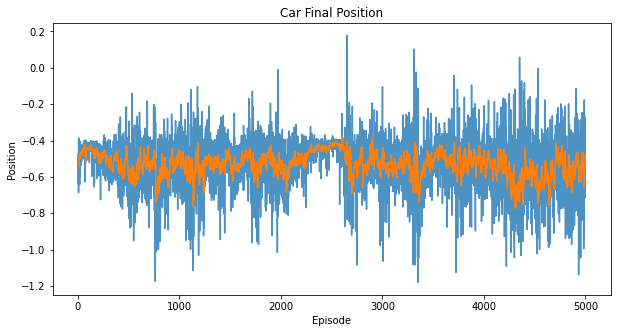

In [22]:
import pandas as pd
plt.figure(2, figsize=[10,5])
p = pd.Series(final_positions)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position.png')
plt.show()

### Saving the model using google Colaboratory onto google drive

In [23]:
torch.save(Car.network,'model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!cp ./model.pth /content/gdrive/My\ Drive/model.pth

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
